# Word Level Federated Text Generation with Stack Overflow with and without pre-trained word embeddings
- Arjun Singh (inherited from Joel's)
- 02-01-20

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip tensorflow
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

In [4]:
# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
from utils.dataset import construct_word_level_datasets, get_vocab, get_special_tokens

# from https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py
import utils.metrics as metrics

In [5]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: False
Build with GPU support: False
Num GPUs Available:  0


### Set Tensorflow to Use GPU, unless GPU isn't available (which is the case for me)

In [8]:
# physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
# tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)
# for device in physical_devices:
#     print(device)

### Test TFF

In [9]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model
**Note:** Ask Keith how he's been setting there for internal experiments.

In [10]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 500
NUM_TRAIN_CLIENTS = 10
UNIFORM_WEIGHTING = False

EMBEDDING_DIM = 100
RNN_UNITS = 256

### Load and Preprocess Word Level Datasets

In [11]:
train_data, val_data, test_data = construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


### Retrieve the Dataset Vocab

In [12]:
vocab = get_vocab(VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [13]:
pad, oov, bos, eos = get_special_tokens(VOCAB_SIZE)

In [14]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [15]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [16]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [17]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Load Pretrained Word Embeddings
- [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) trained on Wikipedia
- [Example usage](https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)

In [18]:
EMBEDDING_PATH = f'glove.6B.{EMBEDDING_DIM}d.txt'

In [19]:
EMBEDDING_PATH

'glove.6B.100d.txt'

In [20]:
def load_pretrained_embeddings():
    
    embeddings_index = {}
    with open(EMBEDDING_PATH, 'r') as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, 'f', sep=' ')
            embeddings_index[word] = coefs
            
    return embeddings_index

### Create Embedding Matrix from Words in Word Index and Word Embeddings
Words with no embedding are initialized as a vector of zeros.

In [21]:
def create_matrix_from_pretrained_embeddings():
    
    embeddings_index = load_pretrained_embeddings()
    embedding_matrix = np.zeros((EXTENDED_VOCAB_SIZE, EMBEDDING_DIM))

    for word, i in word2idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [22]:
m = create_matrix_from_pretrained_embeddings()
missing_words = np.sum(~m.any(axis=1))
print(f'Words from dataset with no embedding: {missing_words}')

Words from dataset with no embedding: 1304


### Create Embedding Initializer

In [23]:
def initialize_embedding():
    
    embedding_matrix = create_matrix_from_pretrained_embeddings()
    
    return tf.keras.initializers.Constant(embedding_matrix)

### Define Function to Build Model

In [24]:
def build_model(use_pretrained_embedding=False):
    """
    Build model with architecture from: https://www.tensorflow.org/tutorials/text/text_generation.
    """

    model1_input = tf.keras.Input(shape=(None, ), # changed from MAX_SEQ_LENGTH
                                  name='model1_input')
    
    if use_pretrained_embedding:
        model1_embedding = tf.keras.layers.Embedding(input_dim=EXTENDED_VOCAB_SIZE,
                                             output_dim=EMBEDDING_DIM,
                                             embeddings_initializer=initialize_embedding(), 
                                             mask_zero=True,
                                             trainable=True, # try unfreezing partway through training
                                             name='model1_embedding')(model1_input)
    else:
        model1_embedding = tf.keras.layers.Embedding(input_dim=EXTENDED_VOCAB_SIZE,
                                                 output_dim=EMBEDDING_DIM,
                                                 mask_zero=True,
                                                 name='model1_embedding')(model1_input)
    
    model1_lstm = tf.keras.layers.LSTM(units=RNN_UNITS,
                                       return_sequences=True,
                                       recurrent_initializer='glorot_uniform',
                                       name='model1_lstm')(model1_embedding)
    
    model1_dense1 = tf.keras.layers.Dense(units=EMBEDDING_DIM)(model1_lstm)
    
    model1_dense2 = tf.keras.layers.Dense(units=EXTENDED_VOCAB_SIZE)(model1_dense1)
    
    final_model = tf.keras.Model(inputs=model1_input, outputs=model1_dense2)
                 
    return final_model

### Define the Text Generation Strategy

In [25]:
def generate_text(model, start_string):
    """
    Generate text by sampling from the model output distribution
    as in From https://www.tensorflow.org/tutorials/sequences/text_generation.
    """
    
    start_words = [word.lower() for word in start_string.split(' ')]

    num_generate = 50
    input_eval = [word2idx[word] for word in start_words]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        #input_eval = tf.expand_dims([predicted_id], 0)
        input_eval = tf.concat([input_eval, tf.expand_dims([predicted_id], 0)], 1)
        text_generated.append(idx2word[predicted_id])

    return (' '.join(start_words) + ' ' + ' '.join(text_generated))

### Load or Build the Model and Try Generating Some Text

In [26]:
keras_model = build_model()
print(generate_text(keras_model, "How are you today"))

how are you today prototyping wide placeholders chef drastically operating machine's pertinent ugly iso-8859-1 considering asynchronously earliest mockito expectations arabic compose false bos apples getview dimension one-off shifting frontend lf slow struct ping dba extract larger api stress 42 approve gibberish exits span suspicious ee megabytes re-used gettype sibling discount lower strong develop transformation


### Define Evaluation Metrics for Training

In [27]:
def get_metrics():
    
    evaluation_metrics = [
        metrics.NumTokensCounter(name='num_tokens', masked_tokens=[pad]),
        metrics.NumTokensCounter(name='num_tokens_no_oov', masked_tokens=[pad, oov]),
        metrics.NumBatchesCounter(name='num_batches'),
        metrics.NumExamplesCounter(name='num_examples'),
        metrics.MaskedCategoricalAccuracy(name='accuracy', masked_tokens=[pad]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov', masked_tokens=[pad, oov]),
        metrics.MaskedCategoricalAccuracy(name='accuracy_no_oov_no_eos', masked_tokens=[pad, oov, eos])
    ]
    
    return evaluation_metrics

### Define a Function to Compile the Model for Training

In [28]:
def compile_model(keras_model, evaluation_metrics):
    
    keras_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=evaluation_metrics)
    
    return keras_model

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [29]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [30]:
def model_fn():
    """
    Create TFF model from compiled Keras model and a sample batch.
    """
    
    keras_model = build_model(use_pretrained_embedding=False)
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    
    return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

In [31]:
def model_fn_with_pretrained_embedding():
    """
    Create TFF model from compiled Keras model and a sample batch.
    """
    
    keras_model = build_model(use_pretrained_embedding=True)
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    
    return tff.learning.from_compiled_keras_model(keras_model, sample_batch)

### Define Model History Tracker to Save Metrics at Each Training Round
This is a spin off of [keras' model history](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) but is specific to the TFF training code used here.

In [32]:
class model_history_tracker:
    
    def __init__(self, metric_names=[]):
        
        self.metric_names = metric_names
        self.metrics_dict = {name:[] for name in metric_names}
    
    def get_metrics_by_name(self, metric_name):
        
        return self.metrics_dict[metric_name]
    
    def add_metrics_by_name(self, metric_name, metric_result):
        
        self.metrics_dict[metric_name].append(metric_result) 

### Initialize Train and Validation Model Trackers to be Used Below

In [51]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = model_history_tracker(evaluation_metric_names)
val_metrics_tracker = model_history_tracker(evaluation_metric_names)

train_metrics_tracker_with_embedding = model_history_tracker(evaluation_metric_names)
val_metrics_tracker_with_embedding = model_history_tracker(evaluation_metric_names)

### Define Function to Evaluate Model Performance on Validation Data

In [34]:
def keras_evaluate(state, val_dataset, use_pretrained_embedding=False):
    
    keras_model = build_model(use_pretrained_embedding=use_pretrained_embedding)
    evaluation_metrics = get_metrics()
    
    compile_model(keras_model, evaluation_metrics)
    tff.learning.assign_weights_to_keras_model(keras_model, state.model)
    
    evaluation_results = keras_model.evaluate(val_dataset)
    
    if use_pretrained_embedding:
        for i, result in enumerate(evaluation_results):
            val_metrics_tracker_with_embedding.add_metrics_by_name(val_metrics_tracker_with_embedding.metric_names[i], result)
    else:
        for i, result in enumerate(evaluation_results):
            val_metrics_tracker.add_metrics_by_name(val_metrics_tracker.metric_names[i], result)

### Define Function to Weight Clients Uniformly or by Number of Tokens

In [35]:
def client_weight_fn(local_outputs):
    
    num_tokens = tf.cast(tf.squeeze(local_outputs['num_tokens']), tf.float32)
    
    return 1.0 if UNIFORM_WEIGHTING else num_tokens

### Define Function to Supply Server Optimizer

In [36]:
def server_optimizer_fn():
    
    return tf.keras.optimizers.Adam()

### Set the Default Executor

In [37]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [38]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=model_fn,
          server_optimizer_fn=server_optimizer_fn,
          client_weight_fn=client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [39]:
server_state = iterative_process.initialize()

### Define Function to Create Training Datsets from Randomly Sampled Clients

In [44]:
def get_sample_clients(dataset, num_clients):
    
    random_indices = np.random.choice(len(dataset.client_ids), size=num_clients, replace=False)
    
    return np.array(dataset.client_ids)[random_indices]

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

In [41]:
# !pip install tqdm==2.2.3

In [41]:
from tqdm import tqdm

In [42]:
NUM_ROUNDS

500

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluating before training round #0 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 6.3764 - num_tokens: 131254.0000 - num_tokens_no_oov: 127367.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 5.3332e-05 - accuracy_no_oov: 5.4959e-05 - accuracy_no_oov_no_eos: 5.0041e-05
Sampling 10 new clients.


  0%|          | 1/500 [00:58<8:02:35,  0.02it/s]

Round: 0
   Loss: 6.71413231
   num_batches: 241
   num_examples: 3782
   num_tokens: 53152
   num_tokens_no_oov: 51881
   accuracy: 0.00036
   accuracy_no_oov: 0.00037
Evaluating before training round #1 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 6.8795 - num_tokens: 143045.0000 - num_tokens_no_oov: 138638.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.5866e-04 - accuracy_no_oov: 2.6688e-04 - accuracy_no_oov_no_eos: 1.8184e-04
Sampling 10 new clients.


  0%|          | 2/500 [01:52<7:46:50,  0.02it/s]

Round: 1
   Loss: 7.14242506
   num_batches: 220
   num_examples: 3421
   num_tokens: 43532
   num_tokens_no_oov: 42335
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #2 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 261ms/step - loss: 6.6620 - num_tokens: 138019.0000 - num_tokens_no_oov: 133041.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 3/500 [02:48<7:44:48,  0.02it/s]

Round: 2
   Loss: 6.84017038
   num_batches: 194
   num_examples: 3037
   num_tokens: 37744
   num_tokens_no_oov: 36717
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #3 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 6.5116 - num_tokens: 134534.0000 - num_tokens_no_oov: 129598.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 4/500 [03:41<7:37:28,  0.02it/s]

Round: 3
   Loss: 7.21238422
   num_batches: 199
   num_examples: 3123
   num_tokens: 38866
   num_tokens_no_oov: 37658
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #4 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 6.4206 - num_tokens: 132625.0000 - num_tokens_no_oov: 128657.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 5/500 [04:32<7:30:00,  0.02it/s]

Round: 4
   Loss: 7.83917427
   num_batches: 122
   num_examples: 1880
   num_tokens: 25010
   num_tokens_no_oov: 24362
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #5 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 253ms/step - loss: 6.6093 - num_tokens: 137190.0000 - num_tokens_no_oov: 131203.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 6/500 [05:32<7:36:08,  0.02it/s]

Round: 5
   Loss: 5.60619068
   num_batches: 318
   num_examples: 5017
   num_tokens: 64213
   num_tokens_no_oov: 62396
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #6 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 6.3785 - num_tokens: 132121.0000 - num_tokens_no_oov: 128330.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|▏         | 7/500 [06:35<7:43:43,  0.02it/s]

Round: 6
   Loss: 5.85892391
   num_batches: 287
   num_examples: 4508
   num_tokens: 61888
   num_tokens_no_oov: 60219
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #7 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 6.6400 - num_tokens: 139136.0000 - num_tokens_no_oov: 134582.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 8/500 [07:31<7:43:06,  0.02it/s]

Round: 7
   Loss: 6.34654284
   num_batches: 183
   num_examples: 2836
   num_tokens: 35549
   num_tokens_no_oov: 34317
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #8 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 6.2501 - num_tokens: 131942.0000 - num_tokens_no_oov: 127954.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+0085 - num_tokens: 83348.0000 - num_tokens_no_oov: 80854.0000 - num_batches: 63.0000 - num_examples: 6300.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000
Sampling 10 new clients.


  2%|▏         | 9/500 [08:23<7:38:02,  0.02it/s]

Round: 8
   Loss: 6.85512877
   num_batches: 107
   num_examples: 1621
   num_tokens: 21695
   num_tokens_no_oov: 21098
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #9 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 6.1627 - num_tokens: 133523.0000 - num_tokens_no_oov: 129216.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 10/500 [09:24<7:41:06,  0.02it/s]

Round: 9
   Loss: 4.76634550
   num_batches: 288
   num_examples: 4520
   num_tokens: 57403
   num_tokens_no_oov: 55854
   accuracy: 0.00888
   accuracy_no_oov: 0.00913
Evaluating before training round #10 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 5.8541 - num_tokens: 129805.0000 - num_tokens_no_oov: 125805.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 11/500 [10:22<7:41:31,  0.02it/s]

Round: 10
   Loss: 5.34708500
   num_batches: 300
   num_examples: 4708
   num_tokens: 65300
   num_tokens_no_oov: 63123
   accuracy: 0.00109
   accuracy_no_oov: 0.00112
Evaluating before training round #11 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 5.7362 - num_tokens: 131146.0000 - num_tokens_no_oov: 127121.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 12/500 [11:16<7:38:22,  0.02it/s]

Round: 11
   Loss: 5.51549959
   num_batches: 175
   num_examples: 2724
   num_tokens: 34740
   num_tokens_no_oov: 33846
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #12 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 5.1027 - num_tokens: 118159.0000 - num_tokens_no_oov: 113999.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 13/500 [12:10<7:36:16,  0.02it/s]

Round: 12
   Loss: 5.65289640
   num_batches: 181
   num_examples: 2815
   num_tokens: 38850
   num_tokens_no_oov: 37840
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #13 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 262ms/step - loss: 5.3884 - num_tokens: 130207.0000 - num_tokens_no_oov: 126111.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 14/500 [13:10<7:37:19,  0.02it/s]

Round: 13
   Loss: 5.06539440
   num_batches: 278
   num_examples: 4395
   num_tokens: 59813
   num_tokens_no_oov: 58322
   accuracy: 0.00438
   accuracy_no_oov: 0.00449
Evaluating before training round #14 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 5.4043 - num_tokens: 134537.0000 - num_tokens_no_oov: 130170.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 15/500 [14:07<7:36:45,  0.02it/s]

Round: 14
   Loss: 5.03524590
   num_batches: 194
   num_examples: 3048
   num_tokens: 40717
   num_tokens_no_oov: 39571
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #15 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 270ms/step - loss: 5.6927 - num_tokens: 146566.0000 - num_tokens_no_oov: 139606.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+0088 - num_tokens: 64287.0000 - num_tokens_no_oov: 61294.0000 - num_batches: 45.0000 - num_examples: 4500.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000 - 16s 335ms/step - loss: 5.6145 - num_tokens: 70751.0000 - num_tokens_no_oov: 67382.0000 - num_batches: 49.0000 - num_examples: 4900.0000 - accuracy: 0.0000e+00 - accuracy_
Sampling 10 new clients.


  3%|▎         | 16/500 [15:08<7:38:15,  0.02it/s]

Round: 15
   Loss: 4.27227402
   num_batches: 327
   num_examples: 5175
   num_tokens: 62781
   num_tokens_no_oov: 61277
   accuracy: 0.01191
   accuracy_no_oov: 0.01221
Evaluating before training round #16 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 256ms/step - loss: 5.0185 - num_tokens: 130259.0000 - num_tokens_no_oov: 125903.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 17/500 [16:06<7:37:34,  0.02it/s]

Round: 16
   Loss: 4.86927509
   num_batches: 231
   num_examples: 3629
   num_tokens: 46417
   num_tokens_no_oov: 45223
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #17 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 5.1871 - num_tokens: 137750.0000 - num_tokens_no_oov: 133176.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+0076 - num_tokens: 82251.0000 - num_tokens_no_oov: 79236.0000 - num_batches: 60.0000 - num_examples: 6000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0
Sampling 10 new clients.


  4%|▎         | 18/500 [17:01<7:35:42,  0.02it/s]

Round: 17
   Loss: 5.00107527
   num_batches: 263
   num_examples: 4165
   num_tokens: 57248
   num_tokens_no_oov: 55936
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #18 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 4.9306 - num_tokens: 132508.0000 - num_tokens_no_oov: 128207.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 19/500 [17:59<7:35:24,  0.02it/s]

Round: 18
   Loss: 4.54635048
   num_batches: 244
   num_examples: 3814
   num_tokens: 47612
   num_tokens_no_oov: 46116
   accuracy: 0.00050
   accuracy_no_oov: 0.00052
Evaluating before training round #19 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 4.7909 - num_tokens: 130790.0000 - num_tokens_no_oov: 126476.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 20/500 [18:57<7:34:53,  0.02it/s]

Round: 19
   Loss: 4.84644794
   num_batches: 251
   num_examples: 3928
   num_tokens: 52634
   num_tokens_no_oov: 51453
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #20 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 4.8290 - num_tokens: 133400.0000 - num_tokens_no_oov: 129413.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 21/500 [19:50<7:32:32,  0.02it/s]

Round: 20
   Loss: 4.60145044
   num_batches: 219
   num_examples: 3423
   num_tokens: 44015
   num_tokens_no_oov: 42968
   accuracy: 0.00016
   accuracy_no_oov: 0.00016
Evaluating before training round #21 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 4.8306 - num_tokens: 134613.0000 - num_tokens_no_oov: 130170.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 22/500 [21:00<7:36:23,  0.02it/s]

Round: 21
   Loss: 4.69029999
   num_batches: 512
   num_examples: 8115
   num_tokens: 117541
   num_tokens_no_oov: 113998
   accuracy: 0.02798
   accuracy_no_oov: 0.02869
Evaluating before training round #22 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 4.8340 - num_tokens: 135613.0000 - num_tokens_no_oov: 131366.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▍         | 23/500 [21:52<7:33:45,  0.02it/s]

Round: 22
   Loss: 4.95508099
   num_batches: 125
   num_examples: 1920
   num_tokens: 25860
   num_tokens_no_oov: 25167
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #23 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 4.6949 - num_tokens: 132574.0000 - num_tokens_no_oov: 127856.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▍         | 24/500 [22:44<7:30:52,  0.02it/s]

Round: 23
   Loss: 4.87366629
   num_batches: 132
   num_examples: 2035
   num_tokens: 27082
   num_tokens_no_oov: 26279
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #24 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 265ms/step - loss: 4.6488 - num_tokens: 132021.0000 - num_tokens_no_oov: 127785.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▌         | 25/500 [23:41<7:30:09,  0.02it/s]

Round: 24
   Loss: 4.64108133
   num_batches: 154
   num_examples: 2391
   num_tokens: 30533
   num_tokens_no_oov: 29573
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #25 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 4.6436 - num_tokens: 131978.0000 - num_tokens_no_oov: 127872.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▌         | 26/500 [24:31<7:27:04,  0.02it/s]

Round: 25
   Loss: 4.60569429
   num_batches: 97
   num_examples: 1458
   num_tokens: 18444
   num_tokens_no_oov: 17955
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #26 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 4.9380 - num_tokens: 140412.0000 - num_tokens_no_oov: 134966.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▌         | 27/500 [25:26<7:25:48,  0.02it/s]

Round: 26
   Loss: 4.62160349
   num_batches: 139
   num_examples: 2138
   num_tokens: 27697
   num_tokens_no_oov: 27010
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #27 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 4.7307 - num_tokens: 134484.0000 - num_tokens_no_oov: 130074.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 28/500 [26:18<7:23:32,  0.02it/s]

Round: 27
   Loss: 4.66770506
   num_batches: 185
   num_examples: 2890
   num_tokens: 38538
   num_tokens_no_oov: 37334
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #28 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 4.6391 - num_tokens: 133782.0000 - num_tokens_no_oov: 128947.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 29/500 [27:17<7:23:15,  0.02it/s]

Round: 28
   Loss: 4.44416523
   num_batches: 215
   num_examples: 3365
   num_tokens: 44290
   num_tokens_no_oov: 43112
   accuracy: 0.01012
   accuracy_no_oov: 0.01039
Evaluating before training round #29 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 4.6769 - num_tokens: 134403.0000 - num_tokens_no_oov: 130647.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 30/500 [28:26<7:25:40,  0.02it/s]

Round: 29
   Loss: 4.15355730
   num_batches: 480
   num_examples: 7613
   num_tokens: 105864
   num_tokens_no_oov: 102524
   accuracy: 0.04564
   accuracy_no_oov: 0.04648
Evaluating before training round #30 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 4.5059 - num_tokens: 130337.0000 - num_tokens_no_oov: 126341.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 31/500 [29:28<7:25:50,  0.02it/s]

Round: 30
   Loss: 4.45497084
   num_batches: 287
   num_examples: 4495
   num_tokens: 59822
   num_tokens_no_oov: 58051
   accuracy: 0.00354
   accuracy_no_oov: 0.00365
Evaluating before training round #31 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 4.7526 - num_tokens: 138044.0000 - num_tokens_no_oov: 133361.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▋         | 32/500 [30:22<7:24:20,  0.02it/s]

Round: 31
   Loss: 4.51175070
   num_batches: 294
   num_examples: 4609
   num_tokens: 62045
   num_tokens_no_oov: 60331
   accuracy: 0.00148
   accuracy_no_oov: 0.00152
Evaluating before training round #32 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 4.3234 - num_tokens: 125963.0000 - num_tokens_no_oov: 122369.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+0065 - num_tokens: 99485.0000 - num_tokens_no_oov: 96502.0000 - num_batches: 79.0000 - num_examples: 7900.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_n
Sampling 10 new clients.


  7%|▋         | 33/500 [31:20<7:23:30,  0.02it/s]

Round: 32
   Loss: 4.44899607
   num_batches: 195
   num_examples: 3037
   num_tokens: 38941
   num_tokens_no_oov: 38046
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #33 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 4.7544 - num_tokens: 137791.0000 - num_tokens_no_oov: 133637.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 34/500 [32:14<7:21:55,  0.02it/s]

Round: 33
   Loss: 4.38413525
   num_batches: 207
   num_examples: 3241
   num_tokens: 42666
   num_tokens_no_oov: 41484
   accuracy: 0.00691
   accuracy_no_oov: 0.00711
Evaluating before training round #34 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 4.6394 - num_tokens: 134429.0000 - num_tokens_no_oov: 130398.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 35/500 [33:05<7:19:37,  0.02it/s]

Round: 34
   Loss: 4.37895203
   num_batches: 135
   num_examples: 2074
   num_tokens: 26610
   num_tokens_no_oov: 25867
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #35 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 321ms/step - loss: 4.4924 - num_tokens: 130621.0000 - num_tokens_no_oov: 126408.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 36/500 [34:04<7:19:12,  0.02it/s]

Round: 35
   Loss: 4.18206644
   num_batches: 153
   num_examples: 2365
   num_tokens: 29450
   num_tokens_no_oov: 28730
   accuracy: 0.00136
   accuracy_no_oov: 0.00139
Evaluating before training round #36 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 4.6494 - num_tokens: 134736.0000 - num_tokens_no_oov: 130186.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 37/500 [34:57<7:17:32,  0.02it/s]

Round: 36
   Loss: 4.62059116
   num_batches: 193
   num_examples: 3007
   num_tokens: 41925
   num_tokens_no_oov: 40700
   accuracy: 0.00391
   accuracy_no_oov: 0.00403
Evaluating before training round #37 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 4.6578 - num_tokens: 135164.0000 - num_tokens_no_oov: 131095.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 38/500 [36:02<7:18:08,  0.02it/s]

Round: 37
   Loss: 4.21939564
   num_batches: 305
   num_examples: 4793
   num_tokens: 64537
   num_tokens_no_oov: 63074
   accuracy: 0.02586
   accuracy_no_oov: 0.02646
Evaluating before training round #38 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 4.4877 - num_tokens: 130793.0000 - num_tokens_no_oov: 126798.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 39/500 [36:57<7:16:52,  0.02it/s]

Round: 38
   Loss: 4.44258738
   num_batches: 281
   num_examples: 4440
   num_tokens: 60802
   num_tokens_no_oov: 59128
   accuracy: 0.00727
   accuracy_no_oov: 0.00748
Evaluating before training round #39 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 252ms/step - loss: 4.4441 - num_tokens: 130482.0000 - num_tokens_no_oov: 126609.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00- num_tokens: 26569.0000 - num_tokens_no_oov: 25785.0000 - num_batches: 20.0000 - num_examples: 2000.0
Sampling 10 new clients.


  8%|▊         | 40/500 [37:49<7:14:54,  0.02it/s]

Round: 39
   Loss: 4.38048601
   num_batches: 143
   num_examples: 2212
   num_tokens: 28774
   num_tokens_no_oov: 27928
   accuracy: 0.00014
   accuracy_no_oov: 0.00014
Evaluating before training round #40 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 4.2853 - num_tokens: 126092.0000 - num_tokens_no_oov: 121778.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 41/500 [38:45<7:13:53,  0.02it/s]

Round: 40
   Loss: 4.72308874
   num_batches: 92
   num_examples: 1385
   num_tokens: 19138
   num_tokens_no_oov: 18662
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #41 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 4.5096 - num_tokens: 133192.0000 - num_tokens_no_oov: 129122.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 42/500 [39:36<7:11:54,  0.02it/s]

Round: 41
   Loss: 4.62612343
   num_batches: 155
   num_examples: 2421
   num_tokens: 33149
   num_tokens_no_oov: 32311
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #42 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 4.4609 - num_tokens: 132160.0000 - num_tokens_no_oov: 127797.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▊         | 43/500 [40:27<7:09:55,  0.02it/s]

Round: 42
   Loss: 4.30242968
   num_batches: 146
   num_examples: 2254
   num_tokens: 28834
   num_tokens_no_oov: 27952
   accuracy: 0.00024
   accuracy_no_oov: 0.00025
Evaluating before training round #43 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 256ms/step - loss: 4.8594 - num_tokens: 143253.0000 - num_tokens_no_oov: 139937.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▉         | 44/500 [41:32<7:10:32,  0.02it/s]

Round: 43
   Loss: 4.20599747
   num_batches: 290
   num_examples: 4569
   num_tokens: 61379
   num_tokens_no_oov: 59817
   accuracy: 0.02882
   accuracy_no_oov: 0.02957
Evaluating before training round #44 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 4.6790 - num_tokens: 136033.0000 - num_tokens_no_oov: 130604.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▉         | 45/500 [42:29<7:09:39,  0.02it/s]

Round: 44
   Loss: 4.15741730
   num_batches: 288
   num_examples: 4522
   num_tokens: 59325
   num_tokens_no_oov: 57525
   accuracy: 0.02117
   accuracy_no_oov: 0.02183
Evaluating before training round #45 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 4.4661 - num_tokens: 131708.0000 - num_tokens_no_oov: 127442.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▉         | 46/500 [43:23<7:08:16,  0.02it/s]

Round: 45
   Loss: 4.29090214
   num_batches: 250
   num_examples: 3927
   num_tokens: 52814
   num_tokens_no_oov: 51505
   accuracy: 0.00962
   accuracy_no_oov: 0.00986
Evaluating before training round #46 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 263ms/step - loss: 4.3994 - num_tokens: 130315.0000 - num_tokens_no_oov: 125875.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  9%|▉         | 47/500 [44:23<7:07:53,  0.02it/s]

Round: 46
   Loss: 4.39020681
   num_batches: 137
   num_examples: 2127
   num_tokens: 28810
   num_tokens_no_oov: 27807
   accuracy: 0.00812
   accuracy_no_oov: 0.00824
Evaluating before training round #47 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 4.2826 - num_tokens: 127067.0000 - num_tokens_no_oov: 123234.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|▉         | 48/500 [45:21<7:07:11,  0.02it/s]

Round: 47
   Loss: 4.51962233
   num_batches: 362
   num_examples: 5738
   num_tokens: 83781
   num_tokens_no_oov: 81431
   accuracy: 0.02621
   accuracy_no_oov: 0.02610
Evaluating before training round #48 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 4.5905 - num_tokens: 135904.0000 - num_tokens_no_oov: 131327.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|▉         | 49/500 [46:20<7:06:30,  0.02it/s]

Round: 48
   Loss: 4.62329531
   num_batches: 313
   num_examples: 4928
   num_tokens: 71557
   num_tokens_no_oov: 69739
   accuracy: 0.02975
   accuracy_no_oov: 0.03053
Evaluating before training round #49 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 4.3920 - num_tokens: 131448.0000 - num_tokens_no_oov: 127055.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|█         | 50/500 [47:15<7:05:19,  0.02it/s]

Round: 49
   Loss: 4.34308481
   num_batches: 227
   num_examples: 3570
   num_tokens: 49601
   num_tokens_no_oov: 48377
   accuracy: 0.02623
   accuracy_no_oov: 0.02462
Evaluating before training round #50 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 337ms/step - loss: 4.3295 - num_tokens: 128926.0000 - num_tokens_no_oov: 125000.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|█         | 51/500 [48:15<7:04:50,  0.02it/s]

Round: 50
   Loss: 4.14600086
   num_batches: 149
   num_examples: 2289
   num_tokens: 29572
   num_tokens_no_oov: 28519
   accuracy: 0.01468
   accuracy_no_oov: 0.01522
Evaluating before training round #51 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 4.3753 - num_tokens: 131332.0000 - num_tokens_no_oov: 127376.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 10%|█         | 52/500 [49:09<7:03:29,  0.02it/s]

Round: 51
   Loss: 4.40554047
   num_batches: 199
   num_examples: 3097
   num_tokens: 43198
   num_tokens_no_oov: 42060
   accuracy: 0.02114
   accuracy_no_oov: 0.02171
Evaluating before training round #52 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 4.7376 - num_tokens: 142099.0000 - num_tokens_no_oov: 137953.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+0093 - num_tokens: 68461.0000 - num_tokens_no_oov: 66556.0000 - num_batches: 45.0000 - num_examples: 4500.0000 - accuracy: 0.0000e+00 - accura
Sampling 10 new clients.


 11%|█         | 53/500 [50:16<7:04:04,  0.02it/s]

Round: 52
   Loss: 4.32007456
   num_batches: 466
   num_examples: 7365
   num_tokens: 107604
   num_tokens_no_oov: 103788
   accuracy: 0.05114
   accuracy_no_oov: 0.04711
Evaluating before training round #53 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.9875 - num_tokens: 120483.0000 - num_tokens_no_oov: 116840.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 11%|█         | 54/500 [51:19<7:03:58,  0.02it/s]

Round: 53
   Loss: 4.22019911
   num_batches: 267
   num_examples: 4198
   num_tokens: 56790
   num_tokens_no_oov: 55469
   accuracy: 0.03141
   accuracy_no_oov: 0.03216
Evaluating before training round #54 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 4.3826 - num_tokens: 132584.0000 - num_tokens_no_oov: 128472.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 11%|█         | 55/500 [52:26<7:04:19,  0.02it/s]

Round: 54
   Loss: 4.32738352
   num_batches: 456
   num_examples: 7245
   num_tokens: 105862
   num_tokens_no_oov: 102863
   accuracy: 0.06626
   accuracy_no_oov: 0.06514
Evaluating before training round #55 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 4.3565 - num_tokens: 133711.0000 - num_tokens_no_oov: 129973.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 11%|█         | 56/500 [53:23<7:03:22,  0.02it/s]

Round: 55
   Loss: 4.10256290
   num_batches: 283
   num_examples: 4454
   num_tokens: 60606
   num_tokens_no_oov: 59063
   accuracy: 0.04745
   accuracy_no_oov: 0.04869
Evaluating before training round #56 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 4.4359 - num_tokens: 135609.0000 - num_tokens_no_oov: 131396.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 11%|█▏        | 57/500 [54:33<7:04:03,  0.02it/s]

Round: 56
   Loss: 3.18139458
   num_batches: 504
   num_examples: 8018
   num_tokens: 90890
   num_tokens_no_oov: 87460
   accuracy: 0.08065
   accuracy_no_oov: 0.08008
Evaluating before training round #57 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 4.4408 - num_tokens: 137137.0000 - num_tokens_no_oov: 132508.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 12%|█▏        | 58/500 [55:32<7:03:18,  0.02it/s]

Round: 57
   Loss: 4.33740950
   num_batches: 146
   num_examples: 2257
   num_tokens: 31091
   num_tokens_no_oov: 30290
   accuracy: 0.02374
   accuracy_no_oov: 0.02436
Evaluating before training round #58 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 4.3708 - num_tokens: 135579.0000 - num_tokens_no_oov: 131389.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 7.3758e-06 - accuracy_no_oov: 7.6110e-06 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


 12%|█▏        | 59/500 [56:24<7:01:40,  0.02it/s]

Round: 58
   Loss: 4.12178135
   num_batches: 108
   num_examples: 1658
   num_tokens: 21967
   num_tokens_no_oov: 21313
   accuracy: 0.02495
   accuracy_no_oov: 0.02571
Evaluating before training round #59 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 4.1679 - num_tokens: 130045.0000 - num_tokens_no_oov: 125201.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 4.4600e-04 - accuracy_no_oov: 4.6326e-04 - accuracy_no_oov_no_eos: 4.6722e-04
Sampling 10 new clients.


 12%|█▏        | 60/500 [57:15<6:59:54,  0.02it/s]

Round: 59
   Loss: 4.18008995
   num_batches: 147
   num_examples: 2301
   num_tokens: 30786
   num_tokens_no_oov: 29930
   accuracy: 0.03557
   accuracy_no_oov: 0.03659
Evaluating before training round #60 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 252ms/step - loss: 4.3554 - num_tokens: 137228.0000 - num_tokens_no_oov: 132215.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0029 - accuracy_no_oov: 0.0030 - accuracy_no_oov_no_eos: 0.0031
Sampling 10 new clients.


 12%|█▏        | 61/500 [58:05<6:58:04,  0.02it/s]

Round: 60
   Loss: 4.04557228
   num_batches: 115
   num_examples: 1775
   num_tokens: 22735
   num_tokens_no_oov: 21972
   accuracy: 0.03180
   accuracy_no_oov: 0.03291
Evaluating before training round #61 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 4.2494 - num_tokens: 134371.0000 - num_tokens_no_oov: 130063.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0055 - accuracy_no_oov: 0.0057 - accuracy_no_oov_no_eos: 0.0060
Sampling 10 new clients.


 12%|█▏        | 62/500 [59:21<6:59:17,  0.02it/s]

Round: 61
   Loss: 3.97853065
   num_batches: 410
   num_examples: 6468
   num_tokens: 88765
   num_tokens_no_oov: 86656
   accuracy: 0.09949
   accuracy_no_oov: 0.09975
Evaluating before training round #62 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 4.1746 - num_tokens: 132266.0000 - num_tokens_no_oov: 128219.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0127 - accuracy_no_oov: 0.0131 - accuracy_no_oov_no_eos: 0.0138
Sampling 10 new clients.


 13%|█▎        | 63/500 [1:00:16<6:58:04,  0.02it/s]

Round: 62
   Loss: 3.70934391
   num_batches: 232
   num_examples: 3635
   num_tokens: 45599
   num_tokens_no_oov: 44133
   accuracy: 0.06691
   accuracy_no_oov: 0.06116
Evaluating before training round #63 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 4.1117 - num_tokens: 130509.0000 - num_tokens_no_oov: 126663.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0194 - accuracy_no_oov: 0.0200 - accuracy_no_oov_no_eos: 0.0212
Sampling 10 new clients.


 13%|█▎        | 64/500 [1:01:10<6:56:43,  0.02it/s]

Round: 63
   Loss: 3.66337919
   num_batches: 233
   num_examples: 3655
   num_tokens: 44709
   num_tokens_no_oov: 43491
   accuracy: 0.05672
   accuracy_no_oov: 0.05831
Evaluating before training round #64 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 4.0719 - num_tokens: 129300.0000 - num_tokens_no_oov: 125214.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0223 - accuracy_no_oov: 0.0231 - accuracy_no_oov_no_eos: 0.0244
Sampling 10 new clients.


 13%|█▎        | 65/500 [1:01:59<6:54:49,  0.02it/s]

Round: 64
   Loss: 3.93041134
   num_batches: 121
   num_examples: 1872
   num_tokens: 23528
   num_tokens_no_oov: 22771
   accuracy: 0.04340
   accuracy_no_oov: 0.04484
Evaluating before training round #65 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 4.2825 - num_tokens: 136162.0000 - num_tokens_no_oov: 132848.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0305 - accuracy_no_oov: 0.0312 - accuracy_no_oov_no_eos: 0.0326
Sampling 10 new clients.


 13%|█▎        | 66/500 [1:02:46<6:52:48,  0.02it/s]

Round: 65
   Loss: 3.98029256
   num_batches: 159
   num_examples: 2483
   num_tokens: 32130
   num_tokens_no_oov: 31124
   accuracy: 0.05207
   accuracy_no_oov: 0.05375
Evaluating before training round #66 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 34s 337ms/step - loss: 3.9896 - num_tokens: 127527.0000 - num_tokens_no_oov: 123839.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0291 - accuracy_no_oov: 0.0299 - accuracy_no_oov_no_eos: 0.0299
Sampling 10 new clients.


 13%|█▎        | 67/500 [1:03:45<6:52:05,  0.02it/s]

Round: 66
   Loss: 4.14107943
   num_batches: 155
   num_examples: 2388
   num_tokens: 32603
   num_tokens_no_oov: 31564
   accuracy: 0.05147
   accuracy_no_oov: 0.05132
Evaluating before training round #67 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 4.0987 - num_tokens: 131421.0000 - num_tokens_no_oov: 127506.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0347 - accuracy_no_oov: 0.0357 - accuracy_no_oov_no_eos: 0.0344
Sampling 10 new clients.


 14%|█▎        | 68/500 [1:04:33<6:50:05,  0.02it/s]

Round: 67
   Loss: 4.15654182
   num_batches: 106
   num_examples: 1620
   num_tokens: 22250
   num_tokens_no_oov: 21549
   accuracy: 0.04908
   accuracy_no_oov: 0.04938
Evaluating before training round #68 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 4.1566 - num_tokens: 133296.0000 - num_tokens_no_oov: 129069.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0644 - accuracy_no_oov: 0.0665 - accuracy_no_oov_no_eos: 0.0310
Sampling 10 new clients.


 14%|█▍        | 69/500 [1:05:32<6:49:26,  0.02it/s]

Round: 68
   Loss: 4.57285309
   num_batches: 441
   num_examples: 6968
   num_tokens: 113262
   num_tokens_no_oov: 110006
   accuracy: 0.08896
   accuracy_no_oov: 0.08194
Evaluating before training round #69 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 4.2752 - num_tokens: 136239.0000 - num_tokens_no_oov: 132328.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0665 - accuracy_no_oov: 0.0685 - accuracy_no_oov_no_eos: 0.0313
Sampling 10 new clients.


 14%|█▍        | 70/500 [1:06:21<6:47:36,  0.02it/s]

Round: 69
   Loss: 4.18575191
   num_batches: 156
   num_examples: 2444
   num_tokens: 33301
   num_tokens_no_oov: 32368
   accuracy: 0.05441
   accuracy_no_oov: 0.05592
Evaluating before training round #70 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 4.2666 - num_tokens: 136876.0000 - num_tokens_no_oov: 131767.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0711 - accuracy_no_oov: 0.0739 - accuracy_no_oov_no_eos: 0.0288
Sampling 10 new clients.


 14%|█▍        | 71/500 [1:07:23<6:47:09,  0.02it/s]

Round: 70
   Loss: 4.46226215
   num_batches: 163
   num_examples: 2515
   num_tokens: 36414
   num_tokens_no_oov: 35419
   accuracy: 0.05177
   accuracy_no_oov: 0.05308
Evaluating before training round #71 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 4.3414 - num_tokens: 137813.0000 - num_tokens_no_oov: 133831.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0684 - accuracy_no_oov: 0.0704 - accuracy_no_oov_no_eos: 0.0282
Sampling 10 new clients.


 14%|█▍        | 72/500 [1:08:11<6:45:20,  0.02it/s]

Round: 71
   Loss: 3.92712283
   num_batches: 165
   num_examples: 2550
   num_tokens: 32970
   num_tokens_no_oov: 32067
   accuracy: 0.05996
   accuracy_no_oov: 0.06159
Evaluating before training round #72 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 4.2275 - num_tokens: 135610.0000 - num_tokens_no_oov: 131447.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0679 - accuracy_no_oov: 0.0701 - accuracy_no_oov_no_eos: 0.0269
Sampling 10 new clients.


 15%|█▍        | 73/500 [1:09:01<6:43:46,  0.02it/s]

Round: 72
   Loss: 4.09825230
   num_batches: 173
   num_examples: 2664
   num_tokens: 36541
   num_tokens_no_oov: 35555
   accuracy: 0.06119
   accuracy_no_oov: 0.06072
Evaluating before training round #73 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 4.2390 - num_tokens: 135286.0000 - num_tokens_no_oov: 130886.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0653 - accuracy_no_oov: 0.0675 - accuracy_no_oov_no_eos: 0.0236
Sampling 10 new clients.


 15%|█▍        | 74/500 [1:09:48<6:41:50,  0.02it/s]

Round: 73
   Loss: 3.98004484
   num_batches: 107
   num_examples: 1641
   num_tokens: 21280
   num_tokens_no_oov: 20563
   accuracy: 0.05827
   accuracy_no_oov: 0.05938
Evaluating before training round #74 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 4.2142 - num_tokens: 133481.0000 - num_tokens_no_oov: 129911.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0628 - accuracy_no_oov: 0.0645 - accuracy_no_oov_no_eos: 0.0205
Sampling 10 new clients.


 15%|█▌        | 75/500 [1:10:50<6:41:23,  0.02it/s]

Round: 74
   Loss: 3.27352357
   num_batches: 423
   num_examples: 6699
   num_tokens: 80923
   num_tokens_no_oov: 78827
   accuracy: 0.10144
   accuracy_no_oov: 0.10031
Evaluating before training round #75 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 4.3052 - num_tokens: 136763.0000 - num_tokens_no_oov: 132588.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0653 - accuracy_no_oov: 0.0673 - accuracy_no_oov_no_eos: 0.0215
Sampling 10 new clients.


 15%|█▌        | 76/500 [1:11:53<6:41:02,  0.02it/s]

Round: 75
   Loss: 4.15155745
   num_batches: 195
   num_examples: 3058
   num_tokens: 42224
   num_tokens_no_oov: 41107
   accuracy: 0.06745
   accuracy_no_oov: 0.06714
Evaluating before training round #76 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 4.2028 - num_tokens: 134044.0000 - num_tokens_no_oov: 129899.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0645 - accuracy_no_oov: 0.0666 - accuracy_no_oov_no_eos: 0.0181
Sampling 10 new clients.


 15%|█▌        | 77/500 [1:12:43<6:39:28,  0.02it/s]

Round: 76
   Loss: 3.80692697
   num_batches: 166
   num_examples: 2568
   num_tokens: 32936
   num_tokens_no_oov: 31916
   accuracy: 0.07287
   accuracy_no_oov: 0.07451
Evaluating before training round #77 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 4.3065 - num_tokens: 136708.0000 - num_tokens_no_oov: 132496.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0610 - accuracy_no_oov: 0.0629 - accuracy_no_oov_no_eos: 0.0169
Sampling 10 new clients.


 16%|█▌        | 78/500 [1:13:28<6:37:31,  0.02it/s]

Round: 77
   Loss: 3.93594241
   num_batches: 96
   num_examples: 1463
   num_tokens: 18867
   num_tokens_no_oov: 18445
   accuracy: 0.06010
   accuracy_no_oov: 0.06132
Evaluating before training round #78 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 4.1142 - num_tokens: 132418.0000 - num_tokens_no_oov: 128168.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0666 - accuracy_no_oov: 0.0687 - accuracy_no_oov_no_eos: 0.0168
Sampling 10 new clients.


 16%|█▌        | 79/500 [1:14:17<6:35:52,  0.02it/s]

Round: 78
   Loss: 3.89556527
   num_batches: 177
   num_examples: 2767
   num_tokens: 37076
   num_tokens_no_oov: 36221
   accuracy: 0.08439
   accuracy_no_oov: 0.08600
Evaluating before training round #79 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 4.1445 - num_tokens: 132635.0000 - num_tokens_no_oov: 128793.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0632 - accuracy_no_oov: 0.0649 - accuracy_no_oov_no_eos: 0.0152
Sampling 10 new clients.


 16%|█▌        | 80/500 [1:15:04<6:34:08,  0.02it/s]

Round: 79
   Loss: 4.28399849
   num_batches: 135
   num_examples: 2079
   num_tokens: 29549
   num_tokens_no_oov: 28588
   accuracy: 0.07672
   accuracy_no_oov: 0.07213
Evaluating before training round #80 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 4.1820 - num_tokens: 133781.0000 - num_tokens_no_oov: 129636.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0635 - accuracy_no_oov: 0.0648 - accuracy_no_oov_no_eos: 0.0137
Sampling 10 new clients.


 16%|█▌        | 81/500 [1:15:54<6:32:39,  0.02it/s]

Round: 80
   Loss: 3.97516561
   num_batches: 188
   num_examples: 2946
   num_tokens: 39741
   num_tokens_no_oov: 38483
   accuracy: 0.07592
   accuracy_no_oov: 0.07068
Evaluating before training round #81 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 37s 370ms/step - loss: 4.1799 - num_tokens: 134590.0000 - num_tokens_no_oov: 130493.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0628 - accuracy_no_oov: 0.0635 - accuracy_no_oov_no_eos: 0.0132
Sampling 10 new clients.


 16%|█▋        | 82/500 [1:17:03<6:32:46,  0.02it/s]

Round: 81
   Loss: 3.83876944
   num_batches: 291
   num_examples: 4591
   num_tokens: 62061
   num_tokens_no_oov: 60617
   accuracy: 0.09711
   accuracy_no_oov: 0.09892
Evaluating before training round #82 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 4.1164 - num_tokens: 132257.0000 - num_tokens_no_oov: 128324.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0694 - accuracy_no_oov: 0.0688 - accuracy_no_oov_no_eos: 0.0155
Sampling 10 new clients.


 17%|█▋        | 83/500 [1:17:53<6:31:19,  0.02it/s]

Round: 82
   Loss: 3.84881163
   num_batches: 217
   num_examples: 3384
   num_tokens: 44595
   num_tokens_no_oov: 43303
   accuracy: 0.08084
   accuracy_no_oov: 0.07944
Evaluating before training round #83 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 4.1362 - num_tokens: 133207.0000 - num_tokens_no_oov: 129111.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0689 - accuracy_no_oov: 0.0665 - accuracy_no_oov_no_eos: 0.0155
Sampling 10 new clients.


 17%|█▋        | 84/500 [1:18:54<6:30:48,  0.02it/s]

Round: 83
   Loss: 3.91849637
   num_batches: 463
   num_examples: 7326
   num_tokens: 102304
   num_tokens_no_oov: 100111
   accuracy: 0.09928
   accuracy_no_oov: 0.09873
Evaluating before training round #84 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 4.2361 - num_tokens: 135002.0000 - num_tokens_no_oov: 131156.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0724 - accuracy_no_oov: 0.0695 - accuracy_no_oov_no_eos: 0.0209
Sampling 10 new clients.


 17%|█▋        | 85/500 [1:19:41<6:29:04,  0.02it/s]

Round: 84
   Loss: 4.00012398
   num_batches: 136
   num_examples: 2108
   num_tokens: 28609
   num_tokens_no_oov: 27887
   accuracy: 0.07585
   accuracy_no_oov: 0.07416
Evaluating before training round #85 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 4.1574 - num_tokens: 134475.0000 - num_tokens_no_oov: 130117.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0776 - accuracy_no_oov: 0.0739 - accuracy_no_oov_no_eos: 0.0231
Sampling 10 new clients.


 17%|█▋        | 86/500 [1:20:36<6:28:02,  0.02it/s]

Round: 85
   Loss: 3.67802525
   num_batches: 299
   num_examples: 4665
   num_tokens: 60799
   num_tokens_no_oov: 59600
   accuracy: 0.09334
   accuracy_no_oov: 0.09414
Evaluating before training round #86 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 4.3475 - num_tokens: 139430.0000 - num_tokens_no_oov: 134194.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0744 - accuracy_no_oov: 0.0697 - accuracy_no_oov_no_eos: 0.0257
Sampling 10 new clients.


 17%|█▋        | 87/500 [1:21:46<6:28:13,  0.02it/s]

Round: 86
   Loss: 3.83282900
   num_batches: 351
   num_examples: 5568
   num_tokens: 76420
   num_tokens_no_oov: 74678
   accuracy: 0.09656
   accuracy_no_oov: 0.09546
Evaluating before training round #87 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 4.4334 - num_tokens: 143763.0000 - num_tokens_no_oov: 140640.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0768 - accuracy_no_oov: 0.0742 - accuracy_no_oov_no_eos: 0.0322
Sampling 10 new clients.


 18%|█▊        | 88/500 [1:22:35<6:26:38,  0.02it/s]

Round: 87
   Loss: 4.08628082
   num_batches: 118
   num_examples: 1831
   num_tokens: 24900
   num_tokens_no_oov: 24320
   accuracy: 0.07960
   accuracy_no_oov: 0.07891
Evaluating before training round #88 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 4.1362 - num_tokens: 133672.0000 - num_tokens_no_oov: 129613.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0880 - accuracy_no_oov: 0.0839 - accuracy_no_oov_no_eos: 0.0340
Sampling 10 new clients.


 18%|█▊        | 89/500 [1:23:30<6:25:40,  0.02it/s]

Round: 88
   Loss: 3.68871665
   num_batches: 337
   num_examples: 5294
   num_tokens: 72220
   num_tokens_no_oov: 70795
   accuracy: 0.12191
   accuracy_no_oov: 0.12302
Evaluating before training round #89 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.8821 - num_tokens: 126680.0000 - num_tokens_no_oov: 122805.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0922 - accuracy_no_oov: 0.0889 - accuracy_no_oov_no_eos: 0.0397
Sampling 10 new clients.


 18%|█▊        | 90/500 [1:24:32<6:25:09,  0.02it/s]

Round: 89
   Loss: 4.01770496
   num_batches: 440
   num_examples: 6981
   num_tokens: 103350
   num_tokens_no_oov: 100551
   accuracy: 0.12207
   accuracy_no_oov: 0.11700
Evaluating before training round #90 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 4.0787 - num_tokens: 132447.0000 - num_tokens_no_oov: 128210.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0948 - accuracy_no_oov: 0.0904 - accuracy_no_oov_no_eos: 0.0451
Sampling 10 new clients.


 18%|█▊        | 91/500 [1:25:23<6:23:48,  0.02it/s]

Round: 90
   Loss: 3.42775607
   num_batches: 244
   num_examples: 3845
   num_tokens: 46401
   num_tokens_no_oov: 44983
   accuracy: 0.11030
   accuracy_no_oov: 0.10668
Evaluating before training round #91 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 4.0359 - num_tokens: 130922.0000 - num_tokens_no_oov: 126485.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0946 - accuracy_no_oov: 0.0896 - accuracy_no_oov_no_eos: 0.048236 - num_tokens: 86452.0000 - num_tokens_no_oov: 83637.0000 - num_batches: 67.0000 - num_examples: 6700.0000 - accuracy: 0.0953 - accuracy_no_oov: 0.0
Sampling 10 new clients.


 18%|█▊        | 92/500 [1:26:17<6:22:41,  0.02it/s]

Round: 91
   Loss: 3.93105221
   num_batches: 244
   num_examples: 3863
   num_tokens: 52918
   num_tokens_no_oov: 51623
   accuracy: 0.09866
   accuracy_no_oov: 0.09380
Evaluating before training round #92 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 4.1323 - num_tokens: 133685.0000 - num_tokens_no_oov: 129306.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0992 - accuracy_no_oov: 0.0942 - accuracy_no_oov_no_eos: 0.0557
Sampling 10 new clients.


 19%|█▊        | 93/500 [1:27:28<6:22:50,  0.02it/s]

Round: 92
   Loss: 3.76755619
   num_batches: 252
   num_examples: 3948
   num_tokens: 52521
   num_tokens_no_oov: 51277
   accuracy: 0.10596
   accuracy_no_oov: 0.10398
Evaluating before training round #93 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 4.0543 - num_tokens: 131619.0000 - num_tokens_no_oov: 126856.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0924 - accuracy_no_oov: 0.0864 - accuracy_no_oov_no_eos: 0.055670 - num_tokens: 86673.0000 - num_tokens_no_oov: 83540.0000 - num_batches: 67.0000 - num_examples: 6700.0000 - accuracy: 0.0949 - accuracy_no_oov: 0.0
Sampling 10 new clients.


 19%|█▉        | 94/500 [1:28:19<6:21:28,  0.02it/s]

Round: 93
   Loss: 3.90626836
   num_batches: 208
   num_examples: 3262
   num_tokens: 43787
   num_tokens_no_oov: 42603
   accuracy: 0.10060
   accuracy_no_oov: 0.09509
Evaluating before training round #94 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.9742 - num_tokens: 130734.0000 - num_tokens_no_oov: 126340.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0929 - accuracy_no_oov: 0.0871 - accuracy_no_oov_no_eos: 0.0593
Sampling 10 new clients.


 19%|█▉        | 95/500 [1:29:15<6:20:32,  0.02it/s]

Round: 94
   Loss: 3.87878227
   num_batches: 369
   num_examples: 5863
   num_tokens: 79557
   num_tokens_no_oov: 77436
   accuracy: 0.10704
   accuracy_no_oov: 0.10152
Evaluating before training round #95 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 4.0433 - num_tokens: 132932.0000 - num_tokens_no_oov: 128953.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0920 - accuracy_no_oov: 0.0855 - accuracy_no_oov_no_eos: 0.0608
Sampling 10 new clients.


 19%|█▉        | 96/500 [1:30:07<6:19:14,  0.02it/s]

Round: 95
   Loss: 3.80320525
   num_batches: 228
   num_examples: 3563
   num_tokens: 46898
   num_tokens_no_oov: 45227
   accuracy: 0.11120
   accuracy_no_oov: 0.10485
Evaluating before training round #96 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 4.1253 - num_tokens: 135004.0000 - num_tokens_no_oov: 130287.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0927 - accuracy_no_oov: 0.0850 - accuracy_no_oov_no_eos: 0.0625
Sampling 10 new clients.


 19%|█▉        | 97/500 [1:30:54<6:17:39,  0.02it/s]

Round: 96
   Loss: 3.91354513
   num_batches: 113
   num_examples: 1733
   num_tokens: 23051
   num_tokens_no_oov: 22361
   accuracy: 0.09631
   accuracy_no_oov: 0.09266
Evaluating before training round #97 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 4.2833 - num_tokens: 140839.0000 - num_tokens_no_oov: 135924.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1075 - accuracy_no_oov: 0.0981 - accuracy_no_oov_no_eos: 0.0729
Sampling 10 new clients.


 20%|█▉        | 98/500 [1:31:40<6:16:03,  0.02it/s]

Round: 97
   Loss: 3.62728953
   num_batches: 113
   num_examples: 1718
   num_tokens: 21503
   num_tokens_no_oov: 20809
   accuracy: 0.10538
   accuracy_no_oov: 0.10111
Evaluating before training round #98 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 4.0824 - num_tokens: 134736.0000 - num_tokens_no_oov: 130835.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0942 - accuracy_no_oov: 0.0878 - accuracy_no_oov_no_eos: 0.065001 - num_tokens: 55513.0000 - num_tokens_no_oov: 53939.0000 - num_batches: 41.0000 - num_examples: 4100.0000 - accuracy: 0.
Sampling 10 new clients.


 20%|█▉        | 99/500 [1:32:36<6:15:08,  0.02it/s]

Round: 98
   Loss: 3.76705074
   num_batches: 340
   num_examples: 5384
   num_tokens: 70166
   num_tokens_no_oov: 68116
   accuracy: 0.10383
   accuracy_no_oov: 0.09883
Evaluating before training round #99 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 4.1869 - num_tokens: 136477.0000 - num_tokens_no_oov: 132118.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1024 - accuracy_no_oov: 0.0955 - accuracy_no_oov_no_eos: 0.0704
Sampling 10 new clients.


 20%|██        | 100/500 [1:33:42<6:14:48,  0.02it/s]

Round: 99
   Loss: 3.54611969
   num_batches: 176
   num_examples: 2736
   num_tokens: 35153
   num_tokens_no_oov: 34145
   accuracy: 0.12648
   accuracy_no_oov: 0.12125
Evaluating before training round #100 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.8918 - num_tokens: 128328.0000 - num_tokens_no_oov: 124038.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1098 - accuracy_no_oov: 0.1023 - accuracy_no_oov_no_eos: 0.0746
Sampling 10 new clients.


 20%|██        | 101/500 [1:34:44<6:14:15,  0.02it/s]

Round: 100
   Loss: 3.76099062
   num_batches: 408
   num_examples: 6438
   num_tokens: 89567
   num_tokens_no_oov: 87206
   accuracy: 0.14266
   accuracy_no_oov: 0.13675
Evaluating before training round #101 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 4.2740 - num_tokens: 140478.0000 - num_tokens_no_oov: 136102.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1044 - accuracy_no_oov: 0.0969 - accuracy_no_oov_no_eos: 0.0717
Sampling 10 new clients.


 20%|██        | 102/500 [1:35:31<6:12:43,  0.02it/s]

Round: 101
   Loss: 3.83878756
   num_batches: 112
   num_examples: 1692
   num_tokens: 22253
   num_tokens_no_oov: 21533
   accuracy: 0.11230
   accuracy_no_oov: 0.10626
Evaluating before training round #102 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.8451 - num_tokens: 127742.0000 - num_tokens_no_oov: 123711.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1120 - accuracy_no_oov: 0.1060 - accuracy_no_oov_no_eos: 0.0780
Sampling 10 new clients.


 21%|██        | 103/500 [1:36:19<6:11:16,  0.02it/s]

Round: 102
   Loss: 4.11516666
   num_batches: 165
   num_examples: 2583
   num_tokens: 36347
   num_tokens_no_oov: 35322
   accuracy: 0.10694
   accuracy_no_oov: 0.09912
Evaluating before training round #103 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 4.1446 - num_tokens: 135815.0000 - num_tokens_no_oov: 131741.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1025 - accuracy_no_oov: 0.0961 - accuracy_no_oov_no_eos: 0.0711
Sampling 10 new clients.


 21%|██        | 104/500 [1:37:12<6:10:07,  0.02it/s]

Round: 103
   Loss: 3.95024729
   num_batches: 303
   num_examples: 4776
   num_tokens: 65731
   num_tokens_no_oov: 63836
   accuracy: 0.12013
   accuracy_no_oov: 0.11429
Evaluating before training round #104 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 4.0428 - num_tokens: 133654.0000 - num_tokens_no_oov: 129416.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1127 - accuracy_no_oov: 0.1056 - accuracy_no_oov_no_eos: 0.0757
Sampling 10 new clients.


 21%|██        | 105/500 [1:38:08<6:09:13,  0.02it/s]

Round: 104
   Loss: 3.89393449
   num_batches: 357
   num_examples: 5630
   num_tokens: 76832
   num_tokens_no_oov: 74397
   accuracy: 0.12617
   accuracy_no_oov: 0.12025
Evaluating before training round #105 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 4.2178 - num_tokens: 138544.0000 - num_tokens_no_oov: 133774.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1063 - accuracy_no_oov: 0.0987 - accuracy_no_oov_no_eos: 0.07121291 - num_tokens: 110177.0000 - num_tokens_no_oov: 106654.0000 - num_batches: 81.0000 - num_examples: 8100.0000 - accuracy: 0.1098 - accuracy_no_oov: 0.1028 - accuracy_n
Sampling 10 new clients.


 21%|██        | 106/500 [1:39:06<6:08:24,  0.02it/s]

Round: 105
   Loss: 2.79115367
   num_batches: 363
   num_examples: 5765
   num_tokens: 60730
   num_tokens_no_oov: 58976
   accuracy: 0.15032
   accuracy_no_oov: 0.14638
Evaluating before training round #106 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 4.1291 - num_tokens: 136284.0000 - num_tokens_no_oov: 132034.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1099 - accuracy_no_oov: 0.1026 - accuracy_no_oov_no_eos: 0.0718
Sampling 10 new clients.


 21%|██▏       | 107/500 [1:40:10<6:07:56,  0.02it/s]

Round: 106
   Loss: 3.48029208
   num_batches: 105
   num_examples: 1603
   num_tokens: 19588
   num_tokens_no_oov: 19047
   accuracy: 0.13033
   accuracy_no_oov: 0.12537
Evaluating before training round #107 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.9670 - num_tokens: 131962.0000 - num_tokens_no_oov: 127611.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1149 - accuracy_no_oov: 0.1071 - accuracy_no_oov_no_eos: 0.0738
Sampling 10 new clients.


 22%|██▏       | 108/500 [1:41:00<6:06:37,  0.02it/s]

Round: 107
   Loss: 3.78790760
   num_batches: 235
   num_examples: 3667
   num_tokens: 49108
   num_tokens_no_oov: 47900
   accuracy: 0.12462
   accuracy_no_oov: 0.12169
Evaluating before training round #108 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 4.0691 - num_tokens: 134814.0000 - num_tokens_no_oov: 130468.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1145 - accuracy_no_oov: 0.1073 - accuracy_no_oov_no_eos: 0.0730
Sampling 10 new clients.


 22%|██▏       | 109/500 [1:41:52<6:05:25,  0.02it/s]

Round: 108
   Loss: 3.82577538
   num_batches: 300
   num_examples: 4710
   num_tokens: 63658
   num_tokens_no_oov: 61923
   accuracy: 0.12094
   accuracy_no_oov: 0.11548
Evaluating before training round #109 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.9405 - num_tokens: 131077.0000 - num_tokens_no_oov: 126803.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1137 - accuracy_no_oov: 0.1053 - accuracy_no_oov_no_eos: 0.0707
Sampling 10 new clients.


 22%|██▏       | 110/500 [1:42:38<6:03:55,  0.02it/s]

Round: 109
   Loss: 4.03961182
   num_batches: 121
   num_examples: 1869
   num_tokens: 25903
   num_tokens_no_oov: 25234
   accuracy: 0.11906
   accuracy_no_oov: 0.11282
Evaluating before training round #110 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 4.0287 - num_tokens: 133341.0000 - num_tokens_no_oov: 128821.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1119 - accuracy_no_oov: 0.1043 - accuracy_no_oov_no_eos: 0.0689
Sampling 10 new clients.


 22%|██▏       | 111/500 [1:43:26<6:02:29,  0.02it/s]

Round: 110
   Loss: 3.82583117
   num_batches: 122
   num_examples: 1868
   num_tokens: 24939
   num_tokens_no_oov: 23986
   accuracy: 0.11777
   accuracy_no_oov: 0.10715
Evaluating before training round #111 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 4.1906 - num_tokens: 139250.0000 - num_tokens_no_oov: 135648.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1074 - accuracy_no_oov: 0.1005 - accuracy_no_oov_no_eos: 0.0663
Sampling 10 new clients.


 22%|██▏       | 112/500 [1:44:13<6:01:04,  0.02it/s]

Round: 111
   Loss: 4.17589235
   num_batches: 192
   num_examples: 2992
   num_tokens: 43901
   num_tokens_no_oov: 42673
   accuracy: 0.12098
   accuracy_no_oov: 0.11333
Evaluating before training round #112 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.9860 - num_tokens: 133187.0000 - num_tokens_no_oov: 128896.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1174 - accuracy_no_oov: 0.1089 - accuracy_no_oov_no_eos: 0.0703
Sampling 10 new clients.


 23%|██▎       | 113/500 [1:45:04<5:59:51,  0.02it/s]

Round: 112
   Loss: 3.68176699
   num_batches: 255
   num_examples: 4001
   num_tokens: 52439
   num_tokens_no_oov: 50739
   accuracy: 0.12538
   accuracy_no_oov: 0.11737
Evaluating before training round #113 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.9757 - num_tokens: 133541.0000 - num_tokens_no_oov: 129308.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1179 - accuracy_no_oov: 0.1085 - accuracy_no_oov_no_eos: 0.0713
Sampling 10 new clients.


 23%|██▎       | 114/500 [1:46:09<5:59:26,  0.02it/s]

Round: 113
   Loss: 3.24710059
   num_batches: 176
   num_examples: 2741
   num_tokens: 32538
   num_tokens_no_oov: 31685
   accuracy: 0.14675
   accuracy_no_oov: 0.14149
Evaluating before training round #114 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.8340 - num_tokens: 128927.0000 - num_tokens_no_oov: 124749.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1200 - accuracy_no_oov: 0.1122 - accuracy_no_oov_no_eos: 0.0727
Sampling 10 new clients.


 23%|██▎       | 115/500 [1:47:09<5:58:45,  0.02it/s]

Round: 114
   Loss: 3.33791113
   num_batches: 415
   num_examples: 6552
   num_tokens: 90974
   num_tokens_no_oov: 88718
   accuracy: 0.18925
   accuracy_no_oov: 0.18677
Evaluating before training round #115 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.8824 - num_tokens: 130452.0000 - num_tokens_no_oov: 126650.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1176 - accuracy_no_oov: 0.1098 - accuracy_no_oov_no_eos: 0.0695
Sampling 10 new clients.


 23%|██▎       | 116/500 [1:47:58<5:57:26,  0.02it/s]

Round: 115
   Loss: 3.64293551
   num_batches: 156
   num_examples: 2394
   num_tokens: 30876
   num_tokens_no_oov: 29877
   accuracy: 0.13719
   accuracy_no_oov: 0.13104
Evaluating before training round #116 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.9127 - num_tokens: 130834.0000 - num_tokens_no_oov: 126010.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1144 - accuracy_no_oov: 0.1047 - accuracy_no_oov_no_eos: 0.0665
Sampling 10 new clients.


 23%|██▎       | 117/500 [1:48:48<5:56:12,  0.02it/s]

Round: 116
   Loss: 3.63304543
   num_batches: 201
   num_examples: 3131
   num_tokens: 40828
   num_tokens_no_oov: 39420
   accuracy: 0.14044
   accuracy_no_oov: 0.13214
Evaluating before training round #117 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 4.0142 - num_tokens: 135751.0000 - num_tokens_no_oov: 131915.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1156 - accuracy_no_oov: 0.1087 - accuracy_no_oov_no_eos: 0.0687
Sampling 10 new clients.


 24%|██▎       | 118/500 [1:49:34<5:54:43,  0.02it/s]

Round: 117
   Loss: 3.73263597
   num_batches: 112
   num_examples: 1718
   num_tokens: 22793
   num_tokens_no_oov: 22116
   accuracy: 0.12820
   accuracy_no_oov: 0.11892
Evaluating before training round #118 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.9227 - num_tokens: 132557.0000 - num_tokens_no_oov: 128275.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1221 - accuracy_no_oov: 0.1138 - accuracy_no_oov_no_eos: 0.0722
Sampling 10 new clients.


 24%|██▍       | 119/500 [1:50:34<5:54:01,  0.02it/s]

Round: 118
   Loss: 3.89304447
   num_batches: 437
   num_examples: 6923
   num_tokens: 102674
   num_tokens_no_oov: 99605
   accuracy: 0.15708
   accuracy_no_oov: 0.15070
Evaluating before training round #119 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.7625 - num_tokens: 127223.0000 - num_tokens_no_oov: 123145.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1134 - accuracy_no_oov: 0.1048 - accuracy_no_oov_no_eos: 0.0673
Sampling 10 new clients.


 24%|██▍       | 120/500 [1:51:23<5:52:44,  0.02it/s]

Round: 119
   Loss: 3.90869045
   num_batches: 185
   num_examples: 2903
   num_tokens: 40838
   num_tokens_no_oov: 39776
   accuracy: 0.12567
   accuracy_no_oov: 0.11954
Evaluating before training round #120 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 4.0070 - num_tokens: 136065.0000 - num_tokens_no_oov: 131854.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1180 - accuracy_no_oov: 0.1099 - accuracy_no_oov_no_eos: 0.0695
Sampling 10 new clients.


 24%|██▍       | 121/500 [1:52:17<5:51:43,  0.02it/s]

Round: 120
   Loss: 3.51632953
   num_batches: 353
   num_examples: 5597
   num_tokens: 73151
   num_tokens_no_oov: 71242
   accuracy: 0.15175
   accuracy_no_oov: 0.14757
Evaluating before training round #121 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.8400 - num_tokens: 130304.0000 - num_tokens_no_oov: 126491.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1199 - accuracy_no_oov: 0.1112 - accuracy_no_oov_no_eos: 0.0705
Sampling 10 new clients.


 24%|██▍       | 122/500 [1:53:23<5:51:19,  0.02it/s]

Round: 121
   Loss: 3.71221018
   num_batches: 113
   num_examples: 1713
   num_tokens: 22242
   num_tokens_no_oov: 21623
   accuracy: 0.13573
   accuracy_no_oov: 0.12977
Evaluating before training round #122 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 4.0163 - num_tokens: 137733.0000 - num_tokens_no_oov: 133126.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1225 - accuracy_no_oov: 0.1115 - accuracy_no_oov_no_eos: 0.0711
Sampling 10 new clients.


 25%|██▍       | 123/500 [1:54:12<5:50:04,  0.02it/s]

Round: 122
   Loss: 3.49656343
   num_batches: 208
   num_examples: 3243
   num_tokens: 40924
   num_tokens_no_oov: 39596
   accuracy: 0.13203
   accuracy_no_oov: 0.12499
Evaluating before training round #123 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.9785 - num_tokens: 135707.0000 - num_tokens_no_oov: 132187.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1164 - accuracy_no_oov: 0.1083 - accuracy_no_oov_no_eos: 0.0660
Sampling 10 new clients.


 25%|██▍       | 124/500 [1:55:01<5:48:48,  0.02it/s]

Round: 123
   Loss: 3.66901803
   num_batches: 181
   num_examples: 2831
   num_tokens: 36774
   num_tokens_no_oov: 35862
   accuracy: 0.13569
   accuracy_no_oov: 0.13281
Evaluating before training round #124 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.7285 - num_tokens: 127719.0000 - num_tokens_no_oov: 124038.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1239 - accuracy_no_oov: 0.1158 - accuracy_no_oov_no_eos: 0.0719
Sampling 10 new clients.


 25%|██▌       | 125/500 [1:55:53<5:47:39,  0.02it/s]

Round: 124
   Loss: 3.78666091
   num_batches: 203
   num_examples: 3135
   num_tokens: 42653
   num_tokens_no_oov: 41456
   accuracy: 0.13868
   accuracy_no_oov: 0.13393
Evaluating before training round #125 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.8230 - num_tokens: 131589.0000 - num_tokens_no_oov: 127749.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1307 - accuracy_no_oov: 0.1218 - accuracy_no_oov_no_eos: 0.0783
Sampling 10 new clients.


 25%|██▌       | 126/500 [1:56:44<5:46:32,  0.02it/s]

Round: 125
   Loss: 3.32502770
   num_batches: 212
   num_examples: 3334
   num_tokens: 40730
   num_tokens_no_oov: 39775
   accuracy: 0.14967
   accuracy_no_oov: 0.14811
Evaluating before training round #126 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.7639 - num_tokens: 130036.0000 - num_tokens_no_oov: 125698.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1351 - accuracy_no_oov: 0.1262 - accuracy_no_oov_no_eos: 0.0817
Sampling 10 new clients.


 25%|██▌       | 127/500 [1:57:33<5:45:15,  0.02it/s]

Round: 126
   Loss: 3.95140028
   num_batches: 126
   num_examples: 1944
   num_tokens: 27166
   num_tokens_no_oov: 26121
   accuracy: 0.14308
   accuracy_no_oov: 0.13181
Evaluating before training round #127 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.8044 - num_tokens: 131804.0000 - num_tokens_no_oov: 128292.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1320 - accuracy_no_oov: 0.1250 - accuracy_no_oov_no_eos: 0.0800
Sampling 10 new clients.


 26%|██▌       | 128/500 [1:58:21<5:43:58,  0.02it/s]

Round: 127
   Loss: 3.78159451
   num_batches: 131
   num_examples: 2007
   num_tokens: 26979
   num_tokens_no_oov: 26234
   accuracy: 0.13829
   accuracy_no_oov: 0.13136
Evaluating before training round #128 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 258ms/step - loss: 3.7543 - num_tokens: 129586.0000 - num_tokens_no_oov: 125736.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1336 - accuracy_no_oov: 0.1257 - accuracy_no_oov_no_eos: 0.0799
Sampling 10 new clients.


 26%|██▌       | 129/500 [1:59:19<5:43:09,  0.02it/s]

Round: 128
   Loss: 3.22035289
   num_batches: 315
   num_examples: 4952
   num_tokens: 59694
   num_tokens_no_oov: 57474
   accuracy: 0.16387
   accuracy_no_oov: 0.15710
Evaluating before training round #129 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.8288 - num_tokens: 131846.0000 - num_tokens_no_oov: 127606.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1267 - accuracy_no_oov: 0.1168 - accuracy_no_oov_no_eos: 0.0743
Sampling 10 new clients.


 26%|██▌       | 130/500 [2:00:26<5:42:48,  0.02it/s]

Round: 129
   Loss: 3.66916680
   num_batches: 124
   num_examples: 1903
   num_tokens: 24682
   num_tokens_no_oov: 23839
   accuracy: 0.13836
   accuracy_no_oov: 0.13142
Evaluating before training round #130 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.6611 - num_tokens: 126897.0000 - num_tokens_no_oov: 122805.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1373 - accuracy_no_oov: 0.1286 - accuracy_no_oov_no_eos: 0.0817
Sampling 10 new clients.


 26%|██▌       | 131/500 [2:01:17<5:41:38,  0.02it/s]

Round: 130
   Loss: 3.39904594
   num_batches: 175
   num_examples: 2692
   num_tokens: 33708
   num_tokens_no_oov: 32879
   accuracy: 0.15886
   accuracy_no_oov: 0.15594
Evaluating before training round #131 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.9757 - num_tokens: 136486.0000 - num_tokens_no_oov: 132356.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1254 - accuracy_no_oov: 0.1154 - accuracy_no_oov_no_eos: 0.0746
Sampling 10 new clients.


 26%|██▋       | 132/500 [2:02:04<5:40:20,  0.02it/s]

Round: 131
   Loss: 3.57058716
   num_batches: 161
   num_examples: 2493
   num_tokens: 32070
   num_tokens_no_oov: 31177
   accuracy: 0.14802
   accuracy_no_oov: 0.14296
Evaluating before training round #132 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.6679 - num_tokens: 127269.0000 - num_tokens_no_oov: 123478.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1296 - accuracy_no_oov: 0.1209 - accuracy_no_oov_no_eos: 0.0765
Sampling 10 new clients.


 27%|██▋       | 133/500 [2:02:52<5:39:02,  0.02it/s]

Round: 132
   Loss: 3.35272050
   num_batches: 138
   num_examples: 2124
   num_tokens: 25568
   num_tokens_no_oov: 24625
   accuracy: 0.14608
   accuracy_no_oov: 0.13762
Evaluating before training round #133 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.8417 - num_tokens: 132949.0000 - num_tokens_no_oov: 127800.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1336 - accuracy_no_oov: 0.1233 - accuracy_no_oov_no_eos: 0.0816
Sampling 10 new clients.


 27%|██▋       | 134/500 [2:03:39<5:37:45,  0.02it/s]

Round: 133
   Loss: 3.49487090
   num_batches: 148
   num_examples: 2300
   num_tokens: 30004
   num_tokens_no_oov: 28944
   accuracy: 0.15951
   accuracy_no_oov: 0.15126
Evaluating before training round #134 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.9045 - num_tokens: 134830.0000 - num_tokens_no_oov: 130402.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1332 - accuracy_no_oov: 0.1234 - accuracy_no_oov_no_eos: 0.0830
Sampling 10 new clients.


 27%|██▋       | 135/500 [2:04:27<5:36:30,  0.02it/s]

Round: 134
   Loss: 3.70390844
   num_batches: 136
   num_examples: 2096
   num_tokens: 27807
   num_tokens_no_oov: 26869
   accuracy: 0.14550
   accuracy_no_oov: 0.13882
Evaluating before training round #135 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.7832 - num_tokens: 131085.0000 - num_tokens_no_oov: 127113.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1387 - accuracy_no_oov: 0.1297 - accuracy_no_oov_no_eos: 0.0853
Sampling 10 new clients.


 27%|██▋       | 136/500 [2:05:17<5:35:19,  0.02it/s]

Round: 135
   Loss: 3.78301454
   num_batches: 211
   num_examples: 3307
   num_tokens: 46053
   num_tokens_no_oov: 44882
   accuracy: 0.14640
   accuracy_no_oov: 0.14186
Evaluating before training round #136 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.8545 - num_tokens: 134765.0000 - num_tokens_no_oov: 130729.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1298 - accuracy_no_oov: 0.1214 - accuracy_no_oov_no_eos: 0.080072 - num_tokens: 59794.0000 - num_tokens_no_oov: 58020.0000 - num_batches: 43.0000 - num_examples: 4300.0000 - accuracy: 0.120
Sampling 10 new clients.


 27%|██▋       | 137/500 [2:06:11<5:34:21,  0.02it/s]

Round: 136
   Loss: 3.44269800
   num_batches: 311
   num_examples: 4917
   num_tokens: 63684
   num_tokens_no_oov: 61815
   accuracy: 0.16817
   accuracy_no_oov: 0.16134
Evaluating before training round #137 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.9056 - num_tokens: 134778.0000 - num_tokens_no_oov: 130429.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1365 - accuracy_no_oov: 0.1269 - accuracy_no_oov_no_eos: 0.0838
Sampling 10 new clients.


 28%|██▊       | 138/500 [2:07:00<5:33:11,  0.02it/s]

Round: 137
   Loss: 3.60550809
   num_batches: 150
   num_examples: 2315
   num_tokens: 29945
   num_tokens_no_oov: 29282
   accuracy: 0.13632
   accuracy_no_oov: 0.13288
Evaluating before training round #138 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.8974 - num_tokens: 135627.0000 - num_tokens_no_oov: 131268.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1332 - accuracy_no_oov: 0.1234 - accuracy_no_oov_no_eos: 0.0827
Sampling 10 new clients.


 28%|██▊       | 139/500 [2:08:16<5:33:08,  0.02it/s]

Round: 138
   Loss: 3.44937086
   num_batches: 262
   num_examples: 4112
   num_tokens: 52859
   num_tokens_no_oov: 51425
   accuracy: 0.15681
   accuracy_no_oov: 0.15189
Evaluating before training round #139 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.7957 - num_tokens: 132416.0000 - num_tokens_no_oov: 128123.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1422 - accuracy_no_oov: 0.1322 - accuracy_no_oov_no_eos: 0.0890
Sampling 10 new clients.


 28%|██▊       | 140/500 [2:09:04<5:31:54,  0.02it/s]

Round: 139
   Loss: 3.50450182
   num_batches: 180
   num_examples: 2825
   num_tokens: 35843
   num_tokens_no_oov: 34853
   accuracy: 0.15799
   accuracy_no_oov: 0.15238
Evaluating before training round #140 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.7121 - num_tokens: 129259.0000 - num_tokens_no_oov: 125274.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1414 - accuracy_no_oov: 0.1329 - accuracy_no_oov_no_eos: 0.0888
Sampling 10 new clients.


 28%|██▊       | 141/500 [2:09:59<5:30:57,  0.02it/s]

Round: 140
   Loss: 3.93285799
   num_batches: 367
   num_examples: 5810
   num_tokens: 84289
   num_tokens_no_oov: 81163
   accuracy: 0.14488
   accuracy_no_oov: 0.13348
Evaluating before training round #141 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.9874 - num_tokens: 138491.0000 - num_tokens_no_oov: 134423.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1415 - accuracy_no_oov: 0.1326 - accuracy_no_oov_no_eos: 0.0898
Sampling 10 new clients.


 28%|██▊       | 142/500 [2:10:47<5:29:45,  0.02it/s]

Round: 141
   Loss: 3.91309881
   num_batches: 213
   num_examples: 3345
   num_tokens: 47469
   num_tokens_no_oov: 46106
   accuracy: 0.14894
   accuracy_no_oov: 0.14254
Evaluating before training round #142 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.6897 - num_tokens: 130210.0000 - num_tokens_no_oov: 126525.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1504 - accuracy_no_oov: 0.1418 - accuracy_no_oov_no_eos: 0.0981
Sampling 10 new clients.


 29%|██▊       | 143/500 [2:11:36<5:28:32,  0.02it/s]

Round: 142
   Loss: 3.77426004
   num_batches: 188
   num_examples: 2928
   num_tokens: 40019
   num_tokens_no_oov: 38823
   accuracy: 0.14478
   accuracy_no_oov: 0.13757
Evaluating before training round #143 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.7509 - num_tokens: 131791.0000 - num_tokens_no_oov: 127632.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1452 - accuracy_no_oov: 0.1364 - accuracy_no_oov_no_eos: 0.0945
Sampling 10 new clients.


 29%|██▉       | 144/500 [2:12:27<5:27:28,  0.02it/s]

Round: 143
   Loss: 3.89850640
   num_batches: 254
   num_examples: 3973
   num_tokens: 56005
   num_tokens_no_oov: 54341
   accuracy: 0.14033
   accuracy_no_oov: 0.13434
Evaluating before training round #144 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.7449 - num_tokens: 131104.0000 - num_tokens_no_oov: 127122.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1398 - accuracy_no_oov: 0.1312 - accuracy_no_oov_no_eos: 0.0888
Sampling 10 new clients.


 29%|██▉       | 145/500 [2:13:20<5:26:26,  0.02it/s]

Round: 144
   Loss: 3.26698995
   num_batches: 236
   num_examples: 3669
   num_tokens: 44288
   num_tokens_no_oov: 42970
   accuracy: 0.16104
   accuracy_no_oov: 0.15778
Evaluating before training round #145 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.8405 - num_tokens: 134124.0000 - num_tokens_no_oov: 130078.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1414 - accuracy_no_oov: 0.1329 - accuracy_no_oov_no_eos: 0.0924
Sampling 10 new clients.


 29%|██▉       | 146/500 [2:14:09<5:25:17,  0.02it/s]

Round: 145
   Loss: 3.47069502
   num_batches: 169
   num_examples: 2616
   num_tokens: 33109
   num_tokens_no_oov: 32055
   accuracy: 0.15745
   accuracy_no_oov: 0.14734
Evaluating before training round #146 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.7902 - num_tokens: 133780.0000 - num_tokens_no_oov: 129736.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1510 - accuracy_no_oov: 0.1425 - accuracy_no_oov_no_eos: 0.1012
Sampling 10 new clients.


 29%|██▉       | 147/500 [2:14:58<5:24:07,  0.02it/s]

Round: 146
   Loss: 3.37005949
   num_batches: 80
   num_examples: 1220
   num_tokens: 14792
   num_tokens_no_oov: 14353
   accuracy: 0.15211
   accuracy_no_oov: 0.14436
Evaluating before training round #147 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 3.8722 - num_tokens: 135373.0000 - num_tokens_no_oov: 130943.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1473 - accuracy_no_oov: 0.1379 - accuracy_no_oov_no_eos: 0.1008
Sampling 10 new clients.


 30%|██▉       | 148/500 [2:16:19<5:24:13,  0.02it/s]

Round: 147
   Loss: 3.74015951
   num_batches: 258
   num_examples: 4035
   num_tokens: 57357
   num_tokens_no_oov: 55625
   accuracy: 0.17234
   accuracy_no_oov: 0.16804
Evaluating before training round #148 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.6833 - num_tokens: 128925.0000 - num_tokens_no_oov: 124785.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1533 - accuracy_no_oov: 0.1448 - accuracy_no_oov_no_eos: 0.0996
Sampling 10 new clients.


 30%|██▉       | 149/500 [2:17:13<5:23:15,  0.02it/s]

Round: 148
   Loss: 3.87576365
   num_batches: 314
   num_examples: 4928
   num_tokens: 70548
   num_tokens_no_oov: 68691
   accuracy: 0.14736
   accuracy_no_oov: 0.14260
Evaluating before training round #149 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.8074 - num_tokens: 132778.0000 - num_tokens_no_oov: 128604.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1507 - accuracy_no_oov: 0.1423 - accuracy_no_oov_no_eos: 0.0999
Sampling 10 new clients.


 30%|███       | 150/500 [2:18:01<5:22:03,  0.02it/s]

Round: 149
   Loss: 3.76762700
   num_batches: 142
   num_examples: 2179
   num_tokens: 29615
   num_tokens_no_oov: 28801
   accuracy: 0.15185
   accuracy_no_oov: 0.14736
Evaluating before training round #150 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.7768 - num_tokens: 132997.0000 - num_tokens_no_oov: 129082.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1532 - accuracy_no_oov: 0.1455 - accuracy_no_oov_no_eos: 0.1024
Sampling 10 new clients.


 30%|███       | 151/500 [2:18:48<5:20:49,  0.02it/s]

Round: 150
   Loss: 3.43269897
   num_batches: 111
   num_examples: 1741
   num_tokens: 21869
   num_tokens_no_oov: 21300
   accuracy: 0.15392
   accuracy_no_oov: 0.14840
Evaluating before training round #151 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.7529 - num_tokens: 131980.0000 - num_tokens_no_oov: 127815.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1573 - accuracy_no_oov: 0.1487 - accuracy_no_oov_no_eos: 0.1058
Sampling 10 new clients.


 30%|███       | 152/500 [2:19:38<5:19:41,  0.02it/s]

Round: 151
   Loss: 3.76882625
   num_batches: 140
   num_examples: 2180
   num_tokens: 29798
   num_tokens_no_oov: 28946
   accuracy: 0.15652
   accuracy_no_oov: 0.15246
Evaluating before training round #152 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.7995 - num_tokens: 133499.0000 - num_tokens_no_oov: 129244.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1541 - accuracy_no_oov: 0.1454 - accuracy_no_oov_no_eos: 0.1037
Sampling 10 new clients.


 31%|███       | 153/500 [2:20:29<5:18:37,  0.02it/s]

Round: 152
   Loss: 3.82629728
   num_batches: 221
   num_examples: 3471
   num_tokens: 49464
   num_tokens_no_oov: 47821
   accuracy: 0.15274
   accuracy_no_oov: 0.14310
Evaluating before training round #153 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.5391 - num_tokens: 124447.0000 - num_tokens_no_oov: 120556.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1482 - accuracy_no_oov: 0.1403 - accuracy_no_oov_no_eos: 0.0941
Sampling 10 new clients.


 31%|███       | 154/500 [2:21:17<5:17:26,  0.02it/s]

Round: 153
   Loss: 3.79448581
   num_batches: 170
   num_examples: 2685
   num_tokens: 37059
   num_tokens_no_oov: 35902
   accuracy: 0.15270
   accuracy_no_oov: 0.14576
Evaluating before training round #154 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.7497 - num_tokens: 132657.0000 - num_tokens_no_oov: 128332.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1595 - accuracy_no_oov: 0.1519 - accuracy_no_oov_no_eos: 0.1099
Sampling 10 new clients.


 31%|███       | 155/500 [2:22:04<5:16:13,  0.02it/s]

Round: 154
   Loss: 3.55514121
   num_batches: 104
   num_examples: 1578
   num_tokens: 20488
   num_tokens_no_oov: 19886
   accuracy: 0.17039
   accuracy_no_oov: 0.16549
Evaluating before training round #155 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.7920 - num_tokens: 134817.0000 - num_tokens_no_oov: 130657.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1539 - accuracy_no_oov: 0.1465 - accuracy_no_oov_no_eos: 0.1070
Sampling 10 new clients.


 31%|███       | 156/500 [2:22:54<5:15:08,  0.02it/s]

Round: 155
   Loss: 3.63141274
   num_batches: 197
   num_examples: 3097
   num_tokens: 42744
   num_tokens_no_oov: 41678
   accuracy: 0.16423
   accuracy_no_oov: 0.16124
Evaluating before training round #156 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.7888 - num_tokens: 133215.0000 - num_tokens_no_oov: 129029.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1540 - accuracy_no_oov: 0.1460 - accuracy_no_oov_no_eos: 0.1062
Sampling 10 new clients.


 31%|███▏      | 157/500 [2:23:41<5:13:56,  0.02it/s]

Round: 156
   Loss: 3.60985518
   num_batches: 116
   num_examples: 1783
   num_tokens: 23550
   num_tokens_no_oov: 22904
   accuracy: 0.16259
   accuracy_no_oov: 0.15805
Evaluating before training round #157 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.5734 - num_tokens: 127714.0000 - num_tokens_no_oov: 123890.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1598 - accuracy_no_oov: 0.1529 - accuracy_no_oov_no_eos: 0.1079
Sampling 10 new clients.


 32%|███▏      | 158/500 [2:24:56<5:13:45,  0.02it/s]

Round: 157
   Loss: 3.64396000
   num_batches: 173
   num_examples: 2698
   num_tokens: 36293
   num_tokens_no_oov: 35258
   accuracy: 0.16232
   accuracy_no_oov: 0.15778
Evaluating before training round #158 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.9079 - num_tokens: 137984.0000 - num_tokens_no_oov: 132422.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1590 - accuracy_no_oov: 0.1514 - accuracy_no_oov_no_eos: 0.1117
Sampling 10 new clients.


 32%|███▏      | 159/500 [2:25:43<5:12:32,  0.02it/s]

Round: 158
   Loss: 3.30273819
   num_batches: 129
   num_examples: 1990
   num_tokens: 24799
   num_tokens_no_oov: 24125
   accuracy: 0.17428
   accuracy_no_oov: 0.16945
Evaluating before training round #159 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.6620 - num_tokens: 130274.0000 - num_tokens_no_oov: 126032.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1623 - accuracy_no_oov: 0.1558 - accuracy_no_oov_no_eos: 0.1142
Sampling 10 new clients.


 32%|███▏      | 160/500 [2:26:32<5:11:24,  0.02it/s]

Round: 159
   Loss: 3.52947903
   num_batches: 171
   num_examples: 2659
   num_tokens: 35427
   num_tokens_no_oov: 34388
   accuracy: 0.17139
   accuracy_no_oov: 0.16834
Evaluating before training round #160 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.7249 - num_tokens: 131659.0000 - num_tokens_no_oov: 127795.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1618 - accuracy_no_oov: 0.1563 - accuracy_no_oov_no_eos: 0.1151
Sampling 10 new clients.


 32%|███▏      | 161/500 [2:27:17<5:10:09,  0.02it/s]

Round: 160
   Loss: 3.62023520
   num_batches: 99
   num_examples: 1498
   num_tokens: 20096
   num_tokens_no_oov: 19542
   accuracy: 0.17471
   accuracy_no_oov: 0.16943
Evaluating before training round #161 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.7418 - num_tokens: 132669.0000 - num_tokens_no_oov: 128504.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1594 - accuracy_no_oov: 0.1535 - accuracy_no_oov_no_eos: 0.1119
Sampling 10 new clients.


 32%|███▏      | 162/500 [2:28:03<5:08:55,  0.02it/s]

Round: 161
   Loss: 3.81379795
   num_batches: 91
   num_examples: 1373
   num_tokens: 18851
   num_tokens_no_oov: 18288
   accuracy: 0.15813
   accuracy_no_oov: 0.15294
Evaluating before training round #162 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.9264 - num_tokens: 137753.0000 - num_tokens_no_oov: 133676.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1568 - accuracy_no_oov: 0.1498 - accuracy_no_oov_no_eos: 0.1073
Sampling 10 new clients.


 33%|███▎      | 163/500 [2:28:54<5:07:51,  0.02it/s]

Round: 162
   Loss: 3.80235028
   num_batches: 213
   num_examples: 3348
   num_tokens: 47248
   num_tokens_no_oov: 45850
   accuracy: 0.17031
   accuracy_no_oov: 0.16515
Evaluating before training round #163 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.8659 - num_tokens: 136357.0000 - num_tokens_no_oov: 132146.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1551 - accuracy_no_oov: 0.1486 - accuracy_no_oov_no_eos: 0.1076
Sampling 10 new clients.


 33%|███▎      | 164/500 [2:29:48<5:06:54,  0.02it/s]

Round: 163
   Loss: 3.65749884
   num_batches: 269
   num_examples: 4228
   num_tokens: 58115
   num_tokens_no_oov: 56683
   accuracy: 0.16467
   accuracy_no_oov: 0.16125
Evaluating before training round #164 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.6012 - num_tokens: 127542.0000 - num_tokens_no_oov: 123722.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1604 - accuracy_no_oov: 0.1545 - accuracy_no_oov_no_eos: 0.1160
Sampling 10 new clients.


 33%|███▎      | 165/500 [2:30:40<5:05:55,  0.02it/s]

Round: 164
   Loss: 3.30850029
   num_batches: 316
   num_examples: 4989
   num_tokens: 63137
   num_tokens_no_oov: 61414
   accuracy: 0.17508
   accuracy_no_oov: 0.17182
Evaluating before training round #165 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.6964 - num_tokens: 132290.0000 - num_tokens_no_oov: 127932.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1649 - accuracy_no_oov: 0.1589 - accuracy_no_oov_no_eos: 0.1181
Sampling 10 new clients.


 33%|███▎      | 166/500 [2:31:29<5:04:48,  0.02it/s]

Round: 165
   Loss: 3.35272193
   num_batches: 154
   num_examples: 2405
   num_tokens: 30227
   num_tokens_no_oov: 29362
   accuracy: 0.17329
   accuracy_no_oov: 0.16855
Evaluating before training round #166 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.7235 - num_tokens: 132415.0000 - num_tokens_no_oov: 128504.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1616 - accuracy_no_oov: 0.1555 - accuracy_no_oov_no_eos: 0.1136
Sampling 10 new clients.


 33%|███▎      | 167/500 [2:32:32<5:04:10,  0.02it/s]

Round: 166
   Loss: 3.62816668
   num_batches: 453
   num_examples: 7180
   num_tokens: 103080
   num_tokens_no_oov: 100051
   accuracy: 0.17358
   accuracy_no_oov: 0.17090
Evaluating before training round #167 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.8634 - num_tokens: 136971.0000 - num_tokens_no_oov: 132518.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1582 - accuracy_no_oov: 0.1528 - accuracy_no_oov_no_eos: 0.1116
Sampling 10 new clients.


 34%|███▎      | 168/500 [2:33:18<5:02:57,  0.02it/s]

Round: 167
   Loss: 3.28766155
   num_batches: 94
   num_examples: 1434
   num_tokens: 17497
   num_tokens_no_oov: 16634
   accuracy: 0.17603
   accuracy_no_oov: 0.16340
Evaluating before training round #168 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.6629 - num_tokens: 132367.0000 - num_tokens_no_oov: 128464.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1734 - accuracy_no_oov: 0.1680 - accuracy_no_oov_no_eos: 0.1263
Sampling 10 new clients.


 34%|███▍      | 169/500 [2:34:35<5:02:46,  0.02it/s]

Round: 168
   Loss: 3.41273952
   num_batches: 181
   num_examples: 2853
   num_tokens: 36900
   num_tokens_no_oov: 35615
   accuracy: 0.17133
   accuracy_no_oov: 0.16530
Evaluating before training round #169 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.7641 - num_tokens: 134064.0000 - num_tokens_no_oov: 130354.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1601 - accuracy_no_oov: 0.1542 - accuracy_no_oov_no_eos: 0.1114
Sampling 10 new clients.


 34%|███▍      | 170/500 [2:35:26<5:01:43,  0.02it/s]

Round: 169
   Loss: 3.61118650
   num_batches: 179
   num_examples: 2815
   num_tokens: 38647
   num_tokens_no_oov: 37551
   accuracy: 0.16454
   accuracy_no_oov: 0.16111
Evaluating before training round #170 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.6944 - num_tokens: 131564.0000 - num_tokens_no_oov: 127503.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1658 - accuracy_no_oov: 0.1604 - accuracy_no_oov_no_eos: 0.1188
Sampling 10 new clients.


 34%|███▍      | 171/500 [2:36:16<5:00:40,  0.02it/s]

Round: 170
   Loss: 3.67980170
   num_batches: 209
   num_examples: 3265
   num_tokens: 45058
   num_tokens_no_oov: 43690
   accuracy: 0.16432
   accuracy_no_oov: 0.15896
Evaluating before training round #171 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.5599 - num_tokens: 127666.0000 - num_tokens_no_oov: 123562.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1711 - accuracy_no_oov: 0.1657 - accuracy_no_oov_no_eos: 0.1209
Sampling 10 new clients.


 34%|███▍      | 172/500 [2:37:08<4:59:39,  0.02it/s]

Round: 171
   Loss: 3.46982503
   num_batches: 255
   num_examples: 4004
   num_tokens: 52724
   num_tokens_no_oov: 51481
   accuracy: 0.17413
   accuracy_no_oov: 0.17138
Evaluating before training round #172 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.7151 - num_tokens: 132463.0000 - num_tokens_no_oov: 127876.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1647 - accuracy_no_oov: 0.1580 - accuracy_no_oov_no_eos: 0.1160
Sampling 10 new clients.


 35%|███▍      | 173/500 [2:38:03<4:58:46,  0.02it/s]

Round: 172
   Loss: 3.47423816
   num_batches: 358
   num_examples: 5646
   num_tokens: 75838
   num_tokens_no_oov: 73941
   accuracy: 0.17740
   accuracy_no_oov: 0.17536
Evaluating before training round #173 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.8117 - num_tokens: 135136.0000 - num_tokens_no_oov: 130715.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1613 - accuracy_no_oov: 0.1564 - accuracy_no_oov_no_eos: 0.1146
Sampling 10 new clients.


 35%|███▍      | 174/500 [2:39:09<4:58:10,  0.02it/s]

Round: 173
   Loss: 3.46051121
   num_batches: 575
   num_examples: 9131
   num_tokens: 124083
   num_tokens_no_oov: 120731
   accuracy: 0.17458
   accuracy_no_oov: 0.16827
Evaluating before training round #174 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.7836 - num_tokens: 133773.0000 - num_tokens_no_oov: 129019.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1585 - accuracy_no_oov: 0.1525 - accuracy_no_oov_no_eos: 0.1146
Sampling 10 new clients.


 35%|███▌      | 175/500 [2:39:55<4:57:00,  0.02it/s]

Round: 174
   Loss: 3.43767786
   num_batches: 129
   num_examples: 1991
   num_tokens: 25273
   num_tokens_no_oov: 24519
   accuracy: 0.16512
   accuracy_no_oov: 0.15837
Evaluating before training round #175 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.6010 - num_tokens: 128605.0000 - num_tokens_no_oov: 124361.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1643 - accuracy_no_oov: 0.1586 - accuracy_no_oov_no_eos: 0.1147
Sampling 10 new clients.


 35%|███▌      | 176/500 [2:40:44<4:55:55,  0.02it/s]

Round: 175
   Loss: 3.58226681
   num_batches: 181
   num_examples: 2814
   num_tokens: 37849
   num_tokens_no_oov: 36691
   accuracy: 0.16650
   accuracy_no_oov: 0.16129
Evaluating before training round #176 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.8799 - num_tokens: 136702.0000 - num_tokens_no_oov: 132249.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1581 - accuracy_no_oov: 0.1514 - accuracy_no_oov_no_eos: 0.1108
Sampling 10 new clients.


 35%|███▌      | 177/500 [2:41:38<4:54:58,  0.02it/s]

Round: 176
   Loss: 3.53801060
   num_batches: 311
   num_examples: 4902
   num_tokens: 67128
   num_tokens_no_oov: 65325
   accuracy: 0.17717
   accuracy_no_oov: 0.17583
Evaluating before training round #177 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.8940 - num_tokens: 136220.0000 - num_tokens_no_oov: 131490.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1585 - accuracy_no_oov: 0.1521 - accuracy_no_oov_no_eos: 0.1099
Sampling 10 new clients.


 36%|███▌      | 178/500 [2:42:38<4:54:13,  0.02it/s]

Round: 177
   Loss: 3.14606524
   num_batches: 462
   num_examples: 7304
   num_tokens: 90966
   num_tokens_no_oov: 88442
   accuracy: 0.18549
   accuracy_no_oov: 0.18432
Evaluating before training round #178 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.7300 - num_tokens: 134126.0000 - num_tokens_no_oov: 130075.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1671 - accuracy_no_oov: 0.1620 - accuracy_no_oov_no_eos: 0.1225
Sampling 10 new clients.


 36%|███▌      | 179/500 [2:43:29<4:53:11,  0.02it/s]

Round: 178
   Loss: 3.57032633
   num_batches: 221
   num_examples: 3467
   num_tokens: 47107
   num_tokens_no_oov: 45684
   accuracy: 0.17560
   accuracy_no_oov: 0.16735
Evaluating before training round #179 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.7034 - num_tokens: 129549.0000 - num_tokens_no_oov: 125769.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1504 - accuracy_no_oov: 0.1452 - accuracy_no_oov_no_eos: 0.1042
Sampling 10 new clients.


 36%|███▌      | 180/500 [2:44:20<4:52:10,  0.02it/s]

Round: 179
   Loss: 3.43264151
   num_batches: 237
   num_examples: 3683
   num_tokens: 47217
   num_tokens_no_oov: 46078
   accuracy: 0.16403
   accuracy_no_oov: 0.16214
Evaluating before training round #180 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.4648 - num_tokens: 124244.0000 - num_tokens_no_oov: 120396.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1693 - accuracy_no_oov: 0.1649 - accuracy_no_oov_no_eos: 0.1197
Sampling 10 new clients.


 36%|███▌      | 181/500 [2:45:40<4:51:59,  0.02it/s]

Round: 180
   Loss: 3.53892660
   num_batches: 105
   num_examples: 1624
   num_tokens: 21196
   num_tokens_no_oov: 20623
   accuracy: 0.16932
   accuracy_no_oov: 0.16404
Evaluating before training round #181 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.6596 - num_tokens: 130939.0000 - num_tokens_no_oov: 126304.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1675 - accuracy_no_oov: 0.1609 - accuracy_no_oov_no_eos: 0.1194ens: 4011.0000 - num_tokens_no_oov: 3853.0000 
Sampling 10 new clients.


 36%|███▋      | 182/500 [2:46:29<4:50:53,  0.02it/s]

Round: 181
   Loss: 3.63683128
   num_batches: 124
   num_examples: 1922
   num_tokens: 25724
   num_tokens_no_oov: 25044
   accuracy: 0.16673
   accuracy_no_oov: 0.16319
Evaluating before training round #182 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.6649 - num_tokens: 130481.0000 - num_tokens_no_oov: 126332.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1715 - accuracy_no_oov: 0.1662 - accuracy_no_oov_no_eos: 0.1237
Sampling 10 new clients.


 37%|███▋      | 183/500 [2:47:24<4:49:59,  0.02it/s]

Round: 182
   Loss: 3.45844960
   num_batches: 328
   num_examples: 5187
   num_tokens: 70208
   num_tokens_no_oov: 68352
   accuracy: 0.19076
   accuracy_no_oov: 0.18735
Evaluating before training round #183 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.7905 - num_tokens: 135091.0000 - num_tokens_no_oov: 131107.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1601 - accuracy_no_oov: 0.1546 - accuracy_no_oov_no_eos: 0.1157
Sampling 10 new clients.


 37%|███▋      | 184/500 [2:48:16<4:48:59,  0.02it/s]

Round: 183
   Loss: 3.35049486
   num_batches: 260
   num_examples: 4087
   num_tokens: 52363
   num_tokens_no_oov: 51013
   accuracy: 0.17543
   accuracy_no_oov: 0.17384
Evaluating before training round #184 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.5272 - num_tokens: 123184.0000 - num_tokens_no_oov: 119250.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1550 - accuracy_no_oov: 0.1498 - accuracy_no_oov_no_eos: 0.1082
Sampling 10 new clients.


 37%|███▋      | 185/500 [2:49:04<4:47:53,  0.02it/s]

Round: 184
   Loss: 3.38533020
   num_batches: 166
   num_examples: 2586
   num_tokens: 32983
   num_tokens_no_oov: 32146
   accuracy: 0.17321
   accuracy_no_oov: 0.16913
Evaluating before training round #185 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.6774 - num_tokens: 132014.0000 - num_tokens_no_oov: 128255.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1681 - accuracy_no_oov: 0.1634 - accuracy_no_oov_no_eos: 0.1224
Sampling 10 new clients.


 37%|███▋      | 186/500 [2:49:56<4:46:54,  0.02it/s]

Round: 185
   Loss: 3.70673442
   num_batches: 255
   num_examples: 4033
   num_tokens: 57417
   num_tokens_no_oov: 55606
   accuracy: 0.17263
   accuracy_no_oov: 0.16745
Evaluating before training round #186 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.7140 - num_tokens: 133285.0000 - num_tokens_no_oov: 129247.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1637 - accuracy_no_oov: 0.1587 - accuracy_no_oov_no_eos: 0.1167
Sampling 10 new clients.


 37%|███▋      | 187/500 [2:50:55<4:46:06,  0.02it/s]

Round: 186
   Loss: 2.95522094
   num_batches: 349
   num_examples: 5525
   num_tokens: 65431
   num_tokens_no_oov: 63925
   accuracy: 0.18652
   accuracy_no_oov: 0.18698
Evaluating before training round #187 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.7811 - num_tokens: 134478.0000 - num_tokens_no_oov: 130448.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1579 - accuracy_no_oov: 0.1523 - accuracy_no_oov_no_eos: 0.114699 - num_tokens: 48076.0000 - num_tokens_no_oov: 46625.0000 - num_batches: 35.0000 - num_examples: 3500.0000 - accura
Sampling 10 new clients.


 38%|███▊      | 188/500 [2:51:46<4:45:04,  0.02it/s]

Round: 187
   Loss: 3.53589797
   num_batches: 212
   num_examples: 3334
   num_tokens: 45004
   num_tokens_no_oov: 43775
   accuracy: 0.17525
   accuracy_no_oov: 0.17211
Evaluating before training round #188 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.9114 - num_tokens: 140207.0000 - num_tokens_no_oov: 135757.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1656 - accuracy_no_oov: 0.1590 - accuracy_no_oov_no_eos: 0.121539 - num_tokens: 57949.0000 - num_tokens_no_oov: 56209.0000 - num_batches: 40.0000 - num_examples: 4000.0000 - accuracy: 0
Sampling 10 new clients.


 38%|███▊      | 189/500 [2:52:34<4:43:57,  0.02it/s]

Round: 188
   Loss: 3.48207068
   num_batches: 134
   num_examples: 2078
   num_tokens: 27056
   num_tokens_no_oov: 26268
   accuracy: 0.17966
   accuracy_no_oov: 0.17546
Evaluating before training round #189 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.7274 - num_tokens: 132080.0000 - num_tokens_no_oov: 128486.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1539 - accuracy_no_oov: 0.1499 - accuracy_no_oov_no_eos: 0.1084
Sampling 10 new clients.


 38%|███▊      | 190/500 [2:53:24<4:42:56,  0.02it/s]

Round: 189
   Loss: 3.59854650
   num_batches: 235
   num_examples: 3681
   num_tokens: 49852
   num_tokens_no_oov: 48323
   accuracy: 0.17301
   accuracy_no_oov: 0.16810
Evaluating before training round #190 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.5786 - num_tokens: 128402.0000 - num_tokens_no_oov: 124488.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1670 - accuracy_no_oov: 0.1626 - accuracy_no_oov_no_eos: 0.1201
Sampling 10 new clients.


 38%|███▊      | 191/500 [2:54:15<4:41:54,  0.02it/s]

Round: 190
   Loss: 3.75952721
   num_batches: 168
   num_examples: 2612
   num_tokens: 36249
   num_tokens_no_oov: 35164
   accuracy: 0.15780
   accuracy_no_oov: 0.15257
Evaluating before training round #191 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.5543 - num_tokens: 127810.0000 - num_tokens_no_oov: 123712.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1624 - accuracy_no_oov: 0.1571 - accuracy_no_oov_no_eos: 0.1153
Sampling 10 new clients.


 38%|███▊      | 192/500 [2:55:08<4:40:56,  0.02it/s]

Round: 191
   Loss: 3.47727513
   num_batches: 258
   num_examples: 4045
   num_tokens: 54184
   num_tokens_no_oov: 52585
   accuracy: 0.17186
   accuracy_no_oov: 0.16870
Evaluating before training round #192 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.6352 - num_tokens: 132510.0000 - num_tokens_no_oov: 127950.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1795 - accuracy_no_oov: 0.1741 - accuracy_no_oov_no_eos: 0.1313
Sampling 10 new clients.


 39%|███▊      | 193/500 [2:56:36<4:40:55,  0.02it/s]

Round: 192
   Loss: 3.33771777
   num_batches: 237
   num_examples: 3708
   num_tokens: 47594
   num_tokens_no_oov: 46278
   accuracy: 0.17227
   accuracy_no_oov: 0.16956
Evaluating before training round #193 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.5861 - num_tokens: 130301.0000 - num_tokens_no_oov: 126501.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1695 - accuracy_no_oov: 0.1648 - accuracy_no_oov_no_eos: 0.1210
Sampling 10 new clients.


 39%|███▉      | 194/500 [2:57:24<4:39:49,  0.02it/s]

Round: 193
   Loss: 3.60001779
   num_batches: 140
   num_examples: 2154
   num_tokens: 29026
   num_tokens_no_oov: 28250
   accuracy: 0.17154
   accuracy_no_oov: 0.16704
Evaluating before training round #194 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.7425 - num_tokens: 134106.0000 - num_tokens_no_oov: 129908.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1677 - accuracy_no_oov: 0.1627 - accuracy_no_oov_no_eos: 0.1210
Sampling 10 new clients.


 39%|███▉      | 195/500 [2:58:12<4:38:43,  0.02it/s]

Round: 194
   Loss: 3.59731150
   num_batches: 111
   num_examples: 1722
   num_tokens: 23277
   num_tokens_no_oov: 22695
   accuracy: 0.16866
   accuracy_no_oov: 0.16382
Evaluating before training round #195 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.6390 - num_tokens: 131526.0000 - num_tokens_no_oov: 126969.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1685 - accuracy_no_oov: 0.1641 - accuracy_no_oov_no_eos: 0.1233
Sampling 10 new clients.


 39%|███▉      | 196/500 [2:59:02<4:37:41,  0.02it/s]

Round: 195
   Loss: 3.41727209
   num_batches: 158
   num_examples: 2453
   num_tokens: 31423
   num_tokens_no_oov: 30510
   accuracy: 0.16765
   accuracy_no_oov: 0.16401
Evaluating before training round #196 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.6194 - num_tokens: 131493.0000 - num_tokens_no_oov: 127742.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1723 - accuracy_no_oov: 0.1679 - accuracy_no_oov_no_eos: 0.1268
Sampling 10 new clients.


 39%|███▉      | 197/500 [2:59:57<4:36:48,  0.02it/s]

Round: 196
   Loss: 3.96339917
   num_batches: 305
   num_examples: 4794
   num_tokens: 73248
   num_tokens_no_oov: 71165
   accuracy: 0.16919
   accuracy_no_oov: 0.16460
Evaluating before training round #197 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.6671 - num_tokens: 132528.0000 - num_tokens_no_oov: 128815.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1660 - accuracy_no_oov: 0.1610 - accuracy_no_oov_no_eos: 0.1168
Sampling 10 new clients.


 40%|███▉      | 198/500 [3:00:48<4:35:47,  0.02it/s]

Round: 197
   Loss: 3.32121825
   num_batches: 189
   num_examples: 2923
   num_tokens: 37275
   num_tokens_no_oov: 36231
   accuracy: 0.17795
   accuracy_no_oov: 0.17736
Evaluating before training round #198 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.7471 - num_tokens: 136559.0000 - num_tokens_no_oov: 132794.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1652 - accuracy_no_oov: 0.1610 - accuracy_no_oov_no_eos: 0.1182
Sampling 10 new clients.


 40%|███▉      | 199/500 [3:01:37<4:34:43,  0.02it/s]

Round: 198
   Loss: 3.75190043
   num_batches: 148
   num_examples: 2282
   num_tokens: 31458
   num_tokens_no_oov: 30510
   accuracy: 0.15332
   accuracy_no_oov: 0.14959
Evaluating before training round #199 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.5993 - num_tokens: 130566.0000 - num_tokens_no_oov: 126738.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1670 - accuracy_no_oov: 0.1623 - accuracy_no_oov_no_eos: 0.1194
Sampling 10 new clients.


 40%|████      | 200/500 [3:02:29<4:33:44,  0.02it/s]

Round: 199
   Loss: 3.54510856
   num_batches: 223
   num_examples: 3505
   num_tokens: 46962
   num_tokens_no_oov: 45563
   accuracy: 0.17457
   accuracy_no_oov: 0.17176
Evaluating before training round #200 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.7718 - num_tokens: 135154.0000 - num_tokens_no_oov: 130686.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1606 - accuracy_no_oov: 0.1552 - accuracy_no_oov_no_eos: 0.1155
Sampling 10 new clients.


 40%|████      | 201/500 [3:03:19<4:32:41,  0.02it/s]

Round: 200
   Loss: 3.50285745
   num_batches: 189
   num_examples: 2970
   num_tokens: 39163
   num_tokens_no_oov: 38024
   accuracy: 0.16983
   accuracy_no_oov: 0.16582
Evaluating before training round #201 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.8210 - num_tokens: 138639.0000 - num_tokens_no_oov: 134214.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1674 - accuracy_no_oov: 0.1624 - accuracy_no_oov_no_eos: 0.1223
Sampling 10 new clients.


 40%|████      | 202/500 [3:04:17<4:31:52,  0.02it/s]

Round: 201
   Loss: 3.59529400
   num_batches: 296
   num_examples: 4663
   num_tokens: 64018
   num_tokens_no_oov: 62134
   accuracy: 0.15978
   accuracy_no_oov: 0.15418
Evaluating before training round #202 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.6324 - num_tokens: 132349.0000 - num_tokens_no_oov: 128134.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1699 - accuracy_no_oov: 0.1646 - accuracy_no_oov_no_eos: 0.1227
Sampling 10 new clients.


 41%|████      | 203/500 [3:05:08<4:30:52,  0.02it/s]

Round: 202
   Loss: 3.28690600
   num_batches: 151
   num_examples: 2324
   num_tokens: 29256
   num_tokens_no_oov: 28434
   accuracy: 0.18171
   accuracy_no_oov: 0.17936
Evaluating before training round #203 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 257ms/step - loss: 3.7001 - num_tokens: 133938.0000 - num_tokens_no_oov: 129756.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1680 - accuracy_no_oov: 0.1633 - accuracy_no_oov_no_eos: 0.1238
Sampling 10 new clients.


 41%|████      | 204/500 [3:06:00<4:29:53,  0.02it/s]

Round: 203
   Loss: 3.68337536
   num_batches: 116
   num_examples: 1758
   num_tokens: 24350
   num_tokens_no_oov: 23681
   accuracy: 0.17211
   accuracy_no_oov: 0.16731
Evaluating before training round #204 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 255ms/step - loss: 3.6779 - num_tokens: 133409.0000 - num_tokens_no_oov: 129375.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1699 - accuracy_no_oov: 0.1662 - accuracy_no_oov_no_eos: 0.1239
Sampling 10 new clients.


 41%|████      | 205/500 [3:06:52<4:28:55,  0.02it/s]

Round: 204
   Loss: 3.34780025
   num_batches: 170
   num_examples: 2646
   num_tokens: 33485
   num_tokens_no_oov: 32523
   accuracy: 0.17575
   accuracy_no_oov: 0.17120
Evaluating before training round #205 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.7054 - num_tokens: 134125.0000 - num_tokens_no_oov: 129904.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1642 - accuracy_no_oov: 0.1590 - accuracy_no_oov_no_eos: 0.1213
Sampling 10 new clients.


 41%|████      | 206/500 [3:08:19<4:28:46,  0.02it/s]

Round: 205
   Loss: 3.69164944
   num_batches: 140
   num_examples: 2136
   num_tokens: 29243
   num_tokens_no_oov: 28369
   accuracy: 0.15310
   accuracy_no_oov: 0.14650
Evaluating before training round #206 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.7026 - num_tokens: 133219.0000 - num_tokens_no_oov: 128963.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1641 - accuracy_no_oov: 0.1593 - accuracy_no_oov_no_eos: 0.1169
Sampling 10 new clients.


 41%|████▏     | 207/500 [3:09:14<4:27:51,  0.02it/s]

Round: 206
   Loss: 3.52191973
   num_batches: 228
   num_examples: 3554
   num_tokens: 47882
   num_tokens_no_oov: 46530
   accuracy: 0.16779
   accuracy_no_oov: 0.16413
Evaluating before training round #207 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.7144 - num_tokens: 135313.0000 - num_tokens_no_oov: 130583.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1664 - accuracy_no_oov: 0.1614 - accuracy_no_oov_no_eos: 0.1212
Sampling 10 new clients.


 42%|████▏     | 208/500 [3:10:07<4:26:54,  0.02it/s]

Round: 207
   Loss: 3.58496809
   num_batches: 204
   num_examples: 3184
   num_tokens: 43419
   num_tokens_no_oov: 41684
   accuracy: 0.17317
   accuracy_no_oov: 0.16361
Evaluating before training round #208 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.8021 - num_tokens: 138654.0000 - num_tokens_no_oov: 134173.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1714 - accuracy_no_oov: 0.1651 - accuracy_no_oov_no_eos: 0.1245
Sampling 10 new clients.


 42%|████▏     | 209/500 [3:11:01<4:25:57,  0.02it/s]

Round: 208
   Loss: 3.38940501
   num_batches: 207
   num_examples: 3258
   num_tokens: 42992
   num_tokens_no_oov: 41921
   accuracy: 0.17506
   accuracy_no_oov: 0.17261
Evaluating before training round #209 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 258ms/step - loss: 3.5549 - num_tokens: 130562.0000 - num_tokens_no_oov: 126379.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1680 - accuracy_no_oov: 0.1626 - accuracy_no_oov_no_eos: 0.1186
Sampling 10 new clients.


 42%|████▏     | 210/500 [3:11:50<4:24:55,  0.02it/s]

Round: 209
   Loss: 3.40515733
   num_batches: 121
   num_examples: 1871
   num_tokens: 24401
   num_tokens_no_oov: 23779
   accuracy: 0.17950
   accuracy_no_oov: 0.17524
Evaluating before training round #210 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.5936 - num_tokens: 131898.0000 - num_tokens_no_oov: 127978.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1685 - accuracy_no_oov: 0.1638 - accuracy_no_oov_no_eos: 0.1219
Sampling 10 new clients.


 42%|████▏     | 211/500 [3:12:49<4:24:06,  0.02it/s]

Round: 210
   Loss: 3.65867209
   num_batches: 451
   num_examples: 7142
   num_tokens: 99473
   num_tokens_no_oov: 97199
   accuracy: 0.16672
   accuracy_no_oov: 0.16417
Evaluating before training round #211 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.5819 - num_tokens: 130587.0000 - num_tokens_no_oov: 126444.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1677 - accuracy_no_oov: 0.1634 - accuracy_no_oov_no_eos: 0.122117 - num_tokens: 44077.0000 - num_tokens_no_oov: 42593.0000 - num_batches: 34.0000 - num_examples: 3400.0000 - accur
Sampling 10 new clients.


 42%|████▏     | 212/500 [3:13:43<4:23:09,  0.02it/s]

Round: 211
   Loss: 3.55992031
   num_batches: 217
   num_examples: 3409
   num_tokens: 46414
   num_tokens_no_oov: 45009
   accuracy: 0.17208
   accuracy_no_oov: 0.16821
Evaluating before training round #212 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.6360 - num_tokens: 131232.0000 - num_tokens_no_oov: 127264.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1617 - accuracy_no_oov: 0.1572 - accuracy_no_oov_no_eos: 0.1164
Sampling 10 new clients.


 43%|████▎     | 213/500 [3:14:35<4:22:11,  0.02it/s]

Round: 212
   Loss: 3.61388302
   num_batches: 155
   num_examples: 2394
   num_tokens: 33197
   num_tokens_no_oov: 32263
   accuracy: 0.17514
   accuracy_no_oov: 0.17292
Evaluating before training round #213 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.6728 - num_tokens: 132866.0000 - num_tokens_no_oov: 128231.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1683 - accuracy_no_oov: 0.1627 - accuracy_no_oov_no_eos: 0.1219
Sampling 10 new clients.


 43%|████▎     | 214/500 [3:15:24<4:21:08,  0.02it/s]

Round: 213
   Loss: 3.63204956
   num_batches: 118
   num_examples: 1796
   num_tokens: 24244
   num_tokens_no_oov: 23484
   accuracy: 0.17093
   accuracy_no_oov: 0.16535
Evaluating before training round #214 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.5939 - num_tokens: 131816.0000 - num_tokens_no_oov: 127548.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1709 - accuracy_no_oov: 0.1647 - accuracy_no_oov_no_eos: 0.1190
Sampling 10 new clients.


 43%|████▎     | 215/500 [3:16:15<4:20:09,  0.02it/s]

Round: 214
   Loss: 3.48316979
   num_batches: 191
   num_examples: 2969
   num_tokens: 39555
   num_tokens_no_oov: 38385
   accuracy: 0.16660
   accuracy_no_oov: 0.16376
Evaluating before training round #215 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 255ms/step - loss: 3.6930 - num_tokens: 135081.0000 - num_tokens_no_oov: 130923.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1734 - accuracy_no_oov: 0.1675 - accuracy_no_oov_no_eos: 0.1256
Sampling 10 new clients.


 43%|████▎     | 216/500 [3:17:14<4:19:20,  0.02it/s]

Round: 215
   Loss: 3.11127305
   num_batches: 374
   num_examples: 5898
   num_tokens: 73266
   num_tokens_no_oov: 71533
   accuracy: 0.17805
   accuracy_no_oov: 0.17674
Evaluating before training round #216 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 252ms/step - loss: 3.7559 - num_tokens: 136490.0000 - num_tokens_no_oov: 131935.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1657 - accuracy_no_oov: 0.1602 - accuracy_no_oov_no_eos: 0.1205
Sampling 10 new clients.


 43%|████▎     | 217/500 [3:18:04<4:18:19,  0.02it/s]

Round: 216
   Loss: 3.41073442
   num_batches: 99
   num_examples: 1504
   num_tokens: 19309
   num_tokens_no_oov: 18714
   accuracy: 0.17479
   accuracy_no_oov: 0.16715
Evaluating before training round #217 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.7674 - num_tokens: 137935.0000 - num_tokens_no_oov: 133754.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1651 - accuracy_no_oov: 0.1601 - accuracy_no_oov_no_eos: 0.1208
Sampling 10 new clients.


 44%|████▎     | 218/500 [3:18:54<4:17:17,  0.02it/s]

Round: 217
   Loss: 3.55543923
   num_batches: 126
   num_examples: 1954
   num_tokens: 26288
   num_tokens_no_oov: 25383
   accuracy: 0.17689
   accuracy_no_oov: 0.17067
Evaluating before training round #218 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.6105 - num_tokens: 131839.0000 - num_tokens_no_oov: 127703.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1683 - accuracy_no_oov: 0.1638 - accuracy_no_oov_no_eos: 0.1221
Sampling 10 new clients.


 44%|████▍     | 219/500 [3:20:22<4:17:06,  0.02it/s]

Round: 218
   Loss: 3.10041022
   num_batches: 133
   num_examples: 2057
   num_tokens: 24751
   num_tokens_no_oov: 23989
   accuracy: 0.18549
   accuracy_no_oov: 0.18083
Evaluating before training round #219 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.5570 - num_tokens: 129961.0000 - num_tokens_no_oov: 125883.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1668 - accuracy_no_oov: 0.1622 - accuracy_no_oov_no_eos: 0.1216- num_tokens: 33347.0000 - num_tokens_no_oov: 32234.0000 - num_batches: 26.0000 - num_examples: 2600.0
Sampling 10 new clients.


 44%|████▍     | 220/500 [3:21:10<4:16:03,  0.02it/s]

Round: 219
   Loss: 3.30644965
   num_batches: 95
   num_examples: 1442
   num_tokens: 17808
   num_tokens_no_oov: 17164
   accuracy: 0.17357
   accuracy_no_oov: 0.16610
Evaluating before training round #220 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 3.5777 - num_tokens: 131799.0000 - num_tokens_no_oov: 128138.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1675 - accuracy_no_oov: 0.1616 - accuracy_no_oov_no_eos: 0.1189tokens: 6768.0000 - num_tokens_no_oov: 6578.0000 -
Sampling 10 new clients.


 44%|████▍     | 221/500 [3:22:01<4:15:02,  0.02it/s]

Round: 220
   Loss: 3.34013557
   num_batches: 155
   num_examples: 2405
   num_tokens: 30429
   num_tokens_no_oov: 29500
   accuracy: 0.17526
   accuracy_no_oov: 0.16851
Evaluating before training round #221 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 252ms/step - loss: 3.5611 - num_tokens: 130705.0000 - num_tokens_no_oov: 126525.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1763 - accuracy_no_oov: 0.1715 - accuracy_no_oov_no_eos: 0.1283
Sampling 10 new clients.


 44%|████▍     | 222/500 [3:22:56<4:14:08,  0.02it/s]

Round: 221
   Loss: 3.34958982
   num_batches: 254
   num_examples: 4009
   num_tokens: 51884
   num_tokens_no_oov: 50658
   accuracy: 0.16905
   accuracy_no_oov: 0.16799
Evaluating before training round #222 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 252ms/step - loss: 3.5488 - num_tokens: 131411.0000 - num_tokens_no_oov: 127261.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1755 - accuracy_no_oov: 0.1701 - accuracy_no_oov_no_eos: 0.1281
Sampling 10 new clients.


 45%|████▍     | 223/500 [3:23:49<4:13:11,  0.02it/s]

Round: 222
   Loss: 3.37189960
   num_batches: 211
   num_examples: 3311
   num_tokens: 42554
   num_tokens_no_oov: 41327
   accuracy: 0.16840
   accuracy_no_oov: 0.16340
Evaluating before training round #223 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.6802 - num_tokens: 134110.0000 - num_tokens_no_oov: 130129.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1689 - accuracy_no_oov: 0.1645 - accuracy_no_oov_no_eos: 0.1241
Sampling 10 new clients.


 45%|████▍     | 224/500 [3:24:40<4:12:10,  0.02it/s]

Round: 223
   Loss: 3.51496649
   num_batches: 155
   num_examples: 2379
   num_tokens: 31186
   num_tokens_no_oov: 30398
   accuracy: 0.16273
   accuracy_no_oov: 0.15935
Evaluating before training round #224 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.6657 - num_tokens: 134457.0000 - num_tokens_no_oov: 129657.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1694 - accuracy_no_oov: 0.1634 - accuracy_no_oov_no_eos: 0.1222
Sampling 10 new clients.


 45%|████▌     | 225/500 [3:25:33<4:11:13,  0.02it/s]

Round: 224
   Loss: 3.40147257
   num_batches: 178
   num_examples: 2773
   num_tokens: 36076
   num_tokens_no_oov: 34880
   accuracy: 0.17039
   accuracy_no_oov: 0.16737
Evaluating before training round #225 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.6655 - num_tokens: 133559.0000 - num_tokens_no_oov: 129401.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1675 - accuracy_no_oov: 0.1625 - accuracy_no_oov_no_eos: 0.1222
Sampling 10 new clients.


 45%|████▌     | 226/500 [3:26:25<4:10:16,  0.02it/s]

Round: 225
   Loss: 3.13588524
   num_batches: 198
   num_examples: 3084
   num_tokens: 36987
   num_tokens_no_oov: 35938
   accuracy: 0.17098
   accuracy_no_oov: 0.16924
Evaluating before training round #226 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 252ms/step - loss: 3.8656 - num_tokens: 139763.0000 - num_tokens_no_oov: 134989.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1654 - accuracy_no_oov: 0.1582 - accuracy_no_oov_no_eos: 0.1204
Sampling 10 new clients.


 45%|████▌     | 227/500 [3:27:13<4:09:13,  0.02it/s]

Round: 226
   Loss: 3.43759418
   num_batches: 97
   num_examples: 1445
   num_tokens: 18430
   num_tokens_no_oov: 17932
   accuracy: 0.17016
   accuracy_no_oov: 0.16741
Evaluating before training round #227 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.5818 - num_tokens: 132088.0000 - num_tokens_no_oov: 127861.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1727 - accuracy_no_oov: 0.1671 - accuracy_no_oov_no_eos: 0.1241
Sampling 10 new clients.


 46%|████▌     | 228/500 [3:28:05<4:08:14,  0.02it/s]

Round: 227
   Loss: 3.13814330
   num_batches: 222
   num_examples: 3487
   num_tokens: 42746
   num_tokens_no_oov: 41665
   accuracy: 0.17962
   accuracy_no_oov: 0.17792
Evaluating before training round #228 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.6372 - num_tokens: 134355.0000 - num_tokens_no_oov: 129674.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1767 - accuracy_no_oov: 0.1692 - accuracy_no_oov_no_eos: 0.127744 - num_tokens: 63839.0000 - num_tokens_no_oov: 61765.0000 - num_batches: 47.0000 - num_examples: 4700.0000 - accuracy: 0.1731 -
Sampling 10 new clients.


 46%|████▌     | 229/500 [3:29:02<4:07:23,  0.02it/s]

Round: 228
   Loss: 3.28299356
   num_batches: 390
   num_examples: 6195
   num_tokens: 80984
   num_tokens_no_oov: 79021
   accuracy: 0.18320
   accuracy_no_oov: 0.18162
Evaluating before training round #229 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.4943 - num_tokens: 127534.0000 - num_tokens_no_oov: 123579.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1670 - accuracy_no_oov: 0.1609 - accuracy_no_oov_no_eos: 0.1203
Sampling 10 new clients.


 46%|████▌     | 230/500 [3:29:52<4:06:22,  0.02it/s]

Round: 229
   Loss: 3.27232623
   num_batches: 153
   num_examples: 2347
   num_tokens: 29791
   num_tokens_no_oov: 29032
   accuracy: 0.17572
   accuracy_no_oov: 0.17215
Evaluating before training round #230 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.5976 - num_tokens: 132007.0000 - num_tokens_no_oov: 127750.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1709 - accuracy_no_oov: 0.1659 - accuracy_no_oov_no_eos: 0.1243
Sampling 10 new clients.


 46%|████▌     | 231/500 [3:30:44<4:05:24,  0.02it/s]

Round: 230
   Loss: 3.54707599
   num_batches: 192
   num_examples: 2977
   num_tokens: 40017
   num_tokens_no_oov: 38852
   accuracy: 0.16351
   accuracy_no_oov: 0.15989
Evaluating before training round #231 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.6607 - num_tokens: 134444.0000 - num_tokens_no_oov: 130092.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1663 - accuracy_no_oov: 0.1618 - accuracy_no_oov_no_eos: 0.1218
Sampling 10 new clients.


 46%|████▋     | 232/500 [3:31:38<4:04:29,  0.02it/s]

Round: 231
   Loss: 3.22957802
   num_batches: 270
   num_examples: 4250
   num_tokens: 54006
   num_tokens_no_oov: 52647
   accuracy: 0.18981
   accuracy_no_oov: 0.18803
Evaluating before training round #232 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.5560 - num_tokens: 130152.0000 - num_tokens_no_oov: 126460.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1711 - accuracy_no_oov: 0.1662 - accuracy_no_oov_no_eos: 0.1266
Sampling 10 new clients.


 47%|████▋     | 233/500 [3:32:31<4:03:32,  0.02it/s]

Round: 232
   Loss: 3.53304458
   num_batches: 211
   num_examples: 3278
   num_tokens: 45175
   num_tokens_no_oov: 43987
   accuracy: 0.18884
   accuracy_no_oov: 0.18510
Evaluating before training round #233 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.4753 - num_tokens: 126744.0000 - num_tokens_no_oov: 122360.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1719 - accuracy_no_oov: 0.1674 - accuracy_no_oov_no_eos: 0.1248
Sampling 10 new clients.


 47%|████▋     | 234/500 [3:34:00<4:03:16,  0.02it/s]

Round: 233
   Loss: 3.41802692
   num_batches: 132
   num_examples: 2026
   num_tokens: 26222
   num_tokens_no_oov: 25655
   accuracy: 0.17840
   accuracy_no_oov: 0.17642
Evaluating before training round #234 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.7264 - num_tokens: 135773.0000 - num_tokens_no_oov: 131314.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1688 - accuracy_no_oov: 0.1631 - accuracy_no_oov_no_eos: 0.1238
Sampling 10 new clients.


 47%|████▋     | 235/500 [3:34:54<4:02:20,  0.02it/s]

Round: 234
   Loss: 3.89918542
   num_batches: 269
   num_examples: 4200
   num_tokens: 62007
   num_tokens_no_oov: 59805
   accuracy: 0.16763
   accuracy_no_oov: 0.16104
Evaluating before training round #235 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.5942 - num_tokens: 131526.0000 - num_tokens_no_oov: 127248.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1710 - accuracy_no_oov: 0.1668 - accuracy_no_oov_no_eos: 0.1264
Sampling 10 new clients.


 47%|████▋     | 236/500 [3:35:41<4:01:17,  0.02it/s]

Round: 235
   Loss: 3.27720141
   num_batches: 116
   num_examples: 1790
   num_tokens: 22448
   num_tokens_no_oov: 21898
   accuracy: 0.18002
   accuracy_no_oov: 0.17714
Evaluating before training round #236 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.7514 - num_tokens: 137117.0000 - num_tokens_no_oov: 133245.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1651 - accuracy_no_oov: 0.1605 - accuracy_no_oov_no_eos: 0.1236
Sampling 10 new clients.


 47%|████▋     | 237/500 [3:36:44<4:00:30,  0.02it/s]

Round: 236
   Loss: 3.52402020
   num_batches: 470
   num_examples: 7452
   num_tokens: 101121
   num_tokens_no_oov: 98491
   accuracy: 0.16762
   accuracy_no_oov: 0.16421
Evaluating before training round #237 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.6627 - num_tokens: 133859.0000 - num_tokens_no_oov: 129782.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1663 - accuracy_no_oov: 0.1614 - accuracy_no_oov_no_eos: 0.1235
Sampling 10 new clients.


 48%|████▊     | 238/500 [3:37:51<3:59:49,  0.02it/s]

Round: 237
   Loss: 3.11678100
   num_batches: 596
   num_examples: 9468
   num_tokens: 119625
   num_tokens_no_oov: 116495
   accuracy: 0.17985
   accuracy_no_oov: 0.17649
Evaluating before training round #238 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.5826 - num_tokens: 130031.0000 - num_tokens_no_oov: 125890.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1718 - accuracy_no_oov: 0.1674 - accuracy_no_oov_no_eos: 0.1261
Sampling 10 new clients.


 48%|████▊     | 239/500 [3:38:39<3:58:47,  0.02it/s]

Round: 238
   Loss: 3.59921050
   num_batches: 136
   num_examples: 2105
   num_tokens: 28573
   num_tokens_no_oov: 27467
   accuracy: 0.17443
   accuracy_no_oov: 0.16871
Evaluating before training round #239 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.6770 - num_tokens: 134015.0000 - num_tokens_no_oov: 129793.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1715 - accuracy_no_oov: 0.1665 - accuracy_no_oov_no_eos: 0.1240- num_tokens: 26640.0000 - num_tokens_no_oov: 25862.0000 - num_batches: 20.0000 - num_exam
Sampling 10 new clients.


 48%|████▊     | 240/500 [3:39:28<3:57:45,  0.02it/s]

Round: 239
   Loss: 3.39041090
   num_batches: 151
   num_examples: 2350
   num_tokens: 29789
   num_tokens_no_oov: 28990
   accuracy: 0.16560
   accuracy_no_oov: 0.16175
Evaluating before training round #240 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.6033 - num_tokens: 129178.0000 - num_tokens_no_oov: 125158.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1673 - accuracy_no_oov: 0.1625 - accuracy_no_oov_no_eos: 0.1202
Sampling 10 new clients.


 48%|████▊     | 241/500 [3:40:17<3:56:45,  0.02it/s]

Round: 240
   Loss: 3.43591380
   num_batches: 141
   num_examples: 2203
   num_tokens: 28356
   num_tokens_no_oov: 27525
   accuracy: 0.17379
   accuracy_no_oov: 0.16781
Evaluating before training round #241 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.4335 - num_tokens: 125812.0000 - num_tokens_no_oov: 121807.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1698 - accuracy_no_oov: 0.1649 - accuracy_no_oov_no_eos: 0.1221
Sampling 10 new clients.


 48%|████▊     | 242/500 [3:41:08<3:55:45,  0.02it/s]

Round: 241
   Loss: 3.41665053
   num_batches: 225
   num_examples: 3502
   num_tokens: 46092
   num_tokens_no_oov: 44736
   accuracy: 0.17934
   accuracy_no_oov: 0.17451
Evaluating before training round #242 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.7533 - num_tokens: 136527.0000 - num_tokens_no_oov: 132532.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1656 - accuracy_no_oov: 0.1609 - accuracy_no_oov_no_eos: 0.1237
Sampling 10 new clients.


 49%|████▊     | 243/500 [3:41:58<3:54:45,  0.02it/s]

Round: 242
   Loss: 3.42503500
   num_batches: 231
   num_examples: 3614
   num_tokens: 47180
   num_tokens_no_oov: 45933
   accuracy: 0.17251
   accuracy_no_oov: 0.17010
Evaluating before training round #243 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.4118 - num_tokens: 125674.0000 - num_tokens_no_oov: 121870.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1734 - accuracy_no_oov: 0.1696 - accuracy_no_oov_no_eos: 0.1247- num_tokens: 41420.0000 - num_tokens_no_oov: 40087.0000 - num_batches: 32.0000 - num_examples: 3200.0000 - ac
Sampling 10 new clients.


 49%|████▉     | 244/500 [3:42:50<3:53:48,  0.02it/s]

Round: 243
   Loss: 3.48445582
   num_batches: 212
   num_examples: 3323
   num_tokens: 44608
   num_tokens_no_oov: 43473
   accuracy: 0.17286
   accuracy_no_oov: 0.17006
Evaluating before training round #244 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.6546 - num_tokens: 132670.0000 - num_tokens_no_oov: 128075.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1699 - accuracy_no_oov: 0.1634 - accuracy_no_oov_no_eos: 0.1231
Sampling 10 new clients.


 49%|████▉     | 245/500 [3:43:41<3:52:49,  0.02it/s]

Round: 244
   Loss: 3.32186484
   num_batches: 193
   num_examples: 3028
   num_tokens: 39262
   num_tokens_no_oov: 37990
   accuracy: 0.18405
   accuracy_no_oov: 0.18121
Evaluating before training round #245 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.6826 - num_tokens: 134390.0000 - num_tokens_no_oov: 130328.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1670 - accuracy_no_oov: 0.1610 - accuracy_no_oov_no_eos: 0.1238
Sampling 10 new clients.


 49%|████▉     | 246/500 [3:44:29<3:51:47,  0.02it/s]

Round: 245
   Loss: 3.47570086
   num_batches: 129
   num_examples: 1979
   num_tokens: 26098
   num_tokens_no_oov: 25283
   accuracy: 0.17783
   accuracy_no_oov: 0.17110
Evaluating before training round #246 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.5454 - num_tokens: 129991.0000 - num_tokens_no_oov: 126160.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1814 - accuracy_no_oov: 0.1771 - accuracy_no_oov_no_eos: 0.1356
Sampling 10 new clients.


 49%|████▉     | 247/500 [3:45:24<3:50:52,  0.02it/s]

Round: 246
   Loss: 3.52525139
   num_batches: 257
   num_examples: 4045
   num_tokens: 56559
   num_tokens_no_oov: 54926
   accuracy: 0.19613
   accuracy_no_oov: 0.19524
Evaluating before training round #247 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.3904 - num_tokens: 125534.0000 - num_tokens_no_oov: 121406.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1788 - accuracy_no_oov: 0.1728 - accuracy_no_oov_no_eos: 0.1259
Sampling 10 new clients.


 50%|████▉     | 248/500 [3:46:13<3:49:52,  0.02it/s]

Round: 247
   Loss: 3.59100676
   num_batches: 147
   num_examples: 2251
   num_tokens: 30507
   num_tokens_no_oov: 29627
   accuracy: 0.16501
   accuracy_no_oov: 0.15898
Evaluating before training round #248 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.5618 - num_tokens: 131610.0000 - num_tokens_no_oov: 127439.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1771 - accuracy_no_oov: 0.1725 - accuracy_no_oov_no_eos: 0.1290
Sampling 10 new clients.


 50%|████▉     | 249/500 [3:47:14<3:49:03,  0.02it/s]

Round: 248
   Loss: 3.31757689
   num_batches: 357
   num_examples: 5619
   num_tokens: 73371
   num_tokens_no_oov: 70367
   accuracy: 0.18924
   accuracy_no_oov: 0.17910
Evaluating before training round #249 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.5594 - num_tokens: 130976.0000 - num_tokens_no_oov: 127063.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1675 - accuracy_no_oov: 0.1626 - accuracy_no_oov_no_eos: 0.1232
Sampling 10 new clients.


 50%|█████     | 250/500 [3:48:48<3:48:48,  0.02it/s]

Round: 249
   Loss: 3.50311470
   num_batches: 148
   num_examples: 2298
   num_tokens: 30480
   num_tokens_no_oov: 29596
   accuracy: 0.16224
   accuracy_no_oov: 0.15867
Evaluating before training round #250 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.5522 - num_tokens: 129868.0000 - num_tokens_no_oov: 125961.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1708 - accuracy_no_oov: 0.1663 - accuracy_no_oov_no_eos: 0.1259
Sampling 10 new clients.


 50%|█████     | 251/500 [3:49:52<3:48:02,  0.02it/s]

Round: 250
   Loss: 3.96512675
   num_batches: 427
   num_examples: 6749
   num_tokens: 102477
   num_tokens_no_oov: 99834
   accuracy: 0.16929
   accuracy_no_oov: 0.16564
Evaluating before training round #251 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.6557 - num_tokens: 132594.0000 - num_tokens_no_oov: 128525.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1649 - accuracy_no_oov: 0.1585 - accuracy_no_oov_no_eos: 0.1189
Sampling 10 new clients.


 50%|█████     | 252/500 [3:50:43<3:47:03,  0.02it/s]

Round: 251
   Loss: 3.70781350
   num_batches: 186
   num_examples: 2881
   num_tokens: 40351
   num_tokens_no_oov: 39208
   accuracy: 0.16562
   accuracy_no_oov: 0.16188
Evaluating before training round #252 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.5852 - num_tokens: 132442.0000 - num_tokens_no_oov: 128101.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1718 - accuracy_no_oov: 0.1661 - accuracy_no_oov_no_eos: 0.1251
Sampling 10 new clients.


 51%|█████     | 253/500 [3:51:35<3:46:06,  0.02it/s]

Round: 252
   Loss: 3.48807549
   num_batches: 271
   num_examples: 4296
   num_tokens: 58743
   num_tokens_no_oov: 57251
   accuracy: 0.18603
   accuracy_no_oov: 0.18368
Evaluating before training round #253 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.5145 - num_tokens: 129086.0000 - num_tokens_no_oov: 124700.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1738 - accuracy_no_oov: 0.1684 - accuracy_no_oov_no_eos: 0.1246
Sampling 10 new clients.


 51%|█████     | 254/500 [3:52:23<3:45:04,  0.02it/s]

Round: 253
   Loss: 3.27170610
   num_batches: 142
   num_examples: 2188
   num_tokens: 27809
   num_tokens_no_oov: 26874
   accuracy: 0.18142
   accuracy_no_oov: 0.17645
Evaluating before training round #254 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.7072 - num_tokens: 137360.0000 - num_tokens_no_oov: 133098.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1763 - accuracy_no_oov: 0.1712 - accuracy_no_oov_no_eos: 0.1306
Sampling 10 new clients.


 51%|█████     | 255/500 [3:53:19<3:44:10,  0.02it/s]

Round: 254
   Loss: 3.30524349
   num_batches: 265
   num_examples: 4173
   num_tokens: 56795
   num_tokens_no_oov: 55576
   accuracy: 0.20315
   accuracy_no_oov: 0.20081
Evaluating before training round #255 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.5101 - num_tokens: 129799.0000 - num_tokens_no_oov: 125587.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1706 - accuracy_no_oov: 0.1650 - accuracy_no_oov_no_eos: 0.1214
Sampling 10 new clients.


 51%|█████     | 256/500 [3:54:09<3:43:10,  0.02it/s]

Round: 255
   Loss: 3.55478215
   num_batches: 172
   num_examples: 2685
   num_tokens: 36377
   num_tokens_no_oov: 35304
   accuracy: 0.18000
   accuracy_no_oov: 0.17593
Evaluating before training round #256 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.8016 - num_tokens: 138921.0000 - num_tokens_no_oov: 134697.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1636 - accuracy_no_oov: 0.1582 - accuracy_no_oov_no_eos: 0.1174
Sampling 10 new clients.


 51%|█████▏    | 257/500 [3:55:13<3:42:25,  0.02it/s]

Round: 256
   Loss: 4.18856049
   num_batches: 467
   num_examples: 7394
   num_tokens: 116674
   num_tokens_no_oov: 112857
   accuracy: 0.16133
   accuracy_no_oov: 0.15609
Evaluating before training round #257 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.6379 - num_tokens: 138117.0000 - num_tokens_no_oov: 134047.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1901 - accuracy_no_oov: 0.1816 - accuracy_no_oov_no_eos: 0.1392
Sampling 10 new clients.


 52%|█████▏    | 258/500 [3:56:07<3:41:28,  0.02it/s]

Round: 257
   Loss: 3.41412306
   num_batches: 230
   num_examples: 3618
   num_tokens: 48320
   num_tokens_no_oov: 46796
   accuracy: 0.18017
   accuracy_no_oov: 0.17818
Evaluating before training round #258 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.5520 - num_tokens: 131079.0000 - num_tokens_no_oov: 126961.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1736 - accuracy_no_oov: 0.1686 - accuracy_no_oov_no_eos: 0.1276
Sampling 10 new clients.


 52%|█████▏    | 259/500 [3:56:58<3:40:29,  0.02it/s]

Round: 258
   Loss: 3.48839045
   num_batches: 243
   num_examples: 3824
   num_tokens: 50947
   num_tokens_no_oov: 49182
   accuracy: 0.17544
   accuracy_no_oov: 0.16972
Evaluating before training round #259 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.5776 - num_tokens: 132748.0000 - num_tokens_no_oov: 127980.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1705 - accuracy_no_oov: 0.1646 - accuracy_no_oov_no_eos: 0.1230
Sampling 10 new clients.


 52%|█████▏    | 260/500 [3:57:53<3:39:35,  0.02it/s]

Round: 259
   Loss: 3.39813566
   num_batches: 344
   num_examples: 5444
   num_tokens: 71828
   num_tokens_no_oov: 68890
   accuracy: 0.16978
   accuracy_no_oov: 0.15898
Evaluating before training round #260 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.5330 - num_tokens: 131364.0000 - num_tokens_no_oov: 127248.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1792 - accuracy_no_oov: 0.1731 - accuracy_no_oov_no_eos: 0.1304
Sampling 10 new clients.


 52%|█████▏    | 261/500 [3:58:43<3:38:35,  0.02it/s]

Round: 260
   Loss: 3.31931162
   num_batches: 162
   num_examples: 2534
   num_tokens: 31897
   num_tokens_no_oov: 31009
   accuracy: 0.17146
   accuracy_no_oov: 0.16624
Evaluating before training round #261 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.6568 - num_tokens: 133926.0000 - num_tokens_no_oov: 129688.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1683 - accuracy_no_oov: 0.1631 - accuracy_no_oov_no_eos: 0.1210
Sampling 10 new clients.


 52%|█████▏    | 262/500 [3:59:32<3:37:35,  0.02it/s]

Round: 261
   Loss: 3.43709183
   num_batches: 159
   num_examples: 2471
   num_tokens: 33398
   num_tokens_no_oov: 32391
   accuracy: 0.18486
   accuracy_no_oov: 0.18057
Evaluating before training round #262 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.5138 - num_tokens: 129622.0000 - num_tokens_no_oov: 125323.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1691 - accuracy_no_oov: 0.1644 - accuracy_no_oov_no_eos: 0.1240
Sampling 10 new clients.


 53%|█████▎    | 263/500 [4:00:27<3:36:41,  0.02it/s]

Round: 262
   Loss: 2.54513264
   num_batches: 245
   num_examples: 3870
   num_tokens: 39516
   num_tokens_no_oov: 38600
   accuracy: 0.18018
   accuracy_no_oov: 0.17826
Evaluating before training round #263 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.5604 - num_tokens: 132645.0000 - num_tokens_no_oov: 128240.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1733 - accuracy_no_oov: 0.1678 - accuracy_no_oov_no_eos: 0.1286
Sampling 10 new clients.


 53%|█████▎    | 264/500 [4:01:22<3:35:46,  0.02it/s]

Round: 263
   Loss: 3.36973333
   num_batches: 328
   num_examples: 5180
   num_tokens: 69658
   num_tokens_no_oov: 67537
   accuracy: 0.18660
   accuracy_no_oov: 0.18320
Evaluating before training round #264 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.5569 - num_tokens: 132251.0000 - num_tokens_no_oov: 127891.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1803 - accuracy_no_oov: 0.1752 - accuracy_no_oov_no_eos: 0.1336
Sampling 10 new clients.


 53%|█████▎    | 265/500 [4:02:27<3:35:00,  0.02it/s]

Round: 264
   Loss: 3.53627133
   num_batches: 446
   num_examples: 7069
   num_tokens: 97920
   num_tokens_no_oov: 94885
   accuracy: 0.16667
   accuracy_no_oov: 0.16114
Evaluating before training round #265 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 255ms/step - loss: 3.5458 - num_tokens: 131368.0000 - num_tokens_no_oov: 127422.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1690 - accuracy_no_oov: 0.1638 - accuracy_no_oov_no_eos: 0.1228
Sampling 10 new clients.


 53%|█████▎    | 266/500 [4:04:07<3:34:45,  0.02it/s]

Round: 265
   Loss: 3.93510270
   num_batches: 206
   num_examples: 3205
   num_tokens: 47221
   num_tokens_no_oov: 45747
   accuracy: 0.16281
   accuracy_no_oov: 0.15809
Evaluating before training round #266 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.5316 - num_tokens: 131204.0000 - num_tokens_no_oov: 127229.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1723 - accuracy_no_oov: 0.1665 - accuracy_no_oov_no_eos: 0.1242
Sampling 10 new clients.


 53%|█████▎    | 267/500 [4:04:56<3:33:45,  0.02it/s]

Round: 266
   Loss: 3.65041351
   num_batches: 147
   num_examples: 2262
   num_tokens: 31444
   num_tokens_no_oov: 30548
   accuracy: 0.18013
   accuracy_no_oov: 0.17631
Evaluating before training round #267 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 252ms/step - loss: 3.5327 - num_tokens: 131430.0000 - num_tokens_no_oov: 127055.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1740 - accuracy_no_oov: 0.1682 - accuracy_no_oov_no_eos: 0.1258
Sampling 10 new clients.


 54%|█████▎    | 268/500 [4:05:51<3:32:50,  0.02it/s]

Round: 267
   Loss: 3.63201356
   num_batches: 255
   num_examples: 3995
   num_tokens: 56980
   num_tokens_no_oov: 55470
   accuracy: 0.17585
   accuracy_no_oov: 0.17150
Evaluating before training round #268 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.2681 - num_tokens: 120833.0000 - num_tokens_no_oov: 117047.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1752 - accuracy_no_oov: 0.1692 - accuracy_no_oov_no_eos: 0.1234
Sampling 10 new clients.


 54%|█████▍    | 269/500 [4:06:44<3:31:53,  0.02it/s]

Round: 268
   Loss: 3.30244398
   num_batches: 206
   num_examples: 3212
   num_tokens: 40610
   num_tokens_no_oov: 39517
   accuracy: 0.17621
   accuracy_no_oov: 0.17289
Evaluating before training round #269 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.6074 - num_tokens: 133144.0000 - num_tokens_no_oov: 129096.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1767 - accuracy_no_oov: 0.1711 - accuracy_no_oov_no_eos: 0.1285
Sampling 10 new clients.


 54%|█████▍    | 270/500 [4:07:40<3:30:58,  0.02it/s]

Round: 269
   Loss: 3.45777750
   num_batches: 277
   num_examples: 4362
   num_tokens: 59656
   num_tokens_no_oov: 57960
   accuracy: 0.17582
   accuracy_no_oov: 0.17281
Evaluating before training round #270 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.5956 - num_tokens: 133718.0000 - num_tokens_no_oov: 129219.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1738 - accuracy_no_oov: 0.1671 - accuracy_no_oov_no_eos: 0.12755962 - num_tokens: 132397.0000 - num_tokens_no_oov: 127939.0000 - num_batches: 99.0000 - num_examples: 9900.0000 - accuracy: 0.1736 - accuracy_no_oov: 0.1670 - accuracy_no_oov_no_eos: 0.12
Sampling 10 new clients.


 54%|█████▍    | 271/500 [4:08:29<3:29:59,  0.02it/s]

Round: 270
   Loss: 3.20318699
   num_batches: 101
   num_examples: 1526
   num_tokens: 19019
   num_tokens_no_oov: 18170
   accuracy: 0.19838
   accuracy_no_oov: 0.18751
Evaluating before training round #271 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.7286 - num_tokens: 137654.0000 - num_tokens_no_oov: 133400.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1690 - accuracy_no_oov: 0.1630 - accuracy_no_oov_no_eos: 0.1229
Sampling 10 new clients.


 54%|█████▍    | 272/500 [4:09:20<3:29:00,  0.02it/s]

Round: 271
   Loss: 3.05361390
   num_batches: 152
   num_examples: 2366
   num_tokens: 28338
   num_tokens_no_oov: 27551
   accuracy: 0.19020
   accuracy_no_oov: 0.18613
Evaluating before training round #272 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.5234 - num_tokens: 130283.0000 - num_tokens_no_oov: 125814.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1753 - accuracy_no_oov: 0.1705 - accuracy_no_oov_no_eos: 0.129049 - num_tokens: 78742.0000 - num_tokens_no_oov: 76226.0000 - num_batches: 60.0000 - num_examples: 6000.0000 - accuracy: 0.1785 - accuracy_no_o
Sampling 10 new clients.


 55%|█████▍    | 273/500 [4:10:12<3:28:02,  0.02it/s]

Round: 272
   Loss: 3.49047041
   num_batches: 203
   num_examples: 3172
   num_tokens: 42904
   num_tokens_no_oov: 41736
   accuracy: 0.18033
   accuracy_no_oov: 0.17757
Evaluating before training round #273 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.5399 - num_tokens: 133659.0000 - num_tokens_no_oov: 130077.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1734 - accuracy_no_oov: 0.1689 - accuracy_no_oov_no_eos: 0.1253
Sampling 10 new clients.


 55%|█████▍    | 274/500 [4:11:03<3:27:04,  0.02it/s]

Round: 273
   Loss: 3.22591686
   num_batches: 165
   num_examples: 2568
   num_tokens: 32498
   num_tokens_no_oov: 31531
   accuracy: 0.18946
   accuracy_no_oov: 0.18531
Evaluating before training round #274 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.2547 - num_tokens: 121723.0000 - num_tokens_no_oov: 117594.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1857 - accuracy_no_oov: 0.1794 - accuracy_no_oov_no_eos: 0.1325
Sampling 10 new clients.


 55%|█████▌    | 275/500 [4:11:53<3:26:05,  0.02it/s]

Round: 274
   Loss: 3.50354910
   num_batches: 165
   num_examples: 2589
   num_tokens: 34840
   num_tokens_no_oov: 33760
   accuracy: 0.18220
   accuracy_no_oov: 0.17601
Evaluating before training round #275 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.5538 - num_tokens: 131118.0000 - num_tokens_no_oov: 126789.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1687 - accuracy_no_oov: 0.1638 - accuracy_no_oov_no_eos: 0.123348 - num_tokens: 62456.0000 - num_tokens_no_oov: 60400.0000 - num_batches: 48.0000 - num_examples: 4800.0000 - accuracy: 0.1644 - 
Sampling 10 new clients.


 55%|█████▌    | 276/500 [4:12:48<3:25:10,  0.02it/s]

Round: 275
   Loss: 3.35848856
   num_batches: 205
   num_examples: 3199
   num_tokens: 41473
   num_tokens_no_oov: 40420
   accuracy: 0.18024
   accuracy_no_oov: 0.17744
Evaluating before training round #276 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.7144 - num_tokens: 136880.0000 - num_tokens_no_oov: 132686.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1718 - accuracy_no_oov: 0.1671 - accuracy_no_oov_no_eos: 0.1275
Sampling 10 new clients.


 55%|█████▌    | 277/500 [4:13:41<3:24:14,  0.02it/s]

Round: 276
   Loss: 3.63008094
   num_batches: 213
   num_examples: 3336
   num_tokens: 46579
   num_tokens_no_oov: 45607
   accuracy: 0.17858
   accuracy_no_oov: 0.17692
Evaluating before training round #277 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.6037 - num_tokens: 135620.0000 - num_tokens_no_oov: 131224.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1814 - accuracy_no_oov: 0.1763 - accuracy_no_oov_no_eos: 0.1370
Sampling 10 new clients.


 56%|█████▌    | 278/500 [4:14:33<3:23:16,  0.02it/s]

Round: 277
   Loss: 3.25702047
   num_batches: 192
   num_examples: 3013
   num_tokens: 38233
   num_tokens_no_oov: 37141
   accuracy: 0.18168
   accuracy_no_oov: 0.17743
Evaluating before training round #278 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.5552 - num_tokens: 132860.0000 - num_tokens_no_oov: 128013.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1800 - accuracy_no_oov: 0.1729 - accuracy_no_oov_no_eos: 0.1301
Sampling 10 new clients.


 56%|█████▌    | 279/500 [4:15:27<3:22:21,  0.02it/s]

Round: 278
   Loss: 3.30021977
   num_batches: 229
   num_examples: 3611
   num_tokens: 47748
   num_tokens_no_oov: 46501
   accuracy: 0.17299
   accuracy_no_oov: 0.16810
Evaluating before training round #279 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.6109 - num_tokens: 134255.0000 - num_tokens_no_oov: 130054.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1715 - accuracy_no_oov: 0.1667 - accuracy_no_oov_no_eos: 0.1291
Sampling 10 new clients.


 56%|█████▌    | 280/500 [4:16:23<3:21:26,  0.02it/s]

Round: 279
   Loss: 3.19148326
   num_batches: 305
   num_examples: 4803
   num_tokens: 60990
   num_tokens_no_oov: 59327
   accuracy: 0.18911
   accuracy_no_oov: 0.18565
Evaluating before training round #280 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.6912 - num_tokens: 136472.0000 - num_tokens_no_oov: 132096.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1685 - accuracy_no_oov: 0.1629 - accuracy_no_oov_no_eos: 0.1249
Sampling 10 new clients.


 56%|█████▌    | 281/500 [4:17:12<3:20:27,  0.02it/s]

Round: 280
   Loss: 3.27656770
   num_batches: 147
   num_examples: 2282
   num_tokens: 29709
   num_tokens_no_oov: 28914
   accuracy: 0.19301
   accuracy_no_oov: 0.19012
Evaluating before training round #281 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.5892 - num_tokens: 134113.0000 - num_tokens_no_oov: 130194.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1780 - accuracy_no_oov: 0.1734 - accuracy_no_oov_no_eos: 0.1326
Sampling 10 new clients.


 56%|█████▋    | 282/500 [4:17:59<3:19:26,  0.02it/s]

Round: 281
   Loss: 3.52290773
   num_batches: 106
   num_examples: 1603
   num_tokens: 21841
   num_tokens_no_oov: 21212
   accuracy: 0.17572
   accuracy_no_oov: 0.17137
Evaluating before training round #282 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.5330 - num_tokens: 130704.0000 - num_tokens_no_oov: 126337.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1769 - accuracy_no_oov: 0.1727 - accuracy_no_oov_no_eos: 0.1304
Sampling 10 new clients.


 57%|█████▋    | 283/500 [4:18:57<3:18:34,  0.02it/s]

Round: 282
   Loss: 3.60649657
   num_batches: 344
   num_examples: 5399
   num_tokens: 75630
   num_tokens_no_oov: 72828
   accuracy: 0.18495
   accuracy_no_oov: 0.17782
Evaluating before training round #283 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.5237 - num_tokens: 132659.0000 - num_tokens_no_oov: 128509.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1791 - accuracy_no_oov: 0.1740 - accuracy_no_oov_no_eos: 0.1343
Sampling 10 new clients.


 57%|█████▋    | 284/500 [4:20:39<3:18:14,  0.02it/s]

Round: 283
   Loss: 3.40462971
   num_batches: 142
   num_examples: 2198
   num_tokens: 28867
   num_tokens_no_oov: 28141
   accuracy: 0.17529
   accuracy_no_oov: 0.17107
Evaluating before training round #284 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.9178 - num_tokens: 145048.0000 - num_tokens_no_oov: 140904.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1738 - accuracy_no_oov: 0.1687 - accuracy_no_oov_no_eos: 0.1331
Sampling 10 new clients.


 57%|█████▋    | 285/500 [4:21:30<3:17:16,  0.02it/s]

Round: 284
   Loss: 3.53374100
   num_batches: 172
   num_examples: 2674
   num_tokens: 36538
   num_tokens_no_oov: 35576
   accuracy: 0.17037
   accuracy_no_oov: 0.16567
Evaluating before training round #285 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.4608 - num_tokens: 129836.0000 - num_tokens_no_oov: 126489.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1684 - accuracy_no_oov: 0.1653 - accuracy_no_oov_no_eos: 0.1183
Sampling 10 new clients.


 57%|█████▋    | 286/500 [4:22:17<3:16:15,  0.02it/s]

Round: 285
   Loss: 3.37639403
   num_batches: 136
   num_examples: 2081
   num_tokens: 27168
   num_tokens_no_oov: 26253
   accuracy: 0.18194
   accuracy_no_oov: 0.17697
Evaluating before training round #286 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.4646 - num_tokens: 131868.0000 - num_tokens_no_oov: 127809.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1839 - accuracy_no_oov: 0.1800 - accuracy_no_oov_no_eos: 0.1383
Sampling 10 new clients.


 57%|█████▋    | 287/500 [4:23:11<3:15:20,  0.02it/s]

Round: 286
   Loss: 3.77171874
   num_batches: 276
   num_examples: 4322
   num_tokens: 62861
   num_tokens_no_oov: 61019
   accuracy: 0.17362
   accuracy_no_oov: 0.16995
Evaluating before training round #287 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.4166 - num_tokens: 128393.0000 - num_tokens_no_oov: 124628.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1795 - accuracy_no_oov: 0.1751 - accuracy_no_oov_no_eos: 0.1340
Sampling 10 new clients.


 58%|█████▊    | 288/500 [4:24:18<3:14:33,  0.02it/s]

Round: 287
   Loss: 3.59832048
   num_batches: 454
   num_examples: 7186
   num_tokens: 103777
   num_tokens_no_oov: 100462
   accuracy: 0.19082
   accuracy_no_oov: 0.18584
Evaluating before training round #288 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.3097 - num_tokens: 126867.0000 - num_tokens_no_oov: 122807.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1950 - accuracy_no_oov: 0.1910 - accuracy_no_oov_no_eos: 0.1438
Sampling 10 new clients.


 58%|█████▊    | 289/500 [4:25:07<3:13:34,  0.02it/s]

Round: 288
   Loss: 3.06229234
   num_batches: 153
   num_examples: 2343
   num_tokens: 27929
   num_tokens_no_oov: 27053
   accuracy: 0.18841
   accuracy_no_oov: 0.18405
Evaluating before training round #289 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.5883 - num_tokens: 134318.0000 - num_tokens_no_oov: 130278.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1767 - accuracy_no_oov: 0.1714 - accuracy_no_oov_no_eos: 0.1325
Sampling 10 new clients.


 58%|█████▊    | 290/500 [4:26:09<3:12:44,  0.02it/s]

Round: 289
   Loss: 3.13836837
   num_batches: 405
   num_examples: 6390
   num_tokens: 82392
   num_tokens_no_oov: 80026
   accuracy: 0.20622
   accuracy_no_oov: 0.20181
Evaluating before training round #290 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.4508 - num_tokens: 130577.0000 - num_tokens_no_oov: 126657.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1825 - accuracy_no_oov: 0.1786 - accuracy_no_oov_no_eos: 0.1347
Sampling 10 new clients.


 58%|█████▊    | 291/500 [4:27:00<3:11:45,  0.02it/s]

Round: 290
   Loss: 3.26256084
   num_batches: 158
   num_examples: 2443
   num_tokens: 31366
   num_tokens_no_oov: 30150
   accuracy: 0.19196
   accuracy_no_oov: 0.18620
Evaluating before training round #291 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.5438 - num_tokens: 132988.0000 - num_tokens_no_oov: 128802.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1742 - accuracy_no_oov: 0.1693 - accuracy_no_oov_no_eos: 0.1278
Sampling 10 new clients.


 58%|█████▊    | 292/500 [4:27:49<3:10:46,  0.02it/s]

Round: 291
   Loss: 3.45488429
   num_batches: 127
   num_examples: 1938
   num_tokens: 25825
   num_tokens_no_oov: 25027
   accuracy: 0.17870
   accuracy_no_oov: 0.17381
Evaluating before training round #292 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.6501 - num_tokens: 138457.0000 - num_tokens_no_oov: 134481.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1795 - accuracy_no_oov: 0.1739 - accuracy_no_oov_no_eos: 0.1341
Sampling 10 new clients.


 59%|█████▊    | 293/500 [4:28:37<3:09:46,  0.02it/s]

Round: 292
   Loss: 3.21800637
   num_batches: 123
   num_examples: 1906
   num_tokens: 23603
   num_tokens_no_oov: 22886
   accuracy: 0.18226
   accuracy_no_oov: 0.17570
Evaluating before training round #293 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.6794 - num_tokens: 137037.0000 - num_tokens_no_oov: 132135.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1728 - accuracy_no_oov: 0.1661 - accuracy_no_oov_no_eos: 0.1273
Sampling 10 new clients.


 59%|█████▉    | 294/500 [4:29:29<3:08:49,  0.02it/s]

Round: 293
   Loss: 3.39466906
   num_batches: 230
   num_examples: 3595
   num_tokens: 48020
   num_tokens_no_oov: 46291
   accuracy: 0.19173
   accuracy_no_oov: 0.18509
Evaluating before training round #294 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.4569 - num_tokens: 129281.0000 - num_tokens_no_oov: 125527.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1735 - accuracy_no_oov: 0.1689 - accuracy_no_oov_no_eos: 0.1267
Sampling 10 new clients.


 59%|█████▉    | 295/500 [4:30:20<3:07:51,  0.02it/s]

Round: 294
   Loss: 3.34910488
   num_batches: 181
   num_examples: 2822
   num_tokens: 37633
   num_tokens_no_oov: 36549
   accuracy: 0.20254
   accuracy_no_oov: 0.20017
Evaluating before training round #295 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.5341 - num_tokens: 133457.0000 - num_tokens_no_oov: 129552.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1815 - accuracy_no_oov: 0.1751 - accuracy_no_oov_no_eos: 0.1359
Sampling 10 new clients.


 59%|█████▉    | 296/500 [4:31:15<3:06:56,  0.02it/s]

Round: 295
   Loss: 3.26543832
   num_batches: 308
   num_examples: 4853
   num_tokens: 62652
   num_tokens_no_oov: 60524
   accuracy: 0.20140
   accuracy_no_oov: 0.19559
Evaluating before training round #296 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.3951 - num_tokens: 127734.0000 - num_tokens_no_oov: 123890.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1798 - accuracy_no_oov: 0.1759 - accuracy_no_oov_no_eos: 0.1311
Sampling 10 new clients.


 59%|█████▉    | 297/500 [4:32:09<3:06:01,  0.02it/s]

Round: 296
   Loss: 3.50573349
   num_batches: 135
   num_examples: 2117
   num_tokens: 28381
   num_tokens_no_oov: 27707
   accuracy: 0.17325
   accuracy_no_oov: 0.17140
Evaluating before training round #297 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.3654 - num_tokens: 127890.0000 - num_tokens_no_oov: 124049.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1815 - accuracy_no_oov: 0.1763 - accuracy_no_oov_no_eos: 0.1338
Sampling 10 new clients.


 60%|█████▉    | 298/500 [4:32:57<3:05:01,  0.02it/s]

Round: 297
   Loss: 3.34835482
   num_batches: 132
   num_examples: 2032
   num_tokens: 26953
   num_tokens_no_oov: 26200
   accuracy: 0.19694
   accuracy_no_oov: 0.19187
Evaluating before training round #298 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.7057 - num_tokens: 138533.0000 - num_tokens_no_oov: 133903.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1750 - accuracy_no_oov: 0.1688 - accuracy_no_oov_no_eos: 0.1322
Sampling 10 new clients.


 60%|█████▉    | 299/500 [4:33:47<3:04:03,  0.02it/s]

Round: 298
   Loss: 3.60758615
   num_batches: 213
   num_examples: 3353
   num_tokens: 46711
   num_tokens_no_oov: 45052
   accuracy: 0.17889
   accuracy_no_oov: 0.17045
Evaluating before training round #299 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 253ms/step - loss: 3.5390 - num_tokens: 132929.0000 - num_tokens_no_oov: 128738.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1803 - accuracy_no_oov: 0.1746 - accuracy_no_oov_no_eos: 0.1327
Sampling 10 new clients.


 60%|██████    | 300/500 [4:34:37<3:03:05,  0.02it/s]

Round: 299
   Loss: 3.39340043
   num_batches: 126
   num_examples: 1941
   num_tokens: 26005
   num_tokens_no_oov: 25352
   accuracy: 0.19600
   accuracy_no_oov: 0.19202
Evaluating before training round #300 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.4079 - num_tokens: 128295.0000 - num_tokens_no_oov: 124220.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1827 - accuracy_no_oov: 0.1770 - accuracy_no_oov_no_eos: 0.1350
Sampling 10 new clients.


 60%|██████    | 301/500 [4:35:27<3:02:06,  0.02it/s]

Round: 300
   Loss: 3.15213728
   num_batches: 152
   num_examples: 2370
   num_tokens: 30309
   num_tokens_no_oov: 29475
   accuracy: 0.20618
   accuracy_no_oov: 0.20288
Evaluating before training round #301 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.4536 - num_tokens: 129743.0000 - num_tokens_no_oov: 125771.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1796 - accuracy_no_oov: 0.1747 - accuracy_no_oov_no_eos: 0.1342
Sampling 10 new clients.


 60%|██████    | 302/500 [4:36:35<3:01:20,  0.02it/s]

Round: 301
   Loss: 3.11455536
   num_batches: 488
   num_examples: 7718
   num_tokens: 100931
   num_tokens_no_oov: 98066
   accuracy: 0.21063
   accuracy_no_oov: 0.20345
Evaluating before training round #302 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.5362 - num_tokens: 133495.0000 - num_tokens_no_oov: 129413.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1879 - accuracy_no_oov: 0.1825 - accuracy_no_oov_no_eos: 0.1416
Sampling 10 new clients.


 61%|██████    | 303/500 [4:38:17<3:00:55,  0.02it/s]

Round: 302
   Loss: 3.25110388
   num_batches: 107
   num_examples: 1660
   num_tokens: 20884
   num_tokens_no_oov: 20275
   accuracy: 0.19220
   accuracy_no_oov: 0.18742
Evaluating before training round #303 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.5918 - num_tokens: 134537.0000 - num_tokens_no_oov: 130113.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1804 - accuracy_no_oov: 0.1749 - accuracy_no_oov_no_eos: 0.1337
Sampling 10 new clients.


 61%|██████    | 304/500 [4:39:09<2:59:58,  0.02it/s]

Round: 303
   Loss: 3.20151544
   num_batches: 165
   num_examples: 2551
   num_tokens: 32415
   num_tokens_no_oov: 31363
   accuracy: 0.19695
   accuracy_no_oov: 0.19242
Evaluating before training round #304 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 261ms/step - loss: 3.5627 - num_tokens: 133881.0000 - num_tokens_no_oov: 129725.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1818 - accuracy_no_oov: 0.1758 - accuracy_no_oov_no_eos: 0.1360
Sampling 10 new clients.


 61%|██████    | 305/500 [4:40:02<2:59:02,  0.02it/s]

Round: 304
   Loss: 3.57362556
   num_batches: 179
   num_examples: 2790
   num_tokens: 38491
   num_tokens_no_oov: 37341
   accuracy: 0.17968
   accuracy_no_oov: 0.17504
Evaluating before training round #305 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.5005 - num_tokens: 132428.0000 - num_tokens_no_oov: 127345.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1822 - accuracy_no_oov: 0.1759 - accuracy_no_oov_no_eos: 0.1353
Sampling 10 new clients.


 61%|██████    | 306/500 [4:40:53<2:58:04,  0.02it/s]

Round: 305
   Loss: 3.32710290
   num_batches: 106
   num_examples: 1622
   num_tokens: 21422
   num_tokens_no_oov: 20812
   accuracy: 0.19676
   accuracy_no_oov: 0.19191
Evaluating before training round #306 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 261ms/step - loss: 3.4227 - num_tokens: 128239.0000 - num_tokens_no_oov: 124325.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1785 - accuracy_no_oov: 0.1737 - accuracy_no_oov_no_eos: 0.1284
Sampling 10 new clients.


 61%|██████▏   | 307/500 [4:41:46<2:57:08,  0.02it/s]

Round: 306
   Loss: 3.41682577
   num_batches: 152
   num_examples: 2330
   num_tokens: 31281
   num_tokens_no_oov: 30197
   accuracy: 0.19402
   accuracy_no_oov: 0.18763
Evaluating before training round #307 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 253ms/step - loss: 3.8959 - num_tokens: 143293.0000 - num_tokens_no_oov: 138258.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1717 - accuracy_no_oov: 0.1645 - accuracy_no_oov_no_eos: 0.1295
Sampling 10 new clients.


 62%|██████▏   | 308/500 [4:42:40<2:56:12,  0.02it/s]

Round: 307
   Loss: 3.37414145
   num_batches: 168
   num_examples: 2573
   num_tokens: 33666
   num_tokens_no_oov: 32596
   accuracy: 0.18612
   accuracy_no_oov: 0.18183
Evaluating before training round #308 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.8019 - num_tokens: 141875.0000 - num_tokens_no_oov: 137365.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1759 - accuracy_no_oov: 0.1689 - accuracy_no_oov_no_eos: 0.1330
Sampling 10 new clients.


 62%|██████▏   | 309/500 [4:43:33<2:55:16,  0.02it/s]

Round: 308
   Loss: 3.18611836
   num_batches: 201
   num_examples: 3138
   num_tokens: 39552
   num_tokens_no_oov: 38100
   accuracy: 0.18464
   accuracy_no_oov: 0.17832
Evaluating before training round #309 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.4287 - num_tokens: 130765.0000 - num_tokens_no_oov: 126953.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1854 - accuracy_no_oov: 0.1808 - accuracy_no_oov_no_eos: 0.1388
Sampling 10 new clients.


 62%|██████▏   | 310/500 [4:44:25<2:54:19,  0.02it/s]

Round: 309
   Loss: 3.46177840
   num_batches: 171
   num_examples: 2671
   num_tokens: 36039
   num_tokens_no_oov: 35048
   accuracy: 0.17750
   accuracy_no_oov: 0.17370
Evaluating before training round #310 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 261ms/step - loss: 3.2841 - num_tokens: 124470.0000 - num_tokens_no_oov: 120436.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1834 - accuracy_no_oov: 0.1790 - accuracy_no_oov_no_eos: 0.1338
Sampling 10 new clients.


 62%|██████▏   | 311/500 [4:45:17<2:53:22,  0.02it/s]

Round: 310
   Loss: 3.36587667
   num_batches: 134
   num_examples: 2051
   num_tokens: 26829
   num_tokens_no_oov: 26055
   accuracy: 0.19252
   accuracy_no_oov: 0.18764
Evaluating before training round #311 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.5350 - num_tokens: 133472.0000 - num_tokens_no_oov: 129062.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1797 - accuracy_no_oov: 0.1729 - accuracy_no_oov_no_eos: 0.1304
Sampling 10 new clients.


 62%|██████▏   | 312/500 [4:46:15<2:52:29,  0.02it/s]

Round: 311
   Loss: 2.90052390
   num_batches: 251
   num_examples: 3936
   num_tokens: 46332
   num_tokens_no_oov: 44776
   accuracy: 0.20323
   accuracy_no_oov: 0.19595
Evaluating before training round #312 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 3.4149 - num_tokens: 129148.0000 - num_tokens_no_oov: 124952.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1894 - accuracy_no_oov: 0.1848 - accuracy_no_oov_no_eos: 0.1413m_tokens: 7631.0000 - num_tokens_no_oov: 7448.0000 - 
Sampling 10 new clients.


 63%|██████▎   | 313/500 [4:47:14<2:51:36,  0.02it/s]

Round: 312
   Loss: 3.22397709
   num_batches: 280
   num_examples: 4404
   num_tokens: 60879
   num_tokens_no_oov: 59516
   accuracy: 0.21978
   accuracy_no_oov: 0.21858
Evaluating before training round #313 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.4065 - num_tokens: 130293.0000 - num_tokens_no_oov: 126244.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1900 - accuracy_no_oov: 0.1853 - accuracy_no_oov_no_eos: 0.1422
Sampling 10 new clients.


 63%|██████▎   | 314/500 [4:48:07<2:50:40,  0.02it/s]

Round: 313
   Loss: 3.55822253
   num_batches: 184
   num_examples: 2860
   num_tokens: 39914
   num_tokens_no_oov: 38864
   accuracy: 0.19023
   accuracy_no_oov: 0.18711
Evaluating before training round #314 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.5983 - num_tokens: 134120.0000 - num_tokens_no_oov: 129288.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1776 - accuracy_no_oov: 0.1709 - accuracy_no_oov_no_eos: 0.1319
Sampling 10 new clients.


 63%|██████▎   | 315/500 [4:48:57<2:49:42,  0.02it/s]

Round: 314
   Loss: 3.82127142
   num_batches: 110
   num_examples: 1693
   num_tokens: 24369
   num_tokens_no_oov: 23584
   accuracy: 0.16985
   accuracy_no_oov: 0.16359
Evaluating before training round #315 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 3.2750 - num_tokens: 123799.0000 - num_tokens_no_oov: 119780.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1854 - accuracy_no_oov: 0.1802 - accuracy_no_oov_no_eos: 0.13452750 - num_tokens: 123799.0000 - num_tokens_no_oov: 119780.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1854 - accuracy_no_oov: 0.1802 - accuracy_no_oov_no_eos: 0.134
Sampling 10 new clients.


 63%|██████▎   | 316/500 [4:49:54<2:48:48,  0.02it/s]

Round: 315
   Loss: 3.45254993
   num_batches: 248
   num_examples: 3886
   num_tokens: 54053
   num_tokens_no_oov: 52370
   accuracy: 0.19401
   accuracy_no_oov: 0.18871
Evaluating before training round #316 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.6073 - num_tokens: 135466.0000 - num_tokens_no_oov: 131144.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1807 - accuracy_no_oov: 0.1745 - accuracy_no_oov_no_eos: 0.1366
Sampling 10 new clients.


 63%|██████▎   | 317/500 [4:50:47<2:47:52,  0.02it/s]

Round: 316
   Loss: 3.48963046
   num_batches: 209
   num_examples: 3296
   num_tokens: 45352
   num_tokens_no_oov: 44092
   accuracy: 0.19223
   accuracy_no_oov: 0.18924
Evaluating before training round #317 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.4896 - num_tokens: 131886.0000 - num_tokens_no_oov: 127901.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1860 - accuracy_no_oov: 0.1810 - accuracy_no_oov_no_eos: 0.1403
Sampling 10 new clients.


 64%|██████▎   | 318/500 [4:51:42<2:46:57,  0.02it/s]

Round: 317
   Loss: 3.50213313
   num_batches: 240
   num_examples: 3772
   num_tokens: 51872
   num_tokens_no_oov: 50208
   accuracy: 0.18966
   accuracy_no_oov: 0.18350
Evaluating before training round #318 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.4688 - num_tokens: 130981.0000 - num_tokens_no_oov: 126882.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1879 - accuracy_no_oov: 0.1838 - accuracy_no_oov_no_eos: 0.1397
Sampling 10 new clients.


 64%|██████▍   | 319/500 [4:52:40<2:46:03,  0.02it/s]

Round: 318
   Loss: 3.10378671
   num_batches: 304
   num_examples: 4791
   num_tokens: 60721
   num_tokens_no_oov: 59149
   accuracy: 0.19957
   accuracy_no_oov: 0.19730
Evaluating before training round #319 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 3.5620 - num_tokens: 135046.0000 - num_tokens_no_oov: 131171.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1887 - accuracy_no_oov: 0.1837 - accuracy_no_oov_no_eos: 0.1458
Sampling 10 new clients.


 64%|██████▍   | 320/500 [4:53:34<2:45:08,  0.02it/s]

Round: 319
   Loss: 3.28191638
   num_batches: 175
   num_examples: 2707
   num_tokens: 35189
   num_tokens_no_oov: 34317
   accuracy: 0.19733
   accuracy_no_oov: 0.19434
Evaluating before training round #320 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 253ms/step - loss: 3.6208 - num_tokens: 135757.0000 - num_tokens_no_oov: 131110.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1827 - accuracy_no_oov: 0.1760 - accuracy_no_oov_no_eos: 0.136737 - num_tokens: 57073.0000 - num_tokens_no_oov: 55113.0000 - num_batches: 43.0000 - num_examples: 4300.0000 - accuracy: 0.17
Sampling 10 new clients.


 64%|██████▍   | 321/500 [4:54:34<2:44:15,  0.02it/s]

Round: 320
   Loss: 3.70709848
   num_batches: 339
   num_examples: 5343
   num_tokens: 76980
   num_tokens_no_oov: 74914
   accuracy: 0.17849
   accuracy_no_oov: 0.17403
Evaluating before training round #321 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 257ms/step - loss: 3.9011 - num_tokens: 142647.0000 - num_tokens_no_oov: 138550.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1708 - accuracy_no_oov: 0.1662 - accuracy_no_oov_no_eos: 0.1337
Sampling 10 new clients.


 64%|██████▍   | 322/500 [4:55:25<2:43:18,  0.02it/s]

Round: 321
   Loss: 3.30202127
   num_batches: 105
   num_examples: 1605
   num_tokens: 20681
   num_tokens_no_oov: 19996
   accuracy: 0.18413
   accuracy_no_oov: 0.17754
Evaluating before training round #322 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.6908 - num_tokens: 137359.0000 - num_tokens_no_oov: 132936.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1786 - accuracy_no_oov: 0.1734 - accuracy_no_oov_no_eos: 0.1344
Sampling 10 new clients.


 65%|██████▍   | 323/500 [4:57:19<2:42:56,  0.02it/s]

Round: 322
   Loss: 3.51231909
   num_batches: 139
   num_examples: 2141
   num_tokens: 30101
   num_tokens_no_oov: 29178
   accuracy: 0.19504
   accuracy_no_oov: 0.18994
Evaluating before training round #323 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 256ms/step - loss: 3.3448 - num_tokens: 119563.0000 - num_tokens_no_oov: 115118.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1620 - accuracy_no_oov: 0.1594 - accuracy_no_oov_no_eos: 0.1029
Sampling 10 new clients.


 65%|██████▍   | 324/500 [4:58:22<2:42:04,  0.02it/s]

Round: 323
   Loss: 3.62583899
   num_batches: 351
   num_examples: 5536
   num_tokens: 78354
   num_tokens_no_oov: 76076
   accuracy: 0.18382
   accuracy_no_oov: 0.17920
Evaluating before training round #324 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 255ms/step - loss: 3.5590 - num_tokens: 132423.0000 - num_tokens_no_oov: 127705.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1749 - accuracy_no_oov: 0.1696 - accuracy_no_oov_no_eos: 0.1338
Sampling 10 new clients.


 65%|██████▌   | 325/500 [4:59:12<2:41:06,  0.02it/s]

Round: 324
   Loss: 3.26567864
   num_batches: 79
   num_examples: 1200
   num_tokens: 15485
   num_tokens_no_oov: 15138
   accuracy: 0.20065
   accuracy_no_oov: 0.19679
Evaluating before training round #325 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 257ms/step - loss: 3.5746 - num_tokens: 133727.0000 - num_tokens_no_oov: 129502.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1854 - accuracy_no_oov: 0.1800 - accuracy_no_oov_no_eos: 0.1398
Sampling 10 new clients.


 65%|██████▌   | 326/500 [5:00:04<2:40:09,  0.02it/s]

Round: 325
   Loss: 3.78916788
   num_batches: 131
   num_examples: 2024
   num_tokens: 29336
   num_tokens_no_oov: 28505
   accuracy: 0.17675
   accuracy_no_oov: 0.17148
Evaluating before training round #326 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.5867 - num_tokens: 132996.0000 - num_tokens_no_oov: 128454.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1771 - accuracy_no_oov: 0.1717 - accuracy_no_oov_no_eos: 0.125235 - num_tokens: 56650.0000 - num_tokens_no_oov: 54895.0000 - num_batches: 41.0000 - num_examples: 4100.0000 - accuracy: 0.1
Sampling 10 new clients.


 65%|██████▌   | 327/500 [5:01:05<2:39:17,  0.02it/s]

Round: 326
   Loss: 3.20132160
   num_batches: 365
   num_examples: 5754
   num_tokens: 73567
   num_tokens_no_oov: 71313
   accuracy: 0.20313
   accuracy_no_oov: 0.19856
Evaluating before training round #327 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 267ms/step - loss: 3.8794 - num_tokens: 143516.0000 - num_tokens_no_oov: 138839.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1821 - accuracy_no_oov: 0.1771 - accuracy_no_oov_no_eos: 0.1401
Sampling 10 new clients.


 66%|██████▌   | 328/500 [5:01:59<2:38:21,  0.02it/s]

Round: 327
   Loss: 3.39600325
   num_batches: 151
   num_examples: 2338
   num_tokens: 31251
   num_tokens_no_oov: 30258
   accuracy: 0.20025
   accuracy_no_oov: 0.19588
Evaluating before training round #328 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.5688 - num_tokens: 134054.0000 - num_tokens_no_oov: 129606.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1824 - accuracy_no_oov: 0.1777 - accuracy_no_oov_no_eos: 0.13825692 - num_tokens: 121867.0000 - num_tokens_no_oov: 117879.0000 - num_batches: 91.0000 - num_examples: 9100.0000 - accuracy: 0.1811 - accuracy_no_oov: 0.1766 - accuracy_no_oov_no_e
Sampling 10 new clients.


 66%|██████▌   | 329/500 [5:02:58<2:37:28,  0.02it/s]

Round: 328
   Loss: 3.43824935
   num_batches: 314
   num_examples: 4955
   num_tokens: 69117
   num_tokens_no_oov: 67491
   accuracy: 0.19386
   accuracy_no_oov: 0.19170
Evaluating before training round #329 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.5899 - num_tokens: 134342.0000 - num_tokens_no_oov: 129974.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1820 - accuracy_no_oov: 0.1768 - accuracy_no_oov_no_eos: 0.1386- num_tokens: 35149.0000 - num_tokens_no_oov: 33931.0000 - num_batches: 26.0000 - num_examples: 2600
Sampling 10 new clients.


 66%|██████▌   | 330/500 [5:03:46<2:36:29,  0.02it/s]

Round: 329
   Loss: 3.09229851
   num_batches: 97
   num_examples: 1474
   num_tokens: 18172
   num_tokens_no_oov: 17707
   accuracy: 0.20488
   accuracy_no_oov: 0.20195
Evaluating before training round #330 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 262ms/step - loss: 3.4846 - num_tokens: 130758.0000 - num_tokens_no_oov: 126305.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1860 - accuracy_no_oov: 0.1808 - accuracy_no_oov_no_eos: 0.1391
Sampling 10 new clients.


 66%|██████▌   | 331/500 [5:04:40<2:35:33,  0.02it/s]

Round: 330
   Loss: 3.43886232
   num_batches: 208
   num_examples: 3252
   num_tokens: 43989
   num_tokens_no_oov: 42770
   accuracy: 0.19198
   accuracy_no_oov: 0.18903
Evaluating before training round #331 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.5709 - num_tokens: 132203.0000 - num_tokens_no_oov: 128258.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1740 - accuracy_no_oov: 0.1693 - accuracy_no_oov_no_eos: 0.1277
Sampling 10 new clients.


 66%|██████▋   | 332/500 [5:05:33<2:34:37,  0.02it/s]

Round: 331
   Loss: 3.46126175
   num_batches: 144
   num_examples: 2246
   num_tokens: 30202
   num_tokens_no_oov: 29401
   accuracy: 0.18552
   accuracy_no_oov: 0.18207
Evaluating before training round #332 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.4320 - num_tokens: 130394.0000 - num_tokens_no_oov: 125667.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1940 - accuracy_no_oov: 0.1895 - accuracy_no_oov_no_eos: 0.1494
Sampling 10 new clients.


 67%|██████▋   | 333/500 [5:06:25<2:33:40,  0.02it/s]

Round: 332
   Loss: 3.39299297
   num_batches: 170
   num_examples: 2670
   num_tokens: 35223
   num_tokens_no_oov: 34313
   accuracy: 0.18531
   accuracy_no_oov: 0.18098
Evaluating before training round #333 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.6497 - num_tokens: 137695.0000 - num_tokens_no_oov: 133609.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1810 - accuracy_no_oov: 0.1758 - accuracy_no_oov_no_eos: 0.1361
Sampling 10 new clients.


 67%|██████▋   | 334/500 [5:07:15<2:32:42,  0.02it/s]

Round: 333
   Loss: 3.39807582
   num_batches: 147
   num_examples: 2290
   num_tokens: 30387
   num_tokens_no_oov: 29619
   accuracy: 0.18705
   accuracy_no_oov: 0.18397
Evaluating before training round #334 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.4433 - num_tokens: 130247.0000 - num_tokens_no_oov: 126038.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1848 - accuracy_no_oov: 0.1802 - accuracy_no_oov_no_eos: 0.1397
Sampling 10 new clients.


 67%|██████▋   | 335/500 [5:08:05<2:31:44,  0.02it/s]

Round: 334
   Loss: 3.37262845
   num_batches: 156
   num_examples: 2408
   num_tokens: 32577
   num_tokens_no_oov: 31858
   accuracy: 0.20161
   accuracy_no_oov: 0.20033
Evaluating before training round #335 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.4857 - num_tokens: 132512.0000 - num_tokens_no_oov: 128302.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1892 - accuracy_no_oov: 0.1843 - accuracy_no_oov_no_eos: 0.1441
Sampling 10 new clients.


 67%|██████▋   | 336/500 [5:08:57<2:30:48,  0.02it/s]

Round: 335
   Loss: 3.43495989
   num_batches: 197
   num_examples: 3069
   num_tokens: 42099
   num_tokens_no_oov: 40939
   accuracy: 0.19708
   accuracy_no_oov: 0.19302
Evaluating before training round #336 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.6388 - num_tokens: 135692.0000 - num_tokens_no_oov: 131957.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1784 - accuracy_no_oov: 0.1737 - accuracy_no_oov_no_eos: 0.1328
Sampling 10 new clients.


 67%|██████▋   | 337/500 [5:09:48<2:29:51,  0.02it/s]

Round: 336
   Loss: 3.24935126
   num_batches: 191
   num_examples: 2979
   num_tokens: 38749
   num_tokens_no_oov: 37619
   accuracy: 0.19038
   accuracy_no_oov: 0.18605
Evaluating before training round #337 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.4801 - num_tokens: 130870.0000 - num_tokens_no_oov: 126969.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1857 - accuracy_no_oov: 0.1808 - accuracy_no_oov_no_eos: 0.1401
Sampling 10 new clients.


 68%|██████▊   | 338/500 [5:10:39<2:28:53,  0.02it/s]

Round: 337
   Loss: 3.25961494
   num_batches: 131
   num_examples: 2019
   num_tokens: 26110
   num_tokens_no_oov: 25452
   accuracy: 0.20578
   accuracy_no_oov: 0.20309
Evaluating before training round #338 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.5390 - num_tokens: 134135.0000 - num_tokens_no_oov: 129782.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1893 - accuracy_no_oov: 0.1842 - accuracy_no_oov_no_eos: 0.1453
Sampling 10 new clients.


 68%|██████▊   | 339/500 [5:11:44<2:28:03,  0.02it/s]

Round: 338
   Loss: 3.17455459
   num_batches: 457
   num_examples: 7259
   num_tokens: 95041
   num_tokens_no_oov: 92455
   accuracy: 0.19950
   accuracy_no_oov: 0.19639
Evaluating before training round #339 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.5946 - num_tokens: 135453.0000 - num_tokens_no_oov: 130553.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1832 - accuracy_no_oov: 0.1784 - accuracy_no_oov_no_eos: 0.1391
Sampling 10 new clients.


 68%|██████▊   | 340/500 [5:12:54<2:27:15,  0.02it/s]

Round: 339
   Loss: 3.30627131
   num_batches: 592
   num_examples: 9406
   num_tokens: 127157
   num_tokens_no_oov: 123800
   accuracy: 0.20052
   accuracy_no_oov: 0.19800
Evaluating before training round #340 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.5111 - num_tokens: 133669.0000 - num_tokens_no_oov: 129473.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1897 - accuracy_no_oov: 0.1841 - accuracy_no_oov_no_eos: 0.1450
Sampling 10 new clients.


 68%|██████▊   | 341/500 [5:13:44<2:26:17,  0.02it/s]

Round: 340
   Loss: 3.08751035
   num_batches: 189
   num_examples: 2954
   num_tokens: 35235
   num_tokens_no_oov: 34319
   accuracy: 0.18439
   accuracy_no_oov: 0.18261
Evaluating before training round #341 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.5822 - num_tokens: 136528.0000 - num_tokens_no_oov: 132001.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1847 - accuracy_no_oov: 0.1793 - accuracy_no_oov_no_eos: 0.1408
Sampling 10 new clients.


 68%|██████▊   | 342/500 [5:14:36<2:25:20,  0.02it/s]

Round: 341
   Loss: 3.85798287
   num_batches: 237
   num_examples: 3708
   num_tokens: 55414
   num_tokens_no_oov: 53778
   accuracy: 0.17896
   accuracy_no_oov: 0.17338
Evaluating before training round #342 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.5443 - num_tokens: 134322.0000 - num_tokens_no_oov: 129471.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1882 - accuracy_no_oov: 0.1824 - accuracy_no_oov_no_eos: 0.1429
Sampling 10 new clients.


 69%|██████▊   | 343/500 [5:15:27<2:24:23,  0.02it/s]

Round: 342
   Loss: 3.29743767
   num_batches: 199
   num_examples: 3084
   num_tokens: 40258
   num_tokens_no_oov: 39008
   accuracy: 0.19728
   accuracy_no_oov: 0.19209
Evaluating before training round #343 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.4091 - num_tokens: 128712.0000 - num_tokens_no_oov: 124637.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1833 - accuracy_no_oov: 0.1782 - accuracy_no_oov_no_eos: 0.1316
Sampling 10 new clients.


 69%|██████▉   | 344/500 [5:16:18<2:23:26,  0.02it/s]

Round: 343
   Loss: 3.43614626
   num_batches: 185
   num_examples: 2899
   num_tokens: 39211
   num_tokens_no_oov: 38259
   accuracy: 0.18650
   accuracy_no_oov: 0.18419
Evaluating before training round #344 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.5228 - num_tokens: 133901.0000 - num_tokens_no_oov: 129419.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1893 - accuracy_no_oov: 0.1839 - accuracy_no_oov_no_eos: 0.1422
Sampling 10 new clients.


 69%|██████▉   | 345/500 [5:18:22<2:23:02,  0.02it/s]

Round: 344
   Loss: 3.10850906
   num_batches: 337
   num_examples: 5311
   num_tokens: 67556
   num_tokens_no_oov: 65625
   accuracy: 0.20290
   accuracy_no_oov: 0.20113
Evaluating before training round #345 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.4871 - num_tokens: 132625.0000 - num_tokens_no_oov: 128660.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1867 - accuracy_no_oov: 0.1816 - accuracy_no_oov_no_eos: 0.1409
Sampling 10 new clients.


 69%|██████▉   | 346/500 [5:19:12<2:22:04,  0.02it/s]

Round: 345
   Loss: 3.36791801
   num_batches: 141
   num_examples: 2184
   num_tokens: 29743
   num_tokens_no_oov: 28840
   accuracy: 0.20398
   accuracy_no_oov: 0.19806
Evaluating before training round #346 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.4788 - num_tokens: 132498.0000 - num_tokens_no_oov: 128056.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1916 - accuracy_no_oov: 0.1869 - accuracy_no_oov_no_eos: 0.1451
Sampling 10 new clients.


 69%|██████▉   | 347/500 [5:20:00<2:21:05,  0.02it/s]

Round: 346
   Loss: 3.53967404
   num_batches: 113
   num_examples: 1720
   num_tokens: 23889
   num_tokens_no_oov: 23256
   accuracy: 0.19118
   accuracy_no_oov: 0.18825
Evaluating before training round #347 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.3949 - num_tokens: 131258.0000 - num_tokens_no_oov: 127124.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1935 - accuracy_no_oov: 0.1890 - accuracy_no_oov_no_eos: 0.1463
Sampling 10 new clients.


 70%|██████▉   | 348/500 [5:20:53<2:20:09,  0.02it/s]

Round: 347
   Loss: 3.13917851
   num_batches: 258
   num_examples: 4070
   num_tokens: 50507
   num_tokens_no_oov: 48992
   accuracy: 0.18770
   accuracy_no_oov: 0.18352
Evaluating before training round #348 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.5213 - num_tokens: 133696.0000 - num_tokens_no_oov: 129415.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1890 - accuracy_no_oov: 0.1841 - accuracy_no_oov_no_eos: 0.1440
Sampling 10 new clients.


 70%|██████▉   | 349/500 [5:21:43<2:19:12,  0.02it/s]

Round: 348
   Loss: 3.18704653
   num_batches: 164
   num_examples: 2543
   num_tokens: 32394
   num_tokens_no_oov: 31388
   accuracy: 0.20359
   accuracy_no_oov: 0.19979
Evaluating before training round #349 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.4085 - num_tokens: 130363.0000 - num_tokens_no_oov: 125811.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1978 - accuracy_no_oov: 0.1924 - accuracy_no_oov_no_eos: 0.1485
Sampling 10 new clients.


 70%|███████   | 350/500 [5:22:35<2:18:15,  0.02it/s]

Round: 349
   Loss: 3.29016638
   num_batches: 196
   num_examples: 3071
   num_tokens: 39104
   num_tokens_no_oov: 37856
   accuracy: 0.19576
   accuracy_no_oov: 0.18916
Evaluating before training round #350 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.4921 - num_tokens: 131509.0000 - num_tokens_no_oov: 127521.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1808 - accuracy_no_oov: 0.1761 - accuracy_no_oov_no_eos: 0.1367
Sampling 10 new clients.


 70%|███████   | 351/500 [5:23:25<2:17:17,  0.02it/s]

Round: 350
   Loss: 3.14327216
   num_batches: 135
   num_examples: 2098
   num_tokens: 26566
   num_tokens_no_oov: 25905
   accuracy: 0.20041
   accuracy_no_oov: 0.19749
Evaluating before training round #351 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 253ms/step - loss: 3.5042 - num_tokens: 132857.0000 - num_tokens_no_oov: 129002.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1885 - accuracy_no_oov: 0.1848 - accuracy_no_oov_no_eos: 0.1462
Sampling 10 new clients.


 70%|███████   | 352/500 [5:24:33<2:16:27,  0.02it/s]

Round: 351
   Loss: 3.55976033
   num_batches: 442
   num_examples: 6985
   num_tokens: 99143
   num_tokens_no_oov: 96694
   accuracy: 0.19306
   accuracy_no_oov: 0.19056
Evaluating before training round #352 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.6861 - num_tokens: 136526.0000 - num_tokens_no_oov: 132574.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1809 - accuracy_no_oov: 0.1778 - accuracy_no_oov_no_eos: 0.1385
Sampling 10 new clients.


 71%|███████   | 353/500 [5:25:24<2:15:30,  0.02it/s]

Round: 352
   Loss: 3.38000941
   num_batches: 184
   num_examples: 2868
   num_tokens: 38167
   num_tokens_no_oov: 37094
   accuracy: 0.19184
   accuracy_no_oov: 0.18747
Evaluating before training round #353 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.3166 - num_tokens: 125935.0000 - num_tokens_no_oov: 121839.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1905 - accuracy_no_oov: 0.1856 - accuracy_no_oov_no_eos: 0.143240 - num_tokens: 76323.0000 - num_tokens_no_oov: 73789.0000 - num_batches: 59.0000 - num_examples: 5900.0000 - accuracy: 0.1905 - accuracy_no
Sampling 10 new clients.


 71%|███████   | 354/500 [5:26:17<2:14:34,  0.02it/s]

Round: 353
   Loss: 3.18295813
   num_batches: 154
   num_examples: 2386
   num_tokens: 29972
   num_tokens_no_oov: 29267
   accuracy: 0.19575
   accuracy_no_oov: 0.19353
Evaluating before training round #354 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.3934 - num_tokens: 128839.0000 - num_tokens_no_oov: 124906.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1895 - accuracy_no_oov: 0.1848 - accuracy_no_oov_no_eos: 0.1415
Sampling 10 new clients.


 71%|███████   | 355/500 [5:27:08<2:13:37,  0.02it/s]

Round: 354
   Loss: 3.29030156
   num_batches: 124
   num_examples: 1896
   num_tokens: 24701
   num_tokens_no_oov: 24046
   accuracy: 0.20141
   accuracy_no_oov: 0.19737
Evaluating before training round #355 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.6215 - num_tokens: 138884.0000 - num_tokens_no_oov: 134380.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1909 - accuracy_no_oov: 0.1836 - accuracy_no_oov_no_eos: 0.1470
Sampling 10 new clients.


 71%|███████   | 356/500 [5:27:59<2:12:40,  0.02it/s]

Round: 355
   Loss: 3.63424206
   num_batches: 153
   num_examples: 2401
   num_tokens: 34389
   num_tokens_no_oov: 33379
   accuracy: 0.19192
   accuracy_no_oov: 0.18625
Evaluating before training round #356 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 3.4072 - num_tokens: 129072.0000 - num_tokens_no_oov: 124944.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1785 - accuracy_no_oov: 0.1739 - accuracy_no_oov_no_eos: 0.135547 - num_tokens: 98972.0000 - num_tokens_no_oov: 95834.0000 - num_batches: 74.0000 - num_examples: 7400.0000 - accuracy: 0.1798 - accuracy_no_oov: 0.1752 - 
Sampling 10 new clients.


 71%|███████▏  | 357/500 [5:29:05<2:11:49,  0.02it/s]

Round: 356
   Loss: 3.64583826
   num_batches: 406
   num_examples: 6405
   num_tokens: 95776
   num_tokens_no_oov: 93773
   accuracy: 0.19928
   accuracy_no_oov: 0.19707
Evaluating before training round #357 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.4564 - num_tokens: 130655.0000 - num_tokens_no_oov: 126263.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1856 - accuracy_no_oov: 0.1813 - accuracy_no_oov_no_eos: 0.1407
Sampling 10 new clients.


 72%|███████▏  | 358/500 [5:30:00<2:10:53,  0.02it/s]

Round: 357
   Loss: 3.65816355
   num_batches: 215
   num_examples: 3358
   num_tokens: 48179
   num_tokens_no_oov: 46660
   accuracy: 0.18462
   accuracy_no_oov: 0.18045
Evaluating before training round #358 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 255ms/step - loss: 3.3315 - num_tokens: 127225.0000 - num_tokens_no_oov: 123506.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1883 - accuracy_no_oov: 0.1841 - accuracy_no_oov_no_eos: 0.1426
Sampling 10 new clients.


 72%|███████▏  | 359/500 [5:31:01<2:10:00,  0.02it/s]

Round: 358
   Loss: 3.17317343
   num_batches: 356
   num_examples: 5630
   num_tokens: 72976
   num_tokens_no_oov: 70705
   accuracy: 0.20541
   accuracy_no_oov: 0.20150
Evaluating before training round #359 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 255ms/step - loss: 3.4846 - num_tokens: 132756.0000 - num_tokens_no_oov: 128583.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1901 - accuracy_no_oov: 0.1856 - accuracy_no_oov_no_eos: 0.1439
Sampling 10 new clients.


 72%|███████▏  | 360/500 [5:31:53<2:09:03,  0.02it/s]

Round: 359
   Loss: 3.29032540
   num_batches: 109
   num_examples: 1695
   num_tokens: 22409
   num_tokens_no_oov: 21767
   accuracy: 0.20706
   accuracy_no_oov: 0.20058
Evaluating before training round #360 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 260ms/step - loss: 3.3434 - num_tokens: 127491.0000 - num_tokens_no_oov: 123575.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1894 - accuracy_no_oov: 0.1851 - accuracy_no_oov_no_eos: 0.1461
Sampling 10 new clients.


 72%|███████▏  | 361/500 [5:32:48<2:08:08,  0.02it/s]

Round: 360
   Loss: 3.07984185
   num_batches: 186
   num_examples: 2896
   num_tokens: 35919
   num_tokens_no_oov: 34975
   accuracy: 0.20532
   accuracy_no_oov: 0.20263
Evaluating before training round #361 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.4946 - num_tokens: 133036.0000 - num_tokens_no_oov: 128389.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1931 - accuracy_no_oov: 0.1880 - accuracy_no_oov_no_eos: 0.1480num_tokens: 12740.0000 - num_tokens_no_oov: 12246.0000 - num_batches:
Sampling 10 new clients.


 72%|███████▏  | 362/500 [5:33:43<2:07:13,  0.02it/s]

Round: 361
   Loss: 3.33657527
   num_batches: 202
   num_examples: 3139
   num_tokens: 41812
   num_tokens_no_oov: 40697
   accuracy: 0.20298
   accuracy_no_oov: 0.19879
Evaluating before training round #362 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.3710 - num_tokens: 131081.0000 - num_tokens_no_oov: 126678.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1972 - accuracy_no_oov: 0.1936 - accuracy_no_oov_no_eos: 0.1506
Sampling 10 new clients.


 73%|███████▎  | 363/500 [5:34:40<2:06:18,  0.02it/s]

Round: 362
   Loss: 3.46159315
   num_batches: 310
   num_examples: 4883
   num_tokens: 68449
   num_tokens_no_oov: 66671
   accuracy: 0.19769
   accuracy_no_oov: 0.19625
Evaluating before training round #363 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.2713 - num_tokens: 126675.0000 - num_tokens_no_oov: 122715.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1956 - accuracy_no_oov: 0.1926 - accuracy_no_oov_no_eos: 0.1475
Sampling 10 new clients.


 73%|███████▎  | 364/500 [5:35:33<2:05:22,  0.02it/s]

Round: 363
   Loss: 3.45873690
   num_batches: 202
   num_examples: 3148
   num_tokens: 43725
   num_tokens_no_oov: 42404
   accuracy: 0.19760
   accuracy_no_oov: 0.19149
Evaluating before training round #364 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.4568 - num_tokens: 131477.0000 - num_tokens_no_oov: 127015.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1903 - accuracy_no_oov: 0.1862 - accuracy_no_oov_no_eos: 0.1445
Sampling 10 new clients.


 73%|███████▎  | 365/500 [5:36:43<2:04:32,  0.02it/s]

Round: 364
   Loss: 4.08877134
   num_batches: 497
   num_examples: 7887
   num_tokens: 123476
   num_tokens_no_oov: 118436
   accuracy: 0.17429
   accuracy_no_oov: 0.16356
Evaluating before training round #365 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.7455 - num_tokens: 140248.0000 - num_tokens_no_oov: 136524.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1731 - accuracy_no_oov: 0.1690 - accuracy_no_oov_no_eos: 0.1316
Sampling 10 new clients.


 73%|███████▎  | 366/500 [5:37:33<2:03:35,  0.02it/s]

Round: 365
   Loss: 3.30803037
   num_batches: 137
   num_examples: 2101
   num_tokens: 27498
   num_tokens_no_oov: 26442
   accuracy: 0.20172
   accuracy_no_oov: 0.19401
Evaluating before training round #366 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.5076 - num_tokens: 133211.0000 - num_tokens_no_oov: 128953.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1848 - accuracy_no_oov: 0.1800 - accuracy_no_oov_no_eos: 0.1401
Sampling 10 new clients.


 73%|███████▎  | 367/500 [5:38:23<2:02:37,  0.02it/s]

Round: 366
   Loss: 3.36413026
   num_batches: 140
   num_examples: 2149
   num_tokens: 28007
   num_tokens_no_oov: 27203
   accuracy: 0.18992
   accuracy_no_oov: 0.18494
Evaluating before training round #367 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.3954 - num_tokens: 130191.0000 - num_tokens_no_oov: 126315.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1908 - accuracy_no_oov: 0.1866 - accuracy_no_oov_no_eos: 0.1461
Sampling 10 new clients.


 74%|███████▎  | 368/500 [5:40:33<2:02:09,  0.02it/s]

Round: 367
   Loss: 3.43030429
   num_batches: 219
   num_examples: 3440
   num_tokens: 46448
   num_tokens_no_oov: 45167
   accuracy: 0.19684
   accuracy_no_oov: 0.19288
Evaluating before training round #368 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 3.3871 - num_tokens: 128742.0000 - num_tokens_no_oov: 124553.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1876 - accuracy_no_oov: 0.1819 - accuracy_no_oov_no_eos: 0.1382
Sampling 10 new clients.


 74%|███████▍  | 369/500 [5:41:31<2:01:14,  0.02it/s]

Round: 368
   Loss: 3.53258348
   num_batches: 278
   num_examples: 4367
   num_tokens: 61085
   num_tokens_no_oov: 59777
   accuracy: 0.18559
   accuracy_no_oov: 0.18367
Evaluating before training round #369 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 257ms/step - loss: 3.5210 - num_tokens: 133269.0000 - num_tokens_no_oov: 128896.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1859 - accuracy_no_oov: 0.1817 - accuracy_no_oov_no_eos: 0.1426- num_tokens: 24529.0000 - num_tokens_no_oov: 23815.0000 - num_batches: 18.0000 - num_ex
Sampling 10 new clients.


 74%|███████▍  | 370/500 [5:42:31<2:00:20,  0.02it/s]

Round: 369
   Loss: 2.66450739
   num_batches: 253
   num_examples: 3979
   num_tokens: 46491
   num_tokens_no_oov: 45423
   accuracy: 0.24820
   accuracy_no_oov: 0.24710
Evaluating before training round #370 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.1579 - num_tokens: 122040.0000 - num_tokens_no_oov: 118148.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1979 - accuracy_no_oov: 0.1937 - accuracy_no_oov_no_eos: 0.1480
Sampling 10 new clients.


 74%|███████▍  | 371/500 [5:43:24<1:59:24,  0.02it/s]

Round: 370
   Loss: 3.20985055
   num_batches: 209
   num_examples: 3274
   num_tokens: 42091
   num_tokens_no_oov: 40754
   accuracy: 0.20351
   accuracy_no_oov: 0.19917
Evaluating before training round #371 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 266ms/step - loss: 3.4036 - num_tokens: 131389.0000 - num_tokens_no_oov: 127239.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1990 - accuracy_no_oov: 0.1937 - accuracy_no_oov_no_eos: 0.152566 - num_tokens: 74731.0000 - num_tokens_no_oov: 72424.0000 - num_batches: 56.0000 - num_examples: 5600.0000 - accuracy: 0.1992 - accuracy
Sampling 10 new clients.


 74%|███████▍  | 372/500 [5:44:18<1:58:28,  0.02it/s]

Round: 371
   Loss: 3.53522134
   num_batches: 160
   num_examples: 2477
   num_tokens: 34774
   num_tokens_no_oov: 33721
   accuracy: 0.19575
   accuracy_no_oov: 0.19098
Evaluating before training round #372 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 259ms/step - loss: 3.4158 - num_tokens: 129952.0000 - num_tokens_no_oov: 126305.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1885 - accuracy_no_oov: 0.1848 - accuracy_no_oov_no_eos: 0.1429- num_tokens: 17329.0000 - num_tokens_no_oov: 16872.0000 - num_batches: 13.000
Sampling 10 new clients.


 75%|███████▍  | 373/500 [5:45:22<1:57:35,  0.02it/s]

Round: 372
   Loss: 3.25004959
   num_batches: 447
   num_examples: 7056
   num_tokens: 94228
   num_tokens_no_oov: 91679
   accuracy: 0.20302
   accuracy_no_oov: 0.20010
Evaluating before training round #373 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.4905 - num_tokens: 131391.0000 - num_tokens_no_oov: 126799.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1851 - accuracy_no_oov: 0.1800 - accuracy_no_oov_no_eos: 0.1424
Sampling 10 new clients.


 75%|███████▍  | 374/500 [5:46:27<1:56:43,  0.02it/s]

Round: 373
   Loss: 3.82844186
   num_batches: 456
   num_examples: 7210
   num_tokens: 107946
   num_tokens_no_oov: 104165
   accuracy: 0.17972
   accuracy_no_oov: 0.17421
Evaluating before training round #374 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 266ms/step - loss: 3.4600 - num_tokens: 131567.0000 - num_tokens_no_oov: 127608.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1914 - accuracy_no_oov: 0.1865 - accuracy_no_oov_no_eos: 0.1466
Sampling 10 new clients.


 75%|███████▌  | 375/500 [5:47:21<1:55:47,  0.02it/s]

Round: 374
   Loss: 3.50460362
   num_batches: 189
   num_examples: 2953
   num_tokens: 41357
   num_tokens_no_oov: 40139
   accuracy: 0.19929
   accuracy_no_oov: 0.19452
Evaluating before training round #375 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 258ms/step - loss: 3.5025 - num_tokens: 135253.0000 - num_tokens_no_oov: 131139.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1971 - accuracy_no_oov: 0.1919 - accuracy_no_oov_no_eos: 0.1507
Sampling 10 new clients.


 75%|███████▌  | 376/500 [5:48:22<1:54:53,  0.02it/s]

Round: 375
   Loss: 3.23691535
   num_batches: 316
   num_examples: 4988
   num_tokens: 64847
   num_tokens_no_oov: 63004
   accuracy: 0.21181
   accuracy_no_oov: 0.20738
Evaluating before training round #376 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.5291 - num_tokens: 134541.0000 - num_tokens_no_oov: 130070.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1880 - accuracy_no_oov: 0.1828 - accuracy_no_oov_no_eos: 0.1440
Sampling 10 new clients.


 75%|███████▌  | 377/500 [5:49:17<1:53:57,  0.02it/s]

Round: 376
   Loss: 3.28515863
   num_batches: 215
   num_examples: 3385
   num_tokens: 44195
   num_tokens_no_oov: 42784
   accuracy: 0.19817
   accuracy_no_oov: 0.19428
Evaluating before training round #377 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.5955 - num_tokens: 137134.0000 - num_tokens_no_oov: 132933.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1879 - accuracy_no_oov: 0.1826 - accuracy_no_oov_no_eos: 0.1458
Sampling 10 new clients.


 76%|███████▌  | 378/500 [5:50:11<1:53:01,  0.02it/s]

Round: 377
   Loss: 3.45424938
   num_batches: 154
   num_examples: 2398
   num_tokens: 33424
   num_tokens_no_oov: 32505
   accuracy: 0.20318
   accuracy_no_oov: 0.20028
Evaluating before training round #378 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.3452 - num_tokens: 126637.0000 - num_tokens_no_oov: 122438.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1858 - accuracy_no_oov: 0.1805 - accuracy_no_oov_no_eos: 0.1387
Sampling 10 new clients.


 76%|███████▌  | 379/500 [5:51:05<1:52:05,  0.02it/s]

Round: 378
   Loss: 3.23405743
   num_batches: 211
   num_examples: 3274
   num_tokens: 43085
   num_tokens_no_oov: 41862
   accuracy: 0.21297
   accuracy_no_oov: 0.21072
Evaluating before training round #379 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.5479 - num_tokens: 134304.0000 - num_tokens_no_oov: 129856.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1889 - accuracy_no_oov: 0.1841 - accuracy_no_oov_no_eos: 0.1473
Sampling 10 new clients.


 76%|███████▌  | 380/500 [5:51:56<1:51:08,  0.02it/s]

Round: 379
   Loss: 3.30462193
   num_batches: 131
   num_examples: 2020
   num_tokens: 26565
   num_tokens_no_oov: 25764
   accuracy: 0.20629
   accuracy_no_oov: 0.20195
Evaluating before training round #380 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.3945 - num_tokens: 129716.0000 - num_tokens_no_oov: 125632.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1906 - accuracy_no_oov: 0.1855 - accuracy_no_oov_no_eos: 0.141912 - num_tokens: 93769.0000 - num_tokens_no_oov: 90881.0000 - num_batches: 73.0000 - num_examples: 7300.0000 - accuracy: 0.1940 - accuracy_no_oov: 0.1890 -
Sampling 10 new clients.


 76%|███████▌  | 381/500 [5:52:45<1:50:10,  0.02it/s]

Round: 380
   Loss: 3.16274738
   num_batches: 90
   num_examples: 1344
   num_tokens: 16912
   num_tokens_no_oov: 16513
   accuracy: 0.19312
   accuracy_no_oov: 0.18955
Evaluating before training round #381 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.4931 - num_tokens: 133042.0000 - num_tokens_no_oov: 128872.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1887 - accuracy_no_oov: 0.1830 - accuracy_no_oov_no_eos: 0.1448
Sampling 10 new clients.


 76%|███████▋  | 382/500 [5:53:40<1:49:14,  0.02it/s]

Round: 381
   Loss: 3.38995075
   num_batches: 249
   num_examples: 3919
   num_tokens: 51944
   num_tokens_no_oov: 50504
   accuracy: 0.19434
   accuracy_no_oov: 0.18995
Evaluating before training round #382 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.3401 - num_tokens: 128496.0000 - num_tokens_no_oov: 124404.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1919 - accuracy_no_oov: 0.1871 - accuracy_no_oov_no_eos: 0.1478
Sampling 10 new clients.


 77%|███████▋  | 383/500 [5:54:44<1:48:22,  0.02it/s]

Round: 382
   Loss: 3.68212771
   num_batches: 450
   num_examples: 7118
   num_tokens: 101144
   num_tokens_no_oov: 97985
   accuracy: 0.18147
   accuracy_no_oov: 0.17591
Evaluating before training round #383 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.4987 - num_tokens: 133793.0000 - num_tokens_no_oov: 129547.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1914 - accuracy_no_oov: 0.1866 - accuracy_no_oov_no_eos: 0.1459
Sampling 10 new clients.


 77%|███████▋  | 384/500 [5:55:37<1:47:25,  0.02it/s]

Round: 383
   Loss: 2.92019486
   num_batches: 222
   num_examples: 3469
   num_tokens: 41847
   num_tokens_no_oov: 40860
   accuracy: 0.21861
   accuracy_no_oov: 0.21623
Evaluating before training round #384 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.3764 - num_tokens: 129783.0000 - num_tokens_no_oov: 125883.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1944 - accuracy_no_oov: 0.1890 - accuracy_no_oov_no_eos: 0.1494
Sampling 10 new clients.


 77%|███████▋  | 385/500 [5:56:28<1:46:28,  0.02it/s]

Round: 384
   Loss: 3.27690959
   num_batches: 209
   num_examples: 3281
   num_tokens: 43298
   num_tokens_no_oov: 41971
   accuracy: 0.19876
   accuracy_no_oov: 0.19437
Evaluating before training round #385 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.5841 - num_tokens: 136266.0000 - num_tokens_no_oov: 132538.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1954 - accuracy_no_oov: 0.1919 - accuracy_no_oov_no_eos: 0.1512
Sampling 10 new clients.


 77%|███████▋  | 386/500 [5:57:19<1:45:31,  0.02it/s]

Round: 385
   Loss: 3.31536198
   num_batches: 209
   num_examples: 3273
   num_tokens: 43493
   num_tokens_no_oov: 42386
   accuracy: 0.20734
   accuracy_no_oov: 0.20434
Evaluating before training round #386 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.3806 - num_tokens: 131429.0000 - num_tokens_no_oov: 127833.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1951 - accuracy_no_oov: 0.1915 - accuracy_no_oov_no_eos: 0.1528
Sampling 10 new clients.


 77%|███████▋  | 387/500 [5:58:10<1:44:34,  0.02it/s]

Round: 386
   Loss: 3.44437242
   num_batches: 196
   num_examples: 3055
   num_tokens: 41208
   num_tokens_no_oov: 39754
   accuracy: 0.18708
   accuracy_no_oov: 0.18038
Evaluating before training round #387 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.4192 - num_tokens: 131390.0000 - num_tokens_no_oov: 126720.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1980 - accuracy_no_oov: 0.1918 - accuracy_no_oov_no_eos: 0.1498
Sampling 10 new clients.


 78%|███████▊  | 388/500 [5:59:00<1:43:37,  0.02it/s]

Round: 387
   Loss: 3.40055704
   num_batches: 206
   num_examples: 3216
   num_tokens: 43401
   num_tokens_no_oov: 42170
   accuracy: 0.20029
   accuracy_no_oov: 0.19742
Evaluating before training round #388 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.6576 - num_tokens: 137755.0000 - num_tokens_no_oov: 133685.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1875 - accuracy_no_oov: 0.1828 - accuracy_no_oov_no_eos: 0.1462
Sampling 10 new clients.


 78%|███████▊  | 389/500 [5:59:49<1:42:40,  0.02it/s]

Round: 388
   Loss: 3.11133170
   num_batches: 122
   num_examples: 1882
   num_tokens: 23883
   num_tokens_no_oov: 23151
   accuracy: 0.21266
   accuracy_no_oov: 0.20975
Evaluating before training round #389 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.3363 - num_tokens: 128249.0000 - num_tokens_no_oov: 124034.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1947 - accuracy_no_oov: 0.1897 - accuracy_no_oov_no_eos: 0.1488
Sampling 10 new clients.


 78%|███████▊  | 390/500 [6:00:36<1:41:42,  0.02it/s]

Round: 389
   Loss: 3.41353822
   num_batches: 121
   num_examples: 1841
   num_tokens: 24577
   num_tokens_no_oov: 23803
   accuracy: 0.19616
   accuracy_no_oov: 0.19174
Evaluating before training round #390 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.4559 - num_tokens: 130640.0000 - num_tokens_no_oov: 126582.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1851 - accuracy_no_oov: 0.1792 - accuracy_no_oov_no_eos: 0.1393
Sampling 10 new clients.


 78%|███████▊  | 391/500 [6:01:24<1:40:45,  0.02it/s]

Round: 390
   Loss: 3.12101650
   num_batches: 154
   num_examples: 2390
   num_tokens: 30623
   num_tokens_no_oov: 29603
   accuracy: 0.20808
   accuracy_no_oov: 0.20343
Evaluating before training round #391 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.5148 - num_tokens: 134266.0000 - num_tokens_no_oov: 130399.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1922 - accuracy_no_oov: 0.1875 - accuracy_no_oov_no_eos: 0.1478
Sampling 10 new clients.


 78%|███████▊  | 392/500 [6:03:34<1:40:10,  0.02it/s]

Round: 391
   Loss: 3.10788083
   num_batches: 175
   num_examples: 2706
   num_tokens: 33692
   num_tokens_no_oov: 32759
   accuracy: 0.20123
   accuracy_no_oov: 0.19766
Evaluating before training round #392 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 252ms/step - loss: 3.5583 - num_tokens: 136573.0000 - num_tokens_no_oov: 132298.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1911 - accuracy_no_oov: 0.1851 - accuracy_no_oov_no_eos: 0.1481
Sampling 10 new clients.


 79%|███████▊  | 393/500 [6:04:26<1:39:13,  0.02it/s]

Round: 392
   Loss: 3.01411772
   num_batches: 157
   num_examples: 2444
   num_tokens: 29478
   num_tokens_no_oov: 28626
   accuracy: 0.20140
   accuracy_no_oov: 0.19633
Evaluating before training round #393 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 247ms/step - loss: 3.3430 - num_tokens: 128145.0000 - num_tokens_no_oov: 123537.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1939 - accuracy_no_oov: 0.1876 - accuracy_no_oov_no_eos: 0.1479
Sampling 10 new clients.


 79%|███████▉  | 394/500 [6:05:20<1:38:17,  0.02it/s]

Round: 393
   Loss: 2.86289549
   num_batches: 213
   num_examples: 3309
   num_tokens: 39123
   num_tokens_no_oov: 38101
   accuracy: 0.21499
   accuracy_no_oov: 0.21228
Evaluating before training round #394 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.6691 - num_tokens: 136860.0000 - num_tokens_no_oov: 132130.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1668 - accuracy_no_oov: 0.1605 - accuracy_no_oov_no_eos: 0.1347
Sampling 10 new clients.


 79%|███████▉  | 395/500 [6:06:16<1:37:21,  0.02it/s]

Round: 394
   Loss: 3.37574291
   num_batches: 268
   num_examples: 4218
   num_tokens: 57740
   num_tokens_no_oov: 56226
   accuracy: 0.20149
   accuracy_no_oov: 0.19884
Evaluating before training round #395 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.3805 - num_tokens: 129846.0000 - num_tokens_no_oov: 125496.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1952 - accuracy_no_oov: 0.1898 - accuracy_no_oov_no_eos: 0.1486
Sampling 10 new clients.


 79%|███████▉  | 396/500 [6:07:17<1:36:27,  0.02it/s]

Round: 395
   Loss: 3.35511398
   num_batches: 352
   num_examples: 5549
   num_tokens: 77316
   num_tokens_no_oov: 75307
   accuracy: 0.21964
   accuracy_no_oov: 0.21821
Evaluating before training round #396 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 258ms/step - loss: 3.5055 - num_tokens: 132597.0000 - num_tokens_no_oov: 128387.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1870 - accuracy_no_oov: 0.1811 - accuracy_no_oov_no_eos: 0.1415
Sampling 10 new clients.


 79%|███████▉  | 397/500 [6:08:12<1:35:31,  0.02it/s]

Round: 396
   Loss: 3.74156404
   num_batches: 170
   num_examples: 2646
   num_tokens: 39350
   num_tokens_no_oov: 38390
   accuracy: 0.19662
   accuracy_no_oov: 0.19281
Evaluating before training round #397 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.5363 - num_tokens: 137214.0000 - num_tokens_no_oov: 132933.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1962 - accuracy_no_oov: 0.1907 - accuracy_no_oov_no_eos: 0.1515
Sampling 10 new clients.


 80%|███████▉  | 398/500 [6:09:14<1:34:37,  0.02it/s]

Round: 397
   Loss: 3.48687387
   num_batches: 316
   num_examples: 4992
   num_tokens: 69865
   num_tokens_no_oov: 67218
   accuracy: 0.19948
   accuracy_no_oov: 0.19303
Evaluating before training round #398 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.5558 - num_tokens: 138598.0000 - num_tokens_no_oov: 133504.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1994 - accuracy_no_oov: 0.1938 - accuracy_no_oov_no_eos: 0.1562
Sampling 10 new clients.


 80%|███████▉  | 399/500 [6:10:08<1:33:41,  0.02it/s]

Round: 398
   Loss: 3.42687201
   num_batches: 241
   num_examples: 3799
   num_tokens: 51901
   num_tokens_no_oov: 50544
   accuracy: 0.20050
   accuracy_no_oov: 0.19613
Evaluating before training round #399 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.4617 - num_tokens: 133776.0000 - num_tokens_no_oov: 129577.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1978 - accuracy_no_oov: 0.1931 - accuracy_no_oov_no_eos: 0.1532
Sampling 10 new clients.


 80%|████████  | 400/500 [6:11:06<1:32:46,  0.02it/s]

Round: 399
   Loss: 3.53349996
   num_batches: 309
   num_examples: 4856
   num_tokens: 68941
   num_tokens_no_oov: 66989
   accuracy: 0.20281
   accuracy_no_oov: 0.19821
Evaluating before training round #400 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 255ms/step - loss: 3.4917 - num_tokens: 133892.0000 - num_tokens_no_oov: 129482.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1962 - accuracy_no_oov: 0.1912 - accuracy_no_oov_no_eos: 0.1508
Sampling 10 new clients.


 80%|████████  | 401/500 [6:11:59<1:31:50,  0.02it/s]

Round: 400
   Loss: 3.68094707
   num_batches: 120
   num_examples: 1842
   num_tokens: 26160
   num_tokens_no_oov: 25199
   accuracy: 0.18597
   accuracy_no_oov: 0.17786
Evaluating before training round #401 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.5028 - num_tokens: 132217.0000 - num_tokens_no_oov: 127558.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1871 - accuracy_no_oov: 0.1830 - accuracy_no_oov_no_eos: 0.146952 - num_tokens: 55069.0000 - num_tokens_no_oov: 53063.0000 - num_batches: 42.0000 - num_examples: 4200.0000 - accuracy: 0.1
Sampling 10 new clients.


 80%|████████  | 402/500 [6:12:50<1:30:53,  0.02it/s]

Round: 401
   Loss: 2.97257304
   num_batches: 138
   num_examples: 2127
   num_tokens: 25935
   num_tokens_no_oov: 25273
   accuracy: 0.21407
   accuracy_no_oov: 0.21113
Evaluating before training round #402 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 248ms/step - loss: 3.2939 - num_tokens: 126283.0000 - num_tokens_no_oov: 122292.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1918 - accuracy_no_oov: 0.1863 - accuracy_no_oov_no_eos: 0.1465
Sampling 10 new clients.


 81%|████████  | 403/500 [6:13:46<1:29:57,  0.02it/s]

Round: 402
   Loss: 3.21300483
   num_batches: 247
   num_examples: 3888
   num_tokens: 50635
   num_tokens_no_oov: 48758
   accuracy: 0.21523
   accuracy_no_oov: 0.20745
Evaluating before training round #403 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.4055 - num_tokens: 131585.0000 - num_tokens_no_oov: 127505.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1992 - accuracy_no_oov: 0.1939 - accuracy_no_oov_no_eos: 0.1542
Sampling 10 new clients.


 81%|████████  | 404/500 [6:14:42<1:29:02,  0.02it/s]

Round: 403
   Loss: 3.33828092
   num_batches: 191
   num_examples: 2972
   num_tokens: 40044
   num_tokens_no_oov: 38802
   accuracy: 0.20797
   accuracy_no_oov: 0.20357
Evaluating before training round #404 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.6743 - num_tokens: 138639.0000 - num_tokens_no_oov: 134344.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1845 - accuracy_no_oov: 0.1794 - accuracy_no_oov_no_eos: 0.1457
Sampling 10 new clients.


 81%|████████  | 405/500 [6:15:33<1:28:05,  0.02it/s]

Round: 404
   Loss: 3.03545690
   num_batches: 212
   num_examples: 3309
   num_tokens: 41100
   num_tokens_no_oov: 40041
   accuracy: 0.21886
   accuracy_no_oov: 0.21733
Evaluating before training round #405 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.3477 - num_tokens: 129940.0000 - num_tokens_no_oov: 125245.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1985 - accuracy_no_oov: 0.1929 - accuracy_no_oov_no_eos: 0.152103 - num_tokens: 52606.0000 - num_tokens_no_oov: 51163.0000 - num_batches: 43.0000 - num_examples: 4300.0000 - accuracy: 0.1984 - accuracy_no - 20s 236ms/step - loss: 3.3087 - num_tokens: 109181.0000 - num_tokens_no_oov: 105147.0000 - num_batches: 85.0000 - num_examples: 8500.0000 - accuracy: 0.1978 - accuracy_no_oov: 0.1920 - accuracy_no_oo
Sampling 10 new clients.


 81%|████████  | 406/500 [6:16:27<1:27:09,  0.02it/s]

Round: 405
   Loss: 3.30739212
   num_batches: 312
   num_examples: 4930
   num_tokens: 65718
   num_tokens_no_oov: 64048
   accuracy: 0.20745
   accuracy_no_oov: 0.20528
Evaluating before training round #406 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.4178 - num_tokens: 131135.0000 - num_tokens_no_oov: 126389.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1901 - accuracy_no_oov: 0.1841 - accuracy_no_oov_no_eos: 0.1441
Sampling 10 new clients.


 81%|████████▏ | 407/500 [6:17:15<1:26:12,  0.02it/s]

Round: 406
   Loss: 3.35905266
   num_batches: 172
   num_examples: 2676
   num_tokens: 35771
   num_tokens_no_oov: 34663
   accuracy: 0.20285
   accuracy_no_oov: 0.19776
Evaluating before training round #407 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.6062 - num_tokens: 137065.0000 - num_tokens_no_oov: 132827.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1892 - accuracy_no_oov: 0.1845 - accuracy_no_oov_no_eos: 0.1481
Sampling 10 new clients.


 82%|████████▏ | 408/500 [6:18:10<1:25:16,  0.02it/s]

Round: 407
   Loss: 3.13381743
   num_batches: 231
   num_examples: 3621
   num_tokens: 48717
   num_tokens_no_oov: 47313
   accuracy: 0.22729
   accuracy_no_oov: 0.22286
Evaluating before training round #408 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.3349 - num_tokens: 126717.0000 - num_tokens_no_oov: 122505.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1915 - accuracy_no_oov: 0.1868 - accuracy_no_oov_no_eos: 0.14613324 - num_tokens: 118835.0000 - num_tokens_no_oov: 114887.0000 - num_batches: 94.0000 - num_examples: 9400.0000 - accuracy: 0.1907 - accuracy_no_oov: 0.1861 - accuracy_no_oov_no_eos:
Sampling 10 new clients.


 82%|████████▏ | 409/500 [6:18:59<1:24:19,  0.02it/s]

Round: 408
   Loss: 3.22708702
   num_batches: 215
   num_examples: 3377
   num_tokens: 44826
   num_tokens_no_oov: 43628
   accuracy: 0.20948
   accuracy_no_oov: 0.20789
Evaluating before training round #409 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.4372 - num_tokens: 132814.0000 - num_tokens_no_oov: 128883.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1953 - accuracy_no_oov: 0.1902 - accuracy_no_oov_no_eos: 0.1497
Sampling 10 new clients.


 82%|████████▏ | 410/500 [6:19:45<1:23:21,  0.02it/s]

Round: 409
   Loss: 3.34485531
   num_batches: 110
   num_examples: 1677
   num_tokens: 22375
   num_tokens_no_oov: 21722
   accuracy: 0.21050
   accuracy_no_oov: 0.20749
Evaluating before training round #410 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.5142 - num_tokens: 135510.0000 - num_tokens_no_oov: 131290.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1958 - accuracy_no_oov: 0.1904 - accuracy_no_oov_no_eos: 0.1509
Sampling 10 new clients.


 82%|████████▏ | 411/500 [6:20:34<1:22:24,  0.02it/s]

Round: 410
   Loss: 3.00244951
   num_batches: 191
   num_examples: 2981
   num_tokens: 36642
   num_tokens_no_oov: 35560
   accuracy: 0.21907
   accuracy_no_oov: 0.21620
Evaluating before training round #411 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.3797 - num_tokens: 131657.0000 - num_tokens_no_oov: 127745.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2025 - accuracy_no_oov: 0.1979 - accuracy_no_oov_no_eos: 0.1570
Sampling 10 new clients.


 82%|████████▏ | 412/500 [6:21:26<1:21:28,  0.02it/s]

Round: 411
   Loss: 3.39031363
   num_batches: 239
   num_examples: 3756
   num_tokens: 50602
   num_tokens_no_oov: 48916
   accuracy: 0.19934
   accuracy_no_oov: 0.19533
Evaluating before training round #412 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.5069 - num_tokens: 135018.0000 - num_tokens_no_oov: 130564.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1980 - accuracy_no_oov: 0.1929 - accuracy_no_oov_no_eos: 0.1543
Sampling 10 new clients.


 83%|████████▎ | 413/500 [6:22:16<1:20:31,  0.02it/s]

Round: 412
   Loss: 3.30059218
   num_batches: 192
   num_examples: 3043
   num_tokens: 40308
   num_tokens_no_oov: 39227
   accuracy: 0.20296
   accuracy_no_oov: 0.19991
Evaluating before training round #413 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.4292 - num_tokens: 131400.0000 - num_tokens_no_oov: 127522.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1940 - accuracy_no_oov: 0.1891 - accuracy_no_oov_no_eos: 0.1500
Sampling 10 new clients.


 83%|████████▎ | 414/500 [6:23:21<1:19:38,  0.02it/s]

Round: 413
   Loss: 3.54514241
   num_batches: 386
   num_examples: 6103
   num_tokens: 88119
   num_tokens_no_oov: 86338
   accuracy: 0.19865
   accuracy_no_oov: 0.19746
Evaluating before training round #414 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.5486 - num_tokens: 135680.0000 - num_tokens_no_oov: 131231.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1953 - accuracy_no_oov: 0.1896 - accuracy_no_oov_no_eos: 0.1513
Sampling 10 new clients.


 83%|████████▎ | 415/500 [6:24:10<1:18:41,  0.02it/s]

Round: 414
   Loss: 3.20297289
   num_batches: 135
   num_examples: 2078
   num_tokens: 26493
   num_tokens_no_oov: 25501
   accuracy: 0.20315
   accuracy_no_oov: 0.19521
Evaluating before training round #415 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.3739 - num_tokens: 131081.0000 - num_tokens_no_oov: 126990.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2033 - accuracy_no_oov: 0.1985 - accuracy_no_oov_no_eos: 0.1587
Sampling 10 new clients.


 83%|████████▎ | 416/500 [6:25:08<1:17:46,  0.02it/s]

Round: 415
   Loss: 3.23100352
   num_batches: 301
   num_examples: 4727
   num_tokens: 61426
   num_tokens_no_oov: 59697
   accuracy: 0.19907
   accuracy_no_oov: 0.19626
Evaluating before training round #416 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.2952 - num_tokens: 126327.0000 - num_tokens_no_oov: 122545.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2014 - accuracy_no_oov: 0.1976 - accuracy_no_oov_no_eos: 0.1532
Sampling 10 new clients.


 83%|████████▎ | 417/500 [6:26:00<1:16:49,  0.02it/s]

Round: 416
   Loss: 3.16016793
   num_batches: 172
   num_examples: 2694
   num_tokens: 34372
   num_tokens_no_oov: 33248
   accuracy: 0.21107
   accuracy_no_oov: 0.20350
Evaluating before training round #417 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.2801 - num_tokens: 126191.0000 - num_tokens_no_oov: 122600.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2026 - accuracy_no_oov: 0.1981 - accuracy_no_oov_no_eos: 0.154893 - num_tokens: 39574.0000 - num_tokens_no_oov: 38503.0000 - num_batches: 31.0000 - num_examples: 3100.0000 - acc
Sampling 10 new clients.


 84%|████████▎ | 418/500 [6:26:56<1:15:54,  0.02it/s]

Round: 417
   Loss: 3.07950521
   num_batches: 244
   num_examples: 3827
   num_tokens: 47389
   num_tokens_no_oov: 46001
   accuracy: 0.20946
   accuracy_no_oov: 0.20476
Evaluating before training round #418 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.5000 - num_tokens: 133681.0000 - num_tokens_no_oov: 129403.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1918 - accuracy_no_oov: 0.1867 - accuracy_no_oov_no_eos: 0.1484
Sampling 10 new clients.


 84%|████████▍ | 419/500 [6:29:12<1:15:14,  0.02it/s]

Round: 418
   Loss: 3.41383505
   num_batches: 195
   num_examples: 3039
   num_tokens: 41023
   num_tokens_no_oov: 40002
   accuracy: 0.19730
   accuracy_no_oov: 0.19399
Evaluating before training round #419 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.3511 - num_tokens: 130061.0000 - num_tokens_no_oov: 125365.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2003 - accuracy_no_oov: 0.1945 - accuracy_no_oov_no_eos: 0.1544
Sampling 10 new clients.


 84%|████████▍ | 420/500 [6:30:11<1:14:19,  0.02it/s]

Round: 419
   Loss: 3.54946303
   num_batches: 386
   num_examples: 6073
   num_tokens: 87436
   num_tokens_no_oov: 84910
   accuracy: 0.19939
   accuracy_no_oov: 0.19581
Evaluating before training round #420 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.6103 - num_tokens: 136544.0000 - num_tokens_no_oov: 130922.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1854 - accuracy_no_oov: 0.1779 - accuracy_no_oov_no_eos: 0.1385
Sampling 10 new clients.


 84%|████████▍ | 421/500 [6:31:13<1:13:24,  0.02it/s]

Round: 420
   Loss: 3.43954730
   num_batches: 399
   num_examples: 6311
   num_tokens: 89910
   num_tokens_no_oov: 88116
   accuracy: 0.21113
   accuracy_no_oov: 0.21033
Evaluating before training round #421 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.2569 - num_tokens: 125304.0000 - num_tokens_no_oov: 121242.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1964 - accuracy_no_oov: 0.1910 - accuracy_no_oov_no_eos: 0.1495
Sampling 10 new clients.


 84%|████████▍ | 422/500 [6:32:00<1:12:27,  0.02it/s]

Round: 421
   Loss: 3.24129939
   num_batches: 137
   num_examples: 2126
   num_tokens: 28409
   num_tokens_no_oov: 27639
   accuracy: 0.22116
   accuracy_no_oov: 0.21723
Evaluating before training round #422 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.4308 - num_tokens: 131641.0000 - num_tokens_no_oov: 127515.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1958 - accuracy_no_oov: 0.1911 - accuracy_no_oov_no_eos: 0.1524
Sampling 10 new clients.


 85%|████████▍ | 423/500 [6:32:48<1:11:30,  0.02it/s]

Round: 422
   Loss: 3.15034080
   num_batches: 124
   num_examples: 1912
   num_tokens: 24153
   num_tokens_no_oov: 23388
   accuracy: 0.21335
   accuracy_no_oov: 0.20865
Evaluating before training round #423 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 257ms/step - loss: 3.4132 - num_tokens: 132118.0000 - num_tokens_no_oov: 127852.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2011 - accuracy_no_oov: 0.1965 - accuracy_no_oov_no_eos: 0.1561
Sampling 10 new clients.


 85%|████████▍ | 424/500 [6:33:45<1:10:34,  0.02it/s]

Round: 423
   Loss: 3.62061572
   num_batches: 194
   num_examples: 2999
   num_tokens: 42666
   num_tokens_no_oov: 41736
   accuracy: 0.19196
   accuracy_no_oov: 0.18991
Evaluating before training round #424 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.5287 - num_tokens: 135176.0000 - num_tokens_no_oov: 130904.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1891 - accuracy_no_oov: 0.1845 - accuracy_no_oov_no_eos: 0.1484
Sampling 10 new clients.


 85%|████████▌ | 425/500 [6:34:43<1:09:39,  0.02it/s]

Round: 424
   Loss: 3.40770769
   num_batches: 369
   num_examples: 5826
   num_tokens: 78901
   num_tokens_no_oov: 76169
   accuracy: 0.19967
   accuracy_no_oov: 0.19264
Evaluating before training round #425 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.2910 - num_tokens: 130019.0000 - num_tokens_no_oov: 126220.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2100 - accuracy_no_oov: 0.2053 - accuracy_no_oov_no_eos: 0.1650
Sampling 10 new clients.


 85%|████████▌ | 426/500 [6:35:29<1:08:42,  0.02it/s]

Round: 425
   Loss: 3.32166791
   num_batches: 100
   num_examples: 1536
   num_tokens: 20637
   num_tokens_no_oov: 20116
   accuracy: 0.21689
   accuracy_no_oov: 0.21267
Evaluating before training round #426 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.3402 - num_tokens: 127951.0000 - num_tokens_no_oov: 123824.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1905 - accuracy_no_oov: 0.1857 - accuracy_no_oov_no_eos: 0.1449
Sampling 10 new clients.


 85%|████████▌ | 427/500 [6:36:20<1:07:45,  0.02it/s]

Round: 426
   Loss: 3.23054552
   num_batches: 218
   num_examples: 3397
   num_tokens: 43022
   num_tokens_no_oov: 41585
   accuracy: 0.19588
   accuracy_no_oov: 0.18995
Evaluating before training round #427 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.3255 - num_tokens: 130050.0000 - num_tokens_no_oov: 126070.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1974 - accuracy_no_oov: 0.1929 - accuracy_no_oov_no_eos: 0.1515
Sampling 10 new clients.


 86%|████████▌ | 428/500 [6:37:14<1:06:49,  0.02it/s]

Round: 427
   Loss: 3.27984834
   num_batches: 271
   num_examples: 4255
   num_tokens: 57344
   num_tokens_no_oov: 55432
   accuracy: 0.21810
   accuracy_no_oov: 0.21370
Evaluating before training round #428 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.5342 - num_tokens: 136471.0000 - num_tokens_no_oov: 132181.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2010 - accuracy_no_oov: 0.1967 - accuracy_no_oov_no_eos: 0.1579
Sampling 10 new clients.


 86%|████████▌ | 429/500 [6:38:08<1:05:53,  0.02it/s]

Round: 428
   Loss: 3.40748453
   num_batches: 304
   num_examples: 4783
   num_tokens: 66317
   num_tokens_no_oov: 64474
   accuracy: 0.20682
   accuracy_no_oov: 0.20400
Evaluating before training round #429 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.5342 - num_tokens: 136547.0000 - num_tokens_no_oov: 132745.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1859 - accuracy_no_oov: 0.1800 - accuracy_no_oov_no_eos: 0.1422
Sampling 10 new clients.


 86%|████████▌ | 430/500 [6:39:03<1:04:57,  0.02it/s]

Round: 429
   Loss: 3.23634696
   num_batches: 323
   num_examples: 5081
   num_tokens: 67188
   num_tokens_no_oov: 64992
   accuracy: 0.21630
   accuracy_no_oov: 0.21278
Evaluating before training round #430 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.5305 - num_tokens: 135785.0000 - num_tokens_no_oov: 131552.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1975 - accuracy_no_oov: 0.1920 - accuracy_no_oov_no_eos: 0.1539
Sampling 10 new clients.


 86%|████████▌ | 431/500 [6:39:52<1:04:00,  0.02it/s]

Round: 430
   Loss: 3.05186033
   num_batches: 129
   num_examples: 1999
   num_tokens: 24846
   num_tokens_no_oov: 24168
   accuracy: 0.20881
   accuracy_no_oov: 0.20502
Evaluating before training round #431 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.7946 - num_tokens: 141646.0000 - num_tokens_no_oov: 136311.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1761 - accuracy_no_oov: 0.1692 - accuracy_no_oov_no_eos: 0.1378
Sampling 10 new clients.


 86%|████████▋ | 432/500 [6:40:39<1:03:04,  0.02it/s]

Round: 431
   Loss: 3.50645161
   num_batches: 108
   num_examples: 1652
   num_tokens: 23352
   num_tokens_no_oov: 22684
   accuracy: 0.21381
   accuracy_no_oov: 0.20777
Evaluating before training round #432 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.3206 - num_tokens: 130461.0000 - num_tokens_no_oov: 125861.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2093 - accuracy_no_oov: 0.2029 - accuracy_no_oov_no_eos: 0.1596
Sampling 10 new clients.


 87%|████████▋ | 433/500 [6:41:35<1:02:08,  0.02it/s]

Round: 432
   Loss: 3.18037677
   num_batches: 284
   num_examples: 4483
   num_tokens: 58045
   num_tokens_no_oov: 56129
   accuracy: 0.22135
   accuracy_no_oov: 0.21891
Evaluating before training round #433 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.7549 - num_tokens: 140971.0000 - num_tokens_no_oov: 136586.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1775 - accuracy_no_oov: 0.1722 - accuracy_no_oov_no_eos: 0.1400
Sampling 10 new clients.


 87%|████████▋ | 434/500 [6:42:23<1:01:11,  0.02it/s]

Round: 433
   Loss: 3.46113658
   num_batches: 182
   num_examples: 2824
   num_tokens: 38825
   num_tokens_no_oov: 37564
   accuracy: 0.20183
   accuracy_no_oov: 0.19678
Evaluating before training round #434 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.6373 - num_tokens: 139542.0000 - num_tokens_no_oov: 134800.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1901 - accuracy_no_oov: 0.1842 - accuracy_no_oov_no_eos: 0.1461
Sampling 10 new clients.


 87%|████████▋ | 435/500 [6:43:24<1:00:16,  0.02it/s]

Round: 434
   Loss: 3.29327703
   num_batches: 458
   num_examples: 7260
   num_tokens: 96591
   num_tokens_no_oov: 94243
   accuracy: 0.19835
   accuracy_no_oov: 0.19717
Evaluating before training round #435 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 254ms/step - loss: 3.4041 - num_tokens: 132576.0000 - num_tokens_no_oov: 128388.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2019 - accuracy_no_oov: 0.1971 - accuracy_no_oov_no_eos: 0.1578
Sampling 10 new clients.


 87%|████████▋ | 436/500 [6:44:17<59:20,  0.02it/s]  

Round: 435
   Loss: 2.90196824
   num_batches: 191
   num_examples: 2956
   num_tokens: 34686
   num_tokens_no_oov: 33840
   accuracy: 0.21256
   accuracy_no_oov: 0.21090
Evaluating before training round #436 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.3262 - num_tokens: 128093.0000 - num_tokens_no_oov: 123711.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1931 - accuracy_no_oov: 0.1877 - accuracy_no_oov_no_eos: 0.1509
Sampling 10 new clients.


 87%|████████▋ | 437/500 [6:45:17<58:25,  0.02it/s]

Round: 436
   Loss: 2.71584606
   num_batches: 334
   num_examples: 5270
   num_tokens: 60176
   num_tokens_no_oov: 58561
   accuracy: 0.22457
   accuracy_no_oov: 0.22329
Evaluating before training round #437 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.4708 - num_tokens: 135100.0000 - num_tokens_no_oov: 130704.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2038 - accuracy_no_oov: 0.1992 - accuracy_no_oov_no_eos: 0.15994708 - num_tokens: 135100.0000 - num_tokens_no_oov: 130704.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2038 - accuracy_no_oov: 0.1992 - accuracy_no_oov_no_eos: 0.159
Sampling 10 new clients.


 88%|████████▊ | 438/500 [6:46:20<57:31,  0.02it/s]

Round: 437
   Loss: 3.47321105
   num_batches: 434
   num_examples: 6879
   num_tokens: 97068
   num_tokens_no_oov: 92930
   accuracy: 0.20638
   accuracy_no_oov: 0.19667
Evaluating before training round #438 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.3674 - num_tokens: 131868.0000 - num_tokens_no_oov: 127492.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2069 - accuracy_no_oov: 0.2013 - accuracy_no_oov_no_eos: 0.1593
Sampling 10 new clients.


 88%|████████▊ | 439/500 [6:47:13<56:35,  0.02it/s]

Round: 438
   Loss: 3.24860311
   num_batches: 237
   num_examples: 3709
   num_tokens: 48553
   num_tokens_no_oov: 47262
   accuracy: 0.21195
   accuracy_no_oov: 0.21023
Evaluating before training round #439 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.3740 - num_tokens: 131366.0000 - num_tokens_no_oov: 127193.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2037 - accuracy_no_oov: 0.1998 - accuracy_no_oov_no_eos: 0.1574
Sampling 10 new clients.


 88%|████████▊ | 440/500 [6:48:04<55:38,  0.02it/s]

Round: 439
   Loss: 3.26186895
   num_batches: 176
   num_examples: 2726
   num_tokens: 35797
   num_tokens_no_oov: 34776
   accuracy: 0.20166
   accuracy_no_oov: 0.19838
Evaluating before training round #440 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.5330 - num_tokens: 132989.0000 - num_tokens_no_oov: 127877.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1877 - accuracy_no_oov: 0.1816 - accuracy_no_oov_no_eos: 0.1465
Sampling 10 new clients.


 88%|████████▊ | 441/500 [6:49:13<54:44,  0.02it/s]

Round: 440
   Loss: 3.17626858
   num_batches: 556
   num_examples: 8834
   num_tokens: 117215
   num_tokens_no_oov: 113780
   accuracy: 0.20569
   accuracy_no_oov: 0.20180
Evaluating before training round #441 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.5517 - num_tokens: 134505.0000 - num_tokens_no_oov: 130484.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1816 - accuracy_no_oov: 0.1775 - accuracy_no_oov_no_eos: 0.1402
Sampling 10 new clients.


 88%|████████▊ | 442/500 [6:50:09<53:49,  0.02it/s]

Round: 441
   Loss: 3.12861156
   num_batches: 283
   num_examples: 4429
   num_tokens: 57490
   num_tokens_no_oov: 55774
   accuracy: 0.21572
   accuracy_no_oov: 0.21164
Evaluating before training round #442 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.4287 - num_tokens: 133679.0000 - num_tokens_no_oov: 129888.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2042 - accuracy_no_oov: 0.1992 - accuracy_no_oov_no_eos: 0.1577
Sampling 10 new clients.


 89%|████████▊ | 443/500 [6:50:58<52:52,  0.02it/s]

Round: 442
   Loss: 3.37920356
   num_batches: 136
   num_examples: 2079
   num_tokens: 28038
   num_tokens_no_oov: 27327
   accuracy: 0.20351
   accuracy_no_oov: 0.19969
Evaluating before training round #443 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.2602 - num_tokens: 126528.0000 - num_tokens_no_oov: 122732.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1992 - accuracy_no_oov: 0.1939 - accuracy_no_oov_no_eos: 0.1490
Sampling 10 new clients.


 89%|████████▉ | 444/500 [6:51:53<51:56,  0.02it/s]

Round: 443
   Loss: 3.21323180
   num_batches: 283
   num_examples: 4449
   num_tokens: 59605
   num_tokens_no_oov: 57486
   accuracy: 0.22767
   accuracy_no_oov: 0.22266
Evaluating before training round #444 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.4161 - num_tokens: 132232.0000 - num_tokens_no_oov: 128052.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1980 - accuracy_no_oov: 0.1930 - accuracy_no_oov_no_eos: 0.1548
Sampling 10 new clients.


 89%|████████▉ | 445/500 [6:52:46<51:00,  0.02it/s]

Round: 444
   Loss: 3.53286958
   num_batches: 218
   num_examples: 3413
   num_tokens: 47809
   num_tokens_no_oov: 46274
   accuracy: 0.19969
   accuracy_no_oov: 0.19408
Evaluating before training round #445 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.7142 - num_tokens: 140452.0000 - num_tokens_no_oov: 136159.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1954 - accuracy_no_oov: 0.1898 - accuracy_no_oov_no_eos: 0.1551
Sampling 10 new clients.


 89%|████████▉ | 446/500 [6:55:20<50:17,  0.02it/s]

Round: 445
   Loss: 3.28248787
   num_batches: 156
   num_examples: 2411
   num_tokens: 32310
   num_tokens_no_oov: 31357
   accuracy: 0.21665
   accuracy_no_oov: 0.21236
Evaluating before training round #446 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.2243 - num_tokens: 126834.0000 - num_tokens_no_oov: 123176.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2102 - accuracy_no_oov: 0.2052 - accuracy_no_oov_no_eos: 0.1614
Sampling 10 new clients.


 89%|████████▉ | 447/500 [6:56:11<49:20,  0.02it/s]

Round: 446
   Loss: 3.02933431
   num_batches: 169
   num_examples: 2655
   num_tokens: 32714
   num_tokens_no_oov: 31517
   accuracy: 0.20361
   accuracy_no_oov: 0.19643
Evaluating before training round #447 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.4080 - num_tokens: 132563.0000 - num_tokens_no_oov: 128348.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2068 - accuracy_no_oov: 0.2012 - accuracy_no_oov_no_eos: 0.1611
Sampling 10 new clients.


 90%|████████▉ | 448/500 [6:57:02<48:24,  0.02it/s]

Round: 447
   Loss: 3.33852673
   num_batches: 177
   num_examples: 2742
   num_tokens: 36842
   num_tokens_no_oov: 35727
   accuracy: 0.21337
   accuracy_no_oov: 0.20973
Evaluating before training round #448 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.3117 - num_tokens: 128958.0000 - num_tokens_no_oov: 124584.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2051 - accuracy_no_oov: 0.1995 - accuracy_no_oov_no_eos: 0.1564
Sampling 10 new clients.


 90%|████████▉ | 449/500 [6:57:55<47:28,  0.02it/s]

Round: 448
   Loss: 3.46265578
   num_batches: 206
   num_examples: 3203
   num_tokens: 44427
   num_tokens_no_oov: 43276
   accuracy: 0.20055
   accuracy_no_oov: 0.19681
Evaluating before training round #449 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.5290 - num_tokens: 136687.0000 - num_tokens_no_oov: 132846.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1977 - accuracy_no_oov: 0.1928 - accuracy_no_oov_no_eos: 0.1546
Sampling 10 new clients.


 90%|█████████ | 450/500 [6:58:52<46:32,  0.02it/s]

Round: 449
   Loss: 3.26857114
   num_batches: 281
   num_examples: 4422
   num_tokens: 60482
   num_tokens_no_oov: 58746
   accuracy: 0.22094
   accuracy_no_oov: 0.21678
Evaluating before training round #450 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.3452 - num_tokens: 130834.0000 - num_tokens_no_oov: 126754.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2113 - accuracy_no_oov: 0.2060 - accuracy_no_oov_no_eos: 0.1628
Sampling 10 new clients.


 90%|█████████ | 451/500 [6:59:44<45:36,  0.02it/s]

Round: 450
   Loss: 3.47012091
   num_batches: 167
   num_examples: 2620
   num_tokens: 36253
   num_tokens_no_oov: 35311
   accuracy: 0.20652
   accuracy_no_oov: 0.20283
Evaluating before training round #451 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.3529 - num_tokens: 129654.0000 - num_tokens_no_oov: 125537.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2047 - accuracy_no_oov: 0.1999 - accuracy_no_oov_no_eos: 0.159384 - num_tokens: 53178.0000 - num_tokens_no_oov: 51572.0000 - num_batches: 43.0000 - num_examples: 4300.0000 - accuracy: 0.21
Sampling 10 new clients.


 90%|█████████ | 452/500 [7:00:32<44:39,  0.02it/s]

Round: 451
   Loss: 2.99692845
   num_batches: 142
   num_examples: 2210
   num_tokens: 27567
   num_tokens_no_oov: 26827
   accuracy: 0.22716
   accuracy_no_oov: 0.22477
Evaluating before training round #452 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 253ms/step - loss: 3.3631 - num_tokens: 130772.0000 - num_tokens_no_oov: 126562.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2039 - accuracy_no_oov: 0.1998 - accuracy_no_oov_no_eos: 0.1595
Sampling 10 new clients.


 91%|█████████ | 453/500 [7:01:27<43:43,  0.02it/s]

Round: 452
   Loss: 3.16436982
   num_batches: 177
   num_examples: 2755
   num_tokens: 36300
   num_tokens_no_oov: 34839
   accuracy: 0.21873
   accuracy_no_oov: 0.20925
Evaluating before training round #453 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.3688 - num_tokens: 131578.0000 - num_tokens_no_oov: 127289.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2016 - accuracy_no_oov: 0.1961 - accuracy_no_oov_no_eos: 0.1562
Sampling 10 new clients.


 91%|█████████ | 454/500 [7:02:15<42:47,  0.02it/s]

Round: 453
   Loss: 3.32028818
   num_batches: 147
   num_examples: 2284
   num_tokens: 30312
   num_tokens_no_oov: 29564
   accuracy: 0.20457
   accuracy_no_oov: 0.20156
Evaluating before training round #454 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.2895 - num_tokens: 129115.0000 - num_tokens_no_oov: 125234.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2073 - accuracy_no_oov: 0.2023 - accuracy_no_oov_no_eos: 0.1604
Sampling 10 new clients.


 91%|█████████ | 455/500 [7:03:04<41:50,  0.02it/s]

Round: 454
   Loss: 3.57647634
   num_batches: 171
   num_examples: 2653
   num_tokens: 37900
   num_tokens_no_oov: 36871
   accuracy: 0.20082
   accuracy_no_oov: 0.19707
Evaluating before training round #455 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.2287 - num_tokens: 124510.0000 - num_tokens_no_oov: 120266.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2035 - accuracy_no_oov: 0.1973 - accuracy_no_oov_no_eos: 0.1527
Sampling 10 new clients.


 91%|█████████ | 456/500 [7:03:51<40:53,  0.02it/s]

Round: 455
   Loss: 3.30569649
   num_batches: 106
   num_examples: 1617
   num_tokens: 21213
   num_tokens_no_oov: 20657
   accuracy: 0.20186
   accuracy_no_oov: 0.20032
Evaluating before training round #456 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.4533 - num_tokens: 132626.0000 - num_tokens_no_oov: 128633.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1962 - accuracy_no_oov: 0.1910 - accuracy_no_oov_no_eos: 0.1520
Sampling 10 new clients.


 91%|█████████▏| 457/500 [7:04:41<39:57,  0.02it/s]

Round: 456
   Loss: 2.98896623
   num_batches: 153
   num_examples: 2376
   num_tokens: 28677
   num_tokens_no_oov: 27916
   accuracy: 0.21153
   accuracy_no_oov: 0.20884
Evaluating before training round #457 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.4282 - num_tokens: 133250.0000 - num_tokens_no_oov: 128888.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2064 - accuracy_no_oov: 0.2014 - accuracy_no_oov_no_eos: 0.1612
Sampling 10 new clients.


 92%|█████████▏| 458/500 [7:05:33<39:01,  0.02it/s]

Round: 457
   Loss: 3.17605639
   num_batches: 165
   num_examples: 2564
   num_tokens: 32794
   num_tokens_no_oov: 31732
   accuracy: 0.21867
   accuracy_no_oov: 0.21426
Evaluating before training round #458 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.6553 - num_tokens: 139392.0000 - num_tokens_no_oov: 134487.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1887 - accuracy_no_oov: 0.1821 - accuracy_no_oov_no_eos: 0.1473
Sampling 10 new clients.


 92%|█████████▏| 459/500 [7:06:25<38:05,  0.02it/s]

Round: 458
   Loss: 3.43786097
   num_batches: 229
   num_examples: 3608
   num_tokens: 48719
   num_tokens_no_oov: 47279
   accuracy: 0.19021
   accuracy_no_oov: 0.18623
Evaluating before training round #459 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.5190 - num_tokens: 135430.0000 - num_tokens_no_oov: 131289.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1946 - accuracy_no_oov: 0.1896 - accuracy_no_oov_no_eos: 0.1536
Sampling 10 new clients.


 92%|█████████▏| 460/500 [7:07:19<37:09,  0.02it/s]

Round: 459
   Loss: 3.06856585
   num_batches: 333
   num_examples: 5255
   num_tokens: 65430
   num_tokens_no_oov: 62803
   accuracy: 0.21401
   accuracy_no_oov: 0.20641
Evaluating before training round #460 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.5431 - num_tokens: 134965.0000 - num_tokens_no_oov: 130425.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1932 - accuracy_no_oov: 0.1879 - accuracy_no_oov_no_eos: 0.1468
Sampling 10 new clients.


 92%|█████████▏| 461/500 [7:08:11<36:13,  0.02it/s]

Round: 460
   Loss: 2.92274451
   num_batches: 230
   num_examples: 3584
   num_tokens: 42983
   num_tokens_no_oov: 41484
   accuracy: 0.22532
   accuracy_no_oov: 0.21977
Evaluating before training round #461 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.6173 - num_tokens: 138244.0000 - num_tokens_no_oov: 133793.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1883 - accuracy_no_oov: 0.1827 - accuracy_no_oov_no_eos: 0.1478
Sampling 10 new clients.


 92%|█████████▏| 462/500 [7:09:04<35:17,  0.02it/s]

Round: 461
   Loss: 3.21663809
   num_batches: 235
   num_examples: 3703
   num_tokens: 48335
   num_tokens_no_oov: 47118
   accuracy: 0.20670
   accuracy_no_oov: 0.20527
Evaluating before training round #462 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.4301 - num_tokens: 132692.0000 - num_tokens_no_oov: 128302.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2069 - accuracy_no_oov: 0.2013 - accuracy_no_oov_no_eos: 0.1618
Sampling 10 new clients.


 93%|█████████▎| 463/500 [7:09:58<34:21,  0.02it/s]

Round: 462
   Loss: 3.27678084
   num_batches: 267
   num_examples: 4193
   num_tokens: 56373
   num_tokens_no_oov: 55092
   accuracy: 0.21312
   accuracy_no_oov: 0.21092
Evaluating before training round #463 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.4594 - num_tokens: 133913.0000 - num_tokens_no_oov: 129068.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1983 - accuracy_no_oov: 0.1918 - accuracy_no_oov_no_eos: 0.1562
Sampling 10 new clients.


 93%|█████████▎| 464/500 [7:10:54<33:25,  0.02it/s]

Round: 463
   Loss: 3.29979658
   num_batches: 338
   num_examples: 5345
   num_tokens: 73815
   num_tokens_no_oov: 71259
   accuracy: 0.21665
   accuracy_no_oov: 0.21141
Evaluating before training round #464 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.5219 - num_tokens: 138094.0000 - num_tokens_no_oov: 132378.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2129 - accuracy_no_oov: 0.2052 - accuracy_no_oov_no_eos: 0.1639
Sampling 10 new clients.


 93%|█████████▎| 465/500 [7:11:39<32:29,  0.02it/s]

Round: 464
   Loss: 3.34118485
   num_batches: 92
   num_examples: 1402
   num_tokens: 18751
   num_tokens_no_oov: 18157
   accuracy: 0.20810
   accuracy_no_oov: 0.20312
Evaluating before training round #465 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.4237 - num_tokens: 132621.0000 - num_tokens_no_oov: 128192.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1978 - accuracy_no_oov: 0.1926 - accuracy_no_oov_no_eos: 0.1529
Sampling 10 new clients.


 93%|█████████▎| 466/500 [7:12:25<31:33,  0.02it/s]

Round: 465
   Loss: 3.22342801
   num_batches: 118
   num_examples: 1819
   num_tokens: 23019
   num_tokens_no_oov: 22358
   accuracy: 0.20639
   accuracy_no_oov: 0.20369
Evaluating before training round #466 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.3028 - num_tokens: 128350.0000 - num_tokens_no_oov: 124312.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2019 - accuracy_no_oov: 0.1973 - accuracy_no_oov_no_eos: 0.1561
Sampling 10 new clients.


 93%|█████████▎| 467/500 [7:13:15<30:36,  0.02it/s]

Round: 466
   Loss: 2.99133778
   num_batches: 169
   num_examples: 2646
   num_tokens: 33328
   num_tokens_no_oov: 32518
   accuracy: 0.22849
   accuracy_no_oov: 0.22594
Evaluating before training round #467 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 246ms/step - loss: 3.4085 - num_tokens: 132565.0000 - num_tokens_no_oov: 128360.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2010 - accuracy_no_oov: 0.1965 - accuracy_no_oov_no_eos: 0.1593
Sampling 10 new clients.


 94%|█████████▎| 468/500 [7:14:07<29:41,  0.02it/s]

Round: 467
   Loss: 3.39961219
   num_batches: 168
   num_examples: 2631
   num_tokens: 35921
   num_tokens_no_oov: 34801
   accuracy: 0.20345
   accuracy_no_oov: 0.19933
Evaluating before training round #468 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.2676 - num_tokens: 127837.0000 - num_tokens_no_oov: 123900.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2053 - accuracy_no_oov: 0.2009 - accuracy_no_oov_no_eos: 0.1592
Sampling 10 new clients.


 94%|█████████▍| 469/500 [7:14:56<28:44,  0.02it/s]

Round: 468
   Loss: 3.74585080
   num_batches: 142
   num_examples: 2195
   num_tokens: 32042
   num_tokens_no_oov: 30899
   accuracy: 0.19980
   accuracy_no_oov: 0.19224
Evaluating before training round #469 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 249ms/step - loss: 3.2420 - num_tokens: 127768.0000 - num_tokens_no_oov: 123527.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2063 - accuracy_no_oov: 0.2011 - accuracy_no_oov_no_eos: 0.1599
Sampling 10 new clients.


 94%|█████████▍| 470/500 [7:15:46<27:48,  0.02it/s]

Round: 469
   Loss: 3.38383532
   num_batches: 131
   num_examples: 1991
   num_tokens: 26656
   num_tokens_no_oov: 25905
   accuracy: 0.20296
   accuracy_no_oov: 0.19792
Evaluating before training round #470 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.7798 - num_tokens: 147254.0000 - num_tokens_no_oov: 142912.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1997 - accuracy_no_oov: 0.1940 - accuracy_no_oov_no_eos: 0.1605
Sampling 10 new clients.


 94%|█████████▍| 471/500 [7:16:43<26:53,  0.02it/s]

Round: 470
   Loss: 3.13261628
   num_batches: 261
   num_examples: 4097
   num_tokens: 52560
   num_tokens_no_oov: 50624
   accuracy: 0.21627
   accuracy_no_oov: 0.21055
Evaluating before training round #471 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.5275 - num_tokens: 135618.0000 - num_tokens_no_oov: 131449.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1990 - accuracy_no_oov: 0.1937 - accuracy_no_oov_no_eos: 0.1556
Sampling 10 new clients.


 94%|█████████▍| 472/500 [7:17:48<25:58,  0.02it/s]

Round: 471
   Loss: 3.07269406
   num_batches: 543
   num_examples: 8598
   num_tokens: 111407
   num_tokens_no_oov: 108317
   accuracy: 0.22772
   accuracy_no_oov: 0.22756
Evaluating before training round #472 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.3625 - num_tokens: 129858.0000 - num_tokens_no_oov: 125782.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2001 - accuracy_no_oov: 0.1952 - accuracy_no_oov_no_eos: 0.1557
Sampling 10 new clients.


 95%|█████████▍| 473/500 [7:18:41<25:02,  0.02it/s]

Round: 472
   Loss: 3.26180744
   num_batches: 167
   num_examples: 2612
   num_tokens: 33908
   num_tokens_no_oov: 32920
   accuracy: 0.20780
   accuracy_no_oov: 0.20680
Evaluating before training round #473 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.4267 - num_tokens: 132816.0000 - num_tokens_no_oov: 128969.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2059 - accuracy_no_oov: 0.2006 - accuracy_no_oov_no_eos: 0.1598
Sampling 10 new clients.


 95%|█████████▍| 474/500 [7:19:36<24:06,  0.02it/s]

Round: 473
   Loss: 2.95635819
   num_batches: 244
   num_examples: 3830
   num_tokens: 48674
   num_tokens_no_oov: 47307
   accuracy: 0.24130
   accuracy_no_oov: 0.23574
Evaluating before training round #474 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.3685 - num_tokens: 131063.0000 - num_tokens_no_oov: 127348.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2007 - accuracy_no_oov: 0.1961 - accuracy_no_oov_no_eos: 0.1579
Sampling 10 new clients.


 95%|█████████▌| 475/500 [7:20:30<23:11,  0.02it/s]

Round: 474
   Loss: 3.13445520
   num_batches: 238
   num_examples: 3752
   num_tokens: 48918
   num_tokens_no_oov: 47744
   accuracy: 0.21912
   accuracy_no_oov: 0.21812
Evaluating before training round #475 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.2640 - num_tokens: 126183.0000 - num_tokens_no_oov: 122234.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1979 - accuracy_no_oov: 0.1934 - accuracy_no_oov_no_eos: 0.1572
Sampling 10 new clients.


 95%|█████████▌| 476/500 [7:23:06<22:20,  0.02it/s]

Round: 475
   Loss: 3.63398457
   num_batches: 497
   num_examples: 7870
   num_tokens: 117522
   num_tokens_no_oov: 113910
   accuracy: 0.21867
   accuracy_no_oov: 0.21485
Evaluating before training round #476 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.4772 - num_tokens: 135085.0000 - num_tokens_no_oov: 130721.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2076 - accuracy_no_oov: 0.2017 - accuracy_no_oov_no_eos: 0.1619
Sampling 10 new clients.


 95%|█████████▌| 477/500 [7:23:56<21:24,  0.02it/s]

Round: 476
   Loss: 3.20634031
   num_batches: 134
   num_examples: 2062
   num_tokens: 26548
   num_tokens_no_oov: 25618
   accuracy: 0.21474
   accuracy_no_oov: 0.20927
Evaluating before training round #477 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.9469 - num_tokens: 146034.0000 - num_tokens_no_oov: 141639.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1761 - accuracy_no_oov: 0.1685 - accuracy_no_oov_no_eos: 0.1335
Sampling 10 new clients.


 96%|█████████▌| 478/500 [7:24:46<20:28,  0.02it/s]

Round: 477
   Loss: 3.51438498
   num_batches: 144
   num_examples: 2238
   num_tokens: 31551
   num_tokens_no_oov: 30557
   accuracy: 0.19895
   accuracy_no_oov: 0.19315
Evaluating before training round #478 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.6351 - num_tokens: 139914.0000 - num_tokens_no_oov: 135000.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2007 - accuracy_no_oov: 0.1949 - accuracy_no_oov_no_eos: 0.1574
Sampling 10 new clients.


 96%|█████████▌| 479/500 [7:25:38<19:32,  0.02it/s]

Round: 478
   Loss: 3.52458358
   num_batches: 170
   num_examples: 2668
   num_tokens: 37612
   num_tokens_no_oov: 36554
   accuracy: 0.20376
   accuracy_no_oov: 0.20126
Evaluating before training round #479 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.4165 - num_tokens: 132495.0000 - num_tokens_no_oov: 128428.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2026 - accuracy_no_oov: 0.1979 - accuracy_no_oov_no_eos: 0.1583
Sampling 10 new clients.


 96%|█████████▌| 480/500 [7:26:34<18:36,  0.02it/s]

Round: 479
   Loss: 2.88920331
   num_batches: 230
   num_examples: 3591
   num_tokens: 43184
   num_tokens_no_oov: 41941
   accuracy: 0.21494
   accuracy_no_oov: 0.21149
Evaluating before training round #480 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.6713 - num_tokens: 140531.0000 - num_tokens_no_oov: 135700.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1948 - accuracy_no_oov: 0.1891 - accuracy_no_oov_no_eos: 0.1537
Sampling 10 new clients.


 96%|█████████▌| 481/500 [7:27:30<17:40,  0.02it/s]

Round: 480
   Loss: 3.46078038
   num_batches: 252
   num_examples: 3984
   num_tokens: 56242
   num_tokens_no_oov: 54905
   accuracy: 0.20792
   accuracy_no_oov: 0.20605
Evaluating before training round #481 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.2464 - num_tokens: 127623.0000 - num_tokens_no_oov: 123569.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2129 - accuracy_no_oov: 0.2077 - accuracy_no_oov_no_eos: 0.1655
Sampling 10 new clients.


 96%|█████████▋| 482/500 [7:28:27<16:44,  0.02it/s]

Round: 481
   Loss: 3.01355648
   num_batches: 341
   num_examples: 5384
   num_tokens: 66721
   num_tokens_no_oov: 64932
   accuracy: 0.21293
   accuracy_no_oov: 0.20930
Evaluating before training round #482 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.2331 - num_tokens: 126227.0000 - num_tokens_no_oov: 122097.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2112 - accuracy_no_oov: 0.2066 - accuracy_no_oov_no_eos: 0.166158 - num_tokens: 72559.0000 - num_tokens_no_oov: 70222.0000 - num_batches: 59.0000 - num_examples: 5900.0000 - accuracy: 0.2097 - accuracy_no_
Sampling 10 new clients.


 97%|█████████▋| 483/500 [7:29:21<15:48,  0.02it/s]

Round: 482
   Loss: 3.17738986
   num_batches: 262
   num_examples: 4111
   num_tokens: 53038
   num_tokens_no_oov: 51636
   accuracy: 0.21543
   accuracy_no_oov: 0.21280
Evaluating before training round #483 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 253ms/step - loss: 3.3533 - num_tokens: 130418.0000 - num_tokens_no_oov: 126325.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2050 - accuracy_no_oov: 0.2004 - accuracy_no_oov_no_eos: 0.1630
Sampling 10 new clients.


 97%|█████████▋| 484/500 [7:30:13<14:52,  0.02it/s]

Round: 483
   Loss: 3.05713773
   num_batches: 119
   num_examples: 1824
   num_tokens: 22312
   num_tokens_no_oov: 21783
   accuracy: 0.20635
   accuracy_no_oov: 0.20429
Evaluating before training round #484 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 257ms/step - loss: 3.4599 - num_tokens: 133313.0000 - num_tokens_no_oov: 129275.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2022 - accuracy_no_oov: 0.1974 - accuracy_no_oov_no_eos: 0.1607
Sampling 10 new clients.


 97%|█████████▋| 485/500 [7:31:06<13:57,  0.02it/s]

Round: 484
   Loss: 3.45166135
   num_batches: 155
   num_examples: 2380
   num_tokens: 32748
   num_tokens_no_oov: 31787
   accuracy: 0.20313
   accuracy_no_oov: 0.19892
Evaluating before training round #485 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.3894 - num_tokens: 133399.0000 - num_tokens_no_oov: 129374.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2108 - accuracy_no_oov: 0.2069 - accuracy_no_oov_no_eos: 0.1669
Sampling 10 new clients.


 97%|█████████▋| 486/500 [7:32:02<13:01,  0.02it/s]

Round: 485
   Loss: 3.23192000
   num_batches: 151
   num_examples: 2336
   num_tokens: 30598
   num_tokens_no_oov: 29859
   accuracy: 0.21312
   accuracy_no_oov: 0.21260
Evaluating before training round #486 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.6044 - num_tokens: 139382.0000 - num_tokens_no_oov: 135411.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2015 - accuracy_no_oov: 0.1973 - accuracy_no_oov_no_eos: 0.1593
Sampling 10 new clients.


 97%|█████████▋| 487/500 [7:33:01<12:05,  0.02it/s]

Round: 486
   Loss: 3.20087767
   num_batches: 334
   num_examples: 5263
   num_tokens: 73223
   num_tokens_no_oov: 70989
   accuracy: 0.23639
   accuracy_no_oov: 0.23073
Evaluating before training round #487 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.3303 - num_tokens: 129968.0000 - num_tokens_no_oov: 125973.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2072 - accuracy_no_oov: 0.2032 - accuracy_no_oov_no_eos: 0.1631
Sampling 10 new clients.


 98%|█████████▊| 488/500 [7:33:51<11:09,  0.02it/s]

Round: 487
   Loss: 3.13832045
   num_batches: 132
   num_examples: 2039
   num_tokens: 25728
   num_tokens_no_oov: 25051
   accuracy: 0.21479
   accuracy_no_oov: 0.21105
Evaluating before training round #488 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.5749 - num_tokens: 137819.0000 - num_tokens_no_oov: 132783.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2034 - accuracy_no_oov: 0.1977 - accuracy_no_oov_no_eos: 0.1613
Sampling 10 new clients.


 98%|█████████▊| 489/500 [7:34:53<10:13,  0.02it/s]

Round: 488
   Loss: 3.09702730
   num_batches: 353
   num_examples: 5572
   num_tokens: 70469
   num_tokens_no_oov: 68559
   accuracy: 0.22035
   accuracy_no_oov: 0.21975
Evaluating before training round #489 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.5316 - num_tokens: 136121.0000 - num_tokens_no_oov: 131876.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2021 - accuracy_no_oov: 0.1972 - accuracy_no_oov_no_eos: 0.1592
Sampling 10 new clients.


 98%|█████████▊| 490/500 [7:35:39<09:17,  0.02it/s]

Round: 489
   Loss: 3.20356488
   num_batches: 83
   num_examples: 1232
   num_tokens: 15839
   num_tokens_no_oov: 15304
   accuracy: 0.21314
   accuracy_no_oov: 0.20557
Evaluating before training round #490 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.5084 - num_tokens: 134424.0000 - num_tokens_no_oov: 130028.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1972 - accuracy_no_oov: 0.1918 - accuracy_no_oov_no_eos: 0.1568
Sampling 10 new clients.


 98%|█████████▊| 491/500 [7:36:28<08:22,  0.02it/s]

Round: 490
   Loss: 3.47629714
   num_batches: 93
   num_examples: 1408
   num_tokens: 19301
   num_tokens_no_oov: 18729
   accuracy: 0.20507
   accuracy_no_oov: 0.20086
Evaluating before training round #491 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.4211 - num_tokens: 132981.0000 - num_tokens_no_oov: 129056.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2053 - accuracy_no_oov: 0.2001 - accuracy_no_oov_no_eos: 0.1618
Sampling 10 new clients.


 98%|█████████▊| 492/500 [7:37:27<07:26,  0.02it/s]

Round: 491
   Loss: 3.45996070
   num_batches: 301
   num_examples: 4716
   num_tokens: 66601
   num_tokens_no_oov: 64211
   accuracy: 0.20824
   accuracy_no_oov: 0.20275
Evaluating before training round #492 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.2469 - num_tokens: 126336.0000 - num_tokens_no_oov: 122495.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2079 - accuracy_no_oov: 0.2046 - accuracy_no_oov_no_eos: 0.1631
Sampling 10 new clients.


 99%|█████████▊| 493/500 [7:38:23<06:30,  0.02it/s]

Round: 492
   Loss: 3.57047749
   num_batches: 268
   num_examples: 4205
   num_tokens: 60648
   num_tokens_no_oov: 58606
   accuracy: 0.20820
   accuracy_no_oov: 0.20553
Evaluating before training round #493 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.3237 - num_tokens: 128907.0000 - num_tokens_no_oov: 124862.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2029 - accuracy_no_oov: 0.1989 - accuracy_no_oov_no_eos: 0.1557
Sampling 10 new clients.


 99%|█████████▉| 494/500 [7:39:14<05:34,  0.02it/s]

Round: 493
   Loss: 3.47107744
   num_batches: 198
   num_examples: 3082
   num_tokens: 43608
   num_tokens_no_oov: 42248
   accuracy: 0.20703
   accuracy_no_oov: 0.20276
Evaluating before training round #494 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.3597 - num_tokens: 130584.0000 - num_tokens_no_oov: 126339.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2064 - accuracy_no_oov: 0.2026 - accuracy_no_oov_no_eos: 0.1608
Sampling 10 new clients.


 99%|█████████▉| 495/500 [7:40:05<04:38,  0.02it/s]

Round: 494
   Loss: 3.42469358
   num_batches: 125
   num_examples: 1927
   num_tokens: 27350
   num_tokens_no_oov: 26529
   accuracy: 0.21492
   accuracy_no_oov: 0.21086
Evaluating before training round #495 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.3744 - num_tokens: 130157.0000 - num_tokens_no_oov: 125977.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2008 - accuracy_no_oov: 0.1963 - accuracy_no_oov_no_eos: 0.1572
Sampling 10 new clients.


 99%|█████████▉| 496/500 [7:40:53<03:43,  0.02it/s]

Round: 495
   Loss: 2.95603585
   num_batches: 127
   num_examples: 1966
   num_tokens: 24761
   num_tokens_no_oov: 24051
   accuracy: 0.24228
   accuracy_no_oov: 0.23932
Evaluating before training round #496 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 235ms/step - loss: 3.4731 - num_tokens: 134746.0000 - num_tokens_no_oov: 130868.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2011 - accuracy_no_oov: 0.1966 - accuracy_no_oov_no_eos: 0.1598
Sampling 10 new clients.


 99%|█████████▉| 497/500 [7:41:46<02:47,  0.02it/s]

Round: 496
   Loss: 2.96571112
   num_batches: 199
   num_examples: 3113
   num_tokens: 38504
   num_tokens_no_oov: 37407
   accuracy: 0.22161
   accuracy_no_oov: 0.21916
Evaluating before training round #497 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.6585 - num_tokens: 139511.0000 - num_tokens_no_oov: 135165.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1978 - accuracy_no_oov: 0.1925 - accuracy_no_oov_no_eos: 0.1570
Sampling 10 new clients.


100%|█████████▉| 498/500 [7:42:36<01:51,  0.02it/s]

Round: 497
   Loss: 3.31810474
   num_batches: 197
   num_examples: 3063
   num_tokens: 41954
   num_tokens_no_oov: 40786
   accuracy: 0.21576
   accuracy_no_oov: 0.21247
Evaluating before training round #498 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.4079 - num_tokens: 133114.0000 - num_tokens_no_oov: 128382.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2069 - accuracy_no_oov: 0.2010 - accuracy_no_oov_no_eos: 0.1629
Sampling 10 new clients.


100%|█████████▉| 499/500 [7:43:24<00:55,  0.02it/s]

Round: 498
   Loss: 3.47748780
   num_batches: 101
   num_examples: 1532
   num_tokens: 20909
   num_tokens_no_oov: 20333
   accuracy: 0.20460
   accuracy_no_oov: 0.20036
Evaluating before training round #499 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.4482 - num_tokens: 134688.0000 - num_tokens_no_oov: 129960.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2050 - accuracy_no_oov: 0.2000 - accuracy_no_oov_no_eos: 0.1628
Sampling 10 new clients.


Round: 499
   Loss: 3.01472187
   num_batches: 454
   num_examples: 7173
   num_tokens: 90567
   num_tokens_no_oov: 88064
   accuracy: 0.21449
   accuracy_no_oov: 0.21438


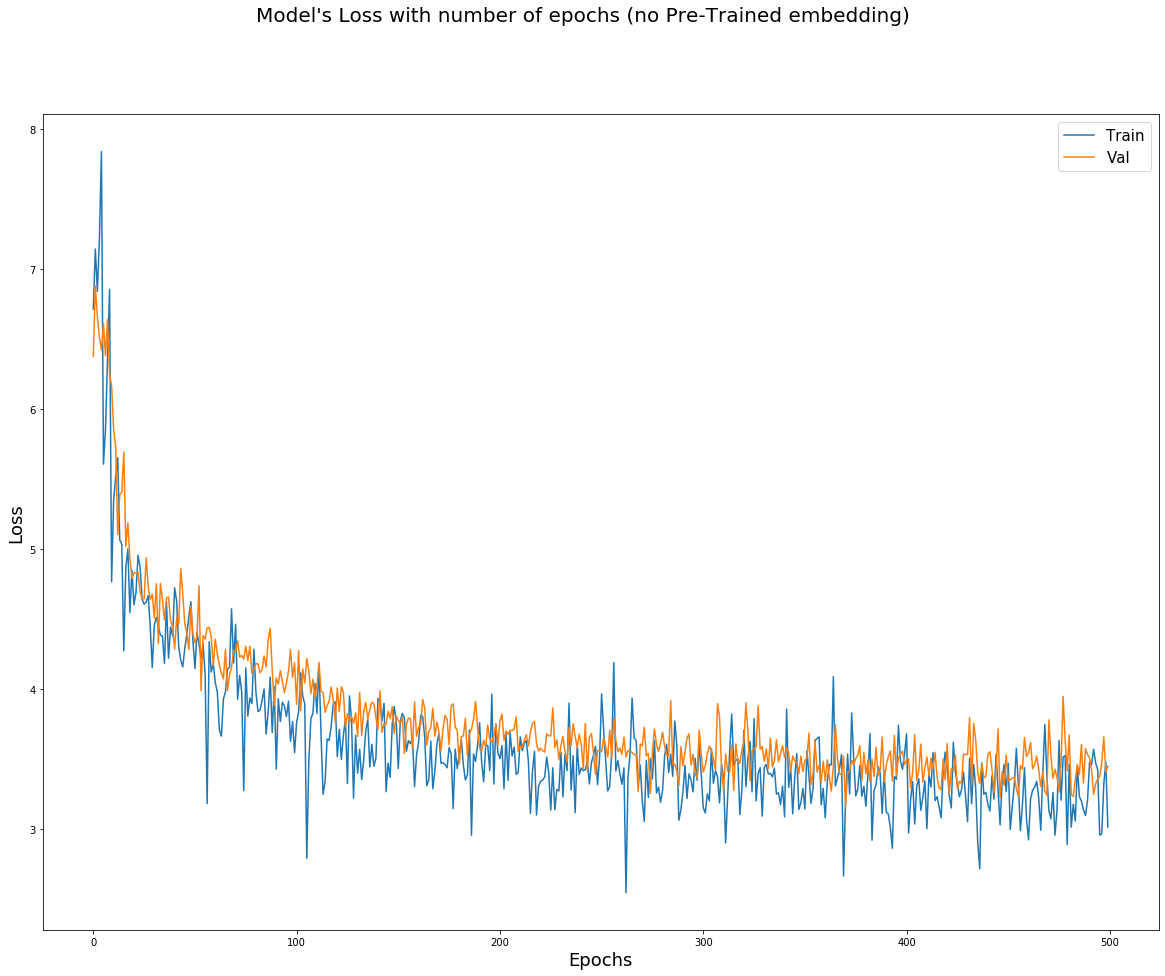

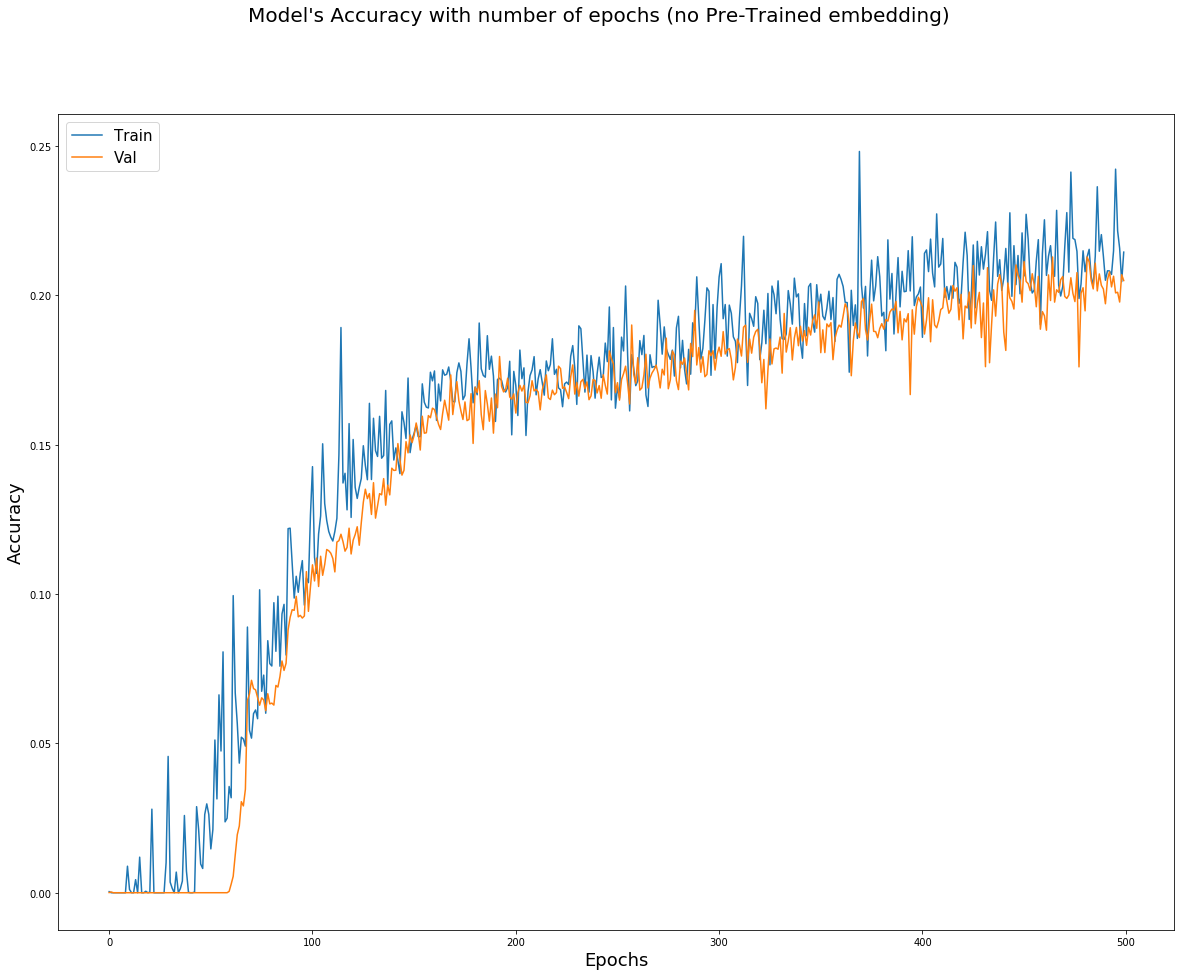

In [44]:
try:
    for round_num in tqdm(range(0, NUM_ROUNDS)):

        # Examine validation metrics
        print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} examples.')
        keras_evaluate(server_state, val_data)

        # Sample train clients to create a train dataset
        print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
        train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        
        np.save('train_accuracy_no_pt_embed.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save('val_accuracy_no_pt_embed.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
        np.save('train_loss_no_pt_embed.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save('val_loss_no_pt_embed.npy', val_metrics_tracker.get_metrics_by_name('loss'))

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Model\'s Loss with number of epochs (no Pre-Trained embedding)', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    fig.savefig('Loss_with_Epochs_noPretrainEmbed.jpg')
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Model\'s Accuracy with number of epochs (no Pre-Trained embedding)', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    fig2.savefig('Accuracy_with_Epochs_noPretrainEmbed.jpg')
    plt.show()

### Create an Iterative Process while using the pre-trained Word Embeddings (Glove)

In [47]:
iterative_process_pe = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=model_fn_with_pretrained_embedding,
          server_optimizer_fn=server_optimizer_fn,
          client_weight_fn=client_weight_fn))

### Initalize the Process
Server state will be updated in the training loop.

In [48]:
server_state_pe = iterative_process_pe.initialize()

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

  0%|          | 0/500 [00:00<?, ?it/s]

Evaluating before training round #0 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 6.8260 - num_tokens: 141581.0000 - num_tokens_no_oov: 136936.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.4126e-05 - accuracy_no_oov: 1.4605e-05 - accuracy_no_oov_no_eos: 1.5384e-05
Sampling 10 new clients.


  0%|          | 1/500 [00:55<7:43:58,  0.02it/s]

Round: 0
   Loss: 8.19131279
   num_batches: 112
   num_examples: 1708
   num_tokens: 22050
   num_tokens_no_oov: 21391
   accuracy: 0.00254
   accuracy_no_oov: 0.00262
Evaluating before training round #1 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 6.2460 - num_tokens: 128545.0000 - num_tokens_no_oov: 124437.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0023 - accuracy_no_oov: 0.0024 - accuracy_no_oov_no_eos: 0.0025
Sampling 10 new clients.


  0%|          | 2/500 [01:52<7:48:14,  0.02it/s]

Round: 1
   Loss: 7.52586555
   num_batches: 131
   num_examples: 2045
   num_tokens: 28145
   num_tokens_no_oov: 27263
   accuracy: 0.00117
   accuracy_no_oov: 0.00121
Evaluating before training round #2 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 6.5960 - num_tokens: 137145.0000 - num_tokens_no_oov: 132758.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0099 - accuracy_no_oov: 0.0103 - accuracy_no_oov_no_eos: 0.0108
Sampling 10 new clients.


  1%|          | 3/500 [02:48<7:44:28,  0.02it/s]

Round: 2
   Loss: 7.38557911
   num_batches: 114
   num_examples: 1732
   num_tokens: 24375
   num_tokens_no_oov: 23720
   accuracy: 0.00119
   accuracy_no_oov: 0.00122
Evaluating before training round #3 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 6.4137 - num_tokens: 133802.0000 - num_tokens_no_oov: 129720.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.0926e-04 - accuracy_no_oov: 2.1585e-04 - accuracy_no_oov_no_eos: 2.2870e-04
Sampling 10 new clients.


  1%|          | 4/500 [03:47<7:49:28,  0.02it/s]

Round: 3
   Loss: 6.00817108
   num_batches: 156
   num_examples: 2421
   num_tokens: 29846
   num_tokens_no_oov: 28799
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #4 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 6.1216 - num_tokens: 129080.0000 - num_tokens_no_oov: 125151.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.5494e-05 - accuracy_no_oov: 1.5981e-05 - accuracy_no_oov_no_eos: 1.7007e-05
Sampling 10 new clients.


  1%|          | 5/500 [04:49<7:57:26,  0.02it/s]

Round: 4
   Loss: 5.21551037
   num_batches: 336
   num_examples: 5301
   num_tokens: 68537
   num_tokens_no_oov: 66176
   accuracy: 0.00299
   accuracy_no_oov: 0.00310
Evaluating before training round #5 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 6.2267 - num_tokens: 135373.0000 - num_tokens_no_oov: 129461.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  1%|          | 6/500 [05:54<8:06:05,  0.02it/s]

Round: 5
   Loss: 4.64574003
   num_batches: 388
   num_examples: 6126
   num_tokens: 76193
   num_tokens_no_oov: 73731
   accuracy: 0.01238
   accuracy_no_oov: 0.01279
Evaluating before training round #6 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 5.8486 - num_tokens: 132541.0000 - num_tokens_no_oov: 128194.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00- num_tokens: 16114.0000 - num_tokens_no_oov: 15629.0000 - num_batches: 12.000
Sampling 10 new clients.


  1%|▏         | 7/500 [06:50<8:02:20,  0.02it/s]

Round: 6
   Loss: 5.55523491
   num_batches: 147
   num_examples: 2262
   num_tokens: 29789
   num_tokens_no_oov: 28855
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #7 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 5.5297 - num_tokens: 130873.0000 - num_tokens_no_oov: 126876.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 8/500 [07:54<8:05:56,  0.02it/s]

Round: 7
   Loss: 4.86932755
   num_batches: 332
   num_examples: 5240
   num_tokens: 71435
   num_tokens_no_oov: 69479
   accuracy: 0.01267
   accuracy_no_oov: 0.01303
Evaluating before training round #8 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 5.4265 - num_tokens: 134967.0000 - num_tokens_no_oov: 130060.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 9/500 [08:55<8:06:46,  0.02it/s]

Round: 8
   Loss: 4.91488981
   num_batches: 275
   num_examples: 4335
   num_tokens: 62866
   num_tokens_no_oov: 60894
   accuracy: 0.01860
   accuracy_no_oov: 0.01852
Evaluating before training round #9 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 5.1631 - num_tokens: 133758.0000 - num_tokens_no_oov: 129547.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 10/500 [09:54<8:05:34,  0.02it/s]

Round: 9
   Loss: 4.76228094
   num_batches: 185
   num_examples: 2902
   num_tokens: 38279
   num_tokens_no_oov: 37204
   accuracy: 0.00358
   accuracy_no_oov: 0.00368
Evaluating before training round #10 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 5.0078 - num_tokens: 134490.0000 - num_tokens_no_oov: 130577.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 11/500 [10:56<8:06:31,  0.02it/s]

Round: 10
   Loss: 4.49800587
   num_batches: 305
   num_examples: 4791
   num_tokens: 66032
   num_tokens_no_oov: 64013
   accuracy: 0.03144
   accuracy_no_oov: 0.03243
Evaluating before training round #11 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.8871 - num_tokens: 135355.0000 - num_tokens_no_oov: 131371.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  2%|▏         | 12/500 [11:54<8:04:07,  0.02it/s]

Round: 11
   Loss: 4.62101603
   num_batches: 146
   num_examples: 2242
   num_tokens: 29486
   num_tokens_no_oov: 28599
   accuracy: 0.00305
   accuracy_no_oov: 0.00315
Evaluating before training round #12 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.8250 - num_tokens: 135583.0000 - num_tokens_no_oov: 131544.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 13/500 [12:50<8:00:55,  0.02it/s]

Round: 12
   Loss: 4.41273022
   num_batches: 111
   num_examples: 1723
   num_tokens: 21449
   num_tokens_no_oov: 20815
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #13 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 4.6678 - num_tokens: 131249.0000 - num_tokens_no_oov: 126710.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 14/500 [13:48<7:59:10,  0.02it/s]

Round: 13
   Loss: 4.39933681
   num_batches: 143
   num_examples: 2222
   num_tokens: 29041
   num_tokens_no_oov: 28299
   accuracy: 0.00637
   accuracy_no_oov: 0.00654
Evaluating before training round #14 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.7730 - num_tokens: 135340.0000 - num_tokens_no_oov: 131217.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 15/500 [14:45<7:57:20,  0.02it/s]

Round: 14
   Loss: 4.21185493
   num_batches: 238
   num_examples: 3694
   num_tokens: 48955
   num_tokens_no_oov: 47545
   accuracy: 0.02239
   accuracy_no_oov: 0.02305
Evaluating before training round #15 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 4.5980 - num_tokens: 129171.0000 - num_tokens_no_oov: 125102.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 16/500 [15:59<8:03:30,  0.02it/s]

Round: 15
   Loss: 3.92942762
   num_batches: 438
   num_examples: 6927
   num_tokens: 91782
   num_tokens_no_oov: 89298
   accuracy: 0.07817
   accuracy_no_oov: 0.07780
Evaluating before training round #16 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.7333 - num_tokens: 131830.0000 - num_tokens_no_oov: 127600.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  3%|▎         | 17/500 [16:58<8:02:26,  0.02it/s]

Round: 16
   Loss: 4.16004229
   num_batches: 227
   num_examples: 3544
   num_tokens: 46768
   num_tokens_no_oov: 45543
   accuracy: 0.02840
   accuracy_no_oov: 0.02916
Evaluating before training round #17 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.6483 - num_tokens: 130218.0000 - num_tokens_no_oov: 126240.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▎         | 18/500 [17:51<7:58:18,  0.02it/s]

Round: 17
   Loss: 4.61286879
   num_batches: 84
   num_examples: 1266
   num_tokens: 17145
   num_tokens_no_oov: 16723
   accuracy: 0.00122
   accuracy_no_oov: 0.00126
Evaluating before training round #18 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 262ms/step - loss: 4.8461 - num_tokens: 135406.0000 - num_tokens_no_oov: 131123.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+008548 - num_tokens: 122045.0000 - num_tokens_no_oov: 118206.0000 - num_batches: 90.0000 - num_examples: 9000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos:
Sampling 10 new clients.


  4%|▍         | 19/500 [18:54<7:58:48,  0.02it/s]

Round: 18
   Loss: 4.40096521
   num_batches: 225
   num_examples: 3500
   num_tokens: 48711
   num_tokens_no_oov: 47026
   accuracy: 0.03307
   accuracy_no_oov: 0.03417
Evaluating before training round #19 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 4.6058 - num_tokens: 130050.0000 - num_tokens_no_oov: 125886.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 20/500 [19:53<7:57:24,  0.02it/s]

Round: 19
   Loss: 3.97373223
   num_batches: 155
   num_examples: 2406
   num_tokens: 29742
   num_tokens_no_oov: 28961
   accuracy: 0.02918
   accuracy_no_oov: 0.02997
Evaluating before training round #20 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.6833 - num_tokens: 132990.0000 - num_tokens_no_oov: 128666.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  4%|▍         | 21/500 [20:48<7:54:27,  0.02it/s]

Round: 20
   Loss: 4.18107605
   num_batches: 130
   num_examples: 1990
   num_tokens: 25550
   num_tokens_no_oov: 24969
   accuracy: 0.01507
   accuracy_no_oov: 0.01542
Evaluating before training round #21 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.5807 - num_tokens: 131878.0000 - num_tokens_no_oov: 127642.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+005829 - num_tokens: 110832.0000 - num_tokens_no_oov: 107181.0000 - num_batches: 84.0000 - num_examples: 8400.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_n
Sampling 10 new clients.


  4%|▍         | 22/500 [21:49<7:54:14,  0.02it/s]

Round: 21
   Loss: 4.11949682
   num_batches: 227
   num_examples: 3544
   num_tokens: 47652
   num_tokens_no_oov: 46359
   accuracy: 0.04457
   accuracy_no_oov: 0.04577
Evaluating before training round #22 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 4.6372 - num_tokens: 133957.0000 - num_tokens_no_oov: 129673.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▍         | 23/500 [22:46<7:52:22,  0.02it/s]

Round: 22
   Loss: 4.22682476
   num_batches: 214
   num_examples: 3344
   num_tokens: 44885
   num_tokens_no_oov: 43537
   accuracy: 0.04026
   accuracy_no_oov: 0.04150
Evaluating before training round #23 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.4656 - num_tokens: 130340.0000 - num_tokens_no_oov: 126433.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▍         | 24/500 [23:44<7:50:54,  0.02it/s]

Round: 23
   Loss: 4.15249920
   num_batches: 92
   num_examples: 1381
   num_tokens: 17763
   num_tokens_no_oov: 17198
   accuracy: 0.01300
   accuracy_no_oov: 0.01337
Evaluating before training round #24 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.4428 - num_tokens: 131357.0000 - num_tokens_no_oov: 127597.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▌         | 25/500 [24:39<7:48:30,  0.02it/s]

Round: 24
   Loss: 4.32016802
   num_batches: 144
   num_examples: 2233
   num_tokens: 30140
   num_tokens_no_oov: 29174
   accuracy: 0.03321
   accuracy_no_oov: 0.03417
Evaluating before training round #25 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.3390 - num_tokens: 129967.0000 - num_tokens_no_oov: 125871.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▌         | 26/500 [25:38<7:47:25,  0.02it/s]

Round: 25
   Loss: 3.93027782
   num_batches: 156
   num_examples: 2407
   num_tokens: 30551
   num_tokens_no_oov: 29855
   accuracy: 0.03898
   accuracy_no_oov: 0.03989
Evaluating before training round #26 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 4.3949 - num_tokens: 133078.0000 - num_tokens_no_oov: 129005.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 1.3526e-04 - accuracy_no_oov: 1.3953e-04 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  5%|▌         | 27/500 [26:33<7:45:12,  0.02it/s]

Round: 26
   Loss: 4.43758345
   num_batches: 146
   num_examples: 2256
   num_tokens: 31868
   num_tokens_no_oov: 30833
   accuracy: 0.04409
   accuracy_no_oov: 0.04505
Evaluating before training round #27 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.4996 - num_tokens: 136925.0000 - num_tokens_no_oov: 132570.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0263 - accuracy_no_oov: 0.0271 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 28/500 [27:33<7:44:29,  0.02it/s]

Round: 27
   Loss: 4.18726444
   num_batches: 155
   num_examples: 2390
   num_tokens: 31924
   num_tokens_no_oov: 31169
   accuracy: 0.05685
   accuracy_no_oov: 0.05823
Evaluating before training round #28 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 4.1332 - num_tokens: 127687.0000 - num_tokens_no_oov: 123586.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0494 - accuracy_no_oov: 0.0511 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 29/500 [28:29<7:42:38,  0.02it/s]

Round: 28
   Loss: 4.46584368
   num_batches: 139
   num_examples: 2154
   num_tokens: 30719
   num_tokens_no_oov: 29568
   accuracy: 0.05609
   accuracy_no_oov: 0.04877
Evaluating before training round #29 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 4.2756 - num_tokens: 132536.0000 - num_tokens_no_oov: 127665.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0503 - accuracy_no_oov: 0.0523 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 30/500 [29:25<7:41:01,  0.02it/s]

Round: 29
   Loss: 4.09044409
   num_batches: 185
   num_examples: 2883
   num_tokens: 38782
   num_tokens_no_oov: 37654
   accuracy: 0.06284
   accuracy_no_oov: 0.06472
Evaluating before training round #30 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.2339 - num_tokens: 130867.0000 - num_tokens_no_oov: 126581.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0523 - accuracy_no_oov: 0.0540 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▌         | 31/500 [30:26<7:40:35,  0.02it/s]

Round: 30
   Loss: 3.78157997
   num_batches: 164
   num_examples: 2539
   num_tokens: 31759
   num_tokens_no_oov: 30691
   accuracy: 0.06571
   accuracy_no_oov: 0.06481
Evaluating before training round #31 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 4.2081 - num_tokens: 130827.0000 - num_tokens_no_oov: 126432.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0537 - accuracy_no_oov: 0.0556 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  6%|▋         | 32/500 [31:25<7:39:28,  0.02it/s]

Round: 31
   Loss: 4.29949903
   num_batches: 221
   num_examples: 3445
   num_tokens: 48071
   num_tokens_no_oov: 46669
   accuracy: 0.06925
   accuracy_no_oov: 0.07058
Evaluating before training round #32 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 4.3264 - num_tokens: 133897.0000 - num_tokens_no_oov: 129201.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0522 - accuracy_no_oov: 0.0541 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 33/500 [32:27<7:39:20,  0.02it/s]

Round: 32
   Loss: 3.84254241
   num_batches: 164
   num_examples: 2578
   num_tokens: 33279
   num_tokens_no_oov: 32382
   accuracy: 0.09435
   accuracy_no_oov: 0.09697
Evaluating before training round #33 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 4.2429 - num_tokens: 132258.0000 - num_tokens_no_oov: 128022.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0545 - accuracy_no_oov: 0.0563 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 34/500 [33:22<7:37:32,  0.02it/s]

Round: 33
   Loss: 4.06900120
   num_batches: 166
   num_examples: 2569
   num_tokens: 34174
   num_tokens_no_oov: 33155
   accuracy: 0.07702
   accuracy_no_oov: 0.07938
Evaluating before training round #34 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 4.1794 - num_tokens: 130329.0000 - num_tokens_no_oov: 127252.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0575 - accuracy_no_oov: 0.0589 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 35/500 [34:31<7:38:35,  0.02it/s]

Round: 34
   Loss: 3.61394310
   num_batches: 492
   num_examples: 7783
   num_tokens: 101732
   num_tokens_no_oov: 98417
   accuracy: 0.11208
   accuracy_no_oov: 0.11202
Evaluating before training round #35 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.1824 - num_tokens: 130699.0000 - num_tokens_no_oov: 126362.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0583 - accuracy_no_oov: 0.0603 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 36/500 [35:32<7:38:06,  0.02it/s]

Round: 35
   Loss: 4.30897188
   num_batches: 149
   num_examples: 2292
   num_tokens: 32300
   num_tokens_no_oov: 31431
   accuracy: 0.07084
   accuracy_no_oov: 0.07279
Evaluating before training round #36 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 4.2128 - num_tokens: 131087.0000 - num_tokens_no_oov: 126926.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0556 - accuracy_no_oov: 0.0574 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  7%|▋         | 37/500 [36:30<7:36:44,  0.02it/s]

Round: 36
   Loss: 3.89182758
   num_batches: 197
   num_examples: 3054
   num_tokens: 40170
   num_tokens_no_oov: 38922
   accuracy: 0.08598
   accuracy_no_oov: 0.08866
Evaluating before training round #37 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.1954 - num_tokens: 130473.0000 - num_tokens_no_oov: 126337.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0578 - accuracy_no_oov: 0.0597 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 38/500 [37:24<7:34:42,  0.02it/s]

Round: 37
   Loss: 3.95674586
   num_batches: 122
   num_examples: 1879
   num_tokens: 24454
   num_tokens_no_oov: 23750
   accuracy: 0.07250
   accuracy_no_oov: 0.07389
Evaluating before training round #38 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 4.1933 - num_tokens: 130814.0000 - num_tokens_no_oov: 126348.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0558 - accuracy_no_oov: 0.0578 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 39/500 [38:27<7:34:41,  0.02it/s]

Round: 38
   Loss: 3.68504167
   num_batches: 204
   num_examples: 3191
   num_tokens: 39818
   num_tokens_no_oov: 38736
   accuracy: 0.09596
   accuracy_no_oov: 0.09862
Evaluating before training round #39 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 3.8688 - num_tokens: 120474.0000 - num_tokens_no_oov: 117162.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0627 - accuracy_no_oov: 0.0645 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 40/500 [39:22<7:32:48,  0.02it/s]

Round: 39
   Loss: 4.12077808
   num_batches: 128
   num_examples: 1979
   num_tokens: 26477
   num_tokens_no_oov: 25806
   accuracy: 0.07493
   accuracy_no_oov: 0.07677
Evaluating before training round #40 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.3738 - num_tokens: 134973.0000 - num_tokens_no_oov: 129207.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0516 - accuracy_no_oov: 0.0539 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 41/500 [40:22<7:32:01,  0.02it/s]

Round: 40
   Loss: 4.24596930
   num_batches: 302
   num_examples: 4773
   num_tokens: 68244
   num_tokens_no_oov: 65967
   accuracy: 0.09665
   accuracy_no_oov: 0.09574
Evaluating before training round #41 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 283ms/step - loss: 4.4328 - num_tokens: 136266.0000 - num_tokens_no_oov: 131772.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0517 - accuracy_no_oov: 0.0534 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.


  8%|▊         | 42/500 [41:40<7:34:25,  0.02it/s]

Round: 41
   Loss: 3.91772270
   num_batches: 507
   num_examples: 8041
   num_tokens: 113190
   num_tokens_no_oov: 110044
   accuracy: 0.12406
   accuracy_no_oov: 0.12359
Evaluating before training round #42 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 4.1846 - num_tokens: 130791.0000 - num_tokens_no_oov: 126539.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0582 - accuracy_no_oov: 0.0601 - accuracy_no_oov_no_eos: 6.6394e-04
Sampling 10 new clients.


  9%|▊         | 43/500 [42:34<7:32:33,  0.02it/s]

Round: 42
   Loss: 4.15919065
   num_batches: 126
   num_examples: 1945
   num_tokens: 26494
   num_tokens_no_oov: 25611
   accuracy: 0.08172
   accuracy_no_oov: 0.08297
Evaluating before training round #43 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.2833 - num_tokens: 132305.0000 - num_tokens_no_oov: 127902.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0562 - accuracy_no_oov: 0.0582 - accuracy_no_oov_no_eos: 0.0022
Sampling 10 new clients.


  9%|▉         | 44/500 [43:28<7:30:34,  0.02it/s]

Round: 43
   Loss: 4.00664043
   num_batches: 105
   num_examples: 1594
   num_tokens: 20791
   num_tokens_no_oov: 20087
   accuracy: 0.08350
   accuracy_no_oov: 0.08553
Evaluating before training round #44 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 4.1460 - num_tokens: 129380.0000 - num_tokens_no_oov: 125128.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0619 - accuracy_no_oov: 0.0640 - accuracy_no_oov_no_eos: 0.0042
Sampling 10 new clients.


  9%|▉         | 45/500 [44:33<7:30:31,  0.02it/s]

Round: 44
   Loss: 4.10390472
   num_batches: 167
   num_examples: 2620
   num_tokens: 35603
   num_tokens_no_oov: 34510
   accuracy: 0.08286
   accuracy_no_oov: 0.08241
Evaluating before training round #45 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.3334 - num_tokens: 135809.0000 - num_tokens_no_oov: 130650.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0591 - accuracy_no_oov: 0.0614 - accuracy_no_oov_no_eos: 0.0083
Sampling 10 new clients.


  9%|▉         | 46/500 [45:27<7:28:35,  0.02it/s]

Round: 45
   Loss: 4.11519623
   num_batches: 103
   num_examples: 1592
   num_tokens: 21410
   num_tokens_no_oov: 20669
   accuracy: 0.09949
   accuracy_no_oov: 0.10305
Evaluating before training round #46 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.4839 - num_tokens: 139042.0000 - num_tokens_no_oov: 134407.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0597 - accuracy_no_oov: 0.0617 - accuracy_no_oov_no_eos: 0.0122
Sampling 10 new clients.


  9%|▉         | 47/500 [46:25<7:27:27,  0.02it/s]

Round: 46
   Loss: 4.19844580
   num_batches: 229
   num_examples: 3577
   num_tokens: 50552
   num_tokens_no_oov: 49386
   accuracy: 0.09721
   accuracy_no_oov: 0.09936
Evaluating before training round #47 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.2181 - num_tokens: 130088.0000 - num_tokens_no_oov: 126122.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0701 - accuracy_no_oov: 0.0723 - accuracy_no_oov_no_eos: 0.0192
Sampling 10 new clients.


 10%|▉         | 48/500 [47:29<7:27:09,  0.02it/s]

Round: 47
   Loss: 3.97722220
   num_batches: 167
   num_examples: 2605
   num_tokens: 34557
   num_tokens_no_oov: 33440
   accuracy: 0.09709
   accuracy_no_oov: 0.09988
Evaluating before training round #48 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.3318 - num_tokens: 135582.0000 - num_tokens_no_oov: 131393.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0857 - accuracy_no_oov: 0.0884 - accuracy_no_oov_no_eos: 0.0392
Sampling 10 new clients.


 10%|▉         | 49/500 [48:33<7:26:58,  0.02it/s]

Round: 48
   Loss: 3.77631116
   num_batches: 395
   num_examples: 6251
   num_tokens: 82528
   num_tokens_no_oov: 80431
   accuracy: 0.11436
   accuracy_no_oov: 0.11712
Evaluating before training round #49 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 4.1631 - num_tokens: 131872.0000 - num_tokens_no_oov: 127767.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0989 - accuracy_no_oov: 0.1021 - accuracy_no_oov_no_eos: 0.0506
Sampling 10 new clients.


 10%|█         | 50/500 [49:33<7:26:05,  0.02it/s]

Round: 49
   Loss: 4.07172680
   num_batches: 236
   num_examples: 3691
   num_tokens: 50379
   num_tokens_no_oov: 48810
   accuracy: 0.09693
   accuracy_no_oov: 0.09320
Evaluating before training round #50 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 4.3689 - num_tokens: 138567.0000 - num_tokens_no_oov: 133329.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1037 - accuracy_no_oov: 0.1078 - accuracy_no_oov_no_eos: 0.0615
Sampling 10 new clients.


 10%|█         | 51/500 [50:32<7:25:01,  0.02it/s]

Round: 50
   Loss: 3.53307700
   num_batches: 213
   num_examples: 3332
   num_tokens: 43319
   num_tokens_no_oov: 41637
   accuracy: 0.13855
   accuracy_no_oov: 0.13687
Evaluating before training round #51 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 4.0170 - num_tokens: 127875.0000 - num_tokens_no_oov: 122768.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1006 - accuracy_no_oov: 0.1047 - accuracy_no_oov_no_eos: 0.0537
Sampling 10 new clients.


 10%|█         | 52/500 [51:40<7:25:09,  0.02it/s]

Round: 51
   Loss: 3.92331862
   num_batches: 222
   num_examples: 3485
   num_tokens: 46374
   num_tokens_no_oov: 45236
   accuracy: 0.10551
   accuracy_no_oov: 0.10817
Evaluating before training round #52 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 4.2490 - num_tokens: 134454.0000 - num_tokens_no_oov: 130535.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1027 - accuracy_no_oov: 0.1057 - accuracy_no_oov_no_eos: 0.0603
Sampling 10 new clients.


 11%|█         | 53/500 [52:53<7:26:02,  0.02it/s]

Round: 52
   Loss: 3.07263947
   num_batches: 597
   num_examples: 9478
   num_tokens: 111325
   num_tokens_no_oov: 107832
   accuracy: 0.16705
   accuracy_no_oov: 0.16445
Evaluating before training round #53 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 4.3130 - num_tokens: 136547.0000 - num_tokens_no_oov: 132698.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1054 - accuracy_no_oov: 0.1085 - accuracy_no_oov_no_eos: 0.0644
Sampling 10 new clients.


 11%|█         | 54/500 [53:47<7:24:19,  0.02it/s]

Round: 53
   Loss: 4.06454849
   num_batches: 143
   num_examples: 2227
   num_tokens: 30194
   num_tokens_no_oov: 29468
   accuracy: 0.10423
   accuracy_no_oov: 0.10652
Evaluating before training round #54 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.0863 - num_tokens: 130777.0000 - num_tokens_no_oov: 126963.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1148 - accuracy_no_oov: 0.1183 - accuracy_no_oov_no_eos: 0.0710
Sampling 10 new clients.


 11%|█         | 55/500 [54:42<7:22:41,  0.02it/s]

Round: 54
   Loss: 3.70983171
   num_batches: 143
   num_examples: 2199
   num_tokens: 27443
   num_tokens_no_oov: 26704
   accuracy: 0.11653
   accuracy_no_oov: 0.11796
Evaluating before training round #55 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 30s 296ms/step - loss: 4.2472 - num_tokens: 135865.0000 - num_tokens_no_oov: 131163.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1124 - accuracy_no_oov: 0.1165 - accuracy_no_oov_no_eos: 0.0730
Sampling 10 new clients.


 11%|█         | 56/500 [55:45<7:22:03,  0.02it/s]

Round: 55
   Loss: 3.61027145
   num_batches: 119
   num_examples: 1830
   num_tokens: 22517
   num_tokens_no_oov: 21782
   accuracy: 0.11769
   accuracy_no_oov: 0.11794
Evaluating before training round #56 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.0219 - num_tokens: 129773.0000 - num_tokens_no_oov: 125960.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1088 - accuracy_no_oov: 0.1121 - accuracy_no_oov_no_eos: 0.0647
Sampling 10 new clients.


 11%|█▏        | 57/500 [56:43<7:20:55,  0.02it/s]

Round: 56
   Loss: 4.31631613
   num_batches: 251
   num_examples: 3906
   num_tokens: 57315
   num_tokens_no_oov: 55693
   accuracy: 0.10730
   accuracy_no_oov: 0.10849
Evaluating before training round #57 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.3730 - num_tokens: 139553.0000 - num_tokens_no_oov: 134427.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1060 - accuracy_no_oov: 0.1100 - accuracy_no_oov_no_eos: 0.0681
Sampling 10 new clients.


 12%|█▏        | 58/500 [57:53<7:21:09,  0.02it/s]

Round: 57
   Loss: 3.98556781
   num_batches: 466
   num_examples: 7376
   num_tokens: 109018
   num_tokens_no_oov: 106200
   accuracy: 0.13766
   accuracy_no_oov: 0.13893
Evaluating before training round #58 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 4.1890 - num_tokens: 135748.0000 - num_tokens_no_oov: 131266.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1151 - accuracy_no_oov: 0.1190 - accuracy_no_oov_no_eos: 0.0744
Sampling 10 new clients.


 12%|█▏        | 59/500 [58:51<7:19:57,  0.02it/s]

Round: 58
   Loss: 3.52779675
   num_batches: 230
   num_examples: 3605
   num_tokens: 45240
   num_tokens_no_oov: 43752
   accuracy: 0.12856
   accuracy_no_oov: 0.12404
Evaluating before training round #59 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 4.1297 - num_tokens: 133826.0000 - num_tokens_no_oov: 129845.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1127 - accuracy_no_oov: 0.1161 - accuracy_no_oov_no_eos: 0.0713
Sampling 10 new clients.


 12%|█▏        | 60/500 [59:57<7:19:39,  0.02it/s]

Round: 59
   Loss: 3.65004063
   num_batches: 169
   num_examples: 2622
   num_tokens: 33272
   num_tokens_no_oov: 32274
   accuracy: 0.12575
   accuracy_no_oov: 0.12825
Evaluating before training round #60 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.1001 - num_tokens: 133341.0000 - num_tokens_no_oov: 128980.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1133 - accuracy_no_oov: 0.1171 - accuracy_no_oov_no_eos: 0.0716
Sampling 10 new clients.


 12%|█▏        | 61/500 [1:00:59<7:18:54,  0.02it/s]

Round: 60
   Loss: 3.76089096
   num_batches: 420
   num_examples: 6686
   num_tokens: 88685
   num_tokens_no_oov: 86149
   accuracy: 0.13365
   accuracy_no_oov: 0.13265
Evaluating before training round #61 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.9551 - num_tokens: 129805.0000 - num_tokens_no_oov: 125739.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1168 - accuracy_no_oov: 0.1206 - accuracy_no_oov_no_eos: 0.0738
Sampling 10 new clients.


 12%|█▏        | 62/500 [1:01:55<7:17:29,  0.02it/s]

Round: 61
   Loss: 3.73918581
   num_batches: 178
   num_examples: 2783
   num_tokens: 36078
   num_tokens_no_oov: 34859
   accuracy: 0.12739
   accuracy_no_oov: 0.12654
Evaluating before training round #62 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.0743 - num_tokens: 133687.0000 - num_tokens_no_oov: 129461.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1196 - accuracy_no_oov: 0.1235 - accuracy_no_oov_no_eos: 0.078241 - num_tokens: 99216.0000 - num_tokens_no_oov: 95984.0000 - num_batches: 75.0000 - num_examples: 7500.0000 - accuracy: 0.1213 - accuracy_no_oov: 0.1254 - ac
Sampling 10 new clients.


 13%|█▎        | 63/500 [1:02:51<7:16:01,  0.02it/s]

Round: 62
   Loss: 3.92183876
   num_batches: 181
   num_examples: 2837
   num_tokens: 37729
   num_tokens_no_oov: 36727
   accuracy: 0.11095
   accuracy_no_oov: 0.11199
Evaluating before training round #63 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 4.1584 - num_tokens: 136368.0000 - num_tokens_no_oov: 131737.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1225 - accuracy_no_oov: 0.1268 - accuracy_no_oov_no_eos: 0.0832
Sampling 10 new clients.


 13%|█▎        | 64/500 [1:03:54<7:15:22,  0.02it/s]

Round: 63
   Loss: 3.87218165
   num_batches: 151
   num_examples: 2325
   num_tokens: 31270
   num_tokens_no_oov: 30414
   accuracy: 0.12200
   accuracy_no_oov: 0.12461
Evaluating before training round #64 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.0543 - num_tokens: 133408.0000 - num_tokens_no_oov: 128752.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1175 - accuracy_no_oov: 0.1217 - accuracy_no_oov_no_eos: 0.0766
Sampling 10 new clients.


 13%|█▎        | 65/500 [1:04:49<7:13:47,  0.02it/s]

Round: 64
   Loss: 3.80206966
   num_batches: 137
   num_examples: 2101
   num_tokens: 27446
   num_tokens_no_oov: 26618
   accuracy: 0.12902
   accuracy_no_oov: 0.13111
Evaluating before training round #65 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 4.0422 - num_tokens: 132827.0000 - num_tokens_no_oov: 128965.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1151 - accuracy_no_oov: 0.1185 - accuracy_no_oov_no_eos: 0.0748
Sampling 10 new clients.


 13%|█▎        | 66/500 [1:05:45<7:12:24,  0.02it/s]

Round: 65
   Loss: 3.77892375
   num_batches: 169
   num_examples: 2648
   num_tokens: 35563
   num_tokens_no_oov: 34422
   accuracy: 0.13275
   accuracy_no_oov: 0.13503
Evaluating before training round #66 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.9209 - num_tokens: 129664.0000 - num_tokens_no_oov: 125623.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1192 - accuracy_no_oov: 0.1229 - accuracy_no_oov_no_eos: 0.0789
Sampling 10 new clients.


 13%|█▎        | 67/500 [1:06:40<7:10:56,  0.02it/s]

Round: 66
   Loss: 3.69665360
   num_batches: 178
   num_examples: 2768
   num_tokens: 35823
   num_tokens_no_oov: 34933
   accuracy: 0.12626
   accuracy_no_oov: 0.12888
Evaluating before training round #67 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 4.1111 - num_tokens: 135510.0000 - num_tokens_no_oov: 132188.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1200 - accuracy_no_oov: 0.1229 - accuracy_no_oov_no_eos: 0.0797
Sampling 10 new clients.


 14%|█▎        | 68/500 [1:07:37<7:09:39,  0.02it/s]

Round: 67
   Loss: 3.69101262
   num_batches: 233
   num_examples: 3650
   num_tokens: 48186
   num_tokens_no_oov: 46797
   accuracy: 0.13052
   accuracy_no_oov: 0.13097
Evaluating before training round #68 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 4.1992 - num_tokens: 138817.0000 - num_tokens_no_oov: 134570.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1142 - accuracy_no_oov: 0.1175 - accuracy_no_oov_no_eos: 0.0758
Sampling 10 new clients.


 14%|█▍        | 69/500 [1:08:53<7:10:21,  0.02it/s]

Round: 68
   Loss: 3.66651201
   num_batches: 398
   num_examples: 6296
   num_tokens: 85180
   num_tokens_no_oov: 82895
   accuracy: 0.13929
   accuracy_no_oov: 0.13741
Evaluating before training round #69 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 4.0512 - num_tokens: 134162.0000 - num_tokens_no_oov: 129914.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1217 - accuracy_no_oov: 0.1254 - accuracy_no_oov_no_eos: 0.0804
Sampling 10 new clients.


 14%|█▍        | 70/500 [1:09:48<7:08:47,  0.02it/s]

Round: 69
   Loss: 3.98786879
   num_batches: 136
   num_examples: 2110
   num_tokens: 28463
   num_tokens_no_oov: 27596
   accuracy: 0.11840
   accuracy_no_oov: 0.11665
Evaluating before training round #70 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 4.0500 - num_tokens: 134987.0000 - num_tokens_no_oov: 130573.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1200 - accuracy_no_oov: 0.1234 - accuracy_no_oov_no_eos: 0.0820
Sampling 10 new clients.


 14%|█▍        | 71/500 [1:10:50<7:08:01,  0.02it/s]

Round: 70
   Loss: 4.25366163
   num_batches: 306
   num_examples: 4810
   num_tokens: 73790
   num_tokens_no_oov: 71495
   accuracy: 0.13228
   accuracy_no_oov: 0.12797
Evaluating before training round #71 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.0683 - num_tokens: 136244.0000 - num_tokens_no_oov: 132038.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1240 - accuracy_no_oov: 0.1271 - accuracy_no_oov_no_eos: 0.0843
Sampling 10 new clients.


 14%|█▍        | 72/500 [1:11:46<7:06:40,  0.02it/s]

Round: 71
   Loss: 3.66294646
   num_batches: 194
   num_examples: 3040
   num_tokens: 40215
   num_tokens_no_oov: 39220
   accuracy: 0.13910
   accuracy_no_oov: 0.13957
Evaluating before training round #72 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.8829 - num_tokens: 130715.0000 - num_tokens_no_oov: 126441.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1290 - accuracy_no_oov: 0.1325 - accuracy_no_oov_no_eos: 0.0856
Sampling 10 new clients.


 15%|█▍        | 73/500 [1:12:40<7:05:08,  0.02it/s]

Round: 72
   Loss: 3.86191773
   num_batches: 123
   num_examples: 1929
   num_tokens: 25748
   num_tokens_no_oov: 25031
   accuracy: 0.12688
   accuracy_no_oov: 0.12780
Evaluating before training round #73 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 32s 317ms/step - loss: 3.7232 - num_tokens: 128675.0000 - num_tokens_no_oov: 125167.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1418 - accuracy_no_oov: 0.1449 - accuracy_no_oov_no_eos: 0.09167210 - num_tokens: 122244.0000 - num_tokens_no_oov: 118996.0000 - num_batches: 95.0000 - num_examples: 9500.0000 - accuracy: 0.1422 - accuracy_no_oov: 0.1453 - accuracy_no_oov_no_eos: 
Sampling 10 new clients.


 15%|█▍        | 74/500 [1:13:45<7:04:34,  0.02it/s]

Round: 73
   Loss: 3.82004476
   num_batches: 120
   num_examples: 1822
   num_tokens: 24184
   num_tokens_no_oov: 23514
   accuracy: 0.12922
   accuracy_no_oov: 0.12937
Evaluating before training round #74 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.7676 - num_tokens: 127702.0000 - num_tokens_no_oov: 123685.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1307 - accuracy_no_oov: 0.1336 - accuracy_no_oov_no_eos: 0.0879
Sampling 10 new clients.


 15%|█▌        | 75/500 [1:14:40<7:03:09,  0.02it/s]

Round: 74
   Loss: 3.63949013
   num_batches: 166
   num_examples: 2584
   num_tokens: 33934
   num_tokens_no_oov: 33089
   accuracy: 0.13317
   accuracy_no_oov: 0.13476
Evaluating before training round #75 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.8752 - num_tokens: 130908.0000 - num_tokens_no_oov: 127080.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1306 - accuracy_no_oov: 0.1331 - accuracy_no_oov_no_eos: 0.0876
Sampling 10 new clients.


 15%|█▌        | 76/500 [1:15:36<7:01:48,  0.02it/s]

Round: 75
   Loss: 3.71280766
   num_batches: 160
   num_examples: 2484
   num_tokens: 32288
   num_tokens_no_oov: 31217
   accuracy: 0.13788
   accuracy_no_oov: 0.13589
Evaluating before training round #76 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.9941 - num_tokens: 135409.0000 - num_tokens_no_oov: 131023.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1304 - accuracy_no_oov: 0.1325 - accuracy_no_oov_no_eos: 0.0900
Sampling 10 new clients.


 15%|█▌        | 77/500 [1:16:32<7:00:28,  0.02it/s]

Round: 76
   Loss: 3.64680028
   num_batches: 181
   num_examples: 2826
   num_tokens: 37324
   num_tokens_no_oov: 36374
   accuracy: 0.14061
   accuracy_no_oov: 0.14073
Evaluating before training round #77 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.9521 - num_tokens: 132865.0000 - num_tokens_no_oov: 128661.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1270 - accuracy_no_oov: 0.1291 - accuracy_no_oov_no_eos: 0.0871
Sampling 10 new clients.


 16%|█▌        | 78/500 [1:17:34<6:59:42,  0.02it/s]

Round: 77
   Loss: 3.84712744
   num_batches: 335
   num_examples: 5290
   num_tokens: 73303
   num_tokens_no_oov: 71137
   accuracy: 0.14413
   accuracy_no_oov: 0.14156
Evaluating before training round #78 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.8919 - num_tokens: 133189.0000 - num_tokens_no_oov: 128917.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1381 - accuracy_no_oov: 0.1400 - accuracy_no_oov_no_eos: 0.0957
Sampling 10 new clients.


 16%|█▌        | 79/500 [1:18:42<6:59:26,  0.02it/s]

Round: 78
   Loss: 3.52776289
   num_batches: 199
   num_examples: 3108
   num_tokens: 39436
   num_tokens_no_oov: 38412
   accuracy: 0.14451
   accuracy_no_oov: 0.14433
Evaluating before training round #79 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 207ms/step - loss: 3.5913 - num_tokens: 123048.0000 - num_tokens_no_oov: 118856.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1211 - accuracy_no_oov: 0.1223 - accuracy_no_oov_no_eos: 0.0747
Sampling 10 new clients.


 16%|█▌        | 80/500 [1:19:36<6:57:59,  0.02it/s]

Round: 79
   Loss: 3.72975683
   num_batches: 155
   num_examples: 2407
   num_tokens: 31788
   num_tokens_no_oov: 30880
   accuracy: 0.14773
   accuracy_no_oov: 0.14722
Evaluating before training round #80 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 3.9546 - num_tokens: 134309.0000 - num_tokens_no_oov: 129716.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1336 - accuracy_no_oov: 0.1334 - accuracy_no_oov_no_eos: 0.0904
Sampling 10 new clients.


 16%|█▌        | 81/500 [1:20:38<6:57:11,  0.02it/s]

Round: 80
   Loss: 3.17357779
   num_batches: 376
   num_examples: 5929
   num_tokens: 71089
   num_tokens_no_oov: 69077
   accuracy: 0.16298
   accuracy_no_oov: 0.16110
Evaluating before training round #81 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.8010 - num_tokens: 129116.0000 - num_tokens_no_oov: 124962.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1357 - accuracy_no_oov: 0.1356 - accuracy_no_oov_no_eos: 0.091742 - num_tokens: 59725.0000 - num_tokens_no_oov: 57881.0000 - num_batches: 46.0000 - num_examples: 4600.0000 - accuracy: 0.1395 
Sampling 10 new clients.


 16%|█▋        | 82/500 [1:21:33<6:55:44,  0.02it/s]

Round: 81
   Loss: 3.68540287
   num_batches: 138
   num_examples: 2113
   num_tokens: 27335
   num_tokens_no_oov: 26348
   accuracy: 0.14169
   accuracy_no_oov: 0.13599
Evaluating before training round #82 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.8731 - num_tokens: 132243.0000 - num_tokens_no_oov: 127219.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1398 - accuracy_no_oov: 0.1398 - accuracy_no_oov_no_eos: 0.0954
Sampling 10 new clients.


 17%|█▋        | 83/500 [1:22:30<6:54:31,  0.02it/s]

Round: 82
   Loss: 3.57363129
   num_batches: 214
   num_examples: 3355
   num_tokens: 43170
   num_tokens_no_oov: 42029
   accuracy: 0.13866
   accuracy_no_oov: 0.13691
Evaluating before training round #83 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.9149 - num_tokens: 133666.0000 - num_tokens_no_oov: 129296.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1426 - accuracy_no_oov: 0.1417 - accuracy_no_oov_no_eos: 0.0991
Sampling 10 new clients.


 17%|█▋        | 84/500 [1:23:47<6:54:56,  0.02it/s]

Round: 83
   Loss: 3.74062490
   num_batches: 418
   num_examples: 6606
   num_tokens: 90132
   num_tokens_no_oov: 86641
   accuracy: 0.15093
   accuracy_no_oov: 0.14120
Evaluating before training round #84 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 4.0454 - num_tokens: 136824.0000 - num_tokens_no_oov: 132792.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1339 - accuracy_no_oov: 0.1315 - accuracy_no_oov_no_eos: 0.0891
Sampling 10 new clients.


 17%|█▋        | 85/500 [1:24:41<6:53:28,  0.02it/s]

Round: 84
   Loss: 3.66571951
   num_batches: 93
   num_examples: 1413
   num_tokens: 18447
   num_tokens_no_oov: 18037
   accuracy: 0.14062
   accuracy_no_oov: 0.14188
Evaluating before training round #85 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.9644 - num_tokens: 135553.0000 - num_tokens_no_oov: 131248.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1400 - accuracy_no_oov: 0.1368 - accuracy_no_oov_no_eos: 0.0946
Sampling 10 new clients.


 17%|█▋        | 86/500 [1:25:44<6:52:47,  0.02it/s]

Round: 85
   Loss: 3.95476937
   num_batches: 341
   num_examples: 5382
   num_tokens: 79049
   num_tokens_no_oov: 76333
   accuracy: 0.14845
   accuracy_no_oov: 0.14445
Evaluating before training round #86 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.7997 - num_tokens: 130044.0000 - num_tokens_no_oov: 125989.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1389 - accuracy_no_oov: 0.1361 - accuracy_no_oov_no_eos: 0.0912
Sampling 10 new clients.


 17%|█▋        | 87/500 [1:26:54<6:52:31,  0.02it/s]

Round: 86
   Loss: 3.71403885
   num_batches: 451
   num_examples: 7139
   num_tokens: 98729
   num_tokens_no_oov: 96690
   accuracy: 0.14879
   accuracy_no_oov: 0.14869
Evaluating before training round #87 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.7690 - num_tokens: 128934.0000 - num_tokens_no_oov: 124801.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1392 - accuracy_no_oov: 0.1356 - accuracy_no_oov_no_eos: 0.0936
Sampling 10 new clients.


 18%|█▊        | 88/500 [1:27:54<6:51:33,  0.02it/s]

Round: 87
   Loss: 3.21219635
   num_batches: 223
   num_examples: 3533
   num_tokens: 44981
   num_tokens_no_oov: 43973
   accuracy: 0.18248
   accuracy_no_oov: 0.18314
Evaluating before training round #88 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.7889 - num_tokens: 129755.0000 - num_tokens_no_oov: 125924.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1413 - accuracy_no_oov: 0.1376 - accuracy_no_oov_no_eos: 0.094002 - num_tokens: 91018.0000 - num_tokens_no_oov: 88321.0000 - num_batches: 71.0000 - num_examples: 7100.0000 - accuracy: 0.1411 - accuracy_no_oov: 0.1376
Sampling 10 new clients.


 18%|█▊        | 89/500 [1:28:51<6:50:21,  0.02it/s]

Round: 88
   Loss: 3.52919602
   num_batches: 238
   num_examples: 3729
   num_tokens: 49122
   num_tokens_no_oov: 47679
   accuracy: 0.15236
   accuracy_no_oov: 0.14942
Evaluating before training round #89 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.6839 - num_tokens: 127819.0000 - num_tokens_no_oov: 123626.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1496 - accuracy_no_oov: 0.1459 - accuracy_no_oov_no_eos: 0.0992
Sampling 10 new clients.


 18%|█▊        | 90/500 [1:29:58<6:49:55,  0.02it/s]

Round: 89
   Loss: 3.88426733
   num_batches: 92
   num_examples: 1403
   num_tokens: 19361
   num_tokens_no_oov: 18915
   accuracy: 0.14591
   accuracy_no_oov: 0.14449
Evaluating before training round #90 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 4.0306 - num_tokens: 137093.0000 - num_tokens_no_oov: 132518.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1372 - accuracy_no_oov: 0.1314 - accuracy_no_oov_no_eos: 0.0889
Sampling 10 new clients.


 18%|█▊        | 91/500 [1:30:54<6:48:35,  0.02it/s]

Round: 90
   Loss: 3.57600856
   num_batches: 174
   num_examples: 2703
   num_tokens: 34681
   num_tokens_no_oov: 33604
   accuracy: 0.14483
   accuracy_no_oov: 0.13841
Evaluating before training round #91 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.7543 - num_tokens: 130106.0000 - num_tokens_no_oov: 126115.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1501 - accuracy_no_oov: 0.1460 - accuracy_no_oov_no_eos: 0.0994
Sampling 10 new clients.


 18%|█▊        | 92/500 [1:31:52<6:47:25,  0.02it/s]

Round: 91
   Loss: 3.53939891
   num_batches: 213
   num_examples: 3310
   num_tokens: 42915
   num_tokens_no_oov: 41647
   accuracy: 0.15328
   accuracy_no_oov: 0.14858
Evaluating before training round #92 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.8703 - num_tokens: 133972.0000 - num_tokens_no_oov: 129665.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1442 - accuracy_no_oov: 0.1396 - accuracy_no_oov_no_eos: 0.0965
Sampling 10 new clients.


 19%|█▊        | 93/500 [1:33:01<6:47:05,  0.02it/s]

Round: 92
   Loss: 3.96118474
   num_batches: 475
   num_examples: 7523
   num_tokens: 112020
   num_tokens_no_oov: 108787
   accuracy: 0.15863
   accuracy_no_oov: 0.15443
Evaluating before training round #93 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 3.7292 - num_tokens: 130131.0000 - num_tokens_no_oov: 126612.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1567 - accuracy_no_oov: 0.1511 - accuracy_no_oov_no_eos: 0.1083
Sampling 10 new clients.


 19%|█▉        | 94/500 [1:33:55<6:45:39,  0.02it/s]

Round: 93
   Loss: 3.70238256
   num_batches: 138
   num_examples: 2135
   num_tokens: 28926
   num_tokens_no_oov: 27934
   accuracy: 0.15398
   accuracy_no_oov: 0.14806
Evaluating before training round #94 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8916 - num_tokens: 134331.0000 - num_tokens_no_oov: 130096.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1443 - accuracy_no_oov: 0.1385 - accuracy_no_oov_no_eos: 0.0984
Sampling 10 new clients.


 19%|█▉        | 95/500 [1:35:05<6:45:24,  0.02it/s]

Round: 94
   Loss: 3.42603040
   num_batches: 520
   num_examples: 8221
   num_tokens: 114123
   num_tokens_no_oov: 110928
   accuracy: 0.18171
   accuracy_no_oov: 0.18153
Evaluating before training round #95 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.6950 - num_tokens: 128190.0000 - num_tokens_no_oov: 124318.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1545 - accuracy_no_oov: 0.1504 - accuracy_no_oov_no_eos: 0.1030- num_tokens: 41109.0000 - num_tokens_no_oov: 39959.0000 - num_batches: 32.0000 - num_examples: 3200.0000 -
Sampling 10 new clients.


 19%|█▉        | 96/500 [1:36:02<6:44:09,  0.02it/s]

Round: 95
   Loss: 3.50599575
   num_batches: 169
   num_examples: 2621
   num_tokens: 34210
   num_tokens_no_oov: 33128
   accuracy: 0.16557
   accuracy_no_oov: 0.15887
Evaluating before training round #96 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 37s 366ms/step - loss: 3.7051 - num_tokens: 128991.0000 - num_tokens_no_oov: 124764.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1530 - accuracy_no_oov: 0.1483 - accuracy_no_oov_no_eos: 0.1041
Sampling 10 new clients.


 19%|█▉        | 97/500 [1:37:11<6:43:48,  0.02it/s]

Round: 96
   Loss: 3.67662358
   num_batches: 126
   num_examples: 1965
   num_tokens: 25857
   num_tokens_no_oov: 25120
   accuracy: 0.14812
   accuracy_no_oov: 0.14244
Evaluating before training round #97 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 4.1480 - num_tokens: 141036.0000 - num_tokens_no_oov: 136727.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1347 - accuracy_no_oov: 0.1298 - accuracy_no_oov_no_eos: 0.0917
Sampling 10 new clients.


 20%|█▉        | 98/500 [1:38:06<6:42:28,  0.02it/s]

Round: 97
   Loss: 3.82019711
   num_batches: 136
   num_examples: 2119
   num_tokens: 28837
   num_tokens_no_oov: 28013
   accuracy: 0.14752
   accuracy_no_oov: 0.14233
Evaluating before training round #98 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8284 - num_tokens: 132623.0000 - num_tokens_no_oov: 128718.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1458 - accuracy_no_oov: 0.1404 - accuracy_no_oov_no_eos: 0.0991
Sampling 10 new clients.


 20%|█▉        | 99/500 [1:39:12<6:41:50,  0.02it/s]

Round: 98
   Loss: 3.75591826
   num_batches: 424
   num_examples: 6703
   num_tokens: 95841
   num_tokens_no_oov: 93393
   accuracy: 0.15950
   accuracy_no_oov: 0.15564
Evaluating before training round #99 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.8086 - num_tokens: 132522.0000 - num_tokens_no_oov: 128517.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1505 - accuracy_no_oov: 0.1449 - accuracy_no_oov_no_eos: 0.1022
Sampling 10 new clients.


 20%|██        | 100/500 [1:40:05<6:40:23,  0.02it/s]

Round: 99
   Loss: 3.75193644
   num_batches: 103
   num_examples: 1574
   num_tokens: 20834
   num_tokens_no_oov: 20285
   accuracy: 0.13742
   accuracy_no_oov: 0.13291
Evaluating before training round #100 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.7534 - num_tokens: 130478.0000 - num_tokens_no_oov: 126703.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1479 - accuracy_no_oov: 0.1431 - accuracy_no_oov_no_eos: 0.1004
Sampling 10 new clients.


 20%|██        | 101/500 [1:41:15<6:40:00,  0.02it/s]

Round: 100
   Loss: 4.10787916
   num_batches: 465
   num_examples: 7348
   num_tokens: 113078
   num_tokens_no_oov: 110147
   accuracy: 0.14977
   accuracy_no_oov: 0.14614
Evaluating before training round #101 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.7372 - num_tokens: 130736.0000 - num_tokens_no_oov: 126816.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1507 - accuracy_no_oov: 0.1449 - accuracy_no_oov_no_eos: 0.0994
Sampling 10 new clients.


 20%|██        | 102/500 [1:42:17<6:39:08,  0.02it/s]

Round: 101
   Loss: 3.28829765
   num_batches: 322
   num_examples: 5085
   num_tokens: 63941
   num_tokens_no_oov: 61962
   accuracy: 0.17261
   accuracy_no_oov: 0.16673
Evaluating before training round #102 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.7965 - num_tokens: 133634.0000 - num_tokens_no_oov: 129974.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1538 - accuracy_no_oov: 0.1478 - accuracy_no_oov_no_eos: 0.1031
Sampling 10 new clients.


 21%|██        | 103/500 [1:43:26<6:38:43,  0.02it/s]

Round: 102
   Loss: 3.50018597
   num_batches: 105
   num_examples: 1630
   num_tokens: 21067
   num_tokens_no_oov: 20450
   accuracy: 0.15816
   accuracy_no_oov: 0.15267
Evaluating before training round #103 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.9026 - num_tokens: 136508.0000 - num_tokens_no_oov: 132091.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1472 - accuracy_no_oov: 0.1406 - accuracy_no_oov_no_eos: 0.1024
Sampling 10 new clients.


 21%|██        | 104/500 [1:44:22<6:37:27,  0.02it/s]

Round: 103
   Loss: 3.56017447
   num_batches: 166
   num_examples: 2593
   num_tokens: 33805
   num_tokens_no_oov: 32779
   accuracy: 0.15311
   accuracy_no_oov: 0.14762
Evaluating before training round #104 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.7467 - num_tokens: 132555.0000 - num_tokens_no_oov: 128358.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1586 - accuracy_no_oov: 0.1526 - accuracy_no_oov_no_eos: 0.1090
Sampling 10 new clients.


 21%|██        | 105/500 [1:45:16<6:36:02,  0.02it/s]

Round: 104
   Loss: 3.49704885
   num_batches: 92
   num_examples: 1392
   num_tokens: 17912
   num_tokens_no_oov: 17442
   accuracy: 0.16218
   accuracy_no_oov: 0.15835
Evaluating before training round #105 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.6786 - num_tokens: 130655.0000 - num_tokens_no_oov: 126538.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1619 - accuracy_no_oov: 0.1561 - accuracy_no_oov_no_eos: 0.1126
Sampling 10 new clients.


 21%|██        | 106/500 [1:46:12<6:34:46,  0.02it/s]

Round: 105
   Loss: 3.59757042
   num_batches: 167
   num_examples: 2594
   num_tokens: 34694
   num_tokens_no_oov: 33776
   accuracy: 0.15216
   accuracy_no_oov: 0.14718
Evaluating before training round #106 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.8091 - num_tokens: 134520.0000 - num_tokens_no_oov: 129983.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1600 - accuracy_no_oov: 0.1521 - accuracy_no_oov_no_eos: 0.1114
Sampling 10 new clients.


 21%|██▏       | 107/500 [1:47:08<6:33:31,  0.02it/s]

Round: 106
   Loss: 3.64240456
   num_batches: 152
   num_examples: 2362
   num_tokens: 31723
   num_tokens_no_oov: 30842
   accuracy: 0.16606
   accuracy_no_oov: 0.16228
Evaluating before training round #107 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6926 - num_tokens: 131231.0000 - num_tokens_no_oov: 127317.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1534 - accuracy_no_oov: 0.1476 - accuracy_no_oov_no_eos: 0.1070
Sampling 10 new clients.


 22%|██▏       | 108/500 [1:48:16<6:33:00,  0.02it/s]

Round: 107
   Loss: 3.23278666
   num_batches: 381
   num_examples: 6022
   num_tokens: 77168
   num_tokens_no_oov: 74177
   accuracy: 0.17803
   accuracy_no_oov: 0.17182
Evaluating before training round #108 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 206ms/step - loss: 3.6506 - num_tokens: 127628.0000 - num_tokens_no_oov: 122943.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1500 - accuracy_no_oov: 0.1449 - accuracy_no_oov_no_eos: 0.1029
Sampling 10 new clients.


 22%|██▏       | 109/500 [1:49:19<6:32:08,  0.02it/s]

Round: 108
   Loss: 3.84571600
   num_batches: 326
   num_examples: 5139
   num_tokens: 75781
   num_tokens_no_oov: 73822
   accuracy: 0.17079
   accuracy_no_oov: 0.16551
Evaluating before training round #109 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.7947 - num_tokens: 134055.0000 - num_tokens_no_oov: 130191.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1594 - accuracy_no_oov: 0.1530 - accuracy_no_oov_no_eos: 0.1088
Sampling 10 new clients.


 22%|██▏       | 110/500 [1:50:36<6:32:10,  0.02it/s]

Round: 109
   Loss: 2.59772301
   num_batches: 266
   num_examples: 4163
   num_tokens: 45332
   num_tokens_no_oov: 44141
   accuracy: 0.22296
   accuracy_no_oov: 0.21850
Evaluating before training round #110 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.7536 - num_tokens: 133378.0000 - num_tokens_no_oov: 128979.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1599 - accuracy_no_oov: 0.1525 - accuracy_no_oov_no_eos: 0.1091
Sampling 10 new clients.


 22%|██▏       | 111/500 [1:51:31<6:30:51,  0.02it/s]

Round: 110
   Loss: 3.48224616
   num_batches: 121
   num_examples: 1862
   num_tokens: 24604
   num_tokens_no_oov: 23875
   accuracy: 0.17546
   accuracy_no_oov: 0.17164
Evaluating before training round #111 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.7189 - num_tokens: 130917.0000 - num_tokens_no_oov: 126880.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1539 - accuracy_no_oov: 0.1477 - accuracy_no_oov_no_eos: 0.1074
Sampling 10 new clients.


 22%|██▏       | 112/500 [1:52:26<6:29:32,  0.02it/s]

Round: 111
   Loss: 3.66792393
   num_batches: 152
   num_examples: 2348
   num_tokens: 32215
   num_tokens_no_oov: 31223
   accuracy: 0.16179
   accuracy_no_oov: 0.15428
Evaluating before training round #112 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.5475 - num_tokens: 126837.0000 - num_tokens_no_oov: 123490.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1565 - accuracy_no_oov: 0.1519 - accuracy_no_oov_no_eos: 0.1058
Sampling 10 new clients.


 23%|██▎       | 113/500 [1:53:32<6:28:50,  0.02it/s]

Round: 112
   Loss: 3.88759017
   num_batches: 334
   num_examples: 5280
   num_tokens: 75086
   num_tokens_no_oov: 73257
   accuracy: 0.15312
   accuracy_no_oov: 0.14972
Evaluating before training round #113 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.7801 - num_tokens: 134433.0000 - num_tokens_no_oov: 130089.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1574 - accuracy_no_oov: 0.1506 - accuracy_no_oov_no_eos: 0.1114
Sampling 10 new clients.


 23%|██▎       | 114/500 [1:54:31<6:27:47,  0.02it/s]

Round: 113
   Loss: 3.30946541
   num_batches: 315
   num_examples: 4956
   num_tokens: 63989
   num_tokens_no_oov: 62432
   accuracy: 0.17806
   accuracy_no_oov: 0.17409
Evaluating before training round #114 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.6525 - num_tokens: 131256.0000 - num_tokens_no_oov: 126964.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1627 - accuracy_no_oov: 0.1553 - accuracy_no_oov_no_eos: 0.1104
Sampling 10 new clients.


 23%|██▎       | 115/500 [1:55:34<6:26:56,  0.02it/s]

Round: 114
   Loss: 3.52327132
   num_batches: 384
   num_examples: 6076
   num_tokens: 80679
   num_tokens_no_oov: 78409
   accuracy: 0.17045
   accuracy_no_oov: 0.16743
Evaluating before training round #115 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.7896 - num_tokens: 134064.0000 - num_tokens_no_oov: 129914.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1489 - accuracy_no_oov: 0.1425 - accuracy_no_oov_no_eos: 0.1026
Sampling 10 new clients.


 23%|██▎       | 116/500 [1:56:47<6:26:38,  0.02it/s]

Round: 115
   Loss: 3.54314208
   num_batches: 617
   num_examples: 9807
   num_tokens: 135705
   num_tokens_no_oov: 131200
   accuracy: 0.17214
   accuracy_no_oov: 0.16521
Evaluating before training round #116 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.6371 - num_tokens: 130049.0000 - num_tokens_no_oov: 125278.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1526 - accuracy_no_oov: 0.1443 - accuracy_no_oov_no_eos: 0.1053
Sampling 10 new clients.


 23%|██▎       | 117/500 [1:57:57<6:26:08,  0.02it/s]

Round: 116
   Loss: 3.22337389
   num_batches: 491
   num_examples: 7760
   num_tokens: 96909
   num_tokens_no_oov: 94469
   accuracy: 0.16971
   accuracy_no_oov: 0.16605
Evaluating before training round #117 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.7418 - num_tokens: 133785.0000 - num_tokens_no_oov: 129479.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1581 - accuracy_no_oov: 0.1515 - accuracy_no_oov_no_eos: 0.1113
Sampling 10 new clients.


 24%|██▎       | 118/500 [1:59:10<6:25:48,  0.02it/s]

Round: 117
   Loss: 3.58920312
   num_batches: 206
   num_examples: 3192
   num_tokens: 44238
   num_tokens_no_oov: 42845
   accuracy: 0.17230
   accuracy_no_oov: 0.16779
Evaluating before training round #118 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.7021 - num_tokens: 132202.0000 - num_tokens_no_oov: 128210.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1611 - accuracy_no_oov: 0.1551 - accuracy_no_oov_no_eos: 0.1148
Sampling 10 new clients.


 24%|██▍       | 119/500 [2:00:08<6:24:38,  0.02it/s]

Round: 118
   Loss: 3.43593931
   num_batches: 157
   num_examples: 2429
   num_tokens: 31402
   num_tokens_no_oov: 30616
   accuracy: 0.16782
   accuracy_no_oov: 0.16380
Evaluating before training round #119 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.8335 - num_tokens: 137496.0000 - num_tokens_no_oov: 133022.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1578 - accuracy_no_oov: 0.1501 - accuracy_no_oov_no_eos: 0.1111
Sampling 10 new clients.


 24%|██▍       | 120/500 [2:01:06<6:23:31,  0.02it/s]

Round: 119
   Loss: 3.70060897
   num_batches: 190
   num_examples: 2975
   num_tokens: 41571
   num_tokens_no_oov: 40428
   accuracy: 0.16764
   accuracy_no_oov: 0.16236
Evaluating before training round #120 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.7332 - num_tokens: 134079.0000 - num_tokens_no_oov: 129801.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1554 - accuracy_no_oov: 0.1502 - accuracy_no_oov_no_eos: 0.1086
Sampling 10 new clients.


 24%|██▍       | 121/500 [2:02:17<6:23:03,  0.02it/s]

Round: 120
   Loss: 3.66776776
   num_batches: 456
   num_examples: 7217
   num_tokens: 102199
   num_tokens_no_oov: 99845
   accuracy: 0.17114
   accuracy_no_oov: 0.16895
Evaluating before training round #121 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.7356 - num_tokens: 134661.0000 - num_tokens_no_oov: 130280.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1623 - accuracy_no_oov: 0.1562 - accuracy_no_oov_no_eos: 0.1164
Sampling 10 new clients.


 24%|██▍       | 122/500 [2:03:18<6:22:02,  0.02it/s]

Round: 121
   Loss: 3.28259635
   num_batches: 299
   num_examples: 4691
   num_tokens: 61634
   num_tokens_no_oov: 59856
   accuracy: 0.18660
   accuracy_no_oov: 0.18182
Evaluating before training round #122 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 3.7731 - num_tokens: 136187.0000 - num_tokens_no_oov: 131512.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1615 - accuracy_no_oov: 0.1544 - accuracy_no_oov_no_eos: 0.1135
Sampling 10 new clients.


 25%|██▍       | 123/500 [2:04:11<6:20:40,  0.02it/s]

Round: 122
   Loss: 3.49329710
   num_batches: 122
   num_examples: 1897
   num_tokens: 24736
   num_tokens_no_oov: 23968
   accuracy: 0.17311
   accuracy_no_oov: 0.16597
Evaluating before training round #123 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 205ms/step - loss: 3.3579 - num_tokens: 121329.0000 - num_tokens_no_oov: 117788.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1667 - accuracy_no_oov: 0.1606 - accuracy_no_oov_no_eos: 0.1098
Sampling 10 new clients.


 25%|██▍       | 124/500 [2:05:09<6:19:31,  0.02it/s]

Round: 123
   Loss: 3.26991606
   num_batches: 249
   num_examples: 3905
   num_tokens: 49175
   num_tokens_no_oov: 47824
   accuracy: 0.18217
   accuracy_no_oov: 0.17882
Evaluating before training round #124 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.5810 - num_tokens: 129578.0000 - num_tokens_no_oov: 125559.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1650 - accuracy_no_oov: 0.1588 - accuracy_no_oov_no_eos: 0.1150
Sampling 10 new clients.


 25%|██▌       | 125/500 [2:06:05<6:18:15,  0.02it/s]

Round: 124
   Loss: 3.61730027
   num_batches: 133
   num_examples: 2094
   num_tokens: 28029
   num_tokens_no_oov: 27244
   accuracy: 0.16558
   accuracy_no_oov: 0.15967
Evaluating before training round #125 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.5754 - num_tokens: 129636.0000 - num_tokens_no_oov: 125525.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1653 - accuracy_no_oov: 0.1598 - accuracy_no_oov_no_eos: 0.1180
Sampling 10 new clients.


 25%|██▌       | 126/500 [2:07:19<6:17:56,  0.02it/s]

Round: 125
   Loss: 3.71336913
   num_batches: 248
   num_examples: 3919
   num_tokens: 54725
   num_tokens_no_oov: 53254
   accuracy: 0.17617
   accuracy_no_oov: 0.17054
Evaluating before training round #126 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.5817 - num_tokens: 130824.0000 - num_tokens_no_oov: 127361.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1726 - accuracy_no_oov: 0.1679 - accuracy_no_oov_no_eos: 0.1267
Sampling 10 new clients.


 25%|██▌       | 127/500 [2:08:13<6:16:36,  0.02it/s]

Round: 126
   Loss: 3.58708858
   num_batches: 114
   num_examples: 1717
   num_tokens: 23062
   num_tokens_no_oov: 22394
   accuracy: 0.17631
   accuracy_no_oov: 0.17094
Evaluating before training round #127 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.7544 - num_tokens: 135888.0000 - num_tokens_no_oov: 131620.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1679 - accuracy_no_oov: 0.1625 - accuracy_no_oov_no_eos: 0.1220
Sampling 10 new clients.


 26%|██▌       | 128/500 [2:09:10<6:15:25,  0.02it/s]

Round: 127
   Loss: 3.25783038
   num_batches: 191
   num_examples: 3009
   num_tokens: 37867
   num_tokens_no_oov: 36774
   accuracy: 0.17939
   accuracy_no_oov: 0.17398
Evaluating before training round #128 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.6052 - num_tokens: 130746.0000 - num_tokens_no_oov: 126327.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1714 - accuracy_no_oov: 0.1657 - accuracy_no_oov_no_eos: 0.1232
Sampling 10 new clients.


 26%|██▌       | 129/500 [2:10:07<6:14:14,  0.02it/s]

Round: 128
   Loss: 3.43298221
   num_batches: 202
   num_examples: 3152
   num_tokens: 41555
   num_tokens_no_oov: 40587
   accuracy: 0.17536
   accuracy_no_oov: 0.17220
Evaluating before training round #129 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.6607 - num_tokens: 132881.0000 - num_tokens_no_oov: 128670.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1744 - accuracy_no_oov: 0.1679 - accuracy_no_oov_no_eos: 0.1238
Sampling 10 new clients.


 26%|██▌       | 130/500 [2:11:01<6:12:55,  0.02it/s]

Round: 129
   Loss: 3.19960332
   num_batches: 108
   num_examples: 1624
   num_tokens: 19534
   num_tokens_no_oov: 18996
   accuracy: 0.17549
   accuracy_no_oov: 0.17151
Evaluating before training round #130 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.5860 - num_tokens: 131869.0000 - num_tokens_no_oov: 128253.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1691 - accuracy_no_oov: 0.1645 - accuracy_no_oov_no_eos: 0.1201
Sampling 10 new clients.


 26%|██▌       | 131/500 [2:11:59<6:11:48,  0.02it/s]

Round: 130
   Loss: 3.66907501
   num_batches: 226
   num_examples: 3551
   num_tokens: 49652
   num_tokens_no_oov: 48088
   accuracy: 0.17051
   accuracy_no_oov: 0.16397
Evaluating before training round #131 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.6591 - num_tokens: 132850.0000 - num_tokens_no_oov: 128697.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1695 - accuracy_no_oov: 0.1632 - accuracy_no_oov_no_eos: 0.1229
Sampling 10 new clients.


 26%|██▋       | 132/500 [2:12:59<6:10:46,  0.02it/s]

Round: 131
   Loss: 3.69478726
   num_batches: 208
   num_examples: 3271
   num_tokens: 45754
   num_tokens_no_oov: 44529
   accuracy: 0.16499
   accuracy_no_oov: 0.16131
Evaluating before training round #132 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.7176 - num_tokens: 134989.0000 - num_tokens_no_oov: 130819.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1671 - accuracy_no_oov: 0.1618 - accuracy_no_oov_no_eos: 0.1247
Sampling 10 new clients.


 27%|██▋       | 133/500 [2:13:56<6:09:36,  0.02it/s]

Round: 132
   Loss: 3.09046650
   num_batches: 165
   num_examples: 2565
   num_tokens: 31175
   num_tokens_no_oov: 30098
   accuracy: 0.19009
   accuracy_no_oov: 0.18413
Evaluating before training round #133 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 3.7468 - num_tokens: 135399.0000 - num_tokens_no_oov: 130756.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1712 - accuracy_no_oov: 0.1653 - accuracy_no_oov_no_eos: 0.1246
Sampling 10 new clients.


 27%|██▋       | 134/500 [2:14:49<6:08:15,  0.02it/s]

Round: 133
   Loss: 3.57891822
   num_batches: 80
   num_examples: 1220
   num_tokens: 16324
   num_tokens_no_oov: 15743
   accuracy: 0.17747
   accuracy_no_oov: 0.16795
Evaluating before training round #134 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 42s 416ms/step - loss: 3.8346 - num_tokens: 139760.0000 - num_tokens_no_oov: 134706.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1665 - accuracy_no_oov: 0.1590 - accuracy_no_oov_no_eos: 0.1220
Sampling 10 new clients.


 27%|██▋       | 135/500 [2:16:19<6:08:36,  0.02it/s]

Round: 134
   Loss: 2.82510042
   num_batches: 447
   num_examples: 7071
   num_tokens: 82611
   num_tokens_no_oov: 79832
   accuracy: 0.21026
   accuracy_no_oov: 0.20270
Evaluating before training round #135 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.7661 - num_tokens: 136563.0000 - num_tokens_no_oov: 132173.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1622 - accuracy_no_oov: 0.1557 - accuracy_no_oov_no_eos: 0.1149
Sampling 10 new clients.


 27%|██▋       | 136/500 [2:17:17<6:07:27,  0.02it/s]

Round: 135
   Loss: 3.47174716
   num_batches: 202
   num_examples: 3137
   num_tokens: 42167
   num_tokens_no_oov: 41081
   accuracy: 0.18035
   accuracy_no_oov: 0.17677
Evaluating before training round #136 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.6903 - num_tokens: 135764.0000 - num_tokens_no_oov: 131948.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1715 - accuracy_no_oov: 0.1656 - accuracy_no_oov_no_eos: 0.1239
Sampling 10 new clients.


 27%|██▋       | 137/500 [2:18:17<6:06:26,  0.02it/s]

Round: 136
   Loss: 3.54044604
   num_batches: 250
   num_examples: 3907
   num_tokens: 53896
   num_tokens_no_oov: 52550
   accuracy: 0.17430
   accuracy_no_oov: 0.16982
Evaluating before training round #137 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.4435 - num_tokens: 127595.0000 - num_tokens_no_oov: 123479.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1743 - accuracy_no_oov: 0.1673 - accuracy_no_oov_no_eos: 0.1226
Sampling 10 new clients.


 28%|██▊       | 138/500 [2:19:21<6:05:33,  0.02it/s]

Round: 137
   Loss: 3.60120988
   num_batches: 383
   num_examples: 6058
   num_tokens: 84279
   num_tokens_no_oov: 81158
   accuracy: 0.17145
   accuracy_no_oov: 0.16225
Evaluating before training round #138 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.5856 - num_tokens: 131209.0000 - num_tokens_no_oov: 127237.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1686 - accuracy_no_oov: 0.1619 - accuracy_no_oov_no_eos: 0.1193
Sampling 10 new clients.


 28%|██▊       | 139/500 [2:20:19<6:04:27,  0.02it/s]

Round: 138
   Loss: 3.61099291
   num_batches: 212
   num_examples: 3332
   num_tokens: 46633
   num_tokens_no_oov: 45429
   accuracy: 0.17524
   accuracy_no_oov: 0.16965
Evaluating before training round #139 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.6227 - num_tokens: 133931.0000 - num_tokens_no_oov: 129831.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1737 - accuracy_no_oov: 0.1673 - accuracy_no_oov_no_eos: 0.1249
Sampling 10 new clients.


 28%|██▊       | 140/500 [2:21:15<6:03:14,  0.02it/s]

Round: 139
   Loss: 3.17290401
   num_batches: 132
   num_examples: 2055
   num_tokens: 25590
   num_tokens_no_oov: 24951
   accuracy: 0.17855
   accuracy_no_oov: 0.17450
Evaluating before training round #140 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.6739 - num_tokens: 135292.0000 - num_tokens_no_oov: 131047.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1699 - accuracy_no_oov: 0.1630 - accuracy_no_oov_no_eos: 0.1226
Sampling 10 new clients.


 28%|██▊       | 141/500 [2:22:16<6:02:13,  0.02it/s]

Round: 140
   Loss: 2.59531188
   num_batches: 302
   num_examples: 4770
   num_tokens: 49610
   num_tokens_no_oov: 48321
   accuracy: 0.20903
   accuracy_no_oov: 0.20674
Evaluating before training round #141 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.6196 - num_tokens: 132314.0000 - num_tokens_no_oov: 128180.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1701 - accuracy_no_oov: 0.1636 - accuracy_no_oov_no_eos: 0.1216
Sampling 10 new clients.


 28%|██▊       | 142/500 [2:23:15<6:01:11,  0.02it/s]

Round: 141
   Loss: 3.62126875
   num_batches: 214
   num_examples: 3348
   num_tokens: 47146
   num_tokens_no_oov: 45935
   accuracy: 0.17755
   accuracy_no_oov: 0.17355
Evaluating before training round #142 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.6435 - num_tokens: 134755.0000 - num_tokens_no_oov: 130885.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1762 - accuracy_no_oov: 0.1695 - accuracy_no_oov_no_eos: 0.1264
Sampling 10 new clients.


 29%|██▊       | 143/500 [2:24:13<6:00:04,  0.02it/s]

Round: 142
   Loss: 3.73373556
   num_batches: 186
   num_examples: 2900
   num_tokens: 41144
   num_tokens_no_oov: 40025
   accuracy: 0.16061
   accuracy_no_oov: 0.15663
Evaluating before training round #143 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.5753 - num_tokens: 132727.0000 - num_tokens_no_oov: 128888.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1758 - accuracy_no_oov: 0.1693 - accuracy_no_oov_no_eos: 0.12385766 - num_tokens: 131422.0000 - num_tokens_no_oov: 127616.0000 - num_batches: 99.0000 - num_examples: 9900.0000 - accuracy: 0.1756 - accuracy_no_oov: 0.1691 - accuracy_no_oov_no_eos: 0.12
Sampling 10 new clients.


 29%|██▉       | 144/500 [2:25:30<5:59:42,  0.02it/s]

Round: 143
   Loss: 3.51951909
   num_batches: 127
   num_examples: 1956
   num_tokens: 26130
   num_tokens_no_oov: 25333
   accuracy: 0.17122
   accuracy_no_oov: 0.16366
Evaluating before training round #144 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.6353 - num_tokens: 133383.0000 - num_tokens_no_oov: 129391.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1727 - accuracy_no_oov: 0.1659 - accuracy_no_oov_no_eos: 0.1258
Sampling 10 new clients.


 29%|██▉       | 145/500 [2:26:25<5:58:30,  0.02it/s]

Round: 144
   Loss: 3.43136692
   num_batches: 154
   num_examples: 2380
   num_tokens: 31648
   num_tokens_no_oov: 30717
   accuracy: 0.18829
   accuracy_no_oov: 0.18182
Evaluating before training round #145 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.5957 - num_tokens: 132049.0000 - num_tokens_no_oov: 128110.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1763 - accuracy_no_oov: 0.1703 - accuracy_no_oov_no_eos: 0.1283
Sampling 10 new clients.


 29%|██▉       | 146/500 [2:27:22<5:57:20,  0.02it/s]

Round: 145
   Loss: 3.05438972
   num_batches: 170
   num_examples: 2668
   num_tokens: 32540
   num_tokens_no_oov: 31758
   accuracy: 0.19757
   accuracy_no_oov: 0.19277
Evaluating before training round #146 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.5754 - num_tokens: 132191.0000 - num_tokens_no_oov: 127862.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1765 - accuracy_no_oov: 0.1697 - accuracy_no_oov_no_eos: 0.1271
Sampling 10 new clients.


 29%|██▉       | 147/500 [2:28:22<5:56:18,  0.02it/s]

Round: 146
   Loss: 3.32741833
   num_batches: 247
   num_examples: 3873
   num_tokens: 50695
   num_tokens_no_oov: 49331
   accuracy: 0.18049
   accuracy_no_oov: 0.17723
Evaluating before training round #147 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.5196 - num_tokens: 129888.0000 - num_tokens_no_oov: 125617.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1784 - accuracy_no_oov: 0.1715 - accuracy_no_oov_no_eos: 0.1273
Sampling 10 new clients.


 30%|██▉       | 148/500 [2:29:21<5:55:14,  0.02it/s]

Round: 147
   Loss: 3.67148876
   num_batches: 240
   num_examples: 3759
   num_tokens: 53641
   num_tokens_no_oov: 51444
   accuracy: 0.18229
   accuracy_no_oov: 0.17112
Evaluating before training round #148 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.4598 - num_tokens: 128344.0000 - num_tokens_no_oov: 124033.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1766 - accuracy_no_oov: 0.1707 - accuracy_no_oov_no_eos: 0.1264
Sampling 10 new clients.


 30%|██▉       | 149/500 [2:30:17<5:54:02,  0.02it/s]

Round: 148
   Loss: 3.33975935
   num_batches: 138
   num_examples: 2165
   num_tokens: 27758
   num_tokens_no_oov: 26945
   accuracy: 0.18254
   accuracy_no_oov: 0.17547
Evaluating before training round #149 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.4436 - num_tokens: 127315.0000 - num_tokens_no_oov: 123213.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1762 - accuracy_no_oov: 0.1695 - accuracy_no_oov_no_eos: 0.1257
Sampling 10 new clients.


 30%|███       | 150/500 [2:31:13<5:52:51,  0.02it/s]

Round: 149
   Loss: 3.48205757
   num_batches: 178
   num_examples: 2755
   num_tokens: 36584
   num_tokens_no_oov: 35332
   accuracy: 0.17945
   accuracy_no_oov: 0.17273
Evaluating before training round #150 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.6737 - num_tokens: 133881.0000 - num_tokens_no_oov: 129512.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1682 - accuracy_no_oov: 0.1613 - accuracy_no_oov_no_eos: 0.1160
Sampling 10 new clients.


 30%|███       | 151/500 [2:32:12<5:51:47,  0.02it/s]

Round: 150
   Loss: 3.47127748
   num_batches: 231
   num_examples: 3629
   num_tokens: 49191
   num_tokens_no_oov: 47926
   accuracy: 0.17690
   accuracy_no_oov: 0.17239
Evaluating before training round #151 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.7021 - num_tokens: 135110.0000 - num_tokens_no_oov: 130934.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1737 - accuracy_no_oov: 0.1672 - accuracy_no_oov_no_eos: 0.1281
Sampling 10 new clients.


 30%|███       | 152/500 [2:33:14<5:50:49,  0.02it/s]

Round: 151
   Loss: 3.28606129
   num_batches: 297
   num_examples: 4646
   num_tokens: 61260
   num_tokens_no_oov: 59258
   accuracy: 0.18222
   accuracy_no_oov: 0.17653
Evaluating before training round #152 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.7481 - num_tokens: 134114.0000 - num_tokens_no_oov: 130811.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1624 - accuracy_no_oov: 0.1574 - accuracy_no_oov_no_eos: 0.1226
Sampling 10 new clients.


 31%|███       | 153/500 [2:34:11<5:49:41,  0.02it/s]

Round: 152
   Loss: 3.43238783
   num_batches: 167
   num_examples: 2585
   num_tokens: 34208
   num_tokens_no_oov: 33183
   accuracy: 0.18540
   accuracy_no_oov: 0.17967
Evaluating before training round #153 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.5743 - num_tokens: 136242.0000 - num_tokens_no_oov: 130286.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1755 - accuracy_no_oov: 0.1659 - accuracy_no_oov_no_eos: 0.1322
Sampling 10 new clients.


 31%|███       | 154/500 [2:35:34<5:49:31,  0.02it/s]

Round: 153
   Loss: 3.01392007
   num_batches: 233
   num_examples: 3652
   num_tokens: 44935
   num_tokens_no_oov: 43769
   accuracy: 0.21013
   accuracy_no_oov: 0.20736
Evaluating before training round #154 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.6358 - num_tokens: 132828.0000 - num_tokens_no_oov: 129023.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1699 - accuracy_no_oov: 0.1630 - accuracy_no_oov_no_eos: 0.1212
Sampling 10 new clients.


 31%|███       | 155/500 [2:36:30<5:48:21,  0.02it/s]

Round: 154
   Loss: 3.52345085
   num_batches: 129
   num_examples: 1967
   num_tokens: 26503
   num_tokens_no_oov: 25755
   accuracy: 0.18111
   accuracy_no_oov: 0.17523
Evaluating before training round #155 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.6071 - num_tokens: 133614.0000 - num_tokens_no_oov: 129006.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1817 - accuracy_no_oov: 0.1733 - accuracy_no_oov_no_eos: 0.1312
Sampling 10 new clients.


 31%|███       | 156/500 [2:37:33<5:47:26,  0.02it/s]

Round: 155
   Loss: 3.75924230
   num_batches: 297
   num_examples: 4681
   num_tokens: 69057
   num_tokens_no_oov: 66441
   accuracy: 0.17933
   accuracy_no_oov: 0.16857
Evaluating before training round #156 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.8187 - num_tokens: 140225.0000 - num_tokens_no_oov: 136002.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1611 - accuracy_no_oov: 0.1549 - accuracy_no_oov_no_eos: 0.1183
Sampling 10 new clients.


 31%|███▏      | 157/500 [2:38:39<5:46:37,  0.02it/s]

Round: 156
   Loss: 3.38839841
   num_batches: 294
   num_examples: 4634
   num_tokens: 60851
   num_tokens_no_oov: 59334
   accuracy: 0.17475
   accuracy_no_oov: 0.17174
Evaluating before training round #157 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.4677 - num_tokens: 129187.0000 - num_tokens_no_oov: 124765.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1798 - accuracy_no_oov: 0.1724 - accuracy_no_oov_no_eos: 0.1289
Sampling 10 new clients.


 32%|███▏      | 158/500 [2:39:37<5:45:30,  0.02it/s]

Round: 157
   Loss: 3.50101781
   num_batches: 141
   num_examples: 2169
   num_tokens: 28813
   num_tokens_no_oov: 27951
   accuracy: 0.17902
   accuracy_no_oov: 0.17312
Evaluating before training round #158 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.6269 - num_tokens: 133694.0000 - num_tokens_no_oov: 129787.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1747 - accuracy_no_oov: 0.1672 - accuracy_no_oov_no_eos: 0.126491 - num_tokens: 85469.0000 - num_tokens_no_oov: 83217.0000 - num_batches: 64.0000 - num_examples: 6400.0000 - accuracy: 0.1740 - accuracy_no_oov: 
Sampling 10 new clients.


 32%|███▏      | 159/500 [2:40:35<5:44:24,  0.02it/s]

Round: 158
   Loss: 3.48336124
   num_batches: 194
   num_examples: 3019
   num_tokens: 40286
   num_tokens_no_oov: 39184
   accuracy: 0.18336
   accuracy_no_oov: 0.17826
Evaluating before training round #159 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.5830 - num_tokens: 132746.0000 - num_tokens_no_oov: 128418.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1804 - accuracy_no_oov: 0.1736 - accuracy_no_oov_no_eos: 0.1331
Sampling 10 new clients.


 32%|███▏      | 160/500 [2:41:36<5:43:24,  0.02it/s]

Round: 159
   Loss: 3.36152482
   num_batches: 229
   num_examples: 3580
   num_tokens: 46747
   num_tokens_no_oov: 45356
   accuracy: 0.18756
   accuracy_no_oov: 0.18062
Evaluating before training round #160 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8319 - num_tokens: 138705.0000 - num_tokens_no_oov: 134451.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1600 - accuracy_no_oov: 0.1532 - accuracy_no_oov_no_eos: 0.1181
Sampling 10 new clients.


 32%|███▏      | 161/500 [2:42:37<5:42:24,  0.02it/s]

Round: 160
   Loss: 3.22620964
   num_batches: 294
   num_examples: 4649
   num_tokens: 59822
   num_tokens_no_oov: 57862
   accuracy: 0.19327
   accuracy_no_oov: 0.18803
Evaluating before training round #161 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.6561 - num_tokens: 133951.0000 - num_tokens_no_oov: 130193.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1729 - accuracy_no_oov: 0.1677 - accuracy_no_oov_no_eos: 0.1286
Sampling 10 new clients.


 32%|███▏      | 162/500 [2:43:33<5:41:15,  0.02it/s]

Round: 161
   Loss: 3.37354922
   num_batches: 150
   num_examples: 2346
   num_tokens: 31162
   num_tokens_no_oov: 29882
   accuracy: 0.19184
   accuracy_no_oov: 0.17937
Evaluating before training round #162 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.7673 - num_tokens: 137425.0000 - num_tokens_no_oov: 132927.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1712 - accuracy_no_oov: 0.1638 - accuracy_no_oov_no_eos: 0.1225
Sampling 10 new clients.


 33%|███▎      | 163/500 [2:44:31<5:40:10,  0.02it/s]

Round: 162
   Loss: 3.40392423
   num_batches: 205
   num_examples: 3185
   num_tokens: 41760
   num_tokens_no_oov: 40736
   accuracy: 0.17605
   accuracy_no_oov: 0.17307
Evaluating before training round #163 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 47s 475ms/step - loss: 4.0060 - num_tokens: 142215.0000 - num_tokens_no_oov: 137866.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1561 - accuracy_no_oov: 0.1474 - accuracy_no_oov_no_eos: 0.1085
Sampling 10 new clients.


 33%|███▎      | 164/500 [2:45:55<5:39:55,  0.02it/s]

Round: 163
   Loss: 3.37302160
   num_batches: 162
   num_examples: 2519
   num_tokens: 33272
   num_tokens_no_oov: 32279
   accuracy: 0.19383
   accuracy_no_oov: 0.18765
Evaluating before training round #164 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.7011 - num_tokens: 135912.0000 - num_tokens_no_oov: 131647.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1768 - accuracy_no_oov: 0.1701 - accuracy_no_oov_no_eos: 0.1297
Sampling 10 new clients.


 33%|███▎      | 165/500 [2:47:07<5:39:18,  0.02it/s]

Round: 164
   Loss: 3.42804122
   num_batches: 513
   num_examples: 8150
   num_tokens: 111438
   num_tokens_no_oov: 108655
   accuracy: 0.18397
   accuracy_no_oov: 0.18187
Evaluating before training round #165 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.5711 - num_tokens: 132797.0000 - num_tokens_no_oov: 128786.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1792 - accuracy_no_oov: 0.1738 - accuracy_no_oov_no_eos: 0.1337
Sampling 10 new clients.


 33%|███▎      | 166/500 [2:48:06<5:38:13,  0.02it/s]

Round: 165
   Loss: 3.61441541
   num_batches: 215
   num_examples: 3367
   num_tokens: 46135
   num_tokens_no_oov: 44974
   accuracy: 0.17221
   accuracy_no_oov: 0.16930
Evaluating before training round #166 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.6469 - num_tokens: 135405.0000 - num_tokens_no_oov: 130894.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1828 - accuracy_no_oov: 0.1765 - accuracy_no_oov_no_eos: 0.1353
Sampling 10 new clients.


 33%|███▎      | 167/500 [2:49:05<5:37:10,  0.02it/s]

Round: 166
   Loss: 3.61312342
   num_batches: 193
   num_examples: 3042
   num_tokens: 42111
   num_tokens_no_oov: 40932
   accuracy: 0.17687
   accuracy_no_oov: 0.17268
Evaluating before training round #167 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.6709 - num_tokens: 134671.0000 - num_tokens_no_oov: 130607.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1726 - accuracy_no_oov: 0.1670 - accuracy_no_oov_no_eos: 0.1265
Sampling 10 new clients.


 34%|███▎      | 168/500 [2:50:19<5:36:35,  0.02it/s]

Round: 167
   Loss: 3.32010031
   num_batches: 583
   num_examples: 9237
   num_tokens: 125261
   num_tokens_no_oov: 122296
   accuracy: 0.19141
   accuracy_no_oov: 0.18990
Evaluating before training round #168 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.7770 - num_tokens: 139673.0000 - num_tokens_no_oov: 134835.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1892 - accuracy_no_oov: 0.1806 - accuracy_no_oov_no_eos: 0.1429
Sampling 10 new clients.


 34%|███▍      | 169/500 [2:51:26<5:35:47,  0.02it/s]

Round: 168
   Loss: 3.28226256
   num_batches: 387
   num_examples: 6143
   num_tokens: 80796
   num_tokens_no_oov: 78611
   accuracy: 0.18534
   accuracy_no_oov: 0.18294
Evaluating before training round #169 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6942 - num_tokens: 137018.0000 - num_tokens_no_oov: 132389.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1762 - accuracy_no_oov: 0.1717 - accuracy_no_oov_no_eos: 0.1319
Sampling 10 new clients.


 34%|███▍      | 170/500 [2:52:22<5:34:36,  0.02it/s]

Round: 169
   Loss: 3.19679904
   num_batches: 128
   num_examples: 1986
   num_tokens: 25039
   num_tokens_no_oov: 24295
   accuracy: 0.19214
   accuracy_no_oov: 0.18736
Evaluating before training round #170 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.4857 - num_tokens: 128582.0000 - num_tokens_no_oov: 124583.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1767 - accuracy_no_oov: 0.1716 - accuracy_no_oov_no_eos: 0.1285
Sampling 10 new clients.


 34%|███▍      | 171/500 [2:53:17<5:33:24,  0.02it/s]

Round: 170
   Loss: 3.53856039
   num_batches: 121
   num_examples: 1871
   num_tokens: 25743
   num_tokens_no_oov: 24941
   accuracy: 0.18308
   accuracy_no_oov: 0.17541
Evaluating before training round #171 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.5741 - num_tokens: 131248.0000 - num_tokens_no_oov: 126415.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1732 - accuracy_no_oov: 0.1679 - accuracy_no_oov_no_eos: 0.1288
Sampling 10 new clients.


 34%|███▍      | 172/500 [2:54:18<5:32:24,  0.02it/s]

Round: 171
   Loss: 3.19180751
   num_batches: 308
   num_examples: 4852
   num_tokens: 60645
   num_tokens_no_oov: 58774
   accuracy: 0.18369
   accuracy_no_oov: 0.17928
Evaluating before training round #172 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.4433 - num_tokens: 129382.0000 - num_tokens_no_oov: 125242.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1879 - accuracy_no_oov: 0.1830 - accuracy_no_oov_no_eos: 0.1385
Sampling 10 new clients.


 35%|███▍      | 173/500 [2:55:16<5:31:18,  0.02it/s]

Round: 172
   Loss: 3.24322701
   num_batches: 196
   num_examples: 3046
   num_tokens: 39142
   num_tokens_no_oov: 37837
   accuracy: 0.18847
   accuracy_no_oov: 0.18300
Evaluating before training round #173 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.5798 - num_tokens: 132218.0000 - num_tokens_no_oov: 128260.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1760 - accuracy_no_oov: 0.1711 - accuracy_no_oov_no_eos: 0.1294
Sampling 10 new clients.


 35%|███▍      | 174/500 [2:56:14<5:30:11,  0.02it/s]

Round: 173
   Loss: 3.07415080
   num_batches: 179
   num_examples: 2798
   num_tokens: 34183
   num_tokens_no_oov: 33197
   accuracy: 0.19796
   accuracy_no_oov: 0.19381
Evaluating before training round #174 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 49s 494ms/step - loss: 3.7335 - num_tokens: 137127.0000 - num_tokens_no_oov: 133051.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1740 - accuracy_no_oov: 0.1685 - accuracy_no_oov_no_eos: 0.1297
Sampling 10 new clients.


 35%|███▌      | 175/500 [2:57:38<5:29:55,  0.02it/s]

Round: 174
   Loss: 2.95569563
   num_batches: 163
   num_examples: 2524
   num_tokens: 29293
   num_tokens_no_oov: 28387
   accuracy: 0.18684
   accuracy_no_oov: 0.17860
Evaluating before training round #175 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.5756 - num_tokens: 133301.0000 - num_tokens_no_oov: 128906.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1803 - accuracy_no_oov: 0.1753 - accuracy_no_oov_no_eos: 0.1325
Sampling 10 new clients.


 35%|███▌      | 176/500 [2:58:41<5:28:57,  0.02it/s]

Round: 175
   Loss: 3.64817762
   num_batches: 274
   num_examples: 4361
   num_tokens: 62268
   num_tokens_no_oov: 60628
   accuracy: 0.18284
   accuracy_no_oov: 0.17868
Evaluating before training round #176 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.7798 - num_tokens: 139062.0000 - num_tokens_no_oov: 134205.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1705 - accuracy_no_oov: 0.1634 - accuracy_no_oov_no_eos: 0.1275
Sampling 10 new clients.


 35%|███▌      | 177/500 [2:59:43<5:27:58,  0.02it/s]

Round: 176
   Loss: 3.35295725
   num_batches: 270
   num_examples: 4277
   num_tokens: 55928
   num_tokens_no_oov: 54649
   accuracy: 0.17728
   accuracy_no_oov: 0.17492
Evaluating before training round #177 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.6467 - num_tokens: 135895.0000 - num_tokens_no_oov: 130948.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1812 - accuracy_no_oov: 0.1741 - accuracy_no_oov_no_eos: 0.1345
Sampling 10 new clients.


 36%|███▌      | 178/500 [3:00:41<5:26:51,  0.02it/s]

Round: 177
   Loss: 3.37370086
   num_batches: 161
   num_examples: 2480
   num_tokens: 34157
   num_tokens_no_oov: 33372
   accuracy: 0.20028
   accuracy_no_oov: 0.19672
Evaluating before training round #178 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.6360 - num_tokens: 133497.0000 - num_tokens_no_oov: 128933.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1781 - accuracy_no_oov: 0.1731 - accuracy_no_oov_no_eos: 0.1315
Sampling 10 new clients.


 36%|███▌      | 179/500 [3:01:38<5:25:44,  0.02it/s]

Round: 178
   Loss: 3.53238893
   num_batches: 217
   num_examples: 3392
   num_tokens: 45765
   num_tokens_no_oov: 44309
   accuracy: 0.18038
   accuracy_no_oov: 0.17511
Evaluating before training round #179 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.4830 - num_tokens: 129547.0000 - num_tokens_no_oov: 125020.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1797 - accuracy_no_oov: 0.1733 - accuracy_no_oov_no_eos: 0.13194823 - num_tokens: 125697.0000 - num_tokens_no_oov: 121274.0000 - num_batches: 97.0000 - num_examples: 9700.0000 - accuracy: 0.1799 - accuracy_no_oov: 0.1735 - accuracy_no_oov_no_eos: 0.
Sampling 10 new clients.


 36%|███▌      | 180/500 [3:02:36<5:24:37,  0.02it/s]

Round: 179
   Loss: 3.16224098
   num_batches: 208
   num_examples: 3235
   num_tokens: 40573
   num_tokens_no_oov: 39485
   accuracy: 0.19959
   accuracy_no_oov: 0.19402
Evaluating before training round #180 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 208ms/step - loss: 3.5724 - num_tokens: 130560.0000 - num_tokens_no_oov: 126009.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1768 - accuracy_no_oov: 0.1717 - accuracy_no_oov_no_eos: 0.1356
Sampling 10 new clients.


 36%|███▌      | 181/500 [3:03:46<5:23:52,  0.02it/s]

Round: 180
   Loss: 3.34475446
   num_batches: 505
   num_examples: 8008
   num_tokens: 105454
   num_tokens_no_oov: 102650
   accuracy: 0.18086
   accuracy_no_oov: 0.17791
Evaluating before training round #181 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.5445 - num_tokens: 131410.0000 - num_tokens_no_oov: 127118.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1806 - accuracy_no_oov: 0.1747 - accuracy_no_oov_no_eos: 0.1335
Sampling 10 new clients.


 36%|███▋      | 182/500 [3:04:42<5:22:43,  0.02it/s]

Round: 181
   Loss: 3.37064457
   num_batches: 117
   num_examples: 1786
   num_tokens: 23594
   num_tokens_no_oov: 22939
   accuracy: 0.18907
   accuracy_no_oov: 0.18462
Evaluating before training round #182 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.1498 - num_tokens: 119246.0000 - num_tokens_no_oov: 115688.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1820 - accuracy_no_oov: 0.1768 - accuracy_no_oov_no_eos: 0.1343
Sampling 10 new clients.


 37%|███▋      | 183/500 [3:05:38<5:21:35,  0.02it/s]

Round: 182
   Loss: 3.44529414
   num_batches: 151
   num_examples: 2351
   num_tokens: 32084
   num_tokens_no_oov: 31135
   accuracy: 0.19667
   accuracy_no_oov: 0.19101
Evaluating before training round #183 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.6509 - num_tokens: 136067.0000 - num_tokens_no_oov: 131623.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1807 - accuracy_no_oov: 0.1748 - accuracy_no_oov_no_eos: 0.1349
Sampling 10 new clients.


 37%|███▋      | 184/500 [3:06:35<5:20:26,  0.02it/s]

Round: 183
   Loss: 3.54605055
   num_batches: 162
   num_examples: 2490
   num_tokens: 34332
   num_tokens_no_oov: 33156
   accuracy: 0.18697
   accuracy_no_oov: 0.17719
Evaluating before training round #184 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 209ms/step - loss: 3.5683 - num_tokens: 132866.0000 - num_tokens_no_oov: 127773.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1725 - accuracy_no_oov: 0.1652 - accuracy_no_oov_no_eos: 0.1294
Sampling 10 new clients.


 37%|███▋      | 185/500 [3:07:38<5:19:29,  0.02it/s]

Round: 184
   Loss: 3.18281507
   num_batches: 383
   num_examples: 6063
   num_tokens: 76893
   num_tokens_no_oov: 74331
   accuracy: 0.20106
   accuracy_no_oov: 0.19530
Evaluating before training round #185 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.5301 - num_tokens: 132178.0000 - num_tokens_no_oov: 127921.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1855 - accuracy_no_oov: 0.1797 - accuracy_no_oov_no_eos: 0.1414
Sampling 10 new clients.


 37%|███▋      | 186/500 [3:09:05<5:19:12,  0.02it/s]

Round: 185
   Loss: 3.44207573
   num_batches: 133
   num_examples: 2044
   num_tokens: 26892
   num_tokens_no_oov: 26031
   accuracy: 0.17990
   accuracy_no_oov: 0.17345
Evaluating before training round #186 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.6795 - num_tokens: 136450.0000 - num_tokens_no_oov: 131922.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1805 - accuracy_no_oov: 0.1737 - accuracy_no_oov_no_eos: 0.1357
Sampling 10 new clients.


 37%|███▋      | 187/500 [3:10:01<5:18:04,  0.02it/s]

Round: 186
   Loss: 3.25096083
   num_batches: 96
   num_examples: 1451
   num_tokens: 18419
   num_tokens_no_oov: 17952
   accuracy: 0.20316
   accuracy_no_oov: 0.19808
Evaluating before training round #187 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.6111 - num_tokens: 135090.0000 - num_tokens_no_oov: 130532.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1832 - accuracy_no_oov: 0.1765 - accuracy_no_oov_no_eos: 0.1364
Sampling 10 new clients.


 38%|███▊      | 188/500 [3:10:58<5:16:56,  0.02it/s]

Round: 187
   Loss: 3.46420360
   num_batches: 127
   num_examples: 1948
   num_tokens: 26285
   num_tokens_no_oov: 25638
   accuracy: 0.19365
   accuracy_no_oov: 0.19007
Evaluating before training round #188 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.6324 - num_tokens: 135911.0000 - num_tokens_no_oov: 131821.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1803 - accuracy_no_oov: 0.1744 - accuracy_no_oov_no_eos: 0.1377
Sampling 10 new clients.


 38%|███▊      | 189/500 [3:11:55<5:15:48,  0.02it/s]

Round: 188
   Loss: 3.28387475
   num_batches: 157
   num_examples: 2437
   num_tokens: 31561
   num_tokens_no_oov: 30810
   accuracy: 0.19629
   accuracy_no_oov: 0.19328
Evaluating before training round #189 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.4867 - num_tokens: 129912.0000 - num_tokens_no_oov: 125068.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1769 - accuracy_no_oov: 0.1700 - accuracy_no_oov_no_eos: 0.1272
Sampling 10 new clients.


 38%|███▊      | 190/500 [3:12:51<5:14:40,  0.02it/s]

Round: 189
   Loss: 3.54223251
   num_batches: 173
   num_examples: 2705
   num_tokens: 37745
   num_tokens_no_oov: 36330
   accuracy: 0.18561
   accuracy_no_oov: 0.17765
Evaluating before training round #190 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.5954 - num_tokens: 134229.0000 - num_tokens_no_oov: 130010.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1841 - accuracy_no_oov: 0.1774 - accuracy_no_oov_no_eos: 0.1366
Sampling 10 new clients.


 38%|███▊      | 191/500 [3:13:47<5:13:30,  0.02it/s]

Round: 190
   Loss: 3.07272673
   num_batches: 123
   num_examples: 1943
   num_tokens: 23477
   num_tokens_no_oov: 22736
   accuracy: 0.19347
   accuracy_no_oov: 0.18482
Evaluating before training round #191 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.6083 - num_tokens: 134587.0000 - num_tokens_no_oov: 129549.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1788 - accuracy_no_oov: 0.1706 - accuracy_no_oov_no_eos: 0.1309
Sampling 10 new clients.


 38%|███▊      | 192/500 [3:14:42<5:12:20,  0.02it/s]

Round: 191
   Loss: 3.37826967
   num_batches: 136
   num_examples: 2073
   num_tokens: 27312
   num_tokens_no_oov: 26544
   accuracy: 0.19061
   accuracy_no_oov: 0.18309
Evaluating before training round #192 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.4431 - num_tokens: 130274.0000 - num_tokens_no_oov: 126638.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1855 - accuracy_no_oov: 0.1793 - accuracy_no_oov_no_eos: 0.1344
Sampling 10 new clients.


 39%|███▊      | 193/500 [3:15:39<5:11:12,  0.02it/s]

Round: 192
   Loss: 3.35606599
   num_batches: 152
   num_examples: 2369
   num_tokens: 31090
   num_tokens_no_oov: 30227
   accuracy: 0.18919
   accuracy_no_oov: 0.18493
Evaluating before training round #193 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.8053 - num_tokens: 137599.0000 - num_tokens_no_oov: 132458.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1573 - accuracy_no_oov: 0.1473 - accuracy_no_oov_no_eos: 0.1142
Sampling 10 new clients.


 39%|███▉      | 194/500 [3:16:43<5:10:18,  0.02it/s]

Round: 193
   Loss: 3.05062842
   num_batches: 326
   num_examples: 5147
   num_tokens: 62377
   num_tokens_no_oov: 60755
   accuracy: 0.19945
   accuracy_no_oov: 0.19572
Evaluating before training round #194 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.6854 - num_tokens: 138151.0000 - num_tokens_no_oov: 133765.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1776 - accuracy_no_oov: 0.1708 - accuracy_no_oov_no_eos: 0.1335
Sampling 10 new clients.


 39%|███▉      | 195/500 [3:17:38<5:09:07,  0.02it/s]

Round: 194
   Loss: 3.30937648
   num_batches: 98
   num_examples: 1491
   num_tokens: 19123
   num_tokens_no_oov: 18579
   accuracy: 0.19270
   accuracy_no_oov: 0.18596
Evaluating before training round #195 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.5185 - num_tokens: 133513.0000 - num_tokens_no_oov: 129149.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1916 - accuracy_no_oov: 0.1823 - accuracy_no_oov_no_eos: 0.1407
Sampling 10 new clients.


 39%|███▉      | 196/500 [3:18:53<5:08:29,  0.02it/s]

Round: 195
   Loss: 3.50153589
   num_batches: 716
   num_examples: 11382
   num_tokens: 160744
   num_tokens_no_oov: 156816
   accuracy: 0.18500
   accuracy_no_oov: 0.18198
Evaluating before training round #196 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 212ms/step - loss: 3.5394 - num_tokens: 132796.0000 - num_tokens_no_oov: 128536.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1784 - accuracy_no_oov: 0.1706 - accuracy_no_oov_no_eos: 0.1299
Sampling 10 new clients.


 39%|███▉      | 197/500 [3:19:52<5:07:25,  0.02it/s]

Round: 196
   Loss: 3.38633823
   num_batches: 277
   num_examples: 4376
   num_tokens: 59289
   num_tokens_no_oov: 56989
   accuracy: 0.19599
   accuracy_no_oov: 0.18700
Evaluating before training round #197 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.4430 - num_tokens: 130061.0000 - num_tokens_no_oov: 125209.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1875 - accuracy_no_oov: 0.1792 - accuracy_no_oov_no_eos: 0.1373
Sampling 10 new clients.


 40%|███▉      | 198/500 [3:20:56<5:06:28,  0.02it/s]

Round: 197
   Loss: 2.95455337
   num_batches: 329
   num_examples: 5195
   num_tokens: 62373
   num_tokens_no_oov: 60776
   accuracy: 0.20398
   accuracy_no_oov: 0.20133
Evaluating before training round #198 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 54s 542ms/step - loss: 3.4610 - num_tokens: 131497.0000 - num_tokens_no_oov: 127321.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1880 - accuracy_no_oov: 0.1804 - accuracy_no_oov_no_eos: 0.1375
Sampling 10 new clients.


 40%|███▉      | 199/500 [3:22:25<5:06:10,  0.02it/s]

Round: 198
   Loss: 3.39744115
   num_batches: 154
   num_examples: 2363
   num_tokens: 31238
   num_tokens_no_oov: 30332
   accuracy: 0.18836
   accuracy_no_oov: 0.18317
Evaluating before training round #199 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.5687 - num_tokens: 136044.0000 - num_tokens_no_oov: 131911.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1865 - accuracy_no_oov: 0.1795 - accuracy_no_oov_no_eos: 0.1404
Sampling 10 new clients.


 40%|████      | 200/500 [3:23:21<5:05:02,  0.02it/s]

Round: 199
   Loss: 3.17449379
   num_batches: 148
   num_examples: 2289
   num_tokens: 27861
   num_tokens_no_oov: 26968
   accuracy: 0.18409
   accuracy_no_oov: 0.17814
Evaluating before training round #200 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.8784 - num_tokens: 143160.0000 - num_tokens_no_oov: 139097.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1708 - accuracy_no_oov: 0.1643 - accuracy_no_oov_no_eos: 0.1274
Sampling 10 new clients.


 40%|████      | 201/500 [3:24:16<5:03:52,  0.02it/s]

Round: 200
   Loss: 3.14495564
   num_batches: 136
   num_examples: 2110
   num_tokens: 26772
   num_tokens_no_oov: 26016
   accuracy: 0.20779
   accuracy_no_oov: 0.20245
Evaluating before training round #201 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.5867 - num_tokens: 133605.0000 - num_tokens_no_oov: 129227.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1798 - accuracy_no_oov: 0.1730 - accuracy_no_oov_no_eos: 0.1332
Sampling 10 new clients.


 40%|████      | 202/500 [3:25:14<5:02:47,  0.02it/s]

Round: 201
   Loss: 3.20891309
   num_batches: 155
   num_examples: 2421
   num_tokens: 30593
   num_tokens_no_oov: 29737
   accuracy: 0.18723
   accuracy_no_oov: 0.18176
Evaluating before training round #202 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.5684 - num_tokens: 133607.0000 - num_tokens_no_oov: 129873.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1785 - accuracy_no_oov: 0.1724 - accuracy_no_oov_no_eos: 0.1313
Sampling 10 new clients.


 41%|████      | 203/500 [3:26:14<5:01:44,  0.02it/s]

Round: 202
   Loss: 3.34826374
   num_batches: 200
   num_examples: 3151
   num_tokens: 43638
   num_tokens_no_oov: 42445
   accuracy: 0.21465
   accuracy_no_oov: 0.20869
Evaluating before training round #203 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.6729 - num_tokens: 139118.0000 - num_tokens_no_oov: 134658.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1857 - accuracy_no_oov: 0.1782 - accuracy_no_oov_no_eos: 0.1391
Sampling 10 new clients.


 41%|████      | 204/500 [3:27:17<5:00:46,  0.02it/s]

Round: 203
   Loss: 3.55088472
   num_batches: 352
   num_examples: 5531
   num_tokens: 78657
   num_tokens_no_oov: 76233
   accuracy: 0.19049
   accuracy_no_oov: 0.18559
Evaluating before training round #204 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.4500 - num_tokens: 130462.0000 - num_tokens_no_oov: 125965.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1910 - accuracy_no_oov: 0.1826 - accuracy_no_oov_no_eos: 0.1428
Sampling 10 new clients.


 41%|████      | 205/500 [3:28:15<4:59:41,  0.02it/s]

Round: 204
   Loss: 3.34688258
   num_batches: 239
   num_examples: 3745
   num_tokens: 49564
   num_tokens_no_oov: 48198
   accuracy: 0.19444
   accuracy_no_oov: 0.18980
Evaluating before training round #205 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 210ms/step - loss: 3.6594 - num_tokens: 133117.0000 - num_tokens_no_oov: 128293.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1611 - accuracy_no_oov: 0.1552 - accuracy_no_oov_no_eos: 0.1195
Sampling 10 new clients.


 41%|████      | 206/500 [3:29:21<4:58:47,  0.02it/s]

Round: 205
   Loss: 3.29162860
   num_batches: 436
   num_examples: 6891
   num_tokens: 95184
   num_tokens_no_oov: 92749
   accuracy: 0.20886
   accuracy_no_oov: 0.20691
Evaluating before training round #206 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 211ms/step - loss: 3.5370 - num_tokens: 129394.0000 - num_tokens_no_oov: 124693.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1661 - accuracy_no_oov: 0.1603 - accuracy_no_oov_no_eos: 0.1176
Sampling 10 new clients.


 41%|████▏     | 207/500 [3:30:16<4:57:37,  0.02it/s]

Round: 206
   Loss: 3.07441115
   num_batches: 136
   num_examples: 2119
   num_tokens: 25839
   num_tokens_no_oov: 25087
   accuracy: 0.20457
   accuracy_no_oov: 0.20038
Evaluating before training round #207 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.4995 - num_tokens: 132295.0000 - num_tokens_no_oov: 128060.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1879 - accuracy_no_oov: 0.1807 - accuracy_no_oov_no_eos: 0.1412
Sampling 10 new clients.


 42%|████▏     | 208/500 [3:31:17<4:56:36,  0.02it/s]

Round: 207
   Loss: 3.05453229
   num_batches: 246
   num_examples: 3848
   num_tokens: 49498
   num_tokens_no_oov: 48244
   accuracy: 0.20819
   accuracy_no_oov: 0.20562
Evaluating before training round #208 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.5495 - num_tokens: 133697.0000 - num_tokens_no_oov: 129320.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1869 - accuracy_no_oov: 0.1796 - accuracy_no_oov_no_eos: 0.1411
Sampling 10 new clients.


 42%|████▏     | 209/500 [3:32:12<4:55:28,  0.02it/s]

Round: 208
   Loss: 3.31128311
   num_batches: 100
   num_examples: 1524
   num_tokens: 19797
   num_tokens_no_oov: 19338
   accuracy: 0.19892
   accuracy_no_oov: 0.19526
Evaluating before training round #209 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.5930 - num_tokens: 135886.0000 - num_tokens_no_oov: 131787.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1904 - accuracy_no_oov: 0.1840 - accuracy_no_oov_no_eos: 0.1435
Sampling 10 new clients.


 42%|████▏     | 210/500 [3:33:11<4:54:23,  0.02it/s]

Round: 209
   Loss: 3.15578127
   num_batches: 191
   num_examples: 2971
   num_tokens: 37489
   num_tokens_no_oov: 36434
   accuracy: 0.20257
   accuracy_no_oov: 0.19723
Evaluating before training round #210 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6521 - num_tokens: 137269.0000 - num_tokens_no_oov: 132969.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1800 - accuracy_no_oov: 0.1736 - accuracy_no_oov_no_eos: 0.1353
Sampling 10 new clients.


 42%|████▏     | 211/500 [3:34:23<4:53:39,  0.02it/s]

Round: 210
   Loss: 2.99477148
   num_batches: 480
   num_examples: 7628
   num_tokens: 94724
   num_tokens_no_oov: 91487
   accuracy: 0.21361
   accuracy_no_oov: 0.20863
Evaluating before training round #211 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.5405 - num_tokens: 134385.0000 - num_tokens_no_oov: 130654.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1891 - accuracy_no_oov: 0.1834 - accuracy_no_oov_no_eos: 0.1421
Sampling 10 new clients.


 42%|████▏     | 212/500 [3:35:55<4:53:20,  0.02it/s]

Round: 211
   Loss: 3.42696047
   num_batches: 181
   num_examples: 2801
   num_tokens: 37647
   num_tokens_no_oov: 36542
   accuracy: 0.18870
   accuracy_no_oov: 0.18417
Evaluating before training round #212 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.1925 - num_tokens: 122063.0000 - num_tokens_no_oov: 118013.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1955 - accuracy_no_oov: 0.1895 - accuracy_no_oov_no_eos: 0.1438
Sampling 10 new clients.


 43%|████▎     | 213/500 [3:36:57<4:52:19,  0.02it/s]

Round: 212
   Loss: 3.30676556
   num_batches: 214
   num_examples: 3333
   num_tokens: 43826
   num_tokens_no_oov: 42473
   accuracy: 0.19397
   accuracy_no_oov: 0.18732
Evaluating before training round #213 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.5919 - num_tokens: 135190.0000 - num_tokens_no_oov: 130589.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1856 - accuracy_no_oov: 0.1786 - accuracy_no_oov_no_eos: 0.1394
Sampling 10 new clients.


 43%|████▎     | 214/500 [3:37:54<4:51:12,  0.02it/s]

Round: 213
   Loss: 3.36792040
   num_batches: 159
   num_examples: 2458
   num_tokens: 32160
   num_tokens_no_oov: 31219
   accuracy: 0.18989
   accuracy_no_oov: 0.18341
Evaluating before training round #214 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.4584 - num_tokens: 131118.0000 - num_tokens_no_oov: 126765.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1898 - accuracy_no_oov: 0.1833 - accuracy_no_oov_no_eos: 0.1400
Sampling 10 new clients.


 43%|████▎     | 215/500 [3:38:56<4:50:14,  0.02it/s]

Round: 214
   Loss: 3.21465540
   num_batches: 292
   num_examples: 4596
   num_tokens: 61493
   num_tokens_no_oov: 60132
   accuracy: 0.21087
   accuracy_no_oov: 0.20891
Evaluating before training round #215 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.5429 - num_tokens: 133388.0000 - num_tokens_no_oov: 129022.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1898 - accuracy_no_oov: 0.1841 - accuracy_no_oov_no_eos: 0.1434
Sampling 10 new clients.


 43%|████▎     | 216/500 [3:39:51<4:49:04,  0.02it/s]

Round: 215
   Loss: 3.15278053
   num_batches: 89
   num_examples: 1355
   num_tokens: 16642
   num_tokens_no_oov: 16148
   accuracy: 0.19589
   accuracy_no_oov: 0.19018
Evaluating before training round #216 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.4086 - num_tokens: 128730.0000 - num_tokens_no_oov: 124421.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1934 - accuracy_no_oov: 0.1880 - accuracy_no_oov_no_eos: 0.1446
Sampling 10 new clients.


 43%|████▎     | 217/500 [3:40:47<4:47:57,  0.02it/s]

Round: 216
   Loss: 3.32849121
   num_batches: 96
   num_examples: 1463
   num_tokens: 19072
   num_tokens_no_oov: 18482
   accuracy: 0.20381
   accuracy_no_oov: 0.19776
Evaluating before training round #217 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.5363 - num_tokens: 133418.0000 - num_tokens_no_oov: 129054.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1899 - accuracy_no_oov: 0.1840 - accuracy_no_oov_no_eos: 0.1442
Sampling 10 new clients.


 44%|████▎     | 218/500 [3:41:48<4:46:56,  0.02it/s]

Round: 217
   Loss: 3.75075626
   num_batches: 233
   num_examples: 3623
   num_tokens: 54437
   num_tokens_no_oov: 52037
   accuracy: 0.19689
   accuracy_no_oov: 0.18571
Evaluating before training round #218 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.3870 - num_tokens: 128491.0000 - num_tokens_no_oov: 124084.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1872 - accuracy_no_oov: 0.1804 - accuracy_no_oov_no_eos: 0.1408
Sampling 10 new clients.


 44%|████▍     | 219/500 [3:43:00<4:46:08,  0.02it/s]

Round: 218
   Loss: 3.38226032
   num_batches: 490
   num_examples: 7758
   num_tokens: 104876
   num_tokens_no_oov: 101392
   accuracy: 0.20288
   accuracy_no_oov: 0.19774
Evaluating before training round #219 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.5138 - num_tokens: 132945.0000 - num_tokens_no_oov: 128063.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1909 - accuracy_no_oov: 0.1842 - accuracy_no_oov_no_eos: 0.1443
Sampling 10 new clients.


 44%|████▍     | 220/500 [3:43:58<4:45:02,  0.02it/s]

Round: 219
   Loss: 3.34057856
   num_batches: 178
   num_examples: 2751
   num_tokens: 36597
   num_tokens_no_oov: 35643
   accuracy: 0.18917
   accuracy_no_oov: 0.18624
Evaluating before training round #220 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.5591 - num_tokens: 134003.0000 - num_tokens_no_oov: 129861.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1882 - accuracy_no_oov: 0.1837 - accuracy_no_oov_no_eos: 0.1429
Sampling 10 new clients.


 44%|████▍     | 221/500 [3:44:57<4:44:00,  0.02it/s]

Round: 220
   Loss: 3.34716058
   num_batches: 211
   num_examples: 3308
   num_tokens: 44427
   num_tokens_no_oov: 43069
   accuracy: 0.20643
   accuracy_no_oov: 0.20288
Evaluating before training round #221 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.5265 - num_tokens: 133119.0000 - num_tokens_no_oov: 129108.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1912 - accuracy_no_oov: 0.1861 - accuracy_no_oov_no_eos: 0.1456
Sampling 10 new clients.


 44%|████▍     | 222/500 [3:45:56<4:42:56,  0.02it/s]

Round: 221
   Loss: 2.79275465
   num_batches: 203
   num_examples: 3162
   num_tokens: 36312
   num_tokens_no_oov: 35272
   accuracy: 0.21015
   accuracy_no_oov: 0.20390
Evaluating before training round #222 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 215ms/step - loss: 3.3210 - num_tokens: 128120.0000 - num_tokens_no_oov: 124488.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1975 - accuracy_no_oov: 0.1934 - accuracy_no_oov_no_eos: 0.1483
Sampling 10 new clients.


 45%|████▍     | 223/500 [3:46:55<4:41:52,  0.02it/s]

Round: 222
   Loss: 3.17120910
   num_batches: 207
   num_examples: 3228
   num_tokens: 41041
   num_tokens_no_oov: 40110
   accuracy: 0.19576
   accuracy_no_oov: 0.19354
Evaluating before training round #223 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.4474 - num_tokens: 130915.0000 - num_tokens_no_oov: 126989.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1913 - accuracy_no_oov: 0.1861 - accuracy_no_oov_no_eos: 0.1455
Sampling 10 new clients.


 45%|████▍     | 224/500 [3:47:51<4:40:45,  0.02it/s]

Round: 223
   Loss: 3.32613635
   num_batches: 103
   num_examples: 1548
   num_tokens: 20619
   num_tokens_no_oov: 20018
   accuracy: 0.20724
   accuracy_no_oov: 0.20352
Evaluating before training round #224 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.3309 - num_tokens: 126381.0000 - num_tokens_no_oov: 122201.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1901 - accuracy_no_oov: 0.1849 - accuracy_no_oov_no_eos: 0.1447
Sampling 10 new clients.


 45%|████▌     | 225/500 [3:49:04<4:39:58,  0.02it/s]

Round: 224
   Loss: 3.31176376
   num_batches: 497
   num_examples: 7895
   num_tokens: 109540
   num_tokens_no_oov: 105181
   accuracy: 0.21389
   accuracy_no_oov: 0.20438
Evaluating before training round #225 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.5223 - num_tokens: 133308.0000 - num_tokens_no_oov: 128859.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1907 - accuracy_no_oov: 0.1852 - accuracy_no_oov_no_eos: 0.1445
Sampling 10 new clients.


 45%|████▌     | 226/500 [3:50:36<4:39:35,  0.02it/s]

Round: 225
   Loss: 3.22658396
   num_batches: 124
   num_examples: 1901
   num_tokens: 24349
   num_tokens_no_oov: 23800
   accuracy: 0.20683
   accuracy_no_oov: 0.20328
Evaluating before training round #226 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.5896 - num_tokens: 135625.0000 - num_tokens_no_oov: 131583.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1862 - accuracy_no_oov: 0.1803 - accuracy_no_oov_no_eos: 0.1384
Sampling 10 new clients.


 45%|████▌     | 227/500 [3:51:36<4:38:32,  0.02it/s]

Round: 226
   Loss: 3.31663299
   num_batches: 170
   num_examples: 2678
   num_tokens: 35425
   num_tokens_no_oov: 34234
   accuracy: 0.20415
   accuracy_no_oov: 0.19834
Evaluating before training round #227 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.8329 - num_tokens: 144057.0000 - num_tokens_no_oov: 139479.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1828 - accuracy_no_oov: 0.1753 - accuracy_no_oov_no_eos: 0.1413
Sampling 10 new clients.


 46%|████▌     | 228/500 [3:52:33<4:37:26,  0.02it/s]

Round: 227
   Loss: 3.62545562
   num_batches: 173
   num_examples: 2685
   num_tokens: 37720
   num_tokens_no_oov: 36734
   accuracy: 0.18566
   accuracy_no_oov: 0.18090
Evaluating before training round #228 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.4387 - num_tokens: 132933.0000 - num_tokens_no_oov: 128834.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1995 - accuracy_no_oov: 0.1938 - accuracy_no_oov_no_eos: 0.1495
Sampling 10 new clients.


 46%|████▌     | 229/500 [3:53:28<4:36:17,  0.02it/s]

Round: 228
   Loss: 3.06484127
   num_batches: 97
   num_examples: 1484
   num_tokens: 18326
   num_tokens_no_oov: 17677
   accuracy: 0.20948
   accuracy_no_oov: 0.20117
Evaluating before training round #229 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.3733 - num_tokens: 128373.0000 - num_tokens_no_oov: 124208.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1918 - accuracy_no_oov: 0.1864 - accuracy_no_oov_no_eos: 0.1416
Sampling 10 new clients.


 46%|████▌     | 230/500 [3:54:24<4:35:10,  0.02it/s]

Round: 229
   Loss: 3.24116898
   num_batches: 114
   num_examples: 1724
   num_tokens: 21868
   num_tokens_no_oov: 21306
   accuracy: 0.19394
   accuracy_no_oov: 0.19028
Evaluating before training round #230 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.5162 - num_tokens: 132673.0000 - num_tokens_no_oov: 128274.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1880 - accuracy_no_oov: 0.1819 - accuracy_no_oov_no_eos: 0.1409
Sampling 10 new clients.


 46%|████▌     | 231/500 [3:55:20<4:34:02,  0.02it/s]

Round: 230
   Loss: 3.29918957
   num_batches: 98
   num_examples: 1479
   num_tokens: 19385
   num_tokens_no_oov: 18789
   accuracy: 0.20588
   accuracy_no_oov: 0.19847
Evaluating before training round #231 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.4568 - num_tokens: 133266.0000 - num_tokens_no_oov: 128727.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1958 - accuracy_no_oov: 0.1893 - accuracy_no_oov_no_eos: 0.1514
Sampling 10 new clients.


 46%|████▋     | 232/500 [3:56:19<4:33:00,  0.02it/s]

Round: 231
   Loss: 3.65062046
   num_batches: 217
   num_examples: 3404
   num_tokens: 48489
   num_tokens_no_oov: 46906
   accuracy: 0.18285
   accuracy_no_oov: 0.17744
Evaluating before training round #232 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.4056 - num_tokens: 129195.0000 - num_tokens_no_oov: 125209.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1936 - accuracy_no_oov: 0.1874 - accuracy_no_oov_no_eos: 0.1456
Sampling 10 new clients.


 47%|████▋     | 233/500 [3:57:20<4:31:59,  0.02it/s]

Round: 232
   Loss: 3.23257637
   num_batches: 289
   num_examples: 4567
   num_tokens: 60145
   num_tokens_no_oov: 58399
   accuracy: 0.20466
   accuracy_no_oov: 0.19963
Evaluating before training round #233 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.4946 - num_tokens: 132615.0000 - num_tokens_no_oov: 128548.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1934 - accuracy_no_oov: 0.1870 - accuracy_no_oov_no_eos: 0.1461
Sampling 10 new clients.


 47%|████▋     | 234/500 [3:58:23<4:30:59,  0.02it/s]

Round: 233
   Loss: 3.25555086
   num_batches: 342
   num_examples: 5408
   num_tokens: 70775
   num_tokens_no_oov: 69182
   accuracy: 0.19326
   accuracy_no_oov: 0.19141
Evaluating before training round #234 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.4207 - num_tokens: 129406.0000 - num_tokens_no_oov: 125013.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1959 - accuracy_no_oov: 0.1883 - accuracy_no_oov_no_eos: 0.1454
Sampling 10 new clients.


 47%|████▋     | 235/500 [3:59:19<4:29:52,  0.02it/s]

Round: 234
   Loss: 3.42286968
   num_batches: 123
   num_examples: 1890
   num_tokens: 25157
   num_tokens_no_oov: 24395
   accuracy: 0.19009
   accuracy_no_oov: 0.18344
Evaluating before training round #235 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.3884 - num_tokens: 129944.0000 - num_tokens_no_oov: 125731.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1965 - accuracy_no_oov: 0.1902 - accuracy_no_oov_no_eos: 0.1505
Sampling 10 new clients.


 47%|████▋     | 236/500 [4:00:22<4:28:53,  0.02it/s]

Round: 235
   Loss: 3.57919669
   num_batches: 309
   num_examples: 4884
   num_tokens: 68094
   num_tokens_no_oov: 65779
   accuracy: 0.19439
   accuracy_no_oov: 0.18897
Evaluating before training round #236 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6882 - num_tokens: 139355.0000 - num_tokens_no_oov: 134899.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1911 - accuracy_no_oov: 0.1844 - accuracy_no_oov_no_eos: 0.1463
Sampling 10 new clients.


 47%|████▋     | 237/500 [4:01:24<4:27:53,  0.02it/s]

Round: 236
   Loss: 3.32175636
   num_batches: 340
   num_examples: 5351
   num_tokens: 72579
   num_tokens_no_oov: 70633
   accuracy: 0.21377
   accuracy_no_oov: 0.21061
Evaluating before training round #237 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.3807 - num_tokens: 130652.0000 - num_tokens_no_oov: 126983.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2003 - accuracy_no_oov: 0.1940 - accuracy_no_oov_no_eos: 0.1483
Sampling 10 new clients.


 48%|████▊     | 238/500 [4:02:23<4:26:50,  0.02it/s]

Round: 237
   Loss: 2.98276305
   num_batches: 174
   num_examples: 2722
   num_tokens: 32524
   num_tokens_no_oov: 31568
   accuracy: 0.20969
   accuracy_no_oov: 0.20457
Evaluating before training round #238 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.4725 - num_tokens: 132069.0000 - num_tokens_no_oov: 128100.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1931 - accuracy_no_oov: 0.1861 - accuracy_no_oov_no_eos: 0.1460
Sampling 10 new clients.


 48%|████▊     | 239/500 [4:03:24<4:25:48,  0.02it/s]

Round: 238
   Loss: 3.12357116
   num_batches: 274
   num_examples: 4313
   num_tokens: 54559
   num_tokens_no_oov: 52955
   accuracy: 0.20365
   accuracy_no_oov: 0.19991
Evaluating before training round #239 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.3403 - num_tokens: 126603.0000 - num_tokens_no_oov: 122795.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1875 - accuracy_no_oov: 0.1816 - accuracy_no_oov_no_eos: 0.1387
Sampling 10 new clients.


 48%|████▊     | 240/500 [4:04:21<4:24:43,  0.02it/s]

Round: 239
   Loss: 3.20683360
   num_batches: 179
   num_examples: 2817
   num_tokens: 35994
   num_tokens_no_oov: 34962
   accuracy: 0.20501
   accuracy_no_oov: 0.19953
Evaluating before training round #240 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.4122 - num_tokens: 131063.0000 - num_tokens_no_oov: 126671.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1934 - accuracy_no_oov: 0.1856 - accuracy_no_oov_no_eos: 0.1458
Sampling 10 new clients.


 48%|████▊     | 241/500 [4:05:58<4:24:20,  0.02it/s]

Round: 240
   Loss: 3.63187385
   num_batches: 102
   num_examples: 1559
   num_tokens: 22551
   num_tokens_no_oov: 21953
   accuracy: 0.19760
   accuracy_no_oov: 0.19309
Evaluating before training round #241 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.5047 - num_tokens: 133042.0000 - num_tokens_no_oov: 129113.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1898 - accuracy_no_oov: 0.1833 - accuracy_no_oov_no_eos: 0.1439
Sampling 10 new clients.


 48%|████▊     | 242/500 [4:06:59<4:23:18,  0.02it/s]

Round: 241
   Loss: 3.09536815
   num_batches: 194
   num_examples: 3009
   num_tokens: 38347
   num_tokens_no_oov: 37226
   accuracy: 0.20609
   accuracy_no_oov: 0.20123
Evaluating before training round #242 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.5193 - num_tokens: 134476.0000 - num_tokens_no_oov: 129634.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1957 - accuracy_no_oov: 0.1893 - accuracy_no_oov_no_eos: 0.1498
Sampling 10 new clients.


 49%|████▊     | 243/500 [4:08:15<4:22:33,  0.02it/s]

Round: 242
   Loss: 2.91225171
   num_batches: 649
   num_examples: 10317
   num_tokens: 130828
   num_tokens_no_oov: 127673
   accuracy: 0.22501
   accuracy_no_oov: 0.22308
Evaluating before training round #243 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4326 - num_tokens: 132180.0000 - num_tokens_no_oov: 128578.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1998 - accuracy_no_oov: 0.1948 - accuracy_no_oov_no_eos: 0.1528
Sampling 10 new clients.


 49%|████▉     | 244/500 [4:09:11<4:21:27,  0.02it/s]

Round: 243
   Loss: 3.27620220
   num_batches: 130
   num_examples: 2023
   num_tokens: 26185
   num_tokens_no_oov: 25604
   accuracy: 0.19996
   accuracy_no_oov: 0.19602
Evaluating before training round #244 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.4513 - num_tokens: 131268.0000 - num_tokens_no_oov: 127281.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1936 - accuracy_no_oov: 0.1877 - accuracy_no_oov_no_eos: 0.1489
Sampling 10 new clients.


 49%|████▉     | 245/500 [4:10:16<4:20:29,  0.02it/s]

Round: 244
   Loss: 3.45391417
   num_batches: 354
   num_examples: 5608
   num_tokens: 78302
   num_tokens_no_oov: 76077
   accuracy: 0.20450
   accuracy_no_oov: 0.20082
Evaluating before training round #245 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.4820 - num_tokens: 132534.0000 - num_tokens_no_oov: 128063.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1953 - accuracy_no_oov: 0.1887 - accuracy_no_oov_no_eos: 0.1468
Sampling 10 new clients.


 49%|████▉     | 246/500 [4:11:16<4:19:26,  0.02it/s]

Round: 245
   Loss: 3.20266008
   num_batches: 200
   num_examples: 3103
   num_tokens: 40179
   num_tokens_no_oov: 39073
   accuracy: 0.20498
   accuracy_no_oov: 0.20109
Evaluating before training round #246 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.4115 - num_tokens: 129227.0000 - num_tokens_no_oov: 125305.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1955 - accuracy_no_oov: 0.1896 - accuracy_no_oov_no_eos: 0.1483
Sampling 10 new clients.


 49%|████▉     | 247/500 [4:12:15<4:18:22,  0.02it/s]

Round: 246
   Loss: 3.09468699
   num_batches: 194
   num_examples: 3032
   num_tokens: 37979
   num_tokens_no_oov: 36663
   accuracy: 0.20522
   accuracy_no_oov: 0.19742
Evaluating before training round #247 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.5764 - num_tokens: 134901.0000 - num_tokens_no_oov: 130241.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1895 - accuracy_no_oov: 0.1835 - accuracy_no_oov_no_eos: 0.1447
Sampling 10 new clients.


 50%|████▉     | 248/500 [4:13:12<4:17:17,  0.02it/s]

Round: 247
   Loss: 3.24286079
   num_batches: 126
   num_examples: 1942
   num_tokens: 25484
   num_tokens_no_oov: 24709
   accuracy: 0.20531
   accuracy_no_oov: 0.20126
Evaluating before training round #248 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4464 - num_tokens: 132395.0000 - num_tokens_no_oov: 128380.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2005 - accuracy_no_oov: 0.1951 - accuracy_no_oov_no_eos: 0.1541
Sampling 10 new clients.


 50%|████▉     | 249/500 [4:14:09<4:16:12,  0.02it/s]

Round: 248
   Loss: 3.46908164
   num_batches: 158
   num_examples: 2439
   num_tokens: 33749
   num_tokens_no_oov: 32519
   accuracy: 0.20395
   accuracy_no_oov: 0.19705
Evaluating before training round #249 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.6264 - num_tokens: 137491.0000 - num_tokens_no_oov: 132869.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1907 - accuracy_no_oov: 0.1845 - accuracy_no_oov_no_eos: 0.1461
Sampling 10 new clients.


 50%|█████     | 250/500 [4:15:10<4:15:10,  0.02it/s]

Round: 249
   Loss: 2.91017199
   num_batches: 254
   num_examples: 3989
   num_tokens: 47987
   num_tokens_no_oov: 46630
   accuracy: 0.21927
   accuracy_no_oov: 0.21433
Evaluating before training round #250 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.5580 - num_tokens: 135243.0000 - num_tokens_no_oov: 131400.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1971 - accuracy_no_oov: 0.1915 - accuracy_no_oov_no_eos: 0.1533
Sampling 10 new clients.


 50%|█████     | 251/500 [4:16:05<4:14:03,  0.02it/s]

Round: 250
   Loss: 3.42771196
   num_batches: 118
   num_examples: 1794
   num_tokens: 24063
   num_tokens_no_oov: 23359
   accuracy: 0.19449
   accuracy_no_oov: 0.18738
Evaluating before training round #251 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.8726 - num_tokens: 142838.0000 - num_tokens_no_oov: 138320.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1776 - accuracy_no_oov: 0.1721 - accuracy_no_oov_no_eos: 0.1358
Sampling 10 new clients.


 50%|█████     | 252/500 [4:17:01<4:12:56,  0.02it/s]

Round: 251
   Loss: 3.28086376
   num_batches: 97
   num_examples: 1487
   num_tokens: 19204
   num_tokens_no_oov: 18703
   accuracy: 0.20084
   accuracy_no_oov: 0.19644
Evaluating before training round #252 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.5027 - num_tokens: 133481.0000 - num_tokens_no_oov: 129298.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1955 - accuracy_no_oov: 0.1897 - accuracy_no_oov_no_eos: 0.1499 - num_tokens: 43997.0000 - num_tokens_no_oov: 42603.0000 - num_batches: 33.0000 - num_examples: 3300.0000 - accu
Sampling 10 new clients.


 51%|█████     | 253/500 [4:17:59<4:11:52,  0.02it/s]

Round: 252
   Loss: 3.52527094
   num_batches: 200
   num_examples: 3128
   num_tokens: 43355
   num_tokens_no_oov: 42152
   accuracy: 0.19347
   accuracy_no_oov: 0.18891
Evaluating before training round #253 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 215ms/step - loss: 3.4419 - num_tokens: 131911.0000 - num_tokens_no_oov: 127750.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1985 - accuracy_no_oov: 0.1925 - accuracy_no_oov_no_eos: 0.1533
Sampling 10 new clients.


 51%|█████     | 254/500 [4:19:03<4:10:53,  0.02it/s]

Round: 253
   Loss: 3.26948166
   num_batches: 290
   num_examples: 4550
   num_tokens: 60898
   num_tokens_no_oov: 58544
   accuracy: 0.19937
   accuracy_no_oov: 0.18852
Evaluating before training round #254 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 214ms/step - loss: 3.5719 - num_tokens: 135178.0000 - num_tokens_no_oov: 130036.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1948 - accuracy_no_oov: 0.1896 - accuracy_no_oov_no_eos: 0.1477
Sampling 10 new clients.


 51%|█████     | 255/500 [4:20:02<4:09:51,  0.02it/s]

Round: 254
   Loss: 3.31911469
   num_batches: 227
   num_examples: 3557
   num_tokens: 46510
   num_tokens_no_oov: 45255
   accuracy: 0.19232
   accuracy_no_oov: 0.18926
Evaluating before training round #255 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.5818 - num_tokens: 136665.0000 - num_tokens_no_oov: 132382.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1923 - accuracy_no_oov: 0.1858 - accuracy_no_oov_no_eos: 0.1481
Sampling 10 new clients.


 51%|█████     | 256/500 [4:21:01<4:08:47,  0.02it/s]

Round: 255
   Loss: 3.34581232
   num_batches: 144
   num_examples: 2234
   num_tokens: 29663
   num_tokens_no_oov: 28759
   accuracy: 0.19624
   accuracy_no_oov: 0.19194
Evaluating before training round #256 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.1160 - num_tokens: 119611.0000 - num_tokens_no_oov: 115662.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2049 - accuracy_no_oov: 0.1987 - accuracy_no_oov_no_eos: 0.1509
Sampling 10 new clients.


 51%|█████▏    | 257/500 [4:22:40<4:08:21,  0.02it/s]

Round: 256
   Loss: 3.20485783
   num_batches: 107
   num_examples: 1641
   num_tokens: 20951
   num_tokens_no_oov: 20275
   accuracy: 0.20777
   accuracy_no_oov: 0.19995
Evaluating before training round #257 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.3060 - num_tokens: 127501.0000 - num_tokens_no_oov: 123338.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2068 - accuracy_no_oov: 0.2014 - accuracy_no_oov_no_eos: 0.1583
Sampling 10 new clients.


 52%|█████▏    | 258/500 [4:23:40<4:07:19,  0.02it/s]

Round: 257
   Loss: 3.51800346
   num_batches: 178
   num_examples: 2794
   num_tokens: 38906
   num_tokens_no_oov: 37853
   accuracy: 0.19449
   accuracy_no_oov: 0.19000
Evaluating before training round #258 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.3384 - num_tokens: 128382.0000 - num_tokens_no_oov: 124563.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2025 - accuracy_no_oov: 0.1971 - accuracy_no_oov_no_eos: 0.1533
Sampling 10 new clients.


 52%|█████▏    | 259/500 [4:24:44<4:06:20,  0.02it/s]

Round: 258
   Loss: 3.26097703
   num_batches: 324
   num_examples: 5109
   num_tokens: 66475
   num_tokens_no_oov: 64440
   accuracy: 0.20044
   accuracy_no_oov: 0.19624
Evaluating before training round #259 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4979 - num_tokens: 133805.0000 - num_tokens_no_oov: 129777.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1977 - accuracy_no_oov: 0.1921 - accuracy_no_oov_no_eos: 0.1531
Sampling 10 new clients.


 52%|█████▏    | 260/500 [4:25:54<4:05:27,  0.02it/s]

Round: 259
   Loss: 3.15352154
   num_batches: 435
   num_examples: 6869
   num_tokens: 91944
   num_tokens_no_oov: 89506
   accuracy: 0.21899
   accuracy_no_oov: 0.21489
Evaluating before training round #260 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.4676 - num_tokens: 132431.0000 - num_tokens_no_oov: 127956.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1939 - accuracy_no_oov: 0.1885 - accuracy_no_oov_no_eos: 0.1492
Sampling 10 new clients.


 52%|█████▏    | 261/500 [4:26:58<4:04:27,  0.02it/s]

Round: 260
   Loss: 3.54096222
   num_batches: 289
   num_examples: 4564
   num_tokens: 64717
   num_tokens_no_oov: 62490
   accuracy: 0.20298
   accuracy_no_oov: 0.19595
Evaluating before training round #261 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.4622 - num_tokens: 133568.0000 - num_tokens_no_oov: 129555.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1970 - accuracy_no_oov: 0.1920 - accuracy_no_oov_no_eos: 0.1547
Sampling 10 new clients.


 52%|█████▏    | 262/500 [4:27:57<4:03:24,  0.02it/s]

Round: 261
   Loss: 3.69060111
   num_batches: 214
   num_examples: 3331
   num_tokens: 48662
   num_tokens_no_oov: 47112
   accuracy: 0.20057
   accuracy_no_oov: 0.19490
Evaluating before training round #262 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.3585 - num_tokens: 129494.0000 - num_tokens_no_oov: 125278.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2013 - accuracy_no_oov: 0.1961 - accuracy_no_oov_no_eos: 0.1546
Sampling 10 new clients.


 53%|█████▎    | 263/500 [4:28:56<4:02:21,  0.02it/s]

Round: 262
   Loss: 3.42746472
   num_batches: 146
   num_examples: 2257
   num_tokens: 30093
   num_tokens_no_oov: 28990
   accuracy: 0.19490
   accuracy_no_oov: 0.18786
Evaluating before training round #263 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.3647 - num_tokens: 129143.0000 - num_tokens_no_oov: 125071.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2005 - accuracy_no_oov: 0.1948 - accuracy_no_oov_no_eos: 0.1535
Sampling 10 new clients.


 53%|█████▎    | 264/500 [4:30:01<4:01:23,  0.02it/s]

Round: 263
   Loss: 3.17660570
   num_batches: 328
   num_examples: 5162
   num_tokens: 68695
   num_tokens_no_oov: 66410
   accuracy: 0.23185
   accuracy_no_oov: 0.22748
Evaluating before training round #264 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.4710 - num_tokens: 133698.0000 - num_tokens_no_oov: 129778.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2003 - accuracy_no_oov: 0.1951 - accuracy_no_oov_no_eos: 0.1552
Sampling 10 new clients.


 53%|█████▎    | 265/500 [4:30:58<4:00:18,  0.02it/s]

Round: 264
   Loss: 3.20292044
   num_batches: 171
   num_examples: 2644
   num_tokens: 35055
   num_tokens_no_oov: 33796
   accuracy: 0.22339
   accuracy_no_oov: 0.21793
Evaluating before training round #265 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4680 - num_tokens: 133550.0000 - num_tokens_no_oov: 129381.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1990 - accuracy_no_oov: 0.1928 - accuracy_no_oov_no_eos: 0.1543- num_tokens: 25896.0000 - num_tokens_no_oov: 25086.0000 - num_batches: 19.0000 - n
Sampling 10 new clients.


 53%|█████▎    | 266/500 [4:31:57<3:59:14,  0.02it/s]

Round: 265
   Loss: 3.24784541
   num_batches: 161
   num_examples: 2516
   num_tokens: 32490
   num_tokens_no_oov: 31651
   accuracy: 0.20594
   accuracy_no_oov: 0.20173
Evaluating before training round #266 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.4078 - num_tokens: 130767.0000 - num_tokens_no_oov: 126465.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2028 - accuracy_no_oov: 0.1959 - accuracy_no_oov_no_eos: 0.1557
Sampling 10 new clients.


 53%|█████▎    | 267/500 [4:32:57<3:58:11,  0.02it/s]

Round: 266
   Loss: 3.33438134
   num_batches: 244
   num_examples: 3817
   num_tokens: 51609
   num_tokens_no_oov: 50233
   accuracy: 0.20584
   accuracy_no_oov: 0.20283
Evaluating before training round #267 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.2864 - num_tokens: 127773.0000 - num_tokens_no_oov: 123915.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2119 - accuracy_no_oov: 0.2070 - accuracy_no_oov_no_eos: 0.1670
Sampling 10 new clients.


 54%|█████▎    | 268/500 [4:34:02<3:57:14,  0.02it/s]

Round: 267
   Loss: 3.07811427
   num_batches: 326
   num_examples: 5143
   num_tokens: 66201
   num_tokens_no_oov: 64376
   accuracy: 0.21930
   accuracy_no_oov: 0.21791
Evaluating before training round #268 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.4106 - num_tokens: 131359.0000 - num_tokens_no_oov: 127249.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2052 - accuracy_no_oov: 0.1998 - accuracy_no_oov_no_eos: 0.1588
Sampling 10 new clients.


 54%|█████▍    | 269/500 [4:35:10<3:56:18,  0.02it/s]

Round: 268
   Loss: 3.23978114
   num_batches: 384
   num_examples: 6084
   num_tokens: 84060
   num_tokens_no_oov: 81890
   accuracy: 0.22398
   accuracy_no_oov: 0.22368
Evaluating before training round #269 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.5465 - num_tokens: 135278.0000 - num_tokens_no_oov: 131027.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2000 - accuracy_no_oov: 0.1940 - accuracy_no_oov_no_eos: 0.154996 - num_tokens: 104181.0000 - num_tokens_no_oov: 100856.0000 - num_batches: 78.0000 - num_examples: 7800.0000 - accuracy: 0.2055 - accuracy_no_oov: 0.1997 - accurac
Sampling 10 new clients.


 54%|█████▍    | 270/500 [4:36:05<3:55:11,  0.02it/s]

Round: 269
   Loss: 3.34793234
   num_batches: 90
   num_examples: 1365
   num_tokens: 18173
   num_tokens_no_oov: 17686
   accuracy: 0.21251
   accuracy_no_oov: 0.20858
Evaluating before training round #270 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.4646 - num_tokens: 132366.0000 - num_tokens_no_oov: 127542.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2020 - accuracy_no_oov: 0.1959 - accuracy_no_oov_no_eos: 0.1575
Sampling 10 new clients.


 54%|█████▍    | 271/500 [4:37:20<3:54:21,  0.02it/s]

Round: 270
   Loss: 3.32658672
   num_batches: 449
   num_examples: 7097
   num_tokens: 105314
   num_tokens_no_oov: 103214
   accuracy: 0.24964
   accuracy_no_oov: 0.24964
Evaluating before training round #271 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.1009 - num_tokens: 119346.0000 - num_tokens_no_oov: 115647.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1996 - accuracy_no_oov: 0.1966 - accuracy_no_oov_no_eos: 0.1502
Sampling 10 new clients.


 54%|█████▍    | 272/500 [4:38:21<3:53:19,  0.02it/s]

Round: 271
   Loss: 3.01403713
   num_batches: 249
   num_examples: 3913
   num_tokens: 49089
   num_tokens_no_oov: 47556
   accuracy: 0.22274
   accuracy_no_oov: 0.21781
Evaluating before training round #272 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.5234 - num_tokens: 134598.0000 - num_tokens_no_oov: 130601.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1976 - accuracy_no_oov: 0.1921 - accuracy_no_oov_no_eos: 0.1541
Sampling 10 new clients.


 55%|█████▍    | 273/500 [4:39:21<3:52:16,  0.02it/s]

Round: 272
   Loss: 3.25366497
   num_batches: 161
   num_examples: 2489
   num_tokens: 32735
   num_tokens_no_oov: 31717
   accuracy: 0.20782
   accuracy_no_oov: 0.20197
Evaluating before training round #273 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 70s 699ms/step - loss: 3.4557 - num_tokens: 131158.0000 - num_tokens_no_oov: 127055.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1970 - accuracy_no_oov: 0.1920 - accuracy_no_oov_no_eos: 0.1514
Sampling 10 new clients.


 55%|█████▍    | 274/500 [4:41:10<3:51:55,  0.02it/s]

Round: 273
   Loss: 3.20972681
   num_batches: 266
   num_examples: 4196
   num_tokens: 55125
   num_tokens_no_oov: 53570
   accuracy: 0.21177
   accuracy_no_oov: 0.20735
Evaluating before training round #274 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.5629 - num_tokens: 136822.0000 - num_tokens_no_oov: 132477.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2024 - accuracy_no_oov: 0.1960 - accuracy_no_oov_no_eos: 0.1573
Sampling 10 new clients.


 55%|█████▌    | 275/500 [4:42:08<3:50:50,  0.02it/s]

Round: 274
   Loss: 3.48050594
   num_batches: 141
   num_examples: 2158
   num_tokens: 30106
   num_tokens_no_oov: 29073
   accuracy: 0.20116
   accuracy_no_oov: 0.19430
Evaluating before training round #275 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.4687 - num_tokens: 133892.0000 - num_tokens_no_oov: 129816.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2046 - accuracy_no_oov: 0.2001 - accuracy_no_oov_no_eos: 0.16004521 - num_tokens: 117243.0000 - num_tokens_no_oov: 113673.0000 - num_batches: 88.0000 - num_examples: 8800.0000 - accuracy: 0.2041 - accuracy_no_oov: 0.1995 - accuracy_no_oov_n
Sampling 10 new clients.


 55%|█████▌    | 276/500 [4:43:07<3:49:47,  0.02it/s]

Round: 275
   Loss: 3.46282387
   num_batches: 204
   num_examples: 3175
   num_tokens: 43476
   num_tokens_no_oov: 42395
   accuracy: 0.19652
   accuracy_no_oov: 0.19314
Evaluating before training round #276 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.4127 - num_tokens: 129106.0000 - num_tokens_no_oov: 125699.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1893 - accuracy_no_oov: 0.1848 - accuracy_no_oov_no_eos: 0.1388
Sampling 10 new clients.


 55%|█████▌    | 277/500 [4:44:05<3:48:42,  0.02it/s]

Round: 276
   Loss: 3.13317728
   num_batches: 151
   num_examples: 2334
   num_tokens: 29648
   num_tokens_no_oov: 28886
   accuracy: 0.21108
   accuracy_no_oov: 0.20671
Evaluating before training round #277 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.4648 - num_tokens: 133141.0000 - num_tokens_no_oov: 128987.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1971 - accuracy_no_oov: 0.1920 - accuracy_no_oov_no_eos: 0.1527
Sampling 10 new clients.


 56%|█████▌    | 278/500 [4:45:04<3:47:38,  0.02it/s]

Round: 277
   Loss: 2.98754168
   num_batches: 162
   num_examples: 2514
   num_tokens: 29949
   num_tokens_no_oov: 29176
   accuracy: 0.20381
   accuracy_no_oov: 0.19934
Evaluating before training round #278 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.5572 - num_tokens: 134227.0000 - num_tokens_no_oov: 129546.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1888 - accuracy_no_oov: 0.1831 - accuracy_no_oov_no_eos: 0.145391 - num_tokens: 81650.0000 - num_tokens_no_oov: 78651.0000 - num_batches: 61.0000 - num_examples: 6100.0000 - accuracy: 0.1943 - accuracy_no_o
Sampling 10 new clients.


 56%|█████▌    | 279/500 [4:46:03<3:46:35,  0.02it/s]

Round: 278
   Loss: 3.20574570
   num_batches: 244
   num_examples: 3803
   num_tokens: 49057
   num_tokens_no_oov: 47627
   accuracy: 0.20698
   accuracy_no_oov: 0.20228
Evaluating before training round #279 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.3201 - num_tokens: 128201.0000 - num_tokens_no_oov: 124088.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2029 - accuracy_no_oov: 0.1976 - accuracy_no_oov_no_eos: 0.1572
Sampling 10 new clients.


 56%|█████▌    | 280/500 [4:47:00<3:45:30,  0.02it/s]

Round: 279
   Loss: 3.23555708
   num_batches: 130
   num_examples: 1998
   num_tokens: 25612
   num_tokens_no_oov: 24885
   accuracy: 0.20608
   accuracy_no_oov: 0.20217
Evaluating before training round #280 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.5149 - num_tokens: 135879.0000 - num_tokens_no_oov: 131781.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1999 - accuracy_no_oov: 0.1943 - accuracy_no_oov_no_eos: 0.1565
Sampling 10 new clients.


 56%|█████▌    | 281/500 [4:48:01<3:44:28,  0.02it/s]

Round: 280
   Loss: 3.19811654
   num_batches: 212
   num_examples: 3313
   num_tokens: 43386
   num_tokens_no_oov: 42206
   accuracy: 0.21136
   accuracy_no_oov: 0.20713
Evaluating before training round #281 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.5064 - num_tokens: 135196.0000 - num_tokens_no_oov: 130866.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2022 - accuracy_no_oov: 0.1966 - accuracy_no_oov_no_eos: 0.1573
Sampling 10 new clients.


 56%|█████▋    | 282/500 [4:49:04<3:43:28,  0.02it/s]

Round: 281
   Loss: 3.20947027
   num_batches: 262
   num_examples: 4131
   num_tokens: 54988
   num_tokens_no_oov: 53666
   accuracy: 0.21930
   accuracy_no_oov: 0.21557
Evaluating before training round #282 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.3549 - num_tokens: 131558.0000 - num_tokens_no_oov: 127178.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2111 - accuracy_no_oov: 0.2051 - accuracy_no_oov_no_eos: 0.1635
Sampling 10 new clients.


 57%|█████▋    | 283/500 [4:50:18<3:42:36,  0.02it/s]

Round: 282
   Loss: 3.66890311
   num_batches: 542
   num_examples: 8615
   num_tokens: 129927
   num_tokens_no_oov: 125796
   accuracy: 0.20548
   accuracy_no_oov: 0.20125
Evaluating before training round #283 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.4470 - num_tokens: 134665.0000 - num_tokens_no_oov: 130448.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2065 - accuracy_no_oov: 0.2015 - accuracy_no_oov_no_eos: 0.1633
Sampling 10 new clients.


 57%|█████▋    | 284/500 [4:51:19<3:41:34,  0.02it/s]

Round: 283
   Loss: 3.49103689
   num_batches: 198
   num_examples: 3090
   num_tokens: 43471
   num_tokens_no_oov: 42336
   accuracy: 0.20264
   accuracy_no_oov: 0.19992
Evaluating before training round #284 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.5746 - num_tokens: 137197.0000 - num_tokens_no_oov: 133002.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1982 - accuracy_no_oov: 0.1934 - accuracy_no_oov_no_eos: 0.1587
Sampling 10 new clients.


 57%|█████▋    | 285/500 [4:52:22<3:40:33,  0.02it/s]

Round: 284
   Loss: 3.09477448
   num_batches: 307
   num_examples: 4838
   num_tokens: 61821
   num_tokens_no_oov: 60326
   accuracy: 0.21184
   accuracy_no_oov: 0.20968
Evaluating before training round #285 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.4681 - num_tokens: 133124.0000 - num_tokens_no_oov: 129045.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2015 - accuracy_no_oov: 0.1975 - accuracy_no_oov_no_eos: 0.1577
Sampling 10 new clients.


 57%|█████▋    | 286/500 [4:53:20<3:39:29,  0.02it/s]

Round: 285
   Loss: 3.54133344
   num_batches: 179
   num_examples: 2786
   num_tokens: 39442
   num_tokens_no_oov: 38422
   accuracy: 0.21307
   accuracy_no_oov: 0.21058
Evaluating before training round #286 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.6581 - num_tokens: 138994.0000 - num_tokens_no_oov: 134815.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1945 - accuracy_no_oov: 0.1891 - accuracy_no_oov_no_eos: 0.1518
Sampling 10 new clients.


 57%|█████▋    | 287/500 [4:54:17<3:38:24,  0.02it/s]

Round: 286
   Loss: 3.25709486
   num_batches: 93
   num_examples: 1397
   num_tokens: 18229
   num_tokens_no_oov: 17776
   accuracy: 0.20797
   accuracy_no_oov: 0.20291
Evaluating before training round #287 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.2914 - num_tokens: 128796.0000 - num_tokens_no_oov: 124685.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2094 - accuracy_no_oov: 0.2052 - accuracy_no_oov_no_eos: 0.1626
Sampling 10 new clients.


 58%|█████▊    | 288/500 [4:55:15<3:37:20,  0.02it/s]

Round: 287
   Loss: 3.02568507
   num_batches: 179
   num_examples: 2787
   num_tokens: 34464
   num_tokens_no_oov: 33485
   accuracy: 0.21303
   accuracy_no_oov: 0.20947
Evaluating before training round #288 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.4410 - num_tokens: 132287.0000 - num_tokens_no_oov: 127934.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2011 - accuracy_no_oov: 0.1959 - accuracy_no_oov_no_eos: 0.1573
Sampling 10 new clients.


 58%|█████▊    | 289/500 [4:56:17<3:36:19,  0.02it/s]

Round: 288
   Loss: 3.51752305
   num_batches: 243
   num_examples: 3808
   num_tokens: 54560
   num_tokens_no_oov: 53140
   accuracy: 0.21411
   accuracy_no_oov: 0.21125
Evaluating before training round #289 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.4133 - num_tokens: 131029.0000 - num_tokens_no_oov: 126960.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1980 - accuracy_no_oov: 0.1937 - accuracy_no_oov_no_eos: 0.1538
Sampling 10 new clients.


 58%|█████▊    | 290/500 [4:57:31<3:35:26,  0.02it/s]

Round: 289
   Loss: 2.49236560
   num_batches: 456
   num_examples: 7219
   num_tokens: 83765
   num_tokens_no_oov: 81388
   accuracy: 0.28632
   accuracy_no_oov: 0.28497
Evaluating before training round #290 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.4836 - num_tokens: 135016.0000 - num_tokens_no_oov: 130887.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2052 - accuracy_no_oov: 0.1998 - accuracy_no_oov_no_eos: 0.1604
Sampling 10 new clients.


 58%|█████▊    | 291/500 [4:58:36<3:34:27,  0.02it/s]

Round: 290
   Loss: 3.81646514
   num_batches: 276
   num_examples: 4340
   num_tokens: 64945
   num_tokens_no_oov: 62521
   accuracy: 0.18921
   accuracy_no_oov: 0.18175
Evaluating before training round #291 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 73s 730ms/step - loss: 3.0630 - num_tokens: 120011.0000 - num_tokens_no_oov: 116159.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2132 - accuracy_no_oov: 0.2077 - accuracy_no_oov_no_eos: 0.1620
Sampling 10 new clients.


 58%|█████▊    | 292/500 [5:00:27<3:34:01,  0.02it/s]

Round: 291
   Loss: 3.28767753
   num_batches: 169
   num_examples: 2654
   num_tokens: 34981
   num_tokens_no_oov: 33868
   accuracy: 0.20697
   accuracy_no_oov: 0.20258
Evaluating before training round #292 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.4648 - num_tokens: 134592.0000 - num_tokens_no_oov: 130046.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2050 - accuracy_no_oov: 0.2001 - accuracy_no_oov_no_eos: 0.1608
Sampling 10 new clients.


 59%|█████▊    | 293/500 [5:01:27<3:32:58,  0.02it/s]

Round: 292
   Loss: 3.20155311
   num_batches: 175
   num_examples: 2744
   num_tokens: 35562
   num_tokens_no_oov: 34632
   accuracy: 0.21380
   accuracy_no_oov: 0.21073
Evaluating before training round #293 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.3455 - num_tokens: 129752.0000 - num_tokens_no_oov: 125457.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2050 - accuracy_no_oov: 0.2000 - accuracy_no_oov_no_eos: 0.1591
Sampling 10 new clients.


 59%|█████▉    | 294/500 [5:02:28<3:31:56,  0.02it/s]

Round: 293
   Loss: 3.09421659
   num_batches: 166
   num_examples: 2574
   num_tokens: 32142
   num_tokens_no_oov: 31273
   accuracy: 0.21178
   accuracy_no_oov: 0.20826
Evaluating before training round #294 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.6516 - num_tokens: 138993.0000 - num_tokens_no_oov: 135018.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1967 - accuracy_no_oov: 0.1910 - accuracy_no_oov_no_eos: 0.1543
Sampling 10 new clients.


 59%|█████▉    | 295/500 [5:03:28<3:30:53,  0.02it/s]

Round: 294
   Loss: 2.90113926
   num_batches: 186
   num_examples: 2910
   num_tokens: 35237
   num_tokens_no_oov: 34322
   accuracy: 0.21787
   accuracy_no_oov: 0.21674
Evaluating before training round #295 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.3327 - num_tokens: 131023.0000 - num_tokens_no_oov: 126751.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2104 - accuracy_no_oov: 0.2052 - accuracy_no_oov_no_eos: 0.1625
Sampling 10 new clients.


 59%|█████▉    | 296/500 [5:04:30<3:29:51,  0.02it/s]

Round: 295
   Loss: 3.12879252
   num_batches: 219
   num_examples: 3419
   num_tokens: 44158
   num_tokens_no_oov: 42877
   accuracy: 0.21348
   accuracy_no_oov: 0.20883
Evaluating before training round #296 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.2092 - num_tokens: 124731.0000 - num_tokens_no_oov: 120599.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2028 - accuracy_no_oov: 0.1985 - accuracy_no_oov_no_eos: 0.1562
Sampling 10 new clients.


 59%|█████▉    | 297/500 [5:05:28<3:28:47,  0.02it/s]

Round: 296
   Loss: 3.01075912
   num_batches: 190
   num_examples: 2962
   num_tokens: 36057
   num_tokens_no_oov: 35007
   accuracy: 0.20592
   accuracy_no_oov: 0.20256
Evaluating before training round #297 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.4220 - num_tokens: 132414.0000 - num_tokens_no_oov: 128346.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2066 - accuracy_no_oov: 0.2014 - accuracy_no_oov_no_eos: 0.1624
Sampling 10 new clients.


 60%|█████▉    | 298/500 [5:06:29<3:27:45,  0.02it/s]

Round: 297
   Loss: 3.46731019
   num_batches: 188
   num_examples: 2926
   num_tokens: 41553
   num_tokens_no_oov: 40409
   accuracy: 0.20665
   accuracy_no_oov: 0.20325
Evaluating before training round #298 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.3825 - num_tokens: 130875.0000 - num_tokens_no_oov: 126795.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2024 - accuracy_no_oov: 0.1972 - accuracy_no_oov_no_eos: 0.1565
Sampling 10 new clients.


 60%|█████▉    | 299/500 [5:07:27<3:26:41,  0.02it/s]

Round: 298
   Loss: 3.41754317
   num_batches: 137
   num_examples: 2095
   num_tokens: 28256
   num_tokens_no_oov: 27522
   accuracy: 0.20774
   accuracy_no_oov: 0.20369
Evaluating before training round #299 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.6163 - num_tokens: 136881.0000 - num_tokens_no_oov: 131692.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2012 - accuracy_no_oov: 0.1959 - accuracy_no_oov_no_eos: 0.1549
Sampling 10 new clients.


 60%|██████    | 300/500 [5:08:26<3:25:37,  0.02it/s]

Round: 299
   Loss: 3.04157352
   num_batches: 185
   num_examples: 2894
   num_tokens: 35521
   num_tokens_no_oov: 34734
   accuracy: 0.21252
   accuracy_no_oov: 0.21063
Evaluating before training round #300 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.4118 - num_tokens: 131860.0000 - num_tokens_no_oov: 127463.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2044 - accuracy_no_oov: 0.2002 - accuracy_no_oov_no_eos: 0.1608
Sampling 10 new clients.


 60%|██████    | 301/500 [5:09:25<3:24:34,  0.02it/s]

Round: 300
   Loss: 3.50540805
   num_batches: 148
   num_examples: 2295
   num_tokens: 31701
   num_tokens_no_oov: 30714
   accuracy: 0.20081
   accuracy_no_oov: 0.19558
Evaluating before training round #301 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.3590 - num_tokens: 130783.0000 - num_tokens_no_oov: 126393.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2081 - accuracy_no_oov: 0.2022 - accuracy_no_oov_no_eos: 0.1618
Sampling 10 new clients.


 60%|██████    | 302/500 [5:10:23<3:23:30,  0.02it/s]

Round: 301
   Loss: 2.98229027
   num_batches: 167
   num_examples: 2603
   num_tokens: 31891
   num_tokens_no_oov: 31070
   accuracy: 0.22132
   accuracy_no_oov: 0.21744
Evaluating before training round #302 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.3992 - num_tokens: 131504.0000 - num_tokens_no_oov: 127268.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2047 - accuracy_no_oov: 0.1993 - accuracy_no_oov_no_eos: 0.1613
Sampling 10 new clients.


 61%|██████    | 303/500 [5:11:21<3:22:26,  0.02it/s]

Round: 302
   Loss: 3.24120331
   num_batches: 149
   num_examples: 2313
   num_tokens: 29697
   num_tokens_no_oov: 28654
   accuracy: 0.21423
   accuracy_no_oov: 0.20556
Evaluating before training round #303 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.4733 - num_tokens: 134619.0000 - num_tokens_no_oov: 130318.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1994 - accuracy_no_oov: 0.1939 - accuracy_no_oov_no_eos: 0.1562
Sampling 10 new clients.


 61%|██████    | 304/500 [5:12:26<3:21:26,  0.02it/s]

Round: 303
   Loss: 3.32178235
   num_batches: 301
   num_examples: 4766
   num_tokens: 65063
   num_tokens_no_oov: 62925
   accuracy: 0.20357
   accuracy_no_oov: 0.19954
Evaluating before training round #304 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.4015 - num_tokens: 131745.0000 - num_tokens_no_oov: 127652.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2056 - accuracy_no_oov: 0.2006 - accuracy_no_oov_no_eos: 0.1591
Sampling 10 new clients.


 61%|██████    | 305/500 [5:13:22<3:20:21,  0.02it/s]

Round: 304
   Loss: 3.15577078
   num_batches: 134
   num_examples: 2062
   num_tokens: 26413
   num_tokens_no_oov: 25619
   accuracy: 0.21558
   accuracy_no_oov: 0.20973
Evaluating before training round #305 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4365 - num_tokens: 132665.0000 - num_tokens_no_oov: 128208.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2073 - accuracy_no_oov: 0.2017 - accuracy_no_oov_no_eos: 0.1627
Sampling 10 new clients.


 61%|██████    | 306/500 [5:14:19<3:19:16,  0.02it/s]

Round: 305
   Loss: 3.11557603
   num_batches: 132
   num_examples: 2024
   num_tokens: 25852
   num_tokens_no_oov: 25186
   accuracy: 0.22072
   accuracy_no_oov: 0.21552
Evaluating before training round #306 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.4318 - num_tokens: 134067.0000 - num_tokens_no_oov: 129741.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2002 - accuracy_no_oov: 0.1958 - accuracy_no_oov_no_eos: 0.1575
Sampling 10 new clients.


 61%|██████▏   | 307/500 [5:15:16<3:18:12,  0.02it/s]

Round: 306
   Loss: 3.15294790
   num_batches: 130
   num_examples: 2014
   num_tokens: 25171
   num_tokens_no_oov: 24389
   accuracy: 0.20289
   accuracy_no_oov: 0.19825
Evaluating before training round #307 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4015 - num_tokens: 131513.0000 - num_tokens_no_oov: 127351.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2061 - accuracy_no_oov: 0.2009 - accuracy_no_oov_no_eos: 0.1616
Sampling 10 new clients.


 62%|██████▏   | 308/500 [5:16:28<3:17:17,  0.02it/s]

Round: 307
   Loss: 3.11086679
   num_batches: 405
   num_examples: 6406
   num_tokens: 86409
   num_tokens_no_oov: 84691
   accuracy: 0.23008
   accuracy_no_oov: 0.23071
Evaluating before training round #308 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.3511 - num_tokens: 130581.0000 - num_tokens_no_oov: 126303.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2078 - accuracy_no_oov: 0.2023 - accuracy_no_oov_no_eos: 0.1634
Sampling 10 new clients.


 62%|██████▏   | 309/500 [5:17:29<3:16:14,  0.02it/s]

Round: 308
   Loss: 3.37295318
   num_batches: 206
   num_examples: 3219
   num_tokens: 43475
   num_tokens_no_oov: 42094
   accuracy: 0.20221
   accuracy_no_oov: 0.19542
Evaluating before training round #309 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.3263 - num_tokens: 130466.0000 - num_tokens_no_oov: 126484.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2073 - accuracy_no_oov: 0.2013 - accuracy_no_oov_no_eos: 0.1595
Sampling 10 new clients.


 62%|██████▏   | 310/500 [5:18:34<3:15:15,  0.02it/s]

Round: 309
   Loss: 3.64287376
   num_batches: 286
   num_examples: 4484
   num_tokens: 65513
   num_tokens_no_oov: 63495
   accuracy: 0.20336
   accuracy_no_oov: 0.19928
Evaluating before training round #310 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 77s 774ms/step - loss: 3.4988 - num_tokens: 134003.0000 - num_tokens_no_oov: 128899.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2008 - accuracy_no_oov: 0.1949 - accuracy_no_oov_no_eos: 0.1545
Sampling 10 new clients.


 62%|██████▏   | 311/500 [5:20:27<3:14:45,  0.02it/s]

Round: 310
   Loss: 3.44808030
   num_batches: 144
   num_examples: 2253
   num_tokens: 31747
   num_tokens_no_oov: 30753
   accuracy: 0.21189
   accuracy_no_oov: 0.20896
Evaluating before training round #311 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 2.6011 - num_tokens: 103860.0000 - num_tokens_no_oov: 100758.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2279 - accuracy_no_oov: 0.2238 - accuracy_no_oov_no_eos: 0.1699
Sampling 10 new clients.


 62%|██████▏   | 312/500 [5:21:26<3:13:41,  0.02it/s]

Round: 311
   Loss: 3.18733764
   num_batches: 158
   num_examples: 2460
   num_tokens: 32021
   num_tokens_no_oov: 31264
   accuracy: 0.20977
   accuracy_no_oov: 0.20743
Evaluating before training round #312 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.5026 - num_tokens: 136166.0000 - num_tokens_no_oov: 132475.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2021 - accuracy_no_oov: 0.1972 - accuracy_no_oov_no_eos: 0.1584
Sampling 10 new clients.


 63%|██████▎   | 313/500 [5:22:24<3:12:37,  0.02it/s]

Round: 312
   Loss: 3.20729828
   num_batches: 150
   num_examples: 2316
   num_tokens: 30012
   num_tokens_no_oov: 29088
   accuracy: 0.21635
   accuracy_no_oov: 0.21211
Evaluating before training round #313 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.1169 - num_tokens: 121923.0000 - num_tokens_no_oov: 117623.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2046 - accuracy_no_oov: 0.1994 - accuracy_no_oov_no_eos: 0.1640
Sampling 10 new clients.


 63%|██████▎   | 314/500 [5:23:34<3:11:40,  0.02it/s]

Round: 313
   Loss: 3.37861514
   num_batches: 540
   num_examples: 8563
   num_tokens: 119241
   num_tokens_no_oov: 116490
   accuracy: 0.21126
   accuracy_no_oov: 0.20950
Evaluating before training round #314 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.3603 - num_tokens: 132092.0000 - num_tokens_no_oov: 128253.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2138 - accuracy_no_oov: 0.2084 - accuracy_no_oov_no_eos: 0.1669
Sampling 10 new clients.


 63%|██████▎   | 315/500 [5:24:34<3:10:37,  0.02it/s]

Round: 314
   Loss: 3.36487079
   num_batches: 237
   num_examples: 3699
   num_tokens: 50597
   num_tokens_no_oov: 49289
   accuracy: 0.21339
   accuracy_no_oov: 0.20984
Evaluating before training round #315 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.2589 - num_tokens: 127545.0000 - num_tokens_no_oov: 123879.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2081 - accuracy_no_oov: 0.2029 - accuracy_no_oov_no_eos: 0.1626
Sampling 10 new clients.


 63%|██████▎   | 316/500 [5:25:33<3:09:33,  0.02it/s]

Round: 315
   Loss: 2.98363686
   num_batches: 120
   num_examples: 1876
   num_tokens: 22495
   num_tokens_no_oov: 21741
   accuracy: 0.21489
   accuracy_no_oov: 0.20822
Evaluating before training round #316 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.3448 - num_tokens: 132472.0000 - num_tokens_no_oov: 128431.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2149 - accuracy_no_oov: 0.2095 - accuracy_no_oov_no_eos: 0.1682
Sampling 10 new clients.


 63%|██████▎   | 317/500 [5:26:32<3:08:30,  0.02it/s]

Round: 316
   Loss: 3.27335119
   num_batches: 148
   num_examples: 2280
   num_tokens: 30308
   num_tokens_no_oov: 29561
   accuracy: 0.21493
   accuracy_no_oov: 0.21180
Evaluating before training round #317 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.3761 - num_tokens: 132047.0000 - num_tokens_no_oov: 128381.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2080 - accuracy_no_oov: 0.2035 - accuracy_no_oov_no_eos: 0.1640
Sampling 10 new clients.


 64%|██████▎   | 318/500 [5:27:51<3:07:38,  0.02it/s]

Round: 317
   Loss: 2.98785639
   num_batches: 699
   num_examples: 11108
   num_tokens: 139332
   num_tokens_no_oov: 135449
   accuracy: 0.20098
   accuracy_no_oov: 0.19841
Evaluating before training round #318 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.3870 - num_tokens: 132398.0000 - num_tokens_no_oov: 127981.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2097 - accuracy_no_oov: 0.2041 - accuracy_no_oov_no_eos: 0.1655
Sampling 10 new clients.


 64%|██████▍   | 319/500 [5:28:51<3:06:35,  0.02it/s]

Round: 318
   Loss: 3.14100385
   num_batches: 178
   num_examples: 2742
   num_tokens: 36964
   num_tokens_no_oov: 35670
   accuracy: 0.24329
   accuracy_no_oov: 0.23804
Evaluating before training round #319 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.3771 - num_tokens: 131344.0000 - num_tokens_no_oov: 127101.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2093 - accuracy_no_oov: 0.2038 - accuracy_no_oov_no_eos: 0.162854 - num_tokens: 69703.0000 - num_tokens_no_oov: 67407.0000 - num_batches: 53.0000 - num_examples: 5300.0000 - accuracy: 0.2092 - accura
Sampling 10 new clients.


 64%|██████▍   | 320/500 [5:29:48<3:05:31,  0.02it/s]

Round: 319
   Loss: 3.12603474
   num_batches: 127
   num_examples: 1940
   num_tokens: 24843
   num_tokens_no_oov: 24134
   accuracy: 0.21584
   accuracy_no_oov: 0.21269
Evaluating before training round #320 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.3577 - num_tokens: 131647.0000 - num_tokens_no_oov: 127901.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2111 - accuracy_no_oov: 0.2058 - accuracy_no_oov_no_eos: 0.1638
Sampling 10 new clients.


 64%|██████▍   | 321/500 [5:30:52<3:04:30,  0.02it/s]

Round: 320
   Loss: 2.77322173
   num_batches: 349
   num_examples: 5492
   num_tokens: 66039
   num_tokens_no_oov: 64444
   accuracy: 0.24336
   accuracy_no_oov: 0.24344
Evaluating before training round #321 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.3650 - num_tokens: 132729.0000 - num_tokens_no_oov: 128411.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2154 - accuracy_no_oov: 0.2099 - accuracy_no_oov_no_eos: 0.1698
Sampling 10 new clients.


 64%|██████▍   | 322/500 [5:31:51<3:03:26,  0.02it/s]

Round: 321
   Loss: 3.07700205
   num_batches: 173
   num_examples: 2696
   num_tokens: 34388
   num_tokens_no_oov: 33619
   accuracy: 0.22569
   accuracy_no_oov: 0.22315
Evaluating before training round #322 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.3978 - num_tokens: 133989.0000 - num_tokens_no_oov: 129979.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2155 - accuracy_no_oov: 0.2104 - accuracy_no_oov_no_eos: 0.1700
Sampling 10 new clients.


 65%|██████▍   | 323/500 [5:32:48<3:02:22,  0.02it/s]

Round: 322
   Loss: 3.16411757
   num_batches: 153
   num_examples: 2371
   num_tokens: 30413
   num_tokens_no_oov: 29377
   accuracy: 0.22191
   accuracy_no_oov: 0.21564
Evaluating before training round #323 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.2726 - num_tokens: 127970.0000 - num_tokens_no_oov: 124190.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2056 - accuracy_no_oov: 0.2018 - accuracy_no_oov_no_eos: 0.1628
Sampling 10 new clients.


 65%|██████▍   | 324/500 [5:33:45<3:01:17,  0.02it/s]

Round: 323
   Loss: 3.34717083
   num_batches: 132
   num_examples: 2068
   num_tokens: 28157
   num_tokens_no_oov: 27414
   accuracy: 0.21409
   accuracy_no_oov: 0.21062
Evaluating before training round #324 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.4747 - num_tokens: 135986.0000 - num_tokens_no_oov: 131896.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2084 - accuracy_no_oov: 0.2038 - accuracy_no_oov_no_eos: 0.1655
Sampling 10 new clients.


 65%|██████▌   | 325/500 [5:34:42<3:00:13,  0.02it/s]

Round: 324
   Loss: 3.12682366
   num_batches: 119
   num_examples: 1810
   num_tokens: 23401
   num_tokens_no_oov: 22767
   accuracy: 0.23226
   accuracy_no_oov: 0.22840
Evaluating before training round #325 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.3920 - num_tokens: 133132.0000 - num_tokens_no_oov: 128799.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2125 - accuracy_no_oov: 0.2063 - accuracy_no_oov_no_eos: 0.1673
Sampling 10 new clients.


 65%|██████▌   | 326/500 [5:35:43<2:59:11,  0.02it/s]

Round: 325
   Loss: 3.27041721
   num_batches: 226
   num_examples: 3532
   num_tokens: 47621
   num_tokens_no_oov: 46610
   accuracy: 0.20930
   accuracy_no_oov: 0.20787
Evaluating before training round #326 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.4134 - num_tokens: 134293.0000 - num_tokens_no_oov: 129963.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2135 - accuracy_no_oov: 0.2082 - accuracy_no_oov_no_eos: 0.1688
Sampling 10 new clients.


 65%|██████▌   | 327/500 [5:36:42<2:58:08,  0.02it/s]

Round: 326
   Loss: 3.07095480
   num_batches: 182
   num_examples: 2801
   num_tokens: 35986
   num_tokens_no_oov: 34778
   accuracy: 0.22342
   accuracy_no_oov: 0.21767
Evaluating before training round #327 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 2.5891 - num_tokens: 103229.0000 - num_tokens_no_oov: 100152.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2232 - accuracy_no_oov: 0.2193 - accuracy_no_oov_no_eos: 0.1606
Sampling 10 new clients.


 66%|██████▌   | 328/500 [5:37:48<2:57:08,  0.02it/s]

Round: 327
   Loss: 3.48425341
   num_batches: 290
   num_examples: 4552
   num_tokens: 64741
   num_tokens_no_oov: 62625
   accuracy: 0.21010
   accuracy_no_oov: 0.20508
Evaluating before training round #328 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4699 - num_tokens: 135424.0000 - num_tokens_no_oov: 130431.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2124 - accuracy_no_oov: 0.2060 - accuracy_no_oov_no_eos: 0.1669
Sampling 10 new clients.


 66%|██████▌   | 329/500 [5:38:46<2:56:04,  0.02it/s]

Round: 328
   Loss: 2.99139547
   num_batches: 149
   num_examples: 2315
   num_tokens: 28867
   num_tokens_no_oov: 27955
   accuracy: 0.23037
   accuracy_no_oov: 0.22522
Evaluating before training round #329 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.4077 - num_tokens: 132882.0000 - num_tokens_no_oov: 129184.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2038 - accuracy_no_oov: 0.1996 - accuracy_no_oov_no_eos: 0.1586
Sampling 10 new clients.


 66%|██████▌   | 330/500 [5:39:44<2:55:01,  0.02it/s]

Round: 329
   Loss: 3.17257380
   num_batches: 145
   num_examples: 2253
   num_tokens: 29303
   num_tokens_no_oov: 28580
   accuracy: 0.21530
   accuracy_no_oov: 0.21235
Evaluating before training round #330 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.4083 - num_tokens: 133815.0000 - num_tokens_no_oov: 129430.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2116 - accuracy_no_oov: 0.2064 - accuracy_no_oov_no_eos: 0.1673
Sampling 10 new clients.


 66%|██████▌   | 331/500 [5:41:43<2:54:28,  0.02it/s]

Round: 330
   Loss: 3.37024713
   num_batches: 248
   num_examples: 3906
   num_tokens: 54206
   num_tokens_no_oov: 52481
   accuracy: 0.21647
   accuracy_no_oov: 0.21130
Evaluating before training round #331 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.3957 - num_tokens: 131518.0000 - num_tokens_no_oov: 126989.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2072 - accuracy_no_oov: 0.2020 - accuracy_no_oov_no_eos: 0.1592
Sampling 10 new clients.


 66%|██████▋   | 332/500 [5:42:50<2:53:29,  0.02it/s]

Round: 331
   Loss: 2.80142450
   num_batches: 303
   num_examples: 4786
   num_tokens: 57798
   num_tokens_no_oov: 56072
   accuracy: 0.24471
   accuracy_no_oov: 0.24124
Evaluating before training round #332 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.4719 - num_tokens: 136140.0000 - num_tokens_no_oov: 131763.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2161 - accuracy_no_oov: 0.2112 - accuracy_no_oov_no_eos: 0.1726
Sampling 10 new clients.


 67%|██████▋   | 333/500 [5:43:48<2:52:25,  0.02it/s]

Round: 332
   Loss: 3.39232779
   num_batches: 118
   num_examples: 1799
   num_tokens: 24310
   num_tokens_no_oov: 23400
   accuracy: 0.21082
   accuracy_no_oov: 0.20261
Evaluating before training round #333 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.4384 - num_tokens: 134301.0000 - num_tokens_no_oov: 129879.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2067 - accuracy_no_oov: 0.2010 - accuracy_no_oov_no_eos: 0.1627
Sampling 10 new clients.


 67%|██████▋   | 334/500 [5:44:45<2:51:20,  0.02it/s]

Round: 333
   Loss: 3.38173795
   num_batches: 121
   num_examples: 1883
   num_tokens: 25812
   num_tokens_no_oov: 24984
   accuracy: 0.21513
   accuracy_no_oov: 0.20849
Evaluating before training round #334 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.3531 - num_tokens: 131466.0000 - num_tokens_no_oov: 127354.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2095 - accuracy_no_oov: 0.2045 - accuracy_no_oov_no_eos: 0.1648
Sampling 10 new clients.


 67%|██████▋   | 335/500 [5:45:45<2:50:18,  0.02it/s]

Round: 334
   Loss: 2.93688250
   num_batches: 195
   num_examples: 3046
   num_tokens: 38267
   num_tokens_no_oov: 36819
   accuracy: 0.23921
   accuracy_no_oov: 0.22977
Evaluating before training round #335 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.3401 - num_tokens: 130968.0000 - num_tokens_no_oov: 126784.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2090 - accuracy_no_oov: 0.2038 - accuracy_no_oov_no_eos: 0.1650
Sampling 10 new clients.


 67%|██████▋   | 336/500 [5:46:45<2:49:14,  0.02it/s]

Round: 335
   Loss: 3.12478471
   num_batches: 163
   num_examples: 2548
   num_tokens: 32845
   num_tokens_no_oov: 31762
   accuracy: 0.22095
   accuracy_no_oov: 0.21576
Evaluating before training round #336 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4808 - num_tokens: 135569.0000 - num_tokens_no_oov: 130654.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2088 - accuracy_no_oov: 0.2032 - accuracy_no_oov_no_eos: 0.1628
Sampling 10 new clients.


 67%|██████▋   | 337/500 [5:47:45<2:48:12,  0.02it/s]

Round: 336
   Loss: 3.42097998
   num_batches: 185
   num_examples: 2877
   num_tokens: 40773
   num_tokens_no_oov: 39631
   accuracy: 0.21318
   accuracy_no_oov: 0.20651
Evaluating before training round #337 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.4227 - num_tokens: 133304.0000 - num_tokens_no_oov: 128923.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2091 - accuracy_no_oov: 0.2033 - accuracy_no_oov_no_eos: 0.1644
Sampling 10 new clients.


 68%|██████▊   | 338/500 [5:48:44<2:47:08,  0.02it/s]

Round: 337
   Loss: 3.46573806
   num_batches: 177
   num_examples: 2742
   num_tokens: 38639
   num_tokens_no_oov: 37734
   accuracy: 0.21344
   accuracy_no_oov: 0.20968
Evaluating before training round #338 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.4667 - num_tokens: 135884.0000 - num_tokens_no_oov: 131313.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2141 - accuracy_no_oov: 0.2083 - accuracy_no_oov_no_eos: 0.1699
Sampling 10 new clients.


 68%|██████▊   | 339/500 [5:49:44<2:46:06,  0.02it/s]

Round: 338
   Loss: 3.34486461
   num_batches: 185
   num_examples: 2873
   num_tokens: 38942
   num_tokens_no_oov: 37920
   accuracy: 0.21319
   accuracy_no_oov: 0.20939
Evaluating before training round #339 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.4539 - num_tokens: 132538.0000 - num_tokens_no_oov: 127863.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2045 - accuracy_no_oov: 0.1996 - accuracy_no_oov_no_eos: 0.1607
Sampling 10 new clients.


 68%|██████▊   | 340/500 [5:51:01<2:45:11,  0.02it/s]

Round: 339
   Loss: 3.53103590
   num_batches: 510
   num_examples: 8075
   num_tokens: 115887
   num_tokens_no_oov: 112519
   accuracy: 0.20722
   accuracy_no_oov: 0.20243
Evaluating before training round #340 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.4612 - num_tokens: 133551.0000 - num_tokens_no_oov: 129273.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2022 - accuracy_no_oov: 0.1971 - accuracy_no_oov_no_eos: 0.1595
Sampling 10 new clients.


 68%|██████▊   | 341/500 [5:52:01<2:44:08,  0.02it/s]

Round: 340
   Loss: 3.60974002
   num_batches: 219
   num_examples: 3420
   num_tokens: 49798
   num_tokens_no_oov: 48115
   accuracy: 0.20338
   accuracy_no_oov: 0.19688
Evaluating before training round #341 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.2756 - num_tokens: 128599.0000 - num_tokens_no_oov: 124283.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2114 - accuracy_no_oov: 0.2061 - accuracy_no_oov_no_eos: 0.164239 - num_tokens: 99952.0000 - num_tokens_no_oov: 96506.0000 - num_batches: 77.0000 - num_examples: 7700.0000 - accuracy: 0.2107 - accuracy_no_oov: 0.2052 - accu
Sampling 10 new clients.


 68%|██████▊   | 342/500 [5:53:16<2:43:12,  0.02it/s]

Round: 341
   Loss: 3.11398721
   num_batches: 509
   num_examples: 8072
   num_tokens: 108584
   num_tokens_no_oov: 106209
   accuracy: 0.23212
   accuracy_no_oov: 0.23144
Evaluating before training round #342 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.3492 - num_tokens: 130832.0000 - num_tokens_no_oov: 126682.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2130 - accuracy_no_oov: 0.2075 - accuracy_no_oov_no_eos: 0.1667
Sampling 10 new clients.


 69%|██████▊   | 343/500 [5:54:15<2:42:09,  0.02it/s]

Round: 342
   Loss: 3.05735373
   num_batches: 143
   num_examples: 2209
   num_tokens: 28085
   num_tokens_no_oov: 27179
   accuracy: 0.23091
   accuracy_no_oov: 0.22492
Evaluating before training round #343 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.3198 - num_tokens: 130697.0000 - num_tokens_no_oov: 126243.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2171 - accuracy_no_oov: 0.2120 - accuracy_no_oov_no_eos: 0.1720
Sampling 10 new clients.


 69%|██████▉   | 344/500 [5:55:13<2:41:05,  0.02it/s]

Round: 343
   Loss: 3.03800082
   num_batches: 137
   num_examples: 2116
   num_tokens: 27191
   num_tokens_no_oov: 26423
   accuracy: 0.23390
   accuracy_no_oov: 0.22984
Evaluating before training round #344 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.2391 - num_tokens: 128433.0000 - num_tokens_no_oov: 124131.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2190 - accuracy_no_oov: 0.2138 - accuracy_no_oov_no_eos: 0.1722
Sampling 10 new clients.


 69%|██████▉   | 345/500 [5:56:13<2:40:02,  0.02it/s]

Round: 344
   Loss: 3.46117783
   num_batches: 183
   num_examples: 2860
   num_tokens: 40130
   num_tokens_no_oov: 39191
   accuracy: 0.21503
   accuracy_no_oov: 0.21237
Evaluating before training round #345 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.3105 - num_tokens: 129801.0000 - num_tokens_no_oov: 125550.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2117 - accuracy_no_oov: 0.2070 - accuracy_no_oov_no_eos: 0.1683
Sampling 10 new clients.


 69%|██████▉   | 346/500 [5:57:14<2:39:00,  0.02it/s]

Round: 345
   Loss: 3.51485991
   num_batches: 236
   num_examples: 3677
   num_tokens: 54152
   num_tokens_no_oov: 52787
   accuracy: 0.21124
   accuracy_no_oov: 0.20842
Evaluating before training round #346 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.3399 - num_tokens: 131341.0000 - num_tokens_no_oov: 127596.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2081 - accuracy_no_oov: 0.2039 - accuracy_no_oov_no_eos: 0.1655
Sampling 10 new clients.


 69%|██████▉   | 347/500 [5:58:11<2:37:56,  0.02it/s]

Round: 346
   Loss: 3.10404062
   num_batches: 131
   num_examples: 2034
   num_tokens: 25822
   num_tokens_no_oov: 25074
   accuracy: 0.21958
   accuracy_no_oov: 0.21480
Evaluating before training round #347 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.3582 - num_tokens: 132150.0000 - num_tokens_no_oov: 128046.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2130 - accuracy_no_oov: 0.2085 - accuracy_no_oov_no_eos: 0.1674
Sampling 10 new clients.


 70%|██████▉   | 348/500 [5:59:09<2:36:52,  0.02it/s]

Round: 347
   Loss: 3.07761502
   num_batches: 163
   num_examples: 2551
   num_tokens: 32063
   num_tokens_no_oov: 31134
   accuracy: 0.21957
   accuracy_no_oov: 0.21546
Evaluating before training round #348 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4193 - num_tokens: 134286.0000 - num_tokens_no_oov: 129964.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2122 - accuracy_no_oov: 0.2073 - accuracy_no_oov_no_eos: 0.1690
Sampling 10 new clients.


 70%|██████▉   | 349/500 [6:00:09<2:35:49,  0.02it/s]

Round: 348
   Loss: 3.22845101
   num_batches: 215
   num_examples: 3359
   num_tokens: 44685
   num_tokens_no_oov: 43462
   accuracy: 0.21497
   accuracy_no_oov: 0.21016
Evaluating before training round #349 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.4961 - num_tokens: 136401.0000 - num_tokens_no_oov: 131723.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2080 - accuracy_no_oov: 0.2028 - accuracy_no_oov_no_eos: 0.1658
Sampling 10 new clients.


 70%|███████   | 350/500 [6:01:15<2:34:49,  0.02it/s]

Round: 349
   Loss: 3.17456222
   num_batches: 360
   num_examples: 5710
   num_tokens: 75440
   num_tokens_no_oov: 73063
   accuracy: 0.22088
   accuracy_no_oov: 0.21636
Evaluating before training round #350 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.1569 - num_tokens: 123562.0000 - num_tokens_no_oov: 119825.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2133 - accuracy_no_oov: 0.2094 - accuracy_no_oov_no_eos: 0.1687
Sampling 10 new clients.


 70%|███████   | 351/500 [6:02:18<2:33:48,  0.02it/s]

Round: 350
   Loss: 2.99102902
   num_batches: 273
   num_examples: 4295
   num_tokens: 53933
   num_tokens_no_oov: 52177
   accuracy: 0.22849
   accuracy_no_oov: 0.22433
Evaluating before training round #351 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.3952 - num_tokens: 133789.0000 - num_tokens_no_oov: 129369.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2115 - accuracy_no_oov: 0.2068 - accuracy_no_oov_no_eos: 0.1678
Sampling 10 new clients.


 70%|███████   | 352/500 [6:03:23<2:32:47,  0.02it/s]

Round: 351
   Loss: 3.14852381
   num_batches: 297
   num_examples: 4642
   num_tokens: 62400
   num_tokens_no_oov: 60707
   accuracy: 0.22978
   accuracy_no_oov: 0.22747
Evaluating before training round #352 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 87s 873ms/step - loss: 3.2223 - num_tokens: 128034.0000 - num_tokens_no_oov: 123982.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2133 - accuracy_no_oov: 0.2095 - accuracy_no_oov_no_eos: 0.1653
Sampling 10 new clients.


 71%|███████   | 353/500 [6:05:32<2:32:13,  0.02it/s]

Round: 352
   Loss: 3.50864387
   num_batches: 286
   num_examples: 4478
   num_tokens: 63756
   num_tokens_no_oov: 62287
   accuracy: 0.20178
   accuracy_no_oov: 0.19980
Evaluating before training round #353 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.3039 - num_tokens: 130573.0000 - num_tokens_no_oov: 126265.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2202 - accuracy_no_oov: 0.2154 - accuracy_no_oov_no_eos: 0.1730
Sampling 10 new clients.


 71%|███████   | 354/500 [6:06:35<2:31:11,  0.02it/s]

Round: 353
   Loss: 2.83754802
   num_batches: 251
   num_examples: 3910
   num_tokens: 46556
   num_tokens_no_oov: 45337
   accuracy: 0.23316
   accuracy_no_oov: 0.22964
Evaluating before training round #354 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.4386 - num_tokens: 133947.0000 - num_tokens_no_oov: 129640.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2090 - accuracy_no_oov: 0.2046 - accuracy_no_oov_no_eos: 0.1676- num_tokens: 24753.0000 - num_tokens_no_oov: 23996.0000 - num_batches: 19.0000 - nu
Sampling 10 new clients.


 71%|███████   | 355/500 [6:07:42<2:30:11,  0.02it/s]

Round: 354
   Loss: 3.20274329
   num_batches: 325
   num_examples: 5128
   num_tokens: 69410
   num_tokens_no_oov: 67564
   accuracy: 0.22334
   accuracy_no_oov: 0.22019
Evaluating before training round #355 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.3344 - num_tokens: 130504.0000 - num_tokens_no_oov: 126206.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2077 - accuracy_no_oov: 0.2030 - accuracy_no_oov_no_eos: 0.1621
Sampling 10 new clients.


 71%|███████   | 356/500 [6:08:43<2:29:08,  0.02it/s]

Round: 355
   Loss: 3.15689397
   num_batches: 243
   num_examples: 3835
   num_tokens: 50281
   num_tokens_no_oov: 48771
   accuracy: 0.22372
   accuracy_no_oov: 0.21997
Evaluating before training round #356 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.4415 - num_tokens: 134104.0000 - num_tokens_no_oov: 129650.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2121 - accuracy_no_oov: 0.2070 - accuracy_no_oov_no_eos: 0.1665
Sampling 10 new clients.


 71%|███████▏  | 357/500 [6:09:49<2:28:08,  0.02it/s]

Round: 356
   Loss: 3.46169567
   num_batches: 379
   num_examples: 5977
   num_tokens: 83684
   num_tokens_no_oov: 81024
   accuracy: 0.21390
   accuracy_no_oov: 0.20953
Evaluating before training round #357 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.3808 - num_tokens: 131127.0000 - num_tokens_no_oov: 127263.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2034 - accuracy_no_oov: 0.1998 - accuracy_no_oov_no_eos: 0.1623
Sampling 10 new clients.


 72%|███████▏  | 358/500 [6:10:46<2:27:04,  0.02it/s]

Round: 357
   Loss: 3.16359353
   num_batches: 125
   num_examples: 1929
   num_tokens: 24965
   num_tokens_no_oov: 24270
   accuracy: 0.22764
   accuracy_no_oov: 0.22394
Evaluating before training round #358 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.3241 - num_tokens: 130856.0000 - num_tokens_no_oov: 126688.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2202 - accuracy_no_oov: 0.2148 - accuracy_no_oov_no_eos: 0.1738
Sampling 10 new clients.


 72%|███████▏  | 359/500 [6:11:51<2:26:02,  0.02it/s]

Round: 358
   Loss: 3.14912391
   num_batches: 272
   num_examples: 4282
   num_tokens: 57859
   num_tokens_no_oov: 56531
   accuracy: 0.21806
   accuracy_no_oov: 0.21647
Evaluating before training round #359 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.5743 - num_tokens: 138024.0000 - num_tokens_no_oov: 133588.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2052 - accuracy_no_oov: 0.2006 - accuracy_no_oov_no_eos: 0.1599
Sampling 10 new clients.


 72%|███████▏  | 360/500 [6:12:49<2:24:59,  0.02it/s]

Round: 359
   Loss: 3.50825477
   num_batches: 158
   num_examples: 2471
   num_tokens: 34740
   num_tokens_no_oov: 33830
   accuracy: 0.20938
   accuracy_no_oov: 0.20440
Evaluating before training round #360 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.3360 - num_tokens: 129516.0000 - num_tokens_no_oov: 125277.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2103 - accuracy_no_oov: 0.2060 - accuracy_no_oov_no_eos: 0.1668
Sampling 10 new clients.


 72%|███████▏  | 361/500 [6:13:58<2:23:59,  0.02it/s]

Round: 360
   Loss: 3.11188388
   num_batches: 401
   num_examples: 6341
   num_tokens: 84403
   num_tokens_no_oov: 82161
   accuracy: 0.24047
   accuracy_no_oov: 0.23970
Evaluating before training round #361 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.4636 - num_tokens: 134056.0000 - num_tokens_no_oov: 129892.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2092 - accuracy_no_oov: 0.2050 - accuracy_no_oov_no_eos: 0.1674
Sampling 10 new clients.


 72%|███████▏  | 362/500 [6:14:55<2:22:55,  0.02it/s]

Round: 361
   Loss: 3.11146569
   num_batches: 124
   num_examples: 1918
   num_tokens: 24784
   num_tokens_no_oov: 24030
   accuracy: 0.22966
   accuracy_no_oov: 0.22430
Evaluating before training round #362 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.3938 - num_tokens: 132718.0000 - num_tokens_no_oov: 128719.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2133 - accuracy_no_oov: 0.2084 - accuracy_no_oov_no_eos: 0.1700
Sampling 10 new clients.


 73%|███████▎  | 363/500 [6:15:52<2:21:51,  0.02it/s]

Round: 362
   Loss: 3.22947025
   num_batches: 130
   num_examples: 2007
   num_tokens: 25872
   num_tokens_no_oov: 25221
   accuracy: 0.21077
   accuracy_no_oov: 0.20665
Evaluating before training round #363 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 21s 213ms/step - loss: 3.4982 - num_tokens: 131165.0000 - num_tokens_no_oov: 126247.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1995 - accuracy_no_oov: 0.1950 - accuracy_no_oov_no_eos: 0.1544
Sampling 10 new clients.


 73%|███████▎  | 364/500 [6:17:05<2:20:53,  0.02it/s]

Round: 363
   Loss: 3.58978820
   num_batches: 456
   num_examples: 7221
   num_tokens: 105408
   num_tokens_no_oov: 102590
   accuracy: 0.20619
   accuracy_no_oov: 0.20387
Evaluating before training round #364 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.3115 - num_tokens: 129180.0000 - num_tokens_no_oov: 124814.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2091 - accuracy_no_oov: 0.2044 - accuracy_no_oov_no_eos: 0.1670
Sampling 10 new clients.


 73%|███████▎  | 365/500 [6:18:15<2:19:54,  0.02it/s]

Round: 364
   Loss: 3.16682744
   num_batches: 398
   num_examples: 6303
   num_tokens: 85715
   num_tokens_no_oov: 83622
   accuracy: 0.23703
   accuracy_no_oov: 0.23412
Evaluating before training round #365 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.4472 - num_tokens: 133388.0000 - num_tokens_no_oov: 130448.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1990 - accuracy_no_oov: 0.1964 - accuracy_no_oov_no_eos: 0.1530
Sampling 10 new clients.


 73%|███████▎  | 366/500 [6:19:13<2:18:50,  0.02it/s]

Round: 365
   Loss: 3.08699250
   num_batches: 144
   num_examples: 2242
   num_tokens: 28813
   num_tokens_no_oov: 28188
   accuracy: 0.22268
   accuracy_no_oov: 0.22045
Evaluating before training round #366 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.5778 - num_tokens: 138273.0000 - num_tokens_no_oov: 134169.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2048 - accuracy_no_oov: 0.2003 - accuracy_no_oov_no_eos: 0.1638
Sampling 10 new clients.


 73%|███████▎  | 367/500 [6:20:20<2:17:49,  0.02it/s]

Round: 366
   Loss: 2.80644059
   num_batches: 337
   num_examples: 5285
   num_tokens: 64423
   num_tokens_no_oov: 62733
   accuracy: 0.25451
   accuracy_no_oov: 0.25127
Evaluating before training round #367 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.3421 - num_tokens: 133014.0000 - num_tokens_no_oov: 129020.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2184 - accuracy_no_oov: 0.2148 - accuracy_no_oov_no_eos: 0.1747
Sampling 10 new clients.


 74%|███████▎  | 368/500 [6:21:19<2:16:46,  0.02it/s]

Round: 367
   Loss: 2.73928595
   num_batches: 189
   num_examples: 2945
   num_tokens: 33579
   num_tokens_no_oov: 32505
   accuracy: 0.22449
   accuracy_no_oov: 0.21883
Evaluating before training round #368 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 3.3582 - num_tokens: 132017.0000 - num_tokens_no_oov: 127770.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2152 - accuracy_no_oov: 0.2104 - accuracy_no_oov_no_eos: 0.1701
Sampling 10 new clients.


 74%|███████▍  | 369/500 [6:22:33<2:15:48,  0.02it/s]

Round: 368
   Loss: 3.21337414
   num_batches: 450
   num_examples: 7115
   num_tokens: 97382
   num_tokens_no_oov: 94766
   accuracy: 0.22804
   accuracy_no_oov: 0.22448
Evaluating before training round #369 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.4866 - num_tokens: 137962.0000 - num_tokens_no_oov: 133733.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2164 - accuracy_no_oov: 0.2125 - accuracy_no_oov_no_eos: 0.1751
Sampling 10 new clients.


 74%|███████▍  | 370/500 [6:23:33<2:14:45,  0.02it/s]

Round: 369
   Loss: 2.93747902
   num_batches: 215
   num_examples: 3365
   num_tokens: 41797
   num_tokens_no_oov: 40460
   accuracy: 0.23102
   accuracy_no_oov: 0.22556
Evaluating before training round #370 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4681 - num_tokens: 135277.0000 - num_tokens_no_oov: 130993.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2080 - accuracy_no_oov: 0.2043 - accuracy_no_oov_no_eos: 0.1671
Sampling 10 new clients.


 74%|███████▍  | 371/500 [6:24:30<2:13:41,  0.02it/s]

Round: 370
   Loss: 3.01329589
   num_batches: 126
   num_examples: 1948
   num_tokens: 24614
   num_tokens_no_oov: 23890
   accuracy: 0.23511
   accuracy_no_oov: 0.22876
Evaluating before training round #371 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.3067 - num_tokens: 129578.0000 - num_tokens_no_oov: 124862.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2101 - accuracy_no_oov: 0.2050 - accuracy_no_oov_no_eos: 0.1657
Sampling 10 new clients.


 74%|███████▍  | 372/500 [6:25:29<2:12:38,  0.02it/s]

Round: 371
   Loss: 3.27825618
   num_batches: 148
   num_examples: 2284
   num_tokens: 30229
   num_tokens_no_oov: 29423
   accuracy: 0.20451
   accuracy_no_oov: 0.20005
Evaluating before training round #372 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.4163 - num_tokens: 134290.0000 - num_tokens_no_oov: 130154.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2118 - accuracy_no_oov: 0.2070 - accuracy_no_oov_no_eos: 0.168852 - num_tokens: 63012.0000 - num_tokens_no_oov: 61072.0000 - num_batches: 47.0000 - num_examples: 4700.0000 - accuracy: 0.2112 -
Sampling 10 new clients.


 75%|███████▍  | 373/500 [6:26:32<2:11:36,  0.02it/s]

Round: 372
   Loss: 3.21901155
   num_batches: 276
   num_examples: 4325
   num_tokens: 58183
   num_tokens_no_oov: 56602
   accuracy: 0.22599
   accuracy_no_oov: 0.22139
Evaluating before training round #373 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.3903 - num_tokens: 132994.0000 - num_tokens_no_oov: 129040.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2118 - accuracy_no_oov: 0.2074 - accuracy_no_oov_no_eos: 0.1703
Sampling 10 new clients.


 75%|███████▍  | 374/500 [6:27:49<2:10:39,  0.02it/s]

Round: 373
   Loss: 3.27990675
   num_batches: 561
   num_examples: 8946
   num_tokens: 121156
   num_tokens_no_oov: 117837
   accuracy: 0.21945
   accuracy_no_oov: 0.21736
Evaluating before training round #374 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.4591 - num_tokens: 136885.0000 - num_tokens_no_oov: 132346.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2077 - accuracy_no_oov: 0.2023 - accuracy_no_oov_no_eos: 0.164949 - num_tokens: 73825.0000 - num_tokens_no_oov: 71287.0000 - num_batches: 53.0000 - num_examples: 5300.0000 - accuracy: 0.2008 - accur
Sampling 10 new clients.


 75%|███████▌  | 375/500 [6:28:47<2:09:35,  0.02it/s]

Round: 374
   Loss: 2.99896097
   num_batches: 130
   num_examples: 1989
   num_tokens: 24394
   num_tokens_no_oov: 23590
   accuracy: 0.22608
   accuracy_no_oov: 0.22107
Evaluating before training round #375 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 92s 920ms/step - loss: 3.4155 - num_tokens: 135277.0000 - num_tokens_no_oov: 131474.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2151 - accuracy_no_oov: 0.2108 - accuracy_no_oov_no_eos: 0.1729
Sampling 10 new clients.


 75%|███████▌  | 376/500 [6:30:56<2:08:55,  0.02it/s]

Round: 375
   Loss: 3.46178627
   num_batches: 192
   num_examples: 2995
   num_tokens: 42388
   num_tokens_no_oov: 41083
   accuracy: 0.21357
   accuracy_no_oov: 0.20826
Evaluating before training round #376 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.2827 - num_tokens: 129496.0000 - num_tokens_no_oov: 125310.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2167 - accuracy_no_oov: 0.2127 - accuracy_no_oov_no_eos: 0.1761
Sampling 10 new clients.


 75%|███████▌  | 377/500 [6:31:59<2:07:53,  0.02it/s]

Round: 376
   Loss: 3.18395448
   num_batches: 268
   num_examples: 4219
   num_tokens: 55104
   num_tokens_no_oov: 53767
   accuracy: 0.21821
   accuracy_no_oov: 0.21536
Evaluating before training round #377 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.2532 - num_tokens: 128472.0000 - num_tokens_no_oov: 124693.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2164 - accuracy_no_oov: 0.2115 - accuracy_no_oov_no_eos: 0.1722
Sampling 10 new clients.


 76%|███████▌  | 378/500 [6:32:58<2:06:49,  0.02it/s]

Round: 377
   Loss: 3.37145996
   num_batches: 153
   num_examples: 2373
   num_tokens: 32517
   num_tokens_no_oov: 31544
   accuracy: 0.22484
   accuracy_no_oov: 0.22004
Evaluating before training round #378 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.3434 - num_tokens: 132911.0000 - num_tokens_no_oov: 128505.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2209 - accuracy_no_oov: 0.2162 - accuracy_no_oov_no_eos: 0.1771
Sampling 10 new clients.


 76%|███████▌  | 379/500 [6:33:58<2:05:46,  0.02it/s]

Round: 378
   Loss: 3.24565721
   num_batches: 196
   num_examples: 3065
   num_tokens: 40437
   num_tokens_no_oov: 39432
   accuracy: 0.21189
   accuracy_no_oov: 0.20876
Evaluating before training round #379 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.3654 - num_tokens: 131719.0000 - num_tokens_no_oov: 127509.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2114 - accuracy_no_oov: 0.2064 - accuracy_no_oov_no_eos: 0.1697
Sampling 10 new clients.


 76%|███████▌  | 380/500 [6:34:55<2:04:42,  0.02it/s]

Round: 379
   Loss: 3.26789951
   num_batches: 106
   num_examples: 1606
   num_tokens: 21476
   num_tokens_no_oov: 20798
   accuracy: 0.22486
   accuracy_no_oov: 0.21848
Evaluating before training round #380 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.4417 - num_tokens: 136003.0000 - num_tokens_no_oov: 131306.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2146 - accuracy_no_oov: 0.2089 - accuracy_no_oov_no_eos: 0.1722
Sampling 10 new clients.


 76%|███████▌  | 381/500 [6:35:59<2:03:41,  0.02it/s]

Round: 380
   Loss: 3.39311433
   num_batches: 244
   num_examples: 3834
   num_tokens: 52414
   num_tokens_no_oov: 50973
   accuracy: 0.21090
   accuracy_no_oov: 0.20717
Evaluating before training round #381 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.3863 - num_tokens: 132763.0000 - num_tokens_no_oov: 128633.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2118 - accuracy_no_oov: 0.2074 - accuracy_no_oov_no_eos: 0.166286 - num_tokens: 69062.0000 - num_tokens_no_oov: 67124.0000 - num_batches: 51.0000 - num_examples: 5100.0000 - accuracy: 0.2055 - accu
Sampling 10 new clients.


 76%|███████▋  | 382/500 [6:37:13<2:02:42,  0.02it/s]

Round: 381
   Loss: 3.20496869
   num_batches: 452
   num_examples: 7176
   num_tokens: 96256
   num_tokens_no_oov: 93677
   accuracy: 0.20718
   accuracy_no_oov: 0.20467
Evaluating before training round #382 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.3099 - num_tokens: 131270.0000 - num_tokens_no_oov: 126442.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2146 - accuracy_no_oov: 0.2086 - accuracy_no_oov_no_eos: 0.1698
Sampling 10 new clients.


 77%|███████▋  | 383/500 [6:38:11<2:01:38,  0.02it/s]

Round: 382
   Loss: 3.40932298
   num_batches: 137
   num_examples: 2112
   num_tokens: 29275
   num_tokens_no_oov: 28453
   accuracy: 0.21725
   accuracy_no_oov: 0.21260
Evaluating before training round #383 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.6021 - num_tokens: 142391.0000 - num_tokens_no_oov: 138533.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2092 - accuracy_no_oov: 0.2043 - accuracy_no_oov_no_eos: 0.1701
Sampling 10 new clients.


 77%|███████▋  | 384/500 [6:39:25<2:00:39,  0.02it/s]

Round: 383
   Loss: 3.63935161
   num_batches: 474
   num_examples: 7506
   num_tokens: 111834
   num_tokens_no_oov: 108794
   accuracy: 0.20554
   accuracy_no_oov: 0.20420
Evaluating before training round #384 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.4424 - num_tokens: 134647.0000 - num_tokens_no_oov: 130234.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2099 - accuracy_no_oov: 0.2033 - accuracy_no_oov_no_eos: 0.1666
Sampling 10 new clients.


 77%|███████▋  | 385/500 [6:40:28<1:59:37,  0.02it/s]

Round: 384
   Loss: 3.45540047
   num_batches: 285
   num_examples: 4474
   num_tokens: 62895
   num_tokens_no_oov: 61045
   accuracy: 0.21628
   accuracy_no_oov: 0.21315
Evaluating before training round #385 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.2964 - num_tokens: 131204.0000 - num_tokens_no_oov: 127263.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2163 - accuracy_no_oov: 0.2119 - accuracy_no_oov_no_eos: 0.1716
Sampling 10 new clients.


 77%|███████▋  | 386/500 [6:41:46<1:58:39,  0.02it/s]

Round: 385
   Loss: 3.14361477
   num_batches: 663
   num_examples: 10546
   num_tokens: 141700
   num_tokens_no_oov: 137976
   accuracy: 0.21912
   accuracy_no_oov: 0.21612
Evaluating before training round #386 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.3032 - num_tokens: 131356.0000 - num_tokens_no_oov: 126920.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2173 - accuracy_no_oov: 0.2121 - accuracy_no_oov_no_eos: 0.1718
Sampling 10 new clients.


 77%|███████▋  | 387/500 [6:43:01<1:57:40,  0.02it/s]

Round: 386
   Loss: 3.62753510
   num_batches: 492
   num_examples: 7781
   num_tokens: 116026
   num_tokens_no_oov: 112982
   accuracy: 0.22017
   accuracy_no_oov: 0.21706
Evaluating before training round #387 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 233ms/step - loss: 3.3487 - num_tokens: 131999.0000 - num_tokens_no_oov: 127693.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2128 - accuracy_no_oov: 0.2068 - accuracy_no_oov_no_eos: 0.1690
Sampling 10 new clients.


 78%|███████▊  | 388/500 [6:44:01<1:56:37,  0.02it/s]

Round: 387
   Loss: 3.29223251
   num_batches: 184
   num_examples: 2874
   num_tokens: 38927
   num_tokens_no_oov: 37744
   accuracy: 0.22116
   accuracy_no_oov: 0.21558
Evaluating before training round #388 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.6086 - num_tokens: 143981.0000 - num_tokens_no_oov: 140088.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2123 - accuracy_no_oov: 0.2071 - accuracy_no_oov_no_eos: 0.1736
Sampling 10 new clients.


 78%|███████▊  | 389/500 [6:45:02<1:55:34,  0.02it/s]

Round: 388
   Loss: 3.47686577
   num_batches: 224
   num_examples: 3517
   num_tokens: 50059
   num_tokens_no_oov: 48959
   accuracy: 0.20811
   accuracy_no_oov: 0.20550
Evaluating before training round #389 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.2593 - num_tokens: 130360.0000 - num_tokens_no_oov: 126357.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2165 - accuracy_no_oov: 0.2119 - accuracy_no_oov_no_eos: 0.1715
Sampling 10 new clients.


 78%|███████▊  | 390/500 [6:46:06<1:54:32,  0.02it/s]

Round: 389
   Loss: 3.30478740
   num_batches: 269
   num_examples: 4210
   num_tokens: 58362
   num_tokens_no_oov: 56978
   accuracy: 0.22688
   accuracy_no_oov: 0.22468
Evaluating before training round #390 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.6491 - num_tokens: 139474.0000 - num_tokens_no_oov: 135313.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1967 - accuracy_no_oov: 0.1927 - accuracy_no_oov_no_eos: 0.1567
Sampling 10 new clients.


 78%|███████▊  | 391/500 [6:47:05<1:53:29,  0.02it/s]

Round: 390
   Loss: 3.15367389
   num_batches: 189
   num_examples: 2960
   num_tokens: 39389
   num_tokens_no_oov: 38173
   accuracy: 0.23166
   accuracy_no_oov: 0.22707
Evaluating before training round #391 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 216ms/step - loss: 3.3349 - num_tokens: 133713.0000 - num_tokens_no_oov: 129551.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2246 - accuracy_no_oov: 0.2191 - accuracy_no_oov_no_eos: 0.1778
Sampling 10 new clients.


 78%|███████▊  | 392/500 [6:48:19<1:52:29,  0.02it/s]

Round: 391
   Loss: 2.85253286
   num_batches: 445
   num_examples: 7045
   num_tokens: 91047
   num_tokens_no_oov: 88835
   accuracy: 0.24287
   accuracy_no_oov: 0.24265
Evaluating before training round #392 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.5278 - num_tokens: 139771.0000 - num_tokens_no_oov: 134966.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2157 - accuracy_no_oov: 0.2103 - accuracy_no_oov_no_eos: 0.1743
Sampling 10 new clients.


 79%|███████▊  | 393/500 [6:49:19<1:51:26,  0.02it/s]

Round: 392
   Loss: 3.10450172
   num_batches: 226
   num_examples: 3540
   num_tokens: 45399
   num_tokens_no_oov: 44250
   accuracy: 0.22302
   accuracy_no_oov: 0.21962
Evaluating before training round #393 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.4199 - num_tokens: 136671.0000 - num_tokens_no_oov: 132003.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2126 - accuracy_no_oov: 0.2087 - accuracy_no_oov_no_eos: 0.1725
Sampling 10 new clients.


 79%|███████▉  | 394/500 [6:50:32<1:50:27,  0.02it/s]

Round: 393
   Loss: 3.45913410
   num_batches: 551
   num_examples: 8717
   num_tokens: 128790
   num_tokens_no_oov: 124715
   accuracy: 0.22781
   accuracy_no_oov: 0.22412
Evaluating before training round #394 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.4649 - num_tokens: 137059.0000 - num_tokens_no_oov: 132659.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2141 - accuracy_no_oov: 0.2098 - accuracy_no_oov_no_eos: 0.1713
Sampling 10 new clients.


 79%|███████▉  | 395/500 [6:51:31<1:49:23,  0.02it/s]

Round: 394
   Loss: 3.45849299
   num_batches: 105
   num_examples: 1587
   num_tokens: 22138
   num_tokens_no_oov: 21455
   accuracy: 0.21587
   accuracy_no_oov: 0.21053
Evaluating before training round #395 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.4351 - num_tokens: 134403.0000 - num_tokens_no_oov: 129372.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2102 - accuracy_no_oov: 0.2050 - accuracy_no_oov_no_eos: 0.1675
Sampling 10 new clients.


 79%|███████▉  | 396/500 [6:52:43<1:48:23,  0.02it/s]

Round: 395
   Loss: 3.26632738
   num_batches: 459
   num_examples: 7268
   num_tokens: 100089
   num_tokens_no_oov: 97480
   accuracy: 0.21974
   accuracy_no_oov: 0.21621
Evaluating before training round #396 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.3284 - num_tokens: 132090.0000 - num_tokens_no_oov: 128037.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2170 - accuracy_no_oov: 0.2134 - accuracy_no_oov_no_eos: 0.1745
Sampling 10 new clients.


 79%|███████▉  | 397/500 [6:53:43<1:47:20,  0.02it/s]

Round: 396
   Loss: 3.26002765
   num_batches: 132
   num_examples: 2036
   num_tokens: 27536
   num_tokens_no_oov: 26794
   accuracy: 0.22048
   accuracy_no_oov: 0.21352
Evaluating before training round #397 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.4959 - num_tokens: 137630.0000 - num_tokens_no_oov: 133731.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2068 - accuracy_no_oov: 0.2031 - accuracy_no_oov_no_eos: 0.1664
Sampling 10 new clients.


 80%|███████▉  | 398/500 [6:54:46<1:46:17,  0.02it/s]

Round: 397
   Loss: 3.39808607
   num_batches: 231
   num_examples: 3631
   num_tokens: 50698
   num_tokens_no_oov: 49121
   accuracy: 0.22113
   accuracy_no_oov: 0.21581
Evaluating before training round #398 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.3362 - num_tokens: 132885.0000 - num_tokens_no_oov: 128507.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2192 - accuracy_no_oov: 0.2151 - accuracy_no_oov_no_eos: 0.1760
Sampling 10 new clients.


 80%|███████▉  | 399/500 [6:55:46<1:45:14,  0.02it/s]

Round: 398
   Loss: 3.13228083
   num_batches: 203
   num_examples: 3179
   num_tokens: 41938
   num_tokens_no_oov: 40882
   accuracy: 0.23187
   accuracy_no_oov: 0.22905
Evaluating before training round #399 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.2656 - num_tokens: 130646.0000 - num_tokens_no_oov: 125722.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2164 - accuracy_no_oov: 0.2135 - accuracy_no_oov_no_eos: 0.1719
Sampling 10 new clients.


 80%|████████  | 400/500 [6:57:56<1:44:29,  0.02it/s]

Round: 399
   Loss: 3.39323878
   num_batches: 121
   num_examples: 1898
   num_tokens: 26222
   num_tokens_no_oov: 25414
   accuracy: 0.21936
   accuracy_no_oov: 0.21543
Evaluating before training round #400 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.3147 - num_tokens: 131879.0000 - num_tokens_no_oov: 128015.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2127 - accuracy_no_oov: 0.2086 - accuracy_no_oov_no_eos: 0.1685
Sampling 10 new clients.


 80%|████████  | 401/500 [6:59:10<1:43:29,  0.02it/s]

Round: 400
   Loss: 3.05760813
   num_batches: 393
   num_examples: 6191
   num_tokens: 81590
   num_tokens_no_oov: 79242
   accuracy: 0.23367
   accuracy_no_oov: 0.22911
Evaluating before training round #401 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.6132 - num_tokens: 141320.0000 - num_tokens_no_oov: 137170.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2051 - accuracy_no_oov: 0.2011 - accuracy_no_oov_no_eos: 0.1680
Sampling 10 new clients.


 80%|████████  | 402/500 [7:00:17<1:42:27,  0.02it/s]

Round: 401
   Loss: 3.23210382
   num_batches: 335
   num_examples: 5270
   num_tokens: 72581
   num_tokens_no_oov: 70493
   accuracy: 0.22759
   accuracy_no_oov: 0.22398
Evaluating before training round #402 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.2499 - num_tokens: 130370.0000 - num_tokens_no_oov: 125897.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2184 - accuracy_no_oov: 0.2145 - accuracy_no_oov_no_eos: 0.1741
Sampling 10 new clients.


 81%|████████  | 403/500 [7:01:21<1:41:25,  0.02it/s]

Round: 402
   Loss: 2.98267436
   num_batches: 242
   num_examples: 3779
   num_tokens: 49053
   num_tokens_no_oov: 47514
   accuracy: 0.23966
   accuracy_no_oov: 0.23671
Evaluating before training round #403 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.2606 - num_tokens: 131794.0000 - num_tokens_no_oov: 128022.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2198 - accuracy_no_oov: 0.2160 - accuracy_no_oov_no_eos: 0.1771
Sampling 10 new clients.


 81%|████████  | 404/500 [7:02:19<1:40:21,  0.02it/s]

Round: 403
   Loss: 3.27274680
   num_batches: 117
   num_examples: 1821
   num_tokens: 24572
   num_tokens_no_oov: 23643
   accuracy: 0.22522
   accuracy_no_oov: 0.21837
Evaluating before training round #404 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.2379 - num_tokens: 131144.0000 - num_tokens_no_oov: 127015.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2249 - accuracy_no_oov: 0.2207 - accuracy_no_oov_no_eos: 0.1800
Sampling 10 new clients.


 81%|████████  | 405/500 [7:03:23<1:39:18,  0.02it/s]

Round: 404
   Loss: 2.96571612
   num_batches: 224
   num_examples: 3523
   num_tokens: 44975
   num_tokens_no_oov: 43956
   accuracy: 0.24687
   accuracy_no_oov: 0.24609
Evaluating before training round #405 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 230ms/step - loss: 3.1556 - num_tokens: 126149.0000 - num_tokens_no_oov: 122132.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2177 - accuracy_no_oov: 0.2138 - accuracy_no_oov_no_eos: 0.1717
Sampling 10 new clients.


 81%|████████  | 406/500 [7:04:22<1:38:15,  0.02it/s]

Round: 405
   Loss: 3.26884365
   num_batches: 126
   num_examples: 1934
   num_tokens: 25345
   num_tokens_no_oov: 24561
   accuracy: 0.21405
   accuracy_no_oov: 0.20830
Evaluating before training round #406 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.1339 - num_tokens: 126745.0000 - num_tokens_no_oov: 123097.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2224 - accuracy_no_oov: 0.2186 - accuracy_no_oov_no_eos: 0.1773
Sampling 10 new clients.


 81%|████████▏ | 407/500 [7:05:20<1:37:11,  0.02it/s]

Round: 406
   Loss: 3.24968290
   num_batches: 136
   num_examples: 2113
   num_tokens: 28535
   num_tokens_no_oov: 27771
   accuracy: 0.22744
   accuracy_no_oov: 0.22372
Evaluating before training round #407 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 3.3023 - num_tokens: 132967.0000 - num_tokens_no_oov: 128880.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2223 - accuracy_no_oov: 0.2177 - accuracy_no_oov_no_eos: 0.1791
Sampling 10 new clients.


 82%|████████▏ | 408/500 [7:06:21<1:36:08,  0.02it/s]

Round: 407
   Loss: 3.06389380
   num_batches: 138
   num_examples: 2123
   num_tokens: 27321
   num_tokens_no_oov: 26602
   accuracy: 0.24047
   accuracy_no_oov: 0.23780
Evaluating before training round #408 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.4011 - num_tokens: 136091.0000 - num_tokens_no_oov: 131748.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2179 - accuracy_no_oov: 0.2128 - accuracy_no_oov_no_eos: 0.1752
Sampling 10 new clients.


 82%|████████▏ | 409/500 [7:07:23<1:35:05,  0.02it/s]

Round: 408
   Loss: 3.35216451
   num_batches: 237
   num_examples: 3707
   num_tokens: 51785
   num_tokens_no_oov: 50808
   accuracy: 0.21147
   accuracy_no_oov: 0.21001
Evaluating before training round #409 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 219ms/step - loss: 3.4788 - num_tokens: 138294.0000 - num_tokens_no_oov: 133184.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2167 - accuracy_no_oov: 0.2108 - accuracy_no_oov_no_eos: 0.1771
Sampling 10 new clients.


 82%|████████▏ | 410/500 [7:08:30<1:34:03,  0.02it/s]

Round: 409
   Loss: 3.49005485
   num_batches: 359
   num_examples: 5656
   num_tokens: 82525
   num_tokens_no_oov: 79971
   accuracy: 0.21200
   accuracy_no_oov: 0.20714
Evaluating before training round #410 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.4085 - num_tokens: 136673.0000 - num_tokens_no_oov: 132836.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2193 - accuracy_no_oov: 0.2151 - accuracy_no_oov_no_eos: 0.1763
Sampling 10 new clients.


 82%|████████▏ | 411/500 [7:09:30<1:33:00,  0.02it/s]

Round: 410
   Loss: 2.99225712
   num_batches: 161
   num_examples: 2512
   num_tokens: 31214
   num_tokens_no_oov: 30477
   accuracy: 0.22740
   accuracy_no_oov: 0.22473
Evaluating before training round #411 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.1450 - num_tokens: 126104.0000 - num_tokens_no_oov: 122204.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2215 - accuracy_no_oov: 0.2169 - accuracy_no_oov_no_eos: 0.1776
Sampling 10 new clients.


 82%|████████▏ | 412/500 [7:10:52<1:32:01,  0.02it/s]

Round: 411
   Loss: 3.04716086
   num_batches: 811
   num_examples: 12917
   num_tokens: 171698
   num_tokens_no_oov: 167217
   accuracy: 0.23213
   accuracy_no_oov: 0.22870
Evaluating before training round #412 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 225ms/step - loss: 3.1802 - num_tokens: 128194.0000 - num_tokens_no_oov: 124210.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2215 - accuracy_no_oov: 0.2170 - accuracy_no_oov_no_eos: 0.1766
Sampling 10 new clients.


 83%|████████▎ | 413/500 [7:11:49<1:30:57,  0.02it/s]

Round: 412
   Loss: 3.22047734
   num_batches: 100
   num_examples: 1552
   num_tokens: 20130
   num_tokens_no_oov: 19482
   accuracy: 0.21535
   accuracy_no_oov: 0.20963
Evaluating before training round #413 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.2003 - num_tokens: 128534.0000 - num_tokens_no_oov: 124862.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2227 - accuracy_no_oov: 0.2178 - accuracy_no_oov_no_eos: 0.1775
Sampling 10 new clients.


 83%|████████▎ | 414/500 [7:13:02<1:29:57,  0.02it/s]

Round: 413
   Loss: 3.29462576
   num_batches: 431
   num_examples: 6835
   num_tokens: 96003
   num_tokens_no_oov: 93465
   accuracy: 0.23969
   accuracy_no_oov: 0.23534
Evaluating before training round #414 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.4361 - num_tokens: 136240.0000 - num_tokens_no_oov: 132435.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2152 - accuracy_no_oov: 0.2102 - accuracy_no_oov_no_eos: 0.1730
Sampling 10 new clients.


 83%|████████▎ | 415/500 [7:14:07<1:28:55,  0.02it/s]

Round: 414
   Loss: 3.09904385
   num_batches: 308
   num_examples: 4868
   num_tokens: 64842
   num_tokens_no_oov: 63121
   accuracy: 0.23802
   accuracy_no_oov: 0.23485
Evaluating before training round #415 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.3897 - num_tokens: 134703.0000 - num_tokens_no_oov: 129599.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2151 - accuracy_no_oov: 0.2090 - accuracy_no_oov_no_eos: 0.1729
Sampling 10 new clients.


 83%|████████▎ | 416/500 [7:15:08<1:27:51,  0.02it/s]

Round: 415
   Loss: 3.16466737
   num_batches: 171
   num_examples: 2651
   num_tokens: 35074
   num_tokens_no_oov: 34098
   accuracy: 0.22401
   accuracy_no_oov: 0.21990
Evaluating before training round #416 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.3112 - num_tokens: 132239.0000 - num_tokens_no_oov: 128135.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2190 - accuracy_no_oov: 0.2146 - accuracy_no_oov_no_eos: 0.1769
Sampling 10 new clients.


 83%|████████▎ | 417/500 [7:16:04<1:26:47,  0.02it/s]

Round: 416
   Loss: 3.00663018
   num_batches: 79
   num_examples: 1197
   num_tokens: 14658
   num_tokens_no_oov: 14244
   accuracy: 0.22486
   accuracy_no_oov: 0.21904
Evaluating before training round #417 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.3014 - num_tokens: 134336.0000 - num_tokens_no_oov: 130945.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2234 - accuracy_no_oov: 0.2198 - accuracy_no_oov_no_eos: 0.1831
Sampling 10 new clients.


 84%|████████▎ | 418/500 [7:17:08<1:25:45,  0.02it/s]

Round: 417
   Loss: 3.34519601
   num_batches: 298
   num_examples: 4687
   num_tokens: 65538
   num_tokens_no_oov: 63871
   accuracy: 0.22877
   accuracy_no_oov: 0.22475
Evaluating before training round #418 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.3924 - num_tokens: 135834.0000 - num_tokens_no_oov: 131876.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2182 - accuracy_no_oov: 0.2146 - accuracy_no_oov_no_eos: 0.1735
Sampling 10 new clients.


 84%|████████▍ | 419/500 [7:18:16<1:24:43,  0.02it/s]

Round: 418
   Loss: 3.02181983
   num_batches: 354
   num_examples: 5603
   num_tokens: 72291
   num_tokens_no_oov: 70054
   accuracy: 0.24689
   accuracy_no_oov: 0.24307
Evaluating before training round #419 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.4036 - num_tokens: 135409.0000 - num_tokens_no_oov: 131188.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2098 - accuracy_no_oov: 0.2058 - accuracy_no_oov_no_eos: 0.1684
Sampling 10 new clients.


 84%|████████▍ | 420/500 [7:19:13<1:23:39,  0.02it/s]

Round: 419
   Loss: 3.04501820
   num_batches: 88
   num_examples: 1338
   num_tokens: 16618
   num_tokens_no_oov: 16070
   accuracy: 0.22409
   accuracy_no_oov: 0.21823
Evaluating before training round #420 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 218ms/step - loss: 3.2640 - num_tokens: 130890.0000 - num_tokens_no_oov: 127272.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2192 - accuracy_no_oov: 0.2144 - accuracy_no_oov_no_eos: 0.176636 - num_tokens: 63889.0000 - num_tokens_no_oov: 62280.0000 - num_batches: 50.0000 - num_examples: 5000.0000 - accuracy: 0.2177 - acc
Sampling 10 new clients.


 84%|████████▍ | 421/500 [7:20:16<1:22:36,  0.02it/s]

Round: 420
   Loss: 3.18472791
   num_batches: 265
   num_examples: 4148
   num_tokens: 55330
   num_tokens_no_oov: 53835
   accuracy: 0.22512
   accuracy_no_oov: 0.22235
Evaluating before training round #421 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.3696 - num_tokens: 134131.0000 - num_tokens_no_oov: 129984.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2160 - accuracy_no_oov: 0.2108 - accuracy_no_oov_no_eos: 0.1728
Sampling 10 new clients.


 84%|████████▍ | 422/500 [7:21:13<1:21:33,  0.02it/s]

Round: 421
   Loss: 3.33535337
   num_batches: 108
   num_examples: 1625
   num_tokens: 22582
   num_tokens_no_oov: 21934
   accuracy: 0.22868
   accuracy_no_oov: 0.22513
Evaluating before training round #422 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.3563 - num_tokens: 135081.0000 - num_tokens_no_oov: 130823.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2203 - accuracy_no_oov: 0.2154 - accuracy_no_oov_no_eos: 0.1776
Sampling 10 new clients.


 85%|████████▍ | 423/500 [7:22:12<1:20:29,  0.02it/s]

Round: 422
   Loss: 3.31594229
   num_batches: 121
   num_examples: 1856
   num_tokens: 24899
   num_tokens_no_oov: 24241
   accuracy: 0.22013
   accuracy_no_oov: 0.21641
Evaluating before training round #423 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.2527 - num_tokens: 131860.0000 - num_tokens_no_oov: 127046.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2304 - accuracy_no_oov: 0.2241 - accuracy_no_oov_no_eos: 0.1821
Sampling 10 new clients.


 85%|████████▍ | 424/500 [7:23:14<1:19:27,  0.02it/s]

Round: 423
   Loss: 3.52591944
   num_batches: 270
   num_examples: 4259
   num_tokens: 62069
   num_tokens_no_oov: 60106
   accuracy: 0.21574
   accuracy_no_oov: 0.21084
Evaluating before training round #424 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.2156 - num_tokens: 130127.0000 - num_tokens_no_oov: 126177.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2259 - accuracy_no_oov: 0.2211 - accuracy_no_oov_no_eos: 0.1802
Sampling 10 new clients.


 85%|████████▌ | 425/500 [7:24:18<1:18:24,  0.02it/s]

Round: 424
   Loss: 3.09370589
   num_batches: 199
   num_examples: 3083
   num_tokens: 39310
   num_tokens_no_oov: 38381
   accuracy: 0.21860
   accuracy_no_oov: 0.21716
Evaluating before training round #425 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.6332 - num_tokens: 143718.0000 - num_tokens_no_oov: 139489.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2090 - accuracy_no_oov: 0.2035 - accuracy_no_oov_no_eos: 0.1729
Sampling 10 new clients.


 85%|████████▌ | 426/500 [7:26:56<1:17:38,  0.02it/s]

Round: 425
   Loss: 3.46091890
   num_batches: 587
   num_examples: 9310
   num_tokens: 133143
   num_tokens_no_oov: 128389
   accuracy: 0.20950
   accuracy_no_oov: 0.20359
Evaluating before training round #426 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.2008 - num_tokens: 128988.0000 - num_tokens_no_oov: 124841.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2181 - accuracy_no_oov: 0.2132 - accuracy_no_oov_no_eos: 0.1719
Sampling 10 new clients.


 85%|████████▌ | 427/500 [7:28:01<1:16:35,  0.02it/s]

Round: 426
   Loss: 3.64749551
   num_batches: 247
   num_examples: 3901
   num_tokens: 56966
   num_tokens_no_oov: 55374
   accuracy: 0.20303
   accuracy_no_oov: 0.19878
Evaluating before training round #427 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.3120 - num_tokens: 132838.0000 - num_tokens_no_oov: 128608.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2174 - accuracy_no_oov: 0.2124 - accuracy_no_oov_no_eos: 0.1732
Sampling 10 new clients.


 86%|████████▌ | 428/500 [7:28:59<1:15:31,  0.02it/s]

Round: 427
   Loss: 3.20239186
   num_batches: 79
   num_examples: 1216
   num_tokens: 15801
   num_tokens_no_oov: 15287
   accuracy: 0.22935
   accuracy_no_oov: 0.22535
Evaluating before training round #428 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.2633 - num_tokens: 131499.0000 - num_tokens_no_oov: 127315.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2271 - accuracy_no_oov: 0.2214 - accuracy_no_oov_no_eos: 0.1783
Sampling 10 new clients.


 86%|████████▌ | 429/500 [7:30:02<1:14:29,  0.02it/s]

Round: 428
   Loss: 3.22097063
   num_batches: 172
   num_examples: 2680
   num_tokens: 36785
   num_tokens_no_oov: 35821
   accuracy: 0.23806
   accuracy_no_oov: 0.23542
Evaluating before training round #429 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.4349 - num_tokens: 135593.0000 - num_tokens_no_oov: 131417.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2157 - accuracy_no_oov: 0.2108 - accuracy_no_oov_no_eos: 0.1725
Sampling 10 new clients.


 86%|████████▌ | 430/500 [7:31:08<1:13:26,  0.02it/s]

Round: 429
   Loss: 3.32061124
   num_batches: 356
   num_examples: 5598
   num_tokens: 77722
   num_tokens_no_oov: 76038
   accuracy: 0.21833
   accuracy_no_oov: 0.21597
Evaluating before training round #430 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.2996 - num_tokens: 132546.0000 - num_tokens_no_oov: 128468.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2208 - accuracy_no_oov: 0.2161 - accuracy_no_oov_no_eos: 0.1767
Sampling 10 new clients.


 86%|████████▌ | 431/500 [7:32:11<1:12:23,  0.02it/s]

Round: 430
   Loss: 3.26391625
   num_batches: 209
   num_examples: 3252
   num_tokens: 43238
   num_tokens_no_oov: 42209
   accuracy: 0.21937
   accuracy_no_oov: 0.21749
Evaluating before training round #431 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.3103 - num_tokens: 132675.0000 - num_tokens_no_oov: 128729.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2220 - accuracy_no_oov: 0.2170 - accuracy_no_oov_no_eos: 0.1803
Sampling 10 new clients.


 86%|████████▋ | 432/500 [7:33:11<1:11:20,  0.02it/s]

Round: 431
   Loss: 3.31721711
   num_batches: 153
   num_examples: 2388
   num_tokens: 32216
   num_tokens_no_oov: 31126
   accuracy: 0.22687
   accuracy_no_oov: 0.22142
Evaluating before training round #432 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.2407 - num_tokens: 130784.0000 - num_tokens_no_oov: 126196.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2281 - accuracy_no_oov: 0.2230 - accuracy_no_oov_no_eos: 0.1821
Sampling 10 new clients.


 87%|████████▋ | 433/500 [7:34:16<1:10:17,  0.02it/s]

Round: 432
   Loss: 3.29286885
   num_batches: 241
   num_examples: 3793
   num_tokens: 52404
   num_tokens_no_oov: 50936
   accuracy: 0.21017
   accuracy_no_oov: 0.20697
Evaluating before training round #433 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.3238 - num_tokens: 131972.0000 - num_tokens_no_oov: 127531.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2158 - accuracy_no_oov: 0.2111 - accuracy_no_oov_no_eos: 0.1748
Sampling 10 new clients.


 87%|████████▋ | 434/500 [7:35:22<1:09:14,  0.02it/s]

Round: 433
   Loss: 3.44882894
   num_batches: 273
   num_examples: 4263
   num_tokens: 60998
   num_tokens_no_oov: 59382
   accuracy: 0.21974
   accuracy_no_oov: 0.21665
Evaluating before training round #434 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.2587 - num_tokens: 130786.0000 - num_tokens_no_oov: 126844.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2219 - accuracy_no_oov: 0.2172 - accuracy_no_oov_no_eos: 0.1768- num_tokens: 23405.0000 - num_tokens_no_oov: 22723.0000 - num_batches: 17.0000 -
Sampling 10 new clients.


 87%|████████▋ | 435/500 [7:36:23<1:08:11,  0.02it/s]

Round: 434
   Loss: 3.33156753
   num_batches: 177
   num_examples: 2767
   num_tokens: 38508
   num_tokens_no_oov: 37508
   accuracy: 0.22442
   accuracy_no_oov: 0.22185
Evaluating before training round #435 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 226ms/step - loss: 3.3618 - num_tokens: 134873.0000 - num_tokens_no_oov: 130378.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2208 - accuracy_no_oov: 0.2156 - accuracy_no_oov_no_eos: 0.1787
Sampling 10 new clients.


 87%|████████▋ | 436/500 [7:37:31<1:07:09,  0.02it/s]

Round: 435
   Loss: 2.66872621
   num_batches: 378
   num_examples: 5944
   num_tokens: 69745
   num_tokens_no_oov: 67900
   accuracy: 0.24363
   accuracy_no_oov: 0.24130
Evaluating before training round #436 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 217ms/step - loss: 3.4852 - num_tokens: 137301.0000 - num_tokens_no_oov: 133166.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2068 - accuracy_no_oov: 0.2019 - accuracy_no_oov_no_eos: 0.1666
Sampling 10 new clients.


 87%|████████▋ | 437/500 [7:38:43<1:06:07,  0.02it/s]

Round: 436
   Loss: 2.84712958
   num_batches: 419
   num_examples: 6637
   num_tokens: 81559
   num_tokens_no_oov: 79800
   accuracy: 0.24924
   accuracy_no_oov: 0.24873
Evaluating before training round #437 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.5523 - num_tokens: 141583.0000 - num_tokens_no_oov: 138013.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2154 - accuracy_no_oov: 0.2128 - accuracy_no_oov_no_eos: 0.1751
Sampling 10 new clients.


 88%|████████▊ | 438/500 [7:39:43<1:05:04,  0.02it/s]

Round: 437
   Loss: 3.08425832
   num_batches: 201
   num_examples: 3165
   num_tokens: 41476
   num_tokens_no_oov: 40479
   accuracy: 0.23582
   accuracy_no_oov: 0.23402
Evaluating before training round #438 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.3013 - num_tokens: 133634.0000 - num_tokens_no_oov: 129344.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2284 - accuracy_no_oov: 0.2239 - accuracy_no_oov_no_eos: 0.1869
Sampling 10 new clients.


 88%|████████▊ | 439/500 [7:40:41<1:04:00,  0.02it/s]

Round: 438
   Loss: 3.31254077
   num_batches: 98
   num_examples: 1495
   num_tokens: 20682
   num_tokens_no_oov: 20176
   accuracy: 0.23165
   accuracy_no_oov: 0.22780
Evaluating before training round #439 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.3137 - num_tokens: 133157.0000 - num_tokens_no_oov: 129276.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2232 - accuracy_no_oov: 0.2188 - accuracy_no_oov_no_eos: 0.1798
Sampling 10 new clients.


 88%|████████▊ | 440/500 [7:41:41<1:02:57,  0.02it/s]

Round: 439
   Loss: 3.19327545
   num_batches: 175
   num_examples: 2738
   num_tokens: 36857
   num_tokens_no_oov: 35837
   accuracy: 0.22848
   accuracy_no_oov: 0.22334
Evaluating before training round #440 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.2963 - num_tokens: 130156.0000 - num_tokens_no_oov: 125984.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2136 - accuracy_no_oov: 0.2100 - accuracy_no_oov_no_eos: 0.1709
Sampling 10 new clients.


 88%|████████▊ | 441/500 [7:42:41<1:01:54,  0.02it/s]

Round: 440
   Loss: 3.13070750
   num_batches: 158
   num_examples: 2456
   num_tokens: 31804
   num_tokens_no_oov: 30890
   accuracy: 0.22896
   accuracy_no_oov: 0.22428
Evaluating before training round #441 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.2895 - num_tokens: 132794.0000 - num_tokens_no_oov: 128788.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2254 - accuracy_no_oov: 0.2216 - accuracy_no_oov_no_eos: 0.1832
Sampling 10 new clients.


 88%|████████▊ | 442/500 [7:43:48<1:00:51,  0.02it/s]

Round: 441
   Loss: 3.13593531
   num_batches: 414
   num_examples: 6542
   num_tokens: 88602
   num_tokens_no_oov: 85887
   accuracy: 0.24741
   accuracy_no_oov: 0.24454
Evaluating before training round #442 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.2244 - num_tokens: 130776.0000 - num_tokens_no_oov: 127006.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2285 - accuracy_no_oov: 0.2244 - accuracy_no_oov_no_eos: 0.1853
Sampling 10 new clients.


 89%|████████▊ | 443/500 [7:44:53<59:48,  0.02it/s]  

Round: 442
   Loss: 3.22151661
   num_batches: 275
   num_examples: 4318
   num_tokens: 59798
   num_tokens_no_oov: 57978
   accuracy: 0.23645
   accuracy_no_oov: 0.23159
Evaluating before training round #443 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 220ms/step - loss: 3.3312 - num_tokens: 130023.0000 - num_tokens_no_oov: 125602.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2073 - accuracy_no_oov: 0.2036 - accuracy_no_oov_no_eos: 0.1635
Sampling 10 new clients.


 89%|████████▉ | 444/500 [7:45:51<58:45,  0.02it/s]

Round: 443
   Loss: 2.95836663
   num_batches: 124
   num_examples: 1892
   num_tokens: 22902
   num_tokens_no_oov: 22090
   accuracy: 0.22679
   accuracy_no_oov: 0.21933
Evaluating before training round #444 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.4924 - num_tokens: 139051.0000 - num_tokens_no_oov: 135111.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2135 - accuracy_no_oov: 0.2099 - accuracy_no_oov_no_eos: 0.1728
Sampling 10 new clients.


 89%|████████▉ | 445/500 [7:46:56<57:42,  0.02it/s]

Round: 444
   Loss: 3.45531774
   num_batches: 216
   num_examples: 3384
   num_tokens: 48325
   num_tokens_no_oov: 47047
   accuracy: 0.22667
   accuracy_no_oov: 0.22269
Evaluating before training round #445 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 227ms/step - loss: 3.1805 - num_tokens: 128026.0000 - num_tokens_no_oov: 123883.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2236 - accuracy_no_oov: 0.2197 - accuracy_no_oov_no_eos: 0.1809
Sampling 10 new clients.


 89%|████████▉ | 446/500 [7:47:57<56:39,  0.02it/s]

Round: 445
   Loss: 3.21167660
   num_batches: 179
   num_examples: 2789
   num_tokens: 36985
   num_tokens_no_oov: 35817
   accuracy: 0.22712
   accuracy_no_oov: 0.22140
Evaluating before training round #446 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.4661 - num_tokens: 137775.0000 - num_tokens_no_oov: 132868.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2158 - accuracy_no_oov: 0.2108 - accuracy_no_oov_no_eos: 0.1737
Sampling 10 new clients.


 89%|████████▉ | 447/500 [7:48:59<55:36,  0.02it/s]

Round: 446
   Loss: 3.16976881
   num_batches: 207
   num_examples: 3230
   num_tokens: 43029
   num_tokens_no_oov: 41459
   accuracy: 0.22478
   accuracy_no_oov: 0.21969
Evaluating before training round #447 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.2870 - num_tokens: 132385.0000 - num_tokens_no_oov: 127864.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2261 - accuracy_no_oov: 0.2213 - accuracy_no_oov_no_eos: 0.1826
Sampling 10 new clients.


 90%|████████▉ | 448/500 [7:50:02<54:33,  0.02it/s]

Round: 447
   Loss: 3.05656290
   num_batches: 225
   num_examples: 3532
   num_tokens: 45121
   num_tokens_no_oov: 43526
   accuracy: 0.23054
   accuracy_no_oov: 0.22465
Evaluating before training round #448 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 228ms/step - loss: 3.1950 - num_tokens: 127874.0000 - num_tokens_no_oov: 123941.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2182 - accuracy_no_oov: 0.2142 - accuracy_no_oov_no_eos: 0.1744
Sampling 10 new clients.


 90%|████████▉ | 449/500 [7:51:04<53:30,  0.02it/s]

Round: 448
   Loss: 2.90860724
   num_batches: 177
   num_examples: 2728
   num_tokens: 34055
   num_tokens_no_oov: 33206
   accuracy: 0.24058
   accuracy_no_oov: 0.23785
Evaluating before training round #449 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.4524 - num_tokens: 137922.0000 - num_tokens_no_oov: 133524.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2208 - accuracy_no_oov: 0.2169 - accuracy_no_oov_no_eos: 0.1807
Sampling 10 new clients.


 90%|█████████ | 450/500 [7:52:12<52:28,  0.02it/s]

Round: 449
   Loss: 3.44476390
   num_batches: 361
   num_examples: 5700
   num_tokens: 80025
   num_tokens_no_oov: 77521
   accuracy: 0.21599
   accuracy_no_oov: 0.21150
Evaluating before training round #450 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 221ms/step - loss: 3.3089 - num_tokens: 132968.0000 - num_tokens_no_oov: 128283.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2246 - accuracy_no_oov: 0.2203 - accuracy_no_oov_no_eos: 0.1824
Sampling 10 new clients.


 90%|█████████ | 451/500 [7:53:12<51:24,  0.02it/s]

Round: 450
   Loss: 3.25668812
   num_batches: 150
   num_examples: 2354
   num_tokens: 32174
   num_tokens_no_oov: 31411
   accuracy: 0.23497
   accuracy_no_oov: 0.23240
Evaluating before training round #451 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 224ms/step - loss: 3.2054 - num_tokens: 129432.0000 - num_tokens_no_oov: 125375.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2227 - accuracy_no_oov: 0.2176 - accuracy_no_oov_no_eos: 0.1779
Sampling 10 new clients.


 90%|█████████ | 452/500 [7:54:14<50:21,  0.02it/s]

Round: 451
   Loss: 2.95866394
   num_batches: 221
   num_examples: 3437
   num_tokens: 43677
   num_tokens_no_oov: 42685
   accuracy: 0.23449
   accuracy_no_oov: 0.23310
Evaluating before training round #452 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 223ms/step - loss: 3.2763 - num_tokens: 132856.0000 - num_tokens_no_oov: 128452.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2293 - accuracy_no_oov: 0.2236 - accuracy_no_oov_no_eos: 0.1829
Sampling 10 new clients.


 91%|█████████ | 453/500 [7:55:13<49:18,  0.02it/s]

Round: 452
   Loss: 3.39639258
   num_batches: 153
   num_examples: 2373
   num_tokens: 33270
   num_tokens_no_oov: 32154
   accuracy: 0.21864
   accuracy_no_oov: 0.21058
Evaluating before training round #453 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 225ms/step - loss: 3.3443 - num_tokens: 133825.0000 - num_tokens_no_oov: 129076.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2232 - accuracy_no_oov: 0.2172 - accuracy_no_oov_no_eos: 0.1786
Sampling 10 new clients.


 91%|█████████ | 454/500 [7:57:33<48:23,  0.02it/s]

Round: 453
   Loss: 3.17289901
   num_batches: 177
   num_examples: 2784
   num_tokens: 36732
   num_tokens_no_oov: 35806
   accuracy: 0.22199
   accuracy_no_oov: 0.21857
Evaluating before training round #454 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 241ms/step - loss: 2.5465 - num_tokens: 104580.0000 - num_tokens_no_oov: 101369.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2422 - accuracy_no_oov: 0.2378 - accuracy_no_oov_no_eos: 0.1794
Sampling 10 new clients.


 91%|█████████ | 455/500 [7:58:45<47:21,  0.02it/s]

Round: 454
   Loss: 3.27586174
   num_batches: 355
   num_examples: 5593
   num_tokens: 79437
   num_tokens_no_oov: 76688
   accuracy: 0.23194
   accuracy_no_oov: 0.22602
Evaluating before training round #455 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 236ms/step - loss: 3.3614 - num_tokens: 133703.0000 - num_tokens_no_oov: 129571.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2180 - accuracy_no_oov: 0.2125 - accuracy_no_oov_no_eos: 0.1750
Sampling 10 new clients.


 91%|█████████ | 456/500 [8:00:05<46:19,  0.02it/s]

Round: 455
   Loss: 3.34617400
   num_batches: 509
   num_examples: 8037
   num_tokens: 117049
   num_tokens_no_oov: 113444
   accuracy: 0.23050
   accuracy_no_oov: 0.22483
Evaluating before training round #456 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 245ms/step - loss: 3.1920 - num_tokens: 127049.0000 - num_tokens_no_oov: 123442.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2174 - accuracy_no_oov: 0.2134 - accuracy_no_oov_no_eos: 0.1683
Sampling 10 new clients.


 91%|█████████▏| 457/500 [8:01:07<45:16,  0.02it/s]

Round: 456
   Loss: 3.27589607
   num_batches: 164
   num_examples: 2537
   num_tokens: 34594
   num_tokens_no_oov: 33457
   accuracy: 0.23764
   accuracy_no_oov: 0.23236
Evaluating before training round #457 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.5809 - num_tokens: 141644.0000 - num_tokens_no_oov: 137414.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2122 - accuracy_no_oov: 0.2072 - accuracy_no_oov_no_eos: 0.1729
Sampling 10 new clients.


 92%|█████████▏| 458/500 [8:02:09<44:12,  0.02it/s]

Round: 457
   Loss: 3.07150316
   num_batches: 225
   num_examples: 3529
   num_tokens: 45921
   num_tokens_no_oov: 44651
   accuracy: 0.23460
   accuracy_no_oov: 0.23222
Evaluating before training round #458 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 255ms/step - loss: 3.2782 - num_tokens: 131367.0000 - num_tokens_no_oov: 127120.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2198 - accuracy_no_oov: 0.2158 - accuracy_no_oov_no_eos: 0.1771
Sampling 10 new clients.


 92%|█████████▏| 459/500 [8:03:18<43:10,  0.02it/s]

Round: 458
   Loss: 2.55503774
   num_batches: 281
   num_examples: 4446
   num_tokens: 49824
   num_tokens_no_oov: 48423
   accuracy: 0.24757
   accuracy_no_oov: 0.24523
Evaluating before training round #459 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.3643 - num_tokens: 132999.0000 - num_tokens_no_oov: 128662.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2165 - accuracy_no_oov: 0.2113 - accuracy_no_oov_no_eos: 0.1715
Sampling 10 new clients.


 92%|█████████▏| 460/500 [8:04:20<42:07,  0.02it/s]

Round: 459
   Loss: 3.11800933
   num_batches: 196
   num_examples: 3055
   num_tokens: 40260
   num_tokens_no_oov: 39353
   accuracy: 0.23746
   accuracy_no_oov: 0.23637
Evaluating before training round #460 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 243ms/step - loss: 3.4356 - num_tokens: 136109.0000 - num_tokens_no_oov: 131926.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2205 - accuracy_no_oov: 0.2153 - accuracy_no_oov_no_eos: 0.1779
Sampling 10 new clients.


 92%|█████████▏| 461/500 [8:05:29<41:04,  0.02it/s]

Round: 460
   Loss: 3.24391127
   num_batches: 348
   num_examples: 5485
   num_tokens: 76608
   num_tokens_no_oov: 74791
   accuracy: 0.23717
   accuracy_no_oov: 0.23547
Evaluating before training round #461 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 239ms/step - loss: 3.2139 - num_tokens: 126673.0000 - num_tokens_no_oov: 122432.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2125 - accuracy_no_oov: 0.2083 - accuracy_no_oov_no_eos: 0.1723
Sampling 10 new clients.


 92%|█████████▏| 462/500 [8:06:35<40:01,  0.02it/s]

Round: 461
   Loss: 3.12418008
   num_batches: 253
   num_examples: 3978
   num_tokens: 54643
   num_tokens_no_oov: 53425
   accuracy: 0.24155
   accuracy_no_oov: 0.24142
Evaluating before training round #462 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 244ms/step - loss: 3.2975 - num_tokens: 133113.0000 - num_tokens_no_oov: 128159.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2246 - accuracy_no_oov: 0.2194 - accuracy_no_oov_no_eos: 0.1793
Sampling 10 new clients.


 93%|█████████▎| 463/500 [8:07:43<38:58,  0.02it/s]

Round: 462
   Loss: 3.20164275
   num_batches: 356
   num_examples: 5612
   num_tokens: 74972
   num_tokens_no_oov: 73029
   accuracy: 0.22511
   accuracy_no_oov: 0.22224
Evaluating before training round #463 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 232ms/step - loss: 3.1372 - num_tokens: 124971.0000 - num_tokens_no_oov: 120999.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2174 - accuracy_no_oov: 0.2135 - accuracy_no_oov_no_eos: 0.1721
Sampling 10 new clients.


 93%|█████████▎| 464/500 [8:08:57<37:56,  0.02it/s]

Round: 463
   Loss: 3.21708751
   num_batches: 459
   num_examples: 7291
   num_tokens: 99962
   num_tokens_no_oov: 97561
   accuracy: 0.23475
   accuracy_no_oov: 0.23223
Evaluating before training round #464 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.3786 - num_tokens: 136052.0000 - num_tokens_no_oov: 131744.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2249 - accuracy_no_oov: 0.2212 - accuracy_no_oov_no_eos: 0.1879
Sampling 10 new clients.


 93%|█████████▎| 465/500 [8:09:59<36:52,  0.02it/s]

Round: 464
   Loss: 3.06615949
   num_batches: 192
   num_examples: 2997
   num_tokens: 39428
   num_tokens_no_oov: 38335
   accuracy: 0.24224
   accuracy_no_oov: 0.23858
Evaluating before training round #465 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 245ms/step - loss: 3.2592 - num_tokens: 130317.0000 - num_tokens_no_oov: 126388.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2195 - accuracy_no_oov: 0.2156 - accuracy_no_oov_no_eos: 0.1794
Sampling 10 new clients.


 93%|█████████▎| 466/500 [8:11:06<35:49,  0.02it/s]

Round: 465
   Loss: 2.64367843
   num_batches: 282
   num_examples: 4444
   num_tokens: 52813
   num_tokens_no_oov: 51608
   accuracy: 0.26244
   accuracy_no_oov: 0.26091
Evaluating before training round #466 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 229ms/step - loss: 3.2028 - num_tokens: 128778.0000 - num_tokens_no_oov: 125161.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2272 - accuracy_no_oov: 0.2240 - accuracy_no_oov_no_eos: 0.1821
Sampling 10 new clients.


 93%|█████████▎| 467/500 [8:12:11<34:46,  0.02it/s]

Round: 466
   Loss: 3.22488213
   num_batches: 256
   num_examples: 4006
   num_tokens: 56507
   num_tokens_no_oov: 54856
   accuracy: 0.23643
   accuracy_no_oov: 0.23429
Evaluating before training round #467 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 242ms/step - loss: 3.6326 - num_tokens: 142238.0000 - num_tokens_no_oov: 137362.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2112 - accuracy_no_oov: 0.2065 - accuracy_no_oov_no_eos: 0.1719
Sampling 10 new clients.


 94%|█████████▎| 468/500 [8:13:10<33:43,  0.02it/s]

Round: 467
   Loss: 3.07853246
   num_batches: 105
   num_examples: 1614
   num_tokens: 20578
   num_tokens_no_oov: 20042
   accuracy: 0.23462
   accuracy_no_oov: 0.23047
Evaluating before training round #468 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 250ms/step - loss: 3.3201 - num_tokens: 132487.0000 - num_tokens_no_oov: 128111.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2246 - accuracy_no_oov: 0.2210 - accuracy_no_oov_no_eos: 0.1803
Sampling 10 new clients.


 94%|█████████▍| 469/500 [8:14:13<32:40,  0.02it/s]

Round: 468
   Loss: 3.13932562
   num_batches: 203
   num_examples: 3186
   num_tokens: 42645
   num_tokens_no_oov: 41582
   accuracy: 0.24235
   accuracy_no_oov: 0.23998
Evaluating before training round #469 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 231ms/step - loss: 3.4431 - num_tokens: 138302.0000 - num_tokens_no_oov: 133294.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2303 - accuracy_no_oov: 0.2245 - accuracy_no_oov_no_eos: 0.1864
Sampling 10 new clients.


 94%|█████████▍| 470/500 [8:15:22<31:37,  0.02it/s]

Round: 469
   Loss: 3.36206055
   num_batches: 362
   num_examples: 5750
   num_tokens: 82477
   num_tokens_no_oov: 80058
   accuracy: 0.23411
   accuracy_no_oov: 0.23037
Evaluating before training round #470 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 234ms/step - loss: 3.1552 - num_tokens: 125824.0000 - num_tokens_no_oov: 122423.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2190 - accuracy_no_oov: 0.2155 - accuracy_no_oov_no_eos: 0.1793
Sampling 10 new clients.


 94%|█████████▍| 471/500 [8:16:36<30:34,  0.02it/s]

Round: 470
   Loss: 3.45708489
   num_batches: 496
   num_examples: 7864
   num_tokens: 119366
   num_tokens_no_oov: 115783
   accuracy: 0.23564
   accuracy_no_oov: 0.23113
Evaluating before training round #471 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 238ms/step - loss: 3.2978 - num_tokens: 132758.0000 - num_tokens_no_oov: 128843.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2274 - accuracy_no_oov: 0.2235 - accuracy_no_oov_no_eos: 0.1857
Sampling 10 new clients.


 94%|█████████▍| 472/500 [8:17:38<29:31,  0.02it/s]

Round: 471
   Loss: 2.97284651
   num_batches: 184
   num_examples: 2840
   num_tokens: 35194
   num_tokens_no_oov: 34041
   accuracy: 0.22555
   accuracy_no_oov: 0.22150
Evaluating before training round #472 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 23s 235ms/step - loss: 3.4835 - num_tokens: 139197.0000 - num_tokens_no_oov: 134627.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2200 - accuracy_no_oov: 0.2151 - accuracy_no_oov_no_eos: 0.1794
Sampling 10 new clients.


 95%|█████████▍| 473/500 [8:18:44<28:28,  0.02it/s]

Round: 472
   Loss: 3.14503026
   num_batches: 308
   num_examples: 4860
   num_tokens: 64508
   num_tokens_no_oov: 62990
   accuracy: 0.22707
   accuracy_no_oov: 0.22558
Evaluating before training round #473 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 237ms/step - loss: 3.4870 - num_tokens: 138733.0000 - num_tokens_no_oov: 134789.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2111 - accuracy_no_oov: 0.2069 - accuracy_no_oov_no_eos: 0.1744
Sampling 10 new clients.


 95%|█████████▍| 474/500 [8:19:48<27:24,  0.02it/s]

Round: 473
   Loss: 3.16725469
   num_batches: 225
   num_examples: 3517
   num_tokens: 46355
   num_tokens_no_oov: 44985
   accuracy: 0.22634
   accuracy_no_oov: 0.22152
Evaluating before training round #474 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 262ms/step - loss: 3.3648 - num_tokens: 135543.0000 - num_tokens_no_oov: 131103.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2263 - accuracy_no_oov: 0.2220 - accuracy_no_oov_no_eos: 0.1855
Sampling 10 new clients.


 95%|█████████▌| 475/500 [8:20:55<26:21,  0.02it/s]

Round: 474
   Loss: 3.01221752
   num_batches: 259
   num_examples: 4084
   num_tokens: 51207
   num_tokens_no_oov: 49756
   accuracy: 0.22805
   accuracy_no_oov: 0.22484
Evaluating before training round #475 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 266ms/step - loss: 3.2643 - num_tokens: 131873.0000 - num_tokens_no_oov: 127774.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2242 - accuracy_no_oov: 0.2204 - accuracy_no_oov_no_eos: 0.1834
Sampling 10 new clients.


 95%|█████████▌| 476/500 [8:21:59<25:18,  0.02it/s]

Round: 475
   Loss: 3.02553344
   num_batches: 164
   num_examples: 2538
   num_tokens: 31762
   num_tokens_no_oov: 30848
   accuracy: 0.22495
   accuracy_no_oov: 0.22108
Evaluating before training round #476 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 24s 240ms/step - loss: 3.5709 - num_tokens: 138393.0000 - num_tokens_no_oov: 133313.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.1999 - accuracy_no_oov: 0.1953 - accuracy_no_oov_no_eos: 0.1626
Sampling 10 new clients.


 95%|█████████▌| 477/500 [8:23:01<24:15,  0.02it/s]

Round: 476
   Loss: 3.10275126
   num_batches: 164
   num_examples: 2550
   num_tokens: 32933
   num_tokens_no_oov: 31922
   accuracy: 0.22707
   accuracy_no_oov: 0.22373
Evaluating before training round #477 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 251ms/step - loss: 3.3527 - num_tokens: 138509.0000 - num_tokens_no_oov: 134641.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2330 - accuracy_no_oov: 0.2298 - accuracy_no_oov_no_eos: 0.1916
Sampling 10 new clients.


 96%|█████████▌| 478/500 [8:24:02<23:11,  0.02it/s]

Round: 477
   Loss: 3.01529217
   num_batches: 149
   num_examples: 2304
   num_tokens: 29295
   num_tokens_no_oov: 28457
   accuracy: 0.23554
   accuracy_no_oov: 0.23003
Evaluating before training round #478 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 271ms/step - loss: 3.3245 - num_tokens: 134823.0000 - num_tokens_no_oov: 130507.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2250 - accuracy_no_oov: 0.2212 - accuracy_no_oov_no_eos: 0.1819
Sampling 10 new clients.


 96%|█████████▌| 479/500 [8:25:07<22:08,  0.02it/s]

Round: 478
   Loss: 3.48551416
   num_batches: 149
   num_examples: 2313
   num_tokens: 32450
   num_tokens_no_oov: 31424
   accuracy: 0.21834
   accuracy_no_oov: 0.21280
Evaluating before training round #479 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 267ms/step - loss: 3.3099 - num_tokens: 133519.0000 - num_tokens_no_oov: 129079.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2218 - accuracy_no_oov: 0.2183 - accuracy_no_oov_no_eos: 0.1785
Sampling 10 new clients.


 96%|█████████▌| 480/500 [8:26:12<21:05,  0.02it/s]

Round: 479
   Loss: 2.82291985
   num_batches: 185
   num_examples: 2884
   num_tokens: 35161
   num_tokens_no_oov: 34313
   accuracy: 0.25190
   accuracy_no_oov: 0.25026
Evaluating before training round #480 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 3.2445 - num_tokens: 133387.0000 - num_tokens_no_oov: 129031.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2308 - accuracy_no_oov: 0.2265 - accuracy_no_oov_no_eos: 0.1887
Sampling 10 new clients.


 96%|█████████▌| 481/500 [8:27:16<20:02,  0.02it/s]

Round: 480
   Loss: 2.83659315
   num_batches: 145
   num_examples: 2260
   num_tokens: 26927
   num_tokens_no_oov: 26200
   accuracy: 0.23868
   accuracy_no_oov: 0.23473
Evaluating before training round #481 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 267ms/step - loss: 3.2805 - num_tokens: 134272.0000 - num_tokens_no_oov: 130115.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2310 - accuracy_no_oov: 0.2259 - accuracy_no_oov_no_eos: 0.1871
Sampling 10 new clients.


 96%|█████████▋| 482/500 [8:28:25<18:59,  0.02it/s]

Round: 481
   Loss: 3.28976846
   num_batches: 232
   num_examples: 3635
   num_tokens: 50055
   num_tokens_no_oov: 48275
   accuracy: 0.22919
   accuracy_no_oov: 0.22076
Evaluating before training round #482 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.3100 - num_tokens: 133897.0000 - num_tokens_no_oov: 129510.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2297 - accuracy_no_oov: 0.2252 - accuracy_no_oov_no_eos: 0.1879
Sampling 10 new clients.


 97%|█████████▋| 483/500 [8:29:30<17:55,  0.02it/s]

Round: 482
   Loss: 3.15817380
   num_batches: 168
   num_examples: 2621
   num_tokens: 34120
   num_tokens_no_oov: 33151
   accuracy: 0.23309
   accuracy_no_oov: 0.23070
Evaluating before training round #483 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 291ms/step - loss: 3.1563 - num_tokens: 128431.0000 - num_tokens_no_oov: 124307.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2325 - accuracy_no_oov: 0.2275 - accuracy_no_oov_no_eos: 0.1878
Sampling 10 new clients.


 97%|█████████▋| 484/500 [8:32:09<16:55,  0.02it/s]

Round: 483
   Loss: 2.97349739
   num_batches: 169
   num_examples: 2632
   num_tokens: 34065
   num_tokens_no_oov: 33174
   accuracy: 0.24709
   accuracy_no_oov: 0.24522
Evaluating before training round #484 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 269ms/step - loss: 3.2223 - num_tokens: 130205.0000 - num_tokens_no_oov: 125929.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2257 - accuracy_no_oov: 0.2207 - accuracy_no_oov_no_eos: 0.1830
Sampling 10 new clients.


 97%|█████████▋| 485/500 [8:33:27<15:52,  0.02it/s]

Round: 484
   Loss: 3.03636217
   num_batches: 497
   num_examples: 7858
   num_tokens: 109526
   num_tokens_no_oov: 106492
   accuracy: 0.27351
   accuracy_no_oov: 0.27030
Evaluating before training round #485 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 273ms/step - loss: 3.1976 - num_tokens: 130179.0000 - num_tokens_no_oov: 125918.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2273 - accuracy_no_oov: 0.2224 - accuracy_no_oov_no_eos: 0.1838
Sampling 10 new clients.


 97%|█████████▋| 486/500 [8:34:33<14:49,  0.02it/s]

Round: 485
   Loss: 3.30448651
   num_batches: 223
   num_examples: 3495
   num_tokens: 47111
   num_tokens_no_oov: 45706
   accuracy: 0.21685
   accuracy_no_oov: 0.21343
Evaluating before training round #486 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 280ms/step - loss: 3.4914 - num_tokens: 139275.0000 - num_tokens_no_oov: 134977.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2133 - accuracy_no_oov: 0.2088 - accuracy_no_oov_no_eos: 0.1741
Sampling 10 new clients.


 97%|█████████▋| 487/500 [8:35:43<13:46,  0.02it/s]

Round: 486
   Loss: 3.02300239
   num_batches: 254
   num_examples: 3973
   num_tokens: 49723
   num_tokens_no_oov: 48367
   accuracy: 0.22615
   accuracy_no_oov: 0.22309
Evaluating before training round #487 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 29s 289ms/step - loss: 3.2884 - num_tokens: 133567.0000 - num_tokens_no_oov: 129543.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2304 - accuracy_no_oov: 0.2256 - accuracy_no_oov_no_eos: 0.1889
Sampling 10 new clients.


 98%|█████████▊| 488/500 [8:36:50<12:42,  0.02it/s]

Round: 487
   Loss: 3.32619667
   num_batches: 178
   num_examples: 2757
   num_tokens: 38551
   num_tokens_no_oov: 37367
   accuracy: 0.23880
   accuracy_no_oov: 0.23606
Evaluating before training round #488 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 275ms/step - loss: 3.3573 - num_tokens: 135376.0000 - num_tokens_no_oov: 131442.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2247 - accuracy_no_oov: 0.2203 - accuracy_no_oov_no_eos: 0.1843
Sampling 10 new clients.


 98%|█████████▊| 489/500 [8:37:54<11:39,  0.02it/s]

Round: 488
   Loss: 2.88877177
   num_batches: 116
   num_examples: 1792
   num_tokens: 21941
   num_tokens_no_oov: 21316
   accuracy: 0.23782
   accuracy_no_oov: 0.23414
Evaluating before training round #489 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 275ms/step - loss: 3.3933 - num_tokens: 137910.0000 - num_tokens_no_oov: 133850.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2283 - accuracy_no_oov: 0.2232 - accuracy_no_oov_no_eos: 0.1841
Sampling 10 new clients.


 98%|█████████▊| 490/500 [8:39:11<10:35,  0.02it/s]

Round: 489
   Loss: 3.18901920
   num_batches: 339
   num_examples: 5364
   num_tokens: 72840
   num_tokens_no_oov: 70245
   accuracy: 0.23193
   accuracy_no_oov: 0.22799
Evaluating before training round #490 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 256ms/step - loss: 3.5141 - num_tokens: 139346.0000 - num_tokens_no_oov: 135376.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2156 - accuracy_no_oov: 0.2096 - accuracy_no_oov_no_eos: 0.1727
Sampling 10 new clients.


 98%|█████████▊| 491/500 [8:40:25<09:32,  0.02it/s]

Round: 490
   Loss: 2.65916181
   num_batches: 487
   num_examples: 7695
   num_tokens: 90710
   num_tokens_no_oov: 87876
   accuracy: 0.25660
   accuracy_no_oov: 0.25315
Evaluating before training round #491 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 274ms/step - loss: 3.2347 - num_tokens: 129578.0000 - num_tokens_no_oov: 125109.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2194 - accuracy_no_oov: 0.2137 - accuracy_no_oov_no_eos: 0.1765
Sampling 10 new clients.


 98%|█████████▊| 492/500 [8:41:31<08:28,  0.02it/s]

Round: 491
   Loss: 2.79120994
   num_batches: 175
   num_examples: 2705
   num_tokens: 33143
   num_tokens_no_oov: 32443
   accuracy: 0.25423
   accuracy_no_oov: 0.25247
Evaluating before training round #492 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 27s 270ms/step - loss: 3.2377 - num_tokens: 132728.0000 - num_tokens_no_oov: 128574.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2308 - accuracy_no_oov: 0.2261 - accuracy_no_oov_no_eos: 0.1867
Sampling 10 new clients.


 99%|█████████▊| 493/500 [8:42:35<07:25,  0.02it/s]

Round: 492
   Loss: 2.96975565
   num_batches: 118
   num_examples: 1794
   num_tokens: 22420
   num_tokens_no_oov: 21634
   accuracy: 0.24095
   accuracy_no_oov: 0.23445
Evaluating before training round #493 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 28s 281ms/step - loss: 3.1462 - num_tokens: 127615.0000 - num_tokens_no_oov: 123293.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2257 - accuracy_no_oov: 0.2207 - accuracy_no_oov_no_eos: 0.1821
Sampling 10 new clients.


 99%|█████████▉| 494/500 [8:43:47<06:21,  0.02it/s]

Round: 493
   Loss: 2.90427923
   num_batches: 285
   num_examples: 4495
   num_tokens: 56034
   num_tokens_no_oov: 53975
   accuracy: 0.24458
   accuracy_no_oov: 0.23867
Evaluating before training round #494 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 252ms/step - loss: 3.3582 - num_tokens: 135509.0000 - num_tokens_no_oov: 131240.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2234 - accuracy_no_oov: 0.2179 - accuracy_no_oov_no_eos: 0.1806
Sampling 10 new clients.


 99%|█████████▉| 495/500 [8:44:55<05:18,  0.02it/s]

Round: 494
   Loss: 3.40406942
   num_batches: 256
   num_examples: 4033
   num_tokens: 56838
   num_tokens_no_oov: 55034
   accuracy: 0.21862
   accuracy_no_oov: 0.21285
Evaluating before training round #495 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 259ms/step - loss: 3.1898 - num_tokens: 128937.0000 - num_tokens_no_oov: 125180.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2305 - accuracy_no_oov: 0.2263 - accuracy_no_oov_no_eos: 0.1815
Sampling 10 new clients.


 99%|█████████▉| 496/500 [8:45:57<04:14,  0.02it/s]

Round: 495
   Loss: 3.33404732
   num_batches: 150
   num_examples: 2323
   num_tokens: 32001
   num_tokens_no_oov: 31170
   accuracy: 0.22909
   accuracy_no_oov: 0.22445
Evaluating before training round #496 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 257ms/step - loss: 3.3641 - num_tokens: 135290.0000 - num_tokens_no_oov: 130948.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2248 - accuracy_no_oov: 0.2193 - accuracy_no_oov_no_eos: 0.1834
Sampling 10 new clients.


 99%|█████████▉| 497/500 [8:47:02<03:10,  0.02it/s]

Round: 496
   Loss: 3.16476774
   num_batches: 226
   num_examples: 3534
   num_tokens: 47235
   num_tokens_no_oov: 45586
   accuracy: 0.23144
   accuracy_no_oov: 0.22693
Evaluating before training round #497 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 26s 260ms/step - loss: 3.2783 - num_tokens: 132687.0000 - num_tokens_no_oov: 128443.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2257 - accuracy_no_oov: 0.2209 - accuracy_no_oov_no_eos: 0.1829
Sampling 10 new clients.


100%|█████████▉| 498/500 [8:48:20<02:07,  0.02it/s]

Round: 497
   Loss: 3.13412786
   num_batches: 465
   num_examples: 7362
   num_tokens: 100448
   num_tokens_no_oov: 97652
   accuracy: 0.22991
   accuracy_no_oov: 0.22500
Evaluating before training round #498 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 255ms/step - loss: 3.2741 - num_tokens: 131956.0000 - num_tokens_no_oov: 127679.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2196 - accuracy_no_oov: 0.2142 - accuracy_no_oov_no_eos: 0.1749
Sampling 10 new clients.


100%|█████████▉| 499/500 [8:49:23<01:03,  0.02it/s]

Round: 498
   Loss: 3.17879176
   num_batches: 166
   num_examples: 2533
   num_tokens: 34001
   num_tokens_no_oov: 33103
   accuracy: 0.23576
   accuracy_no_oov: 0.23243
Evaluating before training round #499 on 10000 examples.


/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 25s 253ms/step - loss: 3.3341 - num_tokens: 134159.0000 - num_tokens_no_oov: 129633.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2215 - accuracy_no_oov: 0.2155 - accuracy_no_oov_no_eos: 0.1768
Sampling 10 new clients.


Round: 499
   Loss: 3.07336855
   num_batches: 309
   num_examples: 4872
   num_tokens: 65149
   num_tokens_no_oov: 62820
   accuracy: 0.24981
   accuracy_no_oov: 0.24553


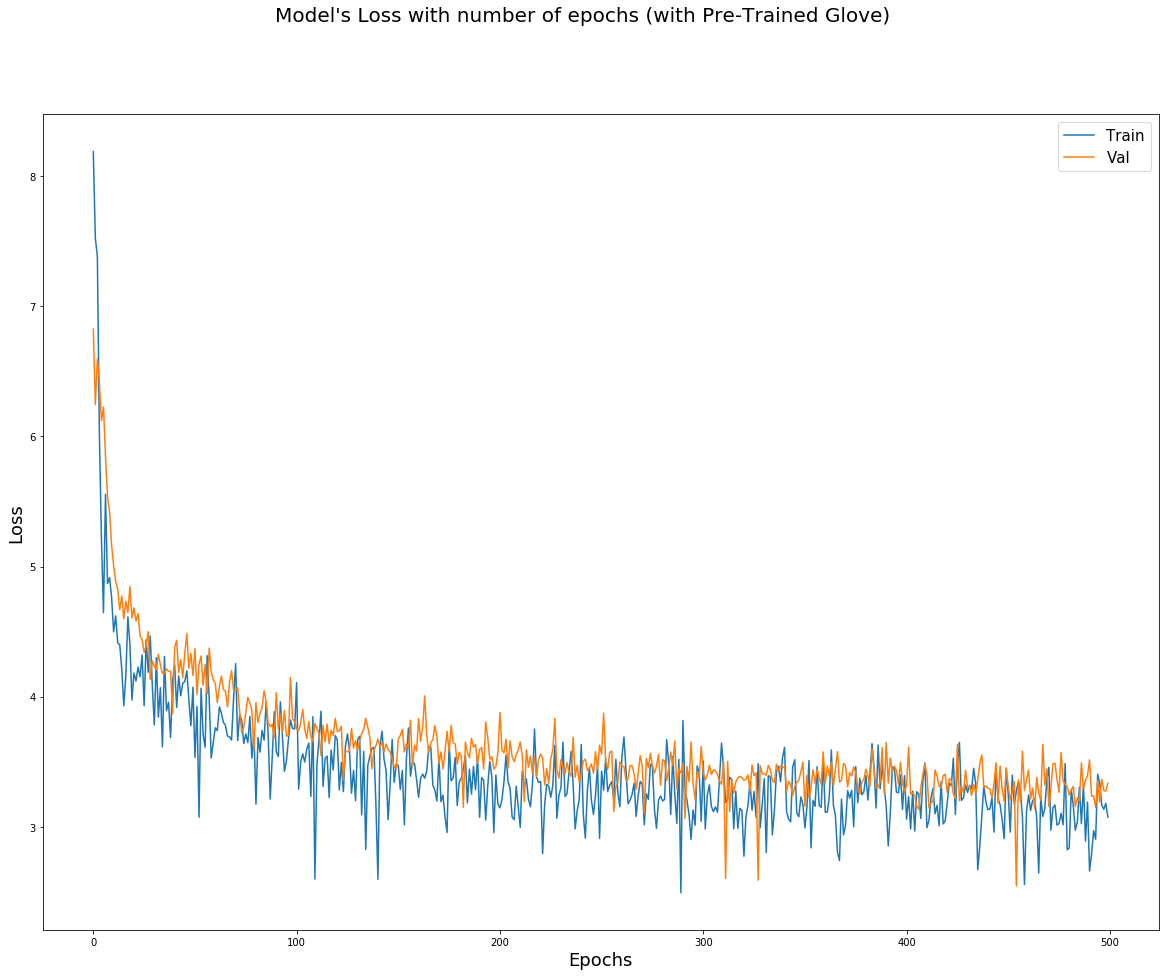

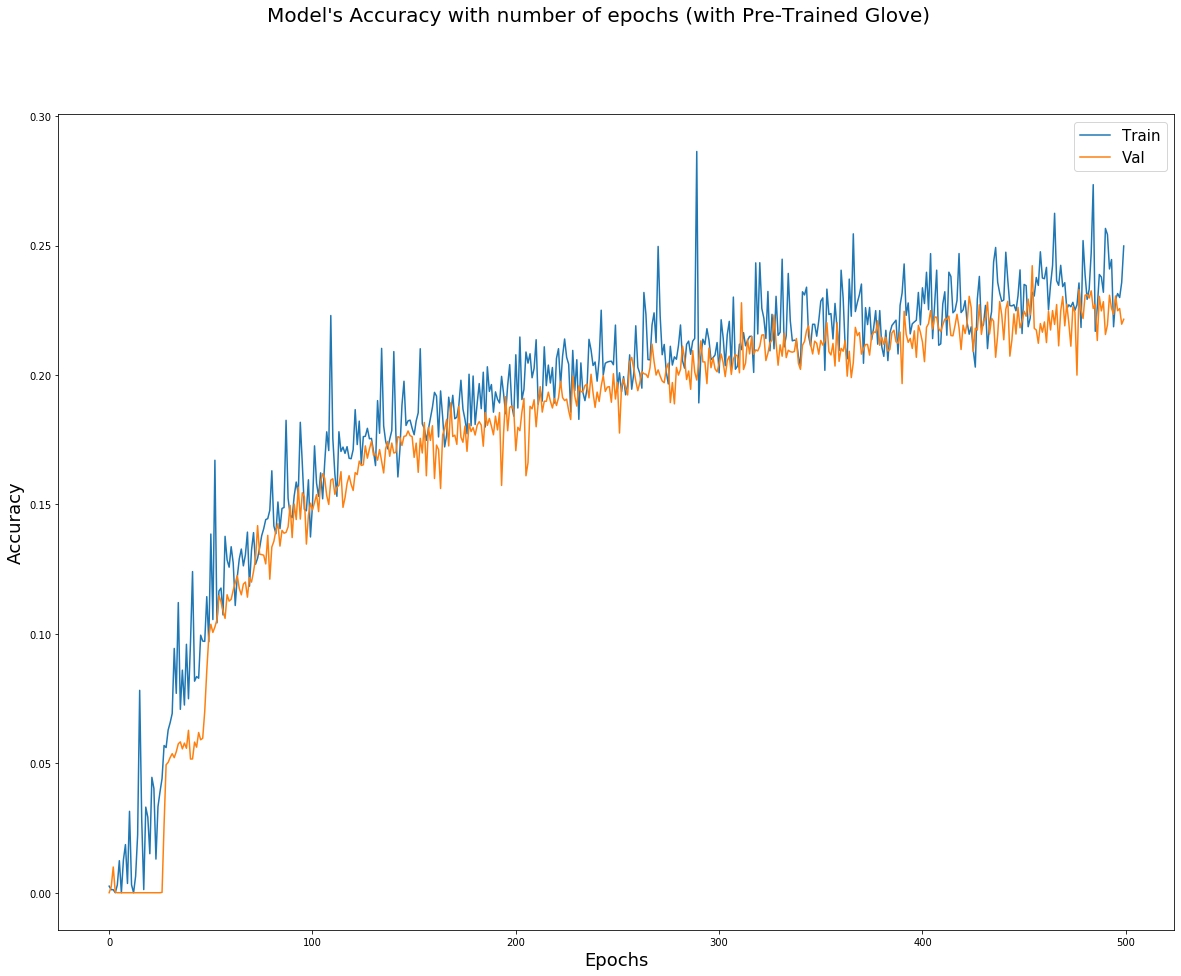

In [52]:
try:
    for round_num in tqdm(range(0, NUM_ROUNDS)):

        # Examine validation metrics
        print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} examples.')
        keras_evaluate(server_state_pe, val_data, use_pretrained_embedding=True)

        # Sample train clients to create a train dataset
        print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
        train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state_pe, server_metrics = iterative_process_pe.next(server_state_pe, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker_with_embedding.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker_with_embedding.add_metrics_by_name('accuracy', server_metrics.accuracy)
        
        np.save('train_accuracy_with_pt_embed.npy', train_metrics_tracker_with_embedding.get_metrics_by_name('accuracy'))
        np.save('val_accuracy_with_pt_embed.npy', val_metrics_tracker_with_embedding.get_metrics_by_name('accuracy'))
        
        np.save('train_loss_with_pt_embed.npy', train_metrics_tracker_with_embedding.get_metrics_by_name('loss'))
        np.save('val_loss_with_pt_embed.npy', val_metrics_tracker_with_embedding.get_metrics_by_name('loss'))

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker_with_embedding.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker_with_embedding.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Model\'s Loss with number of epochs (with Pre-Trained Glove)', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    fig.savefig('Loss_with_Epochs_withPretrainEmbed.jpg')
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker_with_embedding.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker_with_embedding.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Model\'s Accuracy with number of epochs (with Pre-Trained Glove)', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    fig2.savefig('Accuracy_with_Epochs_withPretrainEmbed.jpg')
    plt.show()

### Retrieve the previously saved numpy arrays for Loss and Accuracy for Training without any pretrained word embedding

In [53]:
import numpy as np
train_loss_no_pt_embed = np.load('train_loss_no_pt_embed.npy')
train_accuracy_no_pt_embed = np.load('train_accuracy_no_pt_embed.npy')
val_loss_no_pt_embed = np.load('val_loss_no_pt_embed.npy')
val_accuracy_no_pt_embed = np.load('val_accuracy_no_pt_embed.npy')

### Plot Model's Loss for both models, with and without pre-trained embeddings via Glove

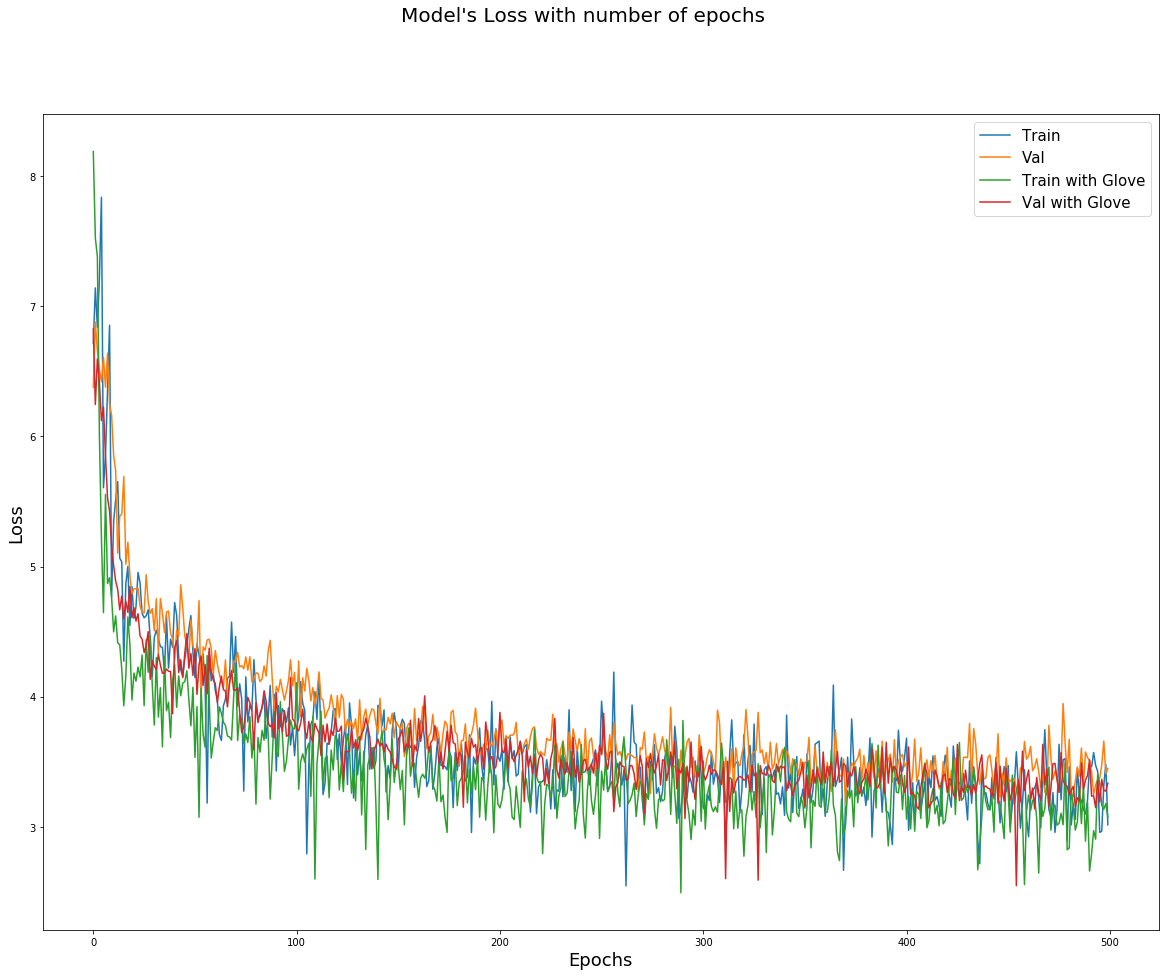

In [54]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
# ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
# ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
ax.plot(x_axis, train_loss_no_pt_embed, label='Train')
ax.plot(x_axis, val_loss_no_pt_embed, label='Val')
ax.plot(x_axis, train_metrics_tracker_with_embedding.get_metrics_by_name('loss'), label='Train with Glove')
ax.plot(x_axis, val_metrics_tracker_with_embedding.get_metrics_by_name('loss'), label='Val with Glove')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Loss with number of epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
fig.savefig('Loss_with_Epochs.jpg')
plt.show()

### Plot Model Accuracy for both models, with and without pre-trained embeddings via Glove

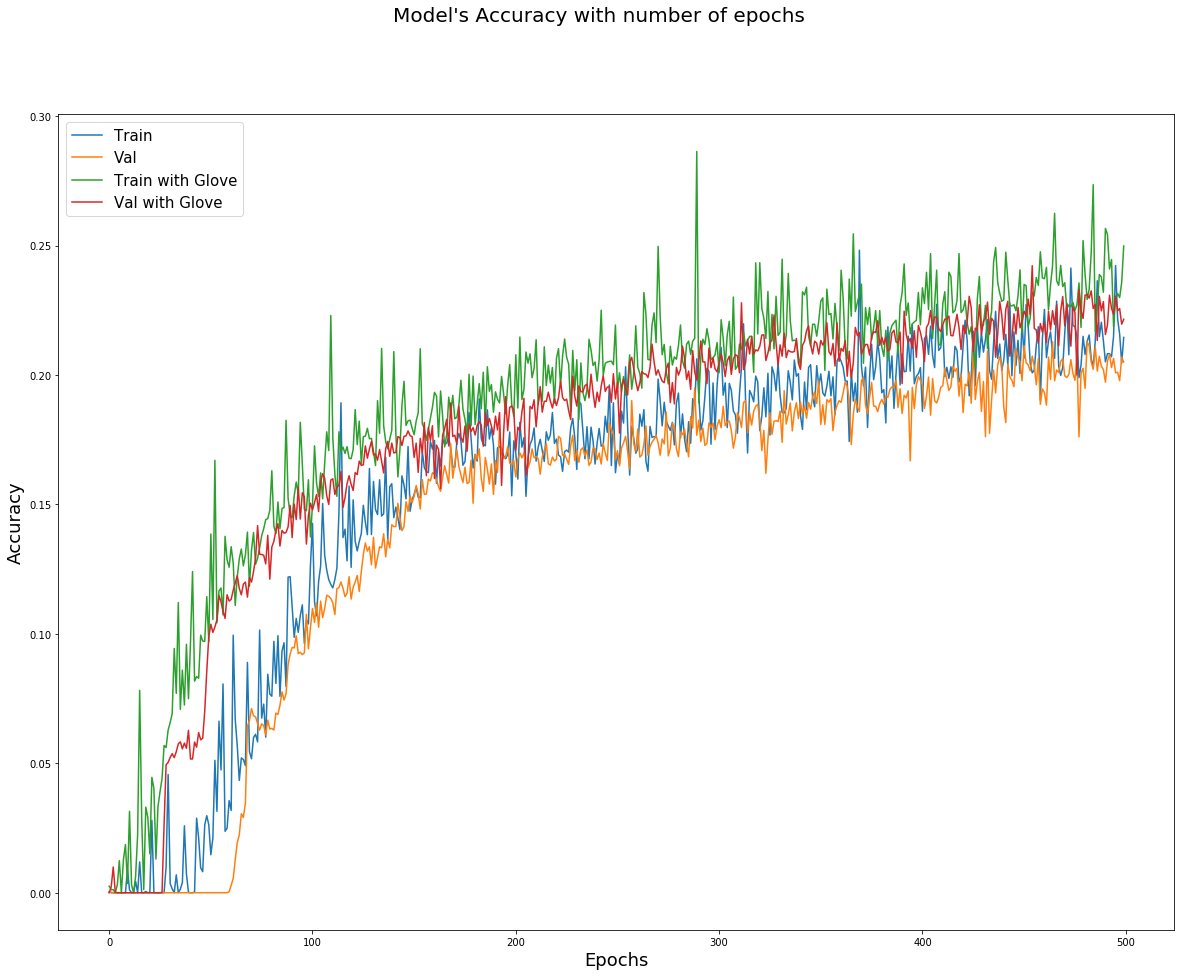

In [55]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
# ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
# ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train')
ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val')
ax.plot(x_axis, train_metrics_tracker_with_embedding.get_metrics_by_name('accuracy'), label='Train with Glove')
ax.plot(x_axis, val_metrics_tracker_with_embedding.get_metrics_by_name('accuracy'), label='Val with Glove')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Accuracy with number of epochs', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
fig.savefig('Accuracy_with_Epochs.jpg')
plt.show()